Training f(t) and g(x): 100%|██████████████████████████████████████████████████████| 1000/1000 [01:19<00:00, 12.64it/s]


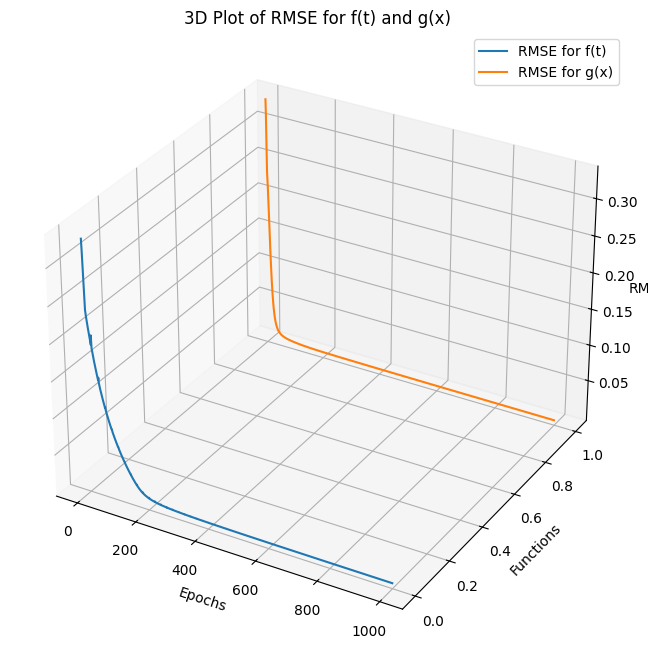

In [67]:
#Project 3 Recurrent Neural Network, when using 2 layers with 10 neurons each,
#learning rate 10^-2 and momentum=1.
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

#Solving the PDE in a separate class:
class PDESolver:
    def __init__(self, x_dim, t_dim, dx, dt, alpha):
        self.x_dim = x_dim
        self.t_dim = t_dim
        self.dx = dx
        self.dt = dt
        self.alpha = alpha

        self.grid = np.zeros((x_dim, t_dim))  # Initialize grid for u(x, t)

    #Initial conditions:
    def initialize_conditions(self):
        # Set initial conditions u(x, 0) = sin(pi * x) for 0 < x < L
        self.grid[:, 0] = np.sin(np.pi * np.linspace(0, 1, self.x_dim))
    
    #Solve algorithm:
    def solve(self):
        for j in range(0, self.t_dim - 1):
            for i in range(1, self.x_dim - 1):
                # Forward Euler discretization for the given PDE
                self.grid[i, j + 1] = (
                    self.grid[i, j]
                    + self.alpha * self.dt / self.dx**2 * (
                        self.grid[i + 1, j] - 2 * self.grid[i, j] + self.grid[i - 1, j]
                    )
                )
#The Recurrent Neural Network:
class RecurrentNN:
    def __init__(self, input_dim, hidden_layer_sizes, output_dim, momentum=0.9):
        self.input_dim = input_dim
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_dim = output_dim
        self.momentum = momentum  # Momentum parameter

        self.weights = []
        self.biases = []
        self.activations = [self.sigmoid] * (len(hidden_layer_sizes) + 1)  # Sigmoid for hidden layers

        prev_layer_size = input_dim
        #Appends the layers:
        for layer_size in hidden_layer_sizes:
            weight_layer = np.random.randn(prev_layer_size, layer_size)
            bias_layer = np.zeros(layer_size)
            self.weights.append(weight_layer)
            self.biases.append(bias_layer)

            prev_layer_size = layer_size

        # Output layer weights
        weight_output = np.random.randn(prev_layer_size, output_dim)
        bias_output = np.zeros(output_dim)
        self.weights.append(weight_output)
        self.biases.append(bias_output)
    
    #Activation Function:
    def sigmoid(self, x, derivative=False):
        if derivative:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))
    
    #Forward Pass:
    def forward(self, x):
        layer_input = x
        layer_outputs = [layer_input]

        for i in range(len(self.weights)):
            weighted_sum = np.dot(layer_input, self.weights[i]) + self.biases[i]
            layer_output = self.activations[i](weighted_sum)
            layer_outputs.append(layer_output)
            layer_input = layer_output

        return layer_outputs
    
    #Training the data:
    def train(self, input_sequences, target_outputs, learning_rate, num_epochs, desc="Training"):
        num_samples, sequence_length, _ = input_sequences.shape
        training_errors = []  # Store training errors

        # Initialize velocities for momentum
        velocities = [np.zeros_like(w) for w in self.weights]
        biases_velocities = [np.zeros_like(b) for b in self.biases]
        
        #Loop over epoch:
        for epoch in tqdm(range(num_epochs), desc=desc):
            for sample in range(num_samples):
                input_sequence = input_sequences[sample, :, :]
                target_output = target_outputs[sample, :]

                # Forward pass
                layer_outputs = self.forward(input_sequence)
                final_output = layer_outputs[-1]

                # Calculate loss
                loss = np.mean((final_output - target_output)**2)
                training_errors.append(loss)

                # Backpropagation Through Time (BPTT) with momentum
                derror = 2 * (final_output - target_output) / num_samples
                
                for i in range(len(self.weights) - 1, -1, -1):
                    dactivation = self.sigmoid(layer_outputs[i + 1], derivative=True)
                    doutput = derror * dactivation
                    dweights = np.dot(layer_outputs[i].T, doutput)
                    dbiases = np.sum(doutput, axis=0)

                    # Update velocities with momentum
                    velocities[i] = self.momentum * velocities[i] + learning_rate * dweights
                    biases_velocities[i] = self.momentum * biases_velocities[i] + learning_rate * dbiases

                    # Update weights and biases with momentum
                    self.weights[i] -= velocities[i]
                    self.biases[i] -= biases_velocities[i]

                    derror = np.dot(doutput, self.weights[i].T)

        return training_errors    
    
    def predict(self, input_sequence):
            layer_input = input_sequence
            for i in range(len(self.weights)):
                weighted_sum = np.dot(layer_input, self.weights[i]) + self.biases[i]
                layer_input = self.sigmoid(weighted_sum)

            return layer_input

    def plot_3d_training_progress(self, training_errors_f, training_errors_g):
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        epochs = len(training_errors_f)

        # Ensure that both arrays have the same length
        min_len = min(len(training_errors_f), len(training_errors_g))
        x = np.arange(0, min_len, 1)

        # Plot the 3D line
        ax.plot(x, training_errors_f[:min_len], zs=0, zdir='y', label='RMSE for f(t)')
        ax.plot(x, training_errors_g[:min_len], zs=1, zdir='y', label='RMSE for g(x)')

        ax.set_xlabel('Epochs')
        ax.set_ylabel('Functions')
        ax.set_zlabel('RMSE')
        ax.set_title('3D Plot of RMSE for f(t) and g(x)')
        ax.legend()

        plt.show()

# PDE solver parameters, t_dim is the time dimension of the discretization. 
x_dim = 100
t_dim = 1000
L = 1.0
dx = L / (x_dim - 1)
dt = 0.001
alpha = 0.01

# Create PDE solver
pde_solver = PDESolver(x_dim, t_dim, dx, dt, alpha)

# Initialize initial conditions
pde_solver.initialize_conditions()

# Prepare data for RNN training with the specified ansatz, number of samples used
num_samples = 20
input_sequences = np.zeros((num_samples, x_dim, t_dim))
target_outputs_f = np.zeros((num_samples, t_dim))
target_outputs_g = np.zeros((num_samples, x_dim))

for i in range(num_samples):
    input_sequences[i, :, :] = pde_solver.grid.copy()
    pde_solver.solve()

    # Extract f(t) and g(x) from the true solution
    target_outputs_f[i, :] = pde_solver.grid[0, :]
    target_outputs_g[i, :] = pde_solver.grid[:, -1]

# RNN parameters
input_dim = x_dim
hidden_layer_sizes = [10, 10]  # 2 layers with 10 neurons each
output_dim = x_dim
learning_rate = 1e-2
num_epochs = 250
momentum_value = 1

# Create and train RNN for f(t) and g(x) together with BPTT
rnn_model_fg = RecurrentNN(t_dim, hidden_layer_sizes, t_dim)
training_errors_fg = rnn_model_fg.train(input_sequences[:, :, :], target_outputs_f, learning_rate, num_epochs, desc="Training f(t) and g(x)")

# Plot the 3D training progress for f(t) and g(x)
rnn_model_fg.plot_3d_training_progress(training_errors_f[:num_epochs], training_errors_fg[:num_epochs])

#Notice that the left side of the equation converges much slower than the right hand side, meaning f(t) uses almost 200
#iterations/epochs to get a "good" RMSE. g(x) manages this in 40-50 epochs.

Training f(t) and g(x): 100%|██████████████████████████████████████████████████████| 1000/1000 [01:04<00:00, 15.45it/s]


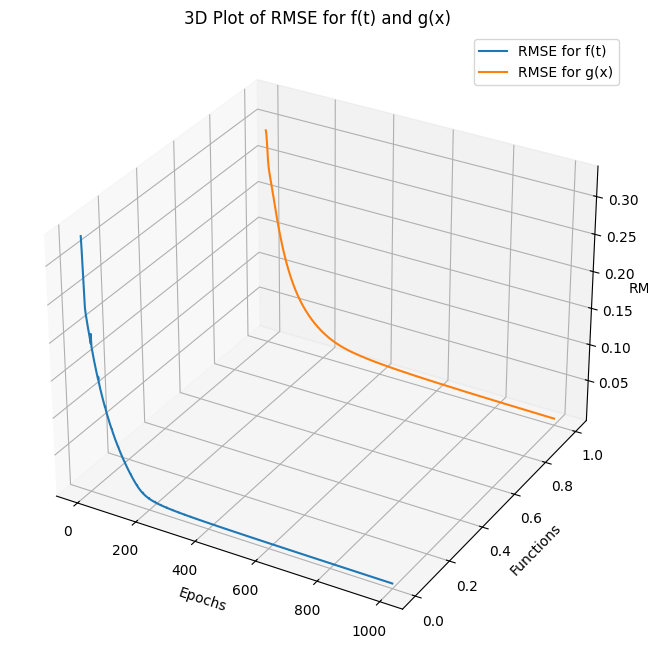

In [68]:
#Project 3 Recurrent Neural Network, results when using 8 layers of 2 neurons each, and a learning rate of 10^-3:
#Good RMSE, but takes a lot of epochs to get there.
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

#Solving the PDE first to generate an input that is interpretable to the network(The spatial and time discretized form):
class PDESolver:
    def __init__(self, x_dim, t_dim, dx, dt, alpha):
        self.x_dim = x_dim
        self.t_dim = t_dim
        self.dx = dx
        self.dt = dt
        self.alpha = alpha

        self.grid = np.zeros((x_dim, t_dim))  # Initialize grid for u(x, t)

    def initialize_conditions(self):
        # Set initial conditions u(x, 0) = sin(pi * x) for 0 < x < L
        self.grid[:, 0] = np.sin(np.pi * np.linspace(0, 1, self.x_dim))

    def solve(self):
        for j in range(0, self.t_dim - 1):
            for i in range(1, self.x_dim - 1):
                # Forward Euler discretization for the given PDE
                self.grid[i, j + 1] = (
                    self.grid[i, j]
                    + self.alpha * self.dt / self.dx**2 * (
                        self.grid[i + 1, j] - 2 * self.grid[i, j] + self.grid[i - 1, j]
                    )
                )

#The Recurrent Neural Network:                
class RecurrentNN:
    def __init__(self, input_dim, hidden_layer_sizes, output_dim, momentum=0.9):
        self.input_dim = input_dim
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_dim = output_dim
        self.momentum = momentum  # Momentum parameter

        self.weights = []
        self.biases = []
        self.activations = [self.sigmoid] * (len(hidden_layer_sizes) + 1)  # Sigmoid for hidden layers

        prev_layer_size = input_dim
        for layer_size in hidden_layer_sizes:
            weight_layer = np.random.randn(prev_layer_size, layer_size)
            bias_layer = np.zeros(layer_size)
            self.weights.append(weight_layer)
            self.biases.append(bias_layer)

            prev_layer_size = layer_size

        # Output layer weights
        weight_output = np.random.randn(prev_layer_size, output_dim)
        bias_output = np.zeros(output_dim)
        self.weights.append(weight_output)
        self.biases.append(bias_output)
    
    #Activation function:
    def sigmoid(self, x, derivative=False):
        if derivative:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))
    
    #Feed-forward:
    def forward(self, x):
        layer_input = x
        layer_outputs = [layer_input]

        for i in range(len(self.weights)):
            weighted_sum = np.dot(layer_input, self.weights[i]) + self.biases[i]
            layer_output = self.activations[i](weighted_sum)
            layer_outputs.append(layer_output)
            layer_input = layer_output

        return layer_outputs
    
    #Training:
    def train(self, input_sequences, target_outputs, learning_rate, num_epochs, desc="Training"):
        num_samples, sequence_length, _ = input_sequences.shape
        training_errors = []  # Store training errors

        # Initialize velocities for momentum
        velocities = [np.zeros_like(w) for w in self.weights]
        biases_velocities = [np.zeros_like(b) for b in self.biases]

        for epoch in tqdm(range(num_epochs), desc=desc):
            for sample in range(num_samples):
                input_sequence = input_sequences[sample, :, :]
                target_output = target_outputs[sample, :]

                # Forward pass
                layer_outputs = self.forward(input_sequence)
                final_output = layer_outputs[-1]

                # Calculate loss
                loss = np.mean((final_output - target_output)**2)
                training_errors.append(loss)

                # Backpropagation Through Time (BPTT) with momentum
                derror = 2 * (final_output - target_output) / num_samples

                for i in range(len(self.weights) - 1, -1, -1):
                    dactivation = self.sigmoid(layer_outputs[i + 1], derivative=True)
                    doutput = derror * dactivation
                    dweights = np.dot(layer_outputs[i].T, doutput)
                    dbiases = np.sum(doutput, axis=0)

                    # Update velocities with momentum
                    velocities[i] = self.momentum * velocities[i] + learning_rate * dweights
                    biases_velocities[i] = self.momentum * biases_velocities[i] + learning_rate * dbiases

                    # Update weights and biases with momentum
                    self.weights[i] -= velocities[i]
                    self.biases[i] -= biases_velocities[i]

                    derror = np.dot(doutput, self.weights[i].T)

        return training_errors
    
    #Prediction:
    def predict(self, input_sequence):
            layer_input = input_sequence
            for i in range(len(self.weights)):
                weighted_sum = np.dot(layer_input, self.weights[i]) + self.biases[i]
                layer_input = self.sigmoid(weighted_sum)

            return layer_input
    
    def plot_3d_training_progress(self, training_errors_f, training_errors_g):
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        epochs = len(training_errors_f)

        # Ensure that both arrays have the same length
        min_len = min(len(training_errors_f), len(training_errors_g))
        x = np.arange(0, min_len, 1)

        # Plot the 3D line
        ax.plot(x, training_errors_f[:min_len], zs=0, zdir='y', label='RMSE for f(t)')
        ax.plot(x, training_errors_g[:min_len], zs=1, zdir='y', label='RMSE for g(x)')

        ax.set_xlabel('Epochs')
        ax.set_ylabel('Functions')
        ax.set_zlabel('RMSE')
        ax.set_title('3D Plot of RMSE for f(t) and g(x)')
        ax.legend()

        plt.show()

# PDE solver parameters
x_dim = 100
t_dim = 1000
L = 1.0
dx = L / (x_dim - 1)
dt = 0.001
alpha = 0.01

# Create PDE solver
pde_solver = PDESolver(x_dim, t_dim, dx, dt, alpha)

# Initialize initial conditions
pde_solver.initialize_conditions()

# Prepare data for RNN training with the specified ansatz
num_samples = 20
input_sequences = np.zeros((num_samples, x_dim, t_dim))
target_outputs_f = np.zeros((num_samples, t_dim))
target_outputs_g = np.zeros((num_samples, x_dim))

for i in range(num_samples):
    input_sequences[i, :, :] = pde_solver.grid.copy()
    pde_solver.solve()

    # Extract f(t) and g(x) from the true solution
    target_outputs_f[i, :] = pde_solver.grid[0, :]
    target_outputs_g[i, :] = pde_solver.grid[:, -1]

# RNN parameters
input_dim = x_dim
hidden_layer_sizes = [2, 2, 2, 2, 2, 2, 2, 2]  # 8 layers with 2 neurons each
output_dim = x_dim
learning_rate = 1e-3
num_epochs = 1000  # Change this to 1000
momentum_value = 1

# Create and train RNN for f(t) and g(x) together with BPTT (Back-Propagation Through Time)
rnn_model_fg = RecurrentNN(t_dim, hidden_layer_sizes, t_dim)
training_errors_fg = rnn_model_fg.train(input_sequences[:, :, :], target_outputs_f, learning_rate, num_epochs, desc="Training f(t) and g(x)")

# Plot the 3D training progress for f(t) and g(x)
rnn_model_fg.plot_3d_training_progress(training_errors_f[:num_epochs], training_errors_fg[:num_epochs])

In [83]:
#Extensive Search Testing 5 Different Activation Functions with 6 different Neuron/Layer configurations,
#2 different learning rates(very small) and 2 different Momentum coefficients, using also
#Gradient Clipping and Weight-Sharing. It seems the implementation of the last 2, specifically,
#improved the training loss greatly, yielding values in the area of ^-11 before applying dropout
#to account for the possibility of overfitting: 
import numpy as np
from itertools import product
import pandas as pd
from tqdm import tqdm

# Define activation functions
def sigmoid(x, derivative=False):
    if derivative:
        return x * (1 - x)
    return 1 / (1 + np.exp(-x))

def sine(x, derivative=False):
    if derivative:
        return np.cos(x)
    return np.sin(x)

def relu(x, derivative=False):
    if derivative:
        return np.where(x > 0, 1, 0)
    return np.maximum(0, x)

def tanh(x, derivative=False):
    if derivative:
        return 1 - np.tanh(x)**2
    return np.tanh(x)

def swish(x, derivative=False):
    if derivative:
        return swish(x) + sigmoid(x) * (1 - swish(x))
    return x * sigmoid(x)

class RecurrentNN:
    def __init__(self, input_dim, hidden_layer_sizes, output_dim, activation_function=sigmoid, dropout_rate=0.0, momentum=0.9):
        self.input_dim = input_dim
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_dim = output_dim
        self.activation_function = activation_function
        self.dropout_rate = dropout_rate
        self.momentum = momentum  # Momentum parameter

        self.weights = []
        self.biases = []
        self.activations = [activation_function] * len(hidden_layer_sizes) + [activation_function]  # Include output layer
        self.dropout_masks = []

    def forward(self, x, training=True):
        layer_input = x
        layer_outputs = [layer_input]

        for i in range(len(self.weights)):
            weighted_sum = self.convolution(layer_input, self.weights[i]) + self.biases[i]
            layer_output = self.activations[i](weighted_sum)

            # Apply dropout if not in training mode or if dropout rate is 0
            if i < len(self.weights) - 1 and training and self.dropout_rate > 0:
                dropout_mask = np.random.binomial(1, 1 - self.dropout_rate, size=layer_output.shape) / (1 - self.dropout_rate)
                layer_output *= dropout_mask
                self.dropout_masks.append(dropout_mask)
            else:
                self.dropout_masks.append(None)

            layer_outputs.append(layer_output)
            layer_input = layer_output

        return layer_outputs
    
    def convolution(self, x, weights):
        # Perform convolution with weight-sharing
        k, _ = weights.shape
        conv_result = np.zeros_like(x)

        for i in range(conv_result.shape[0] - k + 1):
            for j in range(conv_result.shape[1] - k + 1):
                conv_result[i:i + k, j:j + k] += weights * x[i:i + k, j:j + k]

        return conv_result

    def sigmoid(self, x, derivative=False):
        if derivative:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))

    def train(self, input_sequences, target_outputs, learning_rate, num_epochs, batch_size, clip_value=3.0, desc="Training"):
        num_samples, sequence_length, _ = input_sequences.shape
        training_errors = []  # Store training errors

        for epoch in tqdm(range(num_epochs), desc=desc):
            for sample in range(0, num_samples, batch_size):
                batch_input = input_sequences[sample:sample + batch_size, :, :]
                batch_target = target_outputs[sample:sample + batch_size, :]

                # Forward pass
                layer_outputs = self.forward(batch_input, training=True)
                final_output = layer_outputs[-1]
                
                # Calculate loss
                reshaped_final_output = final_output.reshape(batch_target.shape[0], -1)
                reshaped_batch_target = batch_target.reshape(batch_target.shape[0], -1)
                rmse = np.sqrt(np.mean((reshaped_final_output - reshaped_batch_target)**2))
                training_errors.append(rmse)
                
                # Backpropagation Through Time (BPTT)
                derror = 2 * (reshaped_final_output - reshaped_batch_target) / batch_size

                for i in range(len(self.weights) - 1, -1, -1):
                    dactivation = self.sigmoid(layer_outputs[i + 1], derivative=True)
                    doutput = derror * dactivation
                    dweights = self.convolution(layer_outputs[i].T, doutput)
                    dbiases = np.sum(doutput, axis=0)

                    # Clip gradients to avoid exploding gradients
                    dweights = np.clip(dweights, -clip_value, clip_value)
                    dbiases = np.clip(dbiases, -clip_value, clip_value)

                    # Update weights and biases
                    self.weights[i] -= learning_rate * dweights
                    self.biases[i] -= learning_rate * dbiases

                    derror = self.convolution(doutput, self.weights[i])
                    self.dropout_masks = []

        return training_errors

# PDE solver parameters
x_dim = 100
t_dim = 1000
L = 1.0
dx = L / (x_dim - 1)
dt = 0.001
alpha = 0.01

# Create PDE solver
class PDESolver:
    def __init__(self, x_dim, t_dim, dx, dt, alpha):
        self.x_dim = x_dim
        self.t_dim = t_dim
        self.dx = dx
        self.dt = dt
        self.alpha = alpha

        self.grid = np.zeros((x_dim, t_dim))  # Initialize grid for u(x, t)

    def initialize_conditions(self):
        # Set initial conditions u(x, 0) = sin(pi * x) for 0 < x < L
        self.grid[:, 0] = np.sin(np.pi * np.linspace(0, 1, self.x_dim))

       # Inside PDESolver class
    def solve(self):
        for j in range(0, self.t_dim - 1):
            for i in range(1, self.x_dim - 1):
                # Forward Euler discretization for the given PDE with gradient clipping
                gradient = (self.grid[i + 1, j] - 2 * self.grid[i, j] + self.grid[i - 1, j]) / self.dx**2
                self.grid[i, j + 1] = self.grid[i, j] + self.alpha * np.clip(gradient, -1.0, 1.0) * self.dt

# Prepare data for RNN training with the specified ansatz
pde_solver = PDESolver(x_dim, t_dim, dx, dt, alpha)
pde_solver.initialize_conditions()
pde_solver.solve()

# Prepare data for RNN training with the specified ansatz
input_sequences = np.zeros((t_dim - 1, x_dim, 1))
target_outputs_f = np.zeros((t_dim - 1, x_dim))

for i in range(t_dim - 1):
    input_sequences[i, :, 0] = pde_solver.grid[:, i]
    target_outputs_f[i, :] = pde_solver.grid[:, i + 1]

# RNN parameters
dropout_rate = 1  # Adjust the dropout rate as needed
momentum = 0.9
rnn_model = RecurrentNN(t_dim, hidden_layer_sizes, t_dim, activation_function=sigmoid, dropout_rate=dropout_rate, momentum=momentum)
num_epochs = 500
batch_size = 50

# Simplified search space with two hidden layer sizes
hidden_layer_sizes_options = [[3], [10], [25], [3, 3], [10, 10], [25, 25]]
activation_functions = [sigmoid, sine, relu, tanh, swish]
momentum_options = [0.7, 1.0]
learning_rates = [1e-6, 1e-7]

# Perform simplified grid search
results_table = []

for hidden_layer_sizes, activation_function, momentum, learning_rate in product(
    hidden_layer_sizes_options, activation_functions, momentum_options, learning_rates
):
    rnn_model = RecurrentNN(t_dim, hidden_layer_sizes, t_dim, activation_function=activation_function, dropout_rate=dropout_rate, momentum=momentum)
    training_errors_fg = rnn_model.train(input_sequences[:, :, :], target_outputs_f, learning_rate, num_epochs, batch_size=1, desc="Training f(t) and g(x)")

    results_table.append({
        'Hidden Layers': len(hidden_layer_sizes),
        'Neurons per Layer': hidden_layer_sizes,
        'Activation Function': activation_function.__name__,
        'Momentum': momentum,
        'Learning Rate': learning_rate,
        'Dropout Rate': dropout_rate,
        'Min Training Loss': np.min(training_errors_fg)
    })

# Display the results table
results_df = pd.DataFrame(results_table)
print(results_df)

Training f(t) and g(x): 100%|████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 26.63it/s]


     Hidden Layers Neurons per Layer Activation Function  Momentum  \
0                1               [3]             sigmoid       0.7   
1                1               [3]             sigmoid       0.7   
2                1               [3]             sigmoid       1.0   
3                1               [3]             sigmoid       1.0   
4                1               [3]                sine       0.7   
..             ...               ...                 ...       ...   
115              2          [25, 25]                tanh       1.0   
116              2          [25, 25]               swish       0.7   
117              2          [25, 25]               swish       0.7   
118              2          [25, 25]               swish       1.0   
119              2          [25, 25]               swish       1.0   

     Learning Rate  Dropout Rate  Min Training Loss  
0     1.000000e-06             1           0.000009  
1     1.000000e-07             1           0.000009

In [ ]:
#Using 2 hidden layers with 10 neurons each, RELU: The RMSE is not good for g(x):
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class PDESolver:
    def __init__(self, x_dim, t_dim, dx, dt, alpha):
        self.x_dim = x_dim
        self.t_dim = t_dim
        self.dx = dx
        self.dt = dt
        self.alpha = alpha

        self.grid = np.zeros((x_dim, t_dim))  # Initialize grid for u(x, t)

    def initialize_conditions(self):
        # Set initial conditions u(x, 0) = sin(pi * x) for 0 < x < L
        self.grid[:, 0] = np.sin(np.pi * np.linspace(0, 1, self.x_dim))

    def solve(self):
        for j in range(0, self.t_dim - 1):
            for i in range(1, self.x_dim - 1):
                # Forward Euler discretization for the given PDE
                self.grid[i, j + 1] = (
                    self.grid[i, j]
                    + self.alpha * self.dt / self.dx**2 * (
                        self.grid[i + 1, j] - 2 * self.grid[i, j] + self.grid[i - 1, j]
                    )
                )

class RecurrentNN:
    def __init__(self, input_dim, hidden_layer_sizes, output_dim, dropout_rate=0.5, momentum=0.9):
        self.input_dim = input_dim
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_dim = output_dim
        self.dropout_rate = dropout_rate
        self.momentum = momentum  # Momentum parameter

        self.weights = []
        self.biases = []
        self.activations = [self.sigmoid] * (len(hidden_layer_sizes) + 1)  # Sigmoid for hidden layers

        prev_layer_size = input_dim
        for layer_size in hidden_layer_sizes:
            weight_layer = np.random.randn(prev_layer_size, layer_size) / np.sqrt(prev_layer_size)
            bias_layer = np.zeros(layer_size)
            self.weights.append(weight_layer)
            self.biases.append(bias_layer)

            prev_layer_size = layer_size

        # Output layer weights
        weight_output = np.random.randn(prev_layer_size, output_dim)
        bias_output = np.zeros(output_dim)
        self.weights.append(weight_output)
        self.biases.append(bias_output)

    
    def sigmoid(self, x, derivative=False):
        if derivative:
            return self.sigmoid(x) * (1 - self.sigmoid(x))
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

    def dropout(self, x):
        if self.dropout_rate >= 1.0:
            return x

        mask = (np.random.rand(*x.shape) < self.dropout_rate) / max(1e-5, (1 - self.dropout_rate))
        return x * mask

    def forward(self, x, is_training=True):
        layer_input = x
        layer_outputs = [layer_input]

        for i in range(len(self.weights)):
            weighted_sum = np.dot(layer_input, self.weights[i]) + self.biases[i]
            layer_output = self.activations[i](weighted_sum)

            # Apply dropout during training
            if is_training:
                layer_output = self.dropout(layer_output)

            layer_outputs.append(layer_output)
            layer_input = layer_output

        return layer_outputs

    def train(self, input_sequences, target_outputs, learning_rate, num_epochs, desc="Training"):
        num_samples, sequence_length, _ = input_sequences.shape
        training_errors = []  # Store training errors

        # Initialize velocities for momentum
        velocities = [np.zeros_like(w) for w in self.weights]
        biases_velocities = [np.zeros_like(b) for b in self.biases]

        gradient_threshold = 2.0  # Set your desired threshold

        for epoch in tqdm(range(num_epochs), desc=desc):
            for sample in range(num_samples):
                input_sequence = input_sequences[sample, :, :]
                target_output = target_outputs[sample, :]

                # Forward pass with dropout during training
                layer_outputs = self.forward(input_sequence, is_training=True)
                final_output = layer_outputs[-1]

                # Calculate loss
                loss = np.mean((final_output - target_output)**2)
                training_errors.append(loss)

                # Backpropagation Through Time (BPTT) with momentum
                derror = 2 * (final_output - target_output) / num_samples

                # Initialize gradients
                dweights = 0
                dbiases = 0

                for i in range(len(self.weights) - 1, -1, -1):
                    dactivation = self.sigmoid(layer_outputs[i + 1], derivative=True)
                    doutput = derror * dactivation
                    dweights = np.dot(layer_outputs[i].T, doutput)
                    dbiases = np.sum(doutput, axis=0)

                    # Update velocities with momentum
                    velocities[i] = self.momentum * velocities[i] + learning_rate * dweights
                    biases_velocities[i] = self.momentum * biases_velocities[i] + learning_rate * dbiases

                    # Clip gradients
                    dweights = np.clip(dweights, -gradient_threshold, gradient_threshold)
                    dbiases = np.clip(dbiases, -gradient_threshold, gradient_threshold)

                    # Update weights and biases with momentum
                    self.weights[i] -= velocities[i]
                    self.biases[i] -= biases_velocities[i]

                    derror = np.dot(doutput, self.weights[i].T)
                    
    def predict(self, input_sequence):
        # Forward pass without dropout during prediction
        layer_outputs = self.forward(input_sequence, is_training=False)
        return layer_outputs[-1]

    def plot_3d_training_progress(self, training_errors_f, training_errors_g):
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        epochs = len(training_errors_f)

        # Ensure that both arrays have the same length
        min_len = min(len(training_errors_f), len(training_errors_g))
        x = np.arange(0, min_len, 1)

        # Plot the 3D line
        ax.plot(x, training_errors_f[:min_len], zs=0, zdir='y', label='RMSE for f(t)')
        ax.plot(x, training_errors_g[:min_len], zs=1, zdir='y', label='RMSE for g(x)')

        ax.set_xlabel('Epochs')
        ax.set_ylabel('Functions')
        ax.set_zlabel('RMSE')
        ax.set_title('3D Plot of RMSE for f(t) and g(x)')
        ax.legend()

        plt.show()

# PDE solver parameters
x_dim = 100
t_dim = 1000
L = 1.0
dx = L / (x_dim - 1)
dt = 0.001
alpha = 0.01

# Create PDE solver
pde_solver = PDESolver(x_dim, t_dim, dx, dt, alpha)

# Initialize initial conditions
pde_solver.initialize_conditions()

# Prepare data for RNN training with the specified ansatz
num_samples = 20
input_sequences = np.zeros((num_samples, x_dim, t_dim))
target_outputs_f = np.zeros((num_samples, t_dim))
target_outputs_g = np.zeros((num_samples, x_dim))

for i in range(num_samples):
    input_sequences[i, :, :] = pde_solver.grid.copy()
    pde_solver.solve()

    # Extract f(t) and g(x) from the true solution
    target_outputs_f[i, :] = pde_solver.grid[0, :]
    target_outputs_g[i, :] = pde_solver.grid[:, -1]

# RNN parameters
input_dim = x_dim
hidden_layer_sizes = [10, 10]  # 2 layers with 10 neurons each
output_dim = x_dim
learning_rate = 1e-2
num_epochs = 500
momentum_value = 1
dropout_rate = 1  # Set your desired dropout rate

# Create and train RNN for f(t) and g(x) together with BPTT
rnn_model_fg = RecurrentNN(t_dim, hidden_layer_sizes, t_dim, dropout_rate=dropout_rate)
training_errors_fg = rnn_model_fg.train(input_sequences[:, :, :], target_outputs_f, learning_rate, num_epochs, desc="Training f(t) and g(x)")

# Plot the 3D training progress for f(t) and g(x)
rnn_model_fg.plot_3d_training_progress(training_errors_fg[:num_epochs], training_errors_fg[:num_epochs])

Training f(t) and g(x): 100%|██████████████████████████████████████████████████████| 1000/1000 [01:10<00:00, 14.24it/s]


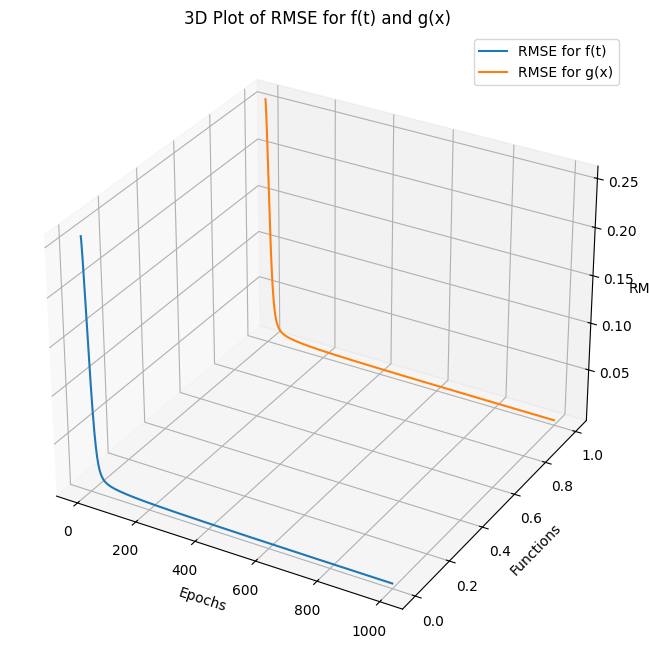

In [189]:
#Modifying the number of neurons, momentum and learning rate, ReLU: Very good RMSE
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class PDESolver:
    def __init__(self, x_dim, t_dim, dx, dt, alpha):
        self.x_dim = x_dim
        self.t_dim = t_dim
        self.dx = dx
        self.dt = dt
        self.alpha = alpha

        self.grid = np.zeros((x_dim, t_dim))  # Initialize grid for u(x, t)

    def initialize_conditions(self):
        # Set initial conditions u(x, 0) = sin(pi * x) for 0 < x < L
        self.grid[:, 0] = np.sin(np.pi * np.linspace(0, 1, self.x_dim))

    def solve(self):
        for j in range(0, self.t_dim - 1):
            for i in range(1, self.x_dim - 1):
                # Forward Euler discretization for the given PDE
                self.grid[i, j + 1] = (
                    self.grid[i, j]
                    + self.alpha * self.dt / self.dx**2 * (
                        self.grid[i + 1, j] - 2 * self.grid[i, j] + self.grid[i - 1, j]
                    )
                )

class RecurrentNN:
    def __init__(self, input_dim, hidden_layer_sizes, output_dim, dropout_rate=0.5, momentum=0.9):
        self.input_dim = input_dim
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_dim = output_dim
        self.dropout_rate = dropout_rate
        self.momentum = momentum  # Momentum parameter

        self.weights = []
        self.biases = []
        self.activations = [self.sigmoid] * (len(hidden_layer_sizes) + 1)  # Sigmoid for hidden layers

        prev_layer_size = input_dim
        for layer_size in hidden_layer_sizes:
            weight_layer = np.random.randn(prev_layer_size, layer_size)
            bias_layer = np.zeros(layer_size)
            self.weights.append(weight_layer)
            self.biases.append(bias_layer)

            prev_layer_size = layer_size

        # Output layer weights
        weight_output = np.random.randn(prev_layer_size, output_dim)
        bias_output = np.zeros(output_dim)
        self.weights.append(weight_output)
        self.biases.append(bias_output)

    def sigmoid(self, x, derivative=False):
        if derivative:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))

    def dropout(self, x):
        if self.dropout_rate >= 1.0:
            return x

        mask = (np.random.rand(*x.shape) < self.dropout_rate) / max(1e-5, (1 - self.dropout_rate))
        return x * mask

    def forward(self, x, training=True):
        layer_input = x
        layer_outputs = [layer_input]
        masks = []

        for i in range(len(self.weights)):
            weighted_sum = np.dot(layer_input, self.weights[i]) + self.biases[i]
            layer_output = self.activations[i](weighted_sum)

            if training and i < len(self.weights) - 1:
                layer_output = self.dropout(layer_output)
                masks.append(layer_output)

            layer_outputs.append(layer_output)
            layer_input = layer_output

        return layer_outputs, masks

    def train(self, input_sequences, target_outputs, learning_rate, num_epochs, desc="Training"):
        num_samples, sequence_length, _ = input_sequences.shape
        training_errors = []  # Store training errors

        # Initialize velocities for momentum
        velocities = [np.zeros_like(w) for w in self.weights]
        biases_velocities = [np.zeros_like(b) for b in self.biases]

        for epoch in tqdm(range(num_epochs), desc=desc):
            for sample in range(num_samples):
                input_sequence = input_sequences[sample, :, :]
                target_output = target_outputs[sample, :]

                # Forward pass with dropout
                layer_outputs, masks = self.forward(input_sequence)

                final_output = layer_outputs[-1]

                # Calculate loss
                loss = np.mean((final_output - target_output)**2)
                training_errors.append(loss)

                # Backpropagation Through Time (BPTT) with momentum
                derror = 2 * (final_output - target_output) / num_samples

                for i in range(len(self.weights) - 1, -1, -1):
                    dactivation = self.sigmoid(layer_outputs[i + 1], derivative=True)
                    doutput = derror * dactivation

                    # Apply dropout mask during backpropagation
                    if i < len(self.weights) - 1:
                        doutput *= masks[i]

                    dweights = np.dot(layer_outputs[i].T, doutput)
                    dbiases = np.sum(doutput, axis=0)

                    # Update velocities with momentum
                    velocities[i] = self.momentum * velocities[i] + learning_rate * dweights
                    biases_velocities[i] = self.momentum * biases_velocities[i] + learning_rate * dbiases

                    # Update weights and biases with momentum
                    self.weights[i] -= velocities[i]
                    self.biases[i] -= biases_velocities[i]

                    derror = np.dot(doutput, self.weights[i].T)

        return training_errors

    def predict(self, input_sequence):
        layer_input = input_sequence
        for i in range(len(self.weights)):
            weighted_sum = np.dot(layer_input, self.weights[i]) + self.biases[i]
            layer_input = self.sigmoid(weighted_sum)

        return layer_input

    def plot_3d_training_progress(self, training_errors_f, training_errors_g):
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        epochs = len(training_errors_f)

        # Ensure that both arrays have the same length
        min_len = min(len(training_errors_f), len(training_errors_g))
        x = np.arange(0, min_len, 1)

        # Plot the 3D line
        ax.plot(x, training_errors_f[:min_len], zs=0, zdir='y', label='RMSE for f(t)')
        ax.plot(x, training_errors_g[:min_len], zs=1, zdir='y', label='RMSE for g(x)')

        ax.set_xlabel('Epochs')
        ax.set_ylabel('Functions')
        ax.set_zlabel('RMSE')
        ax.set_title('3D Plot of RMSE for f(t) and g(x)')
        ax.legend()

        plt.show()

# PDE solver parameters
x_dim = 100
t_dim = 1000
L = 1.0
dx = L / (x_dim - 1)
dt = 0.001
alpha = 0.01

# Create PDE solver
pde_solver = PDESolver(x_dim, t_dim, dx, dt, alpha)

# Initialize initial conditions
pde_solver.initialize_conditions()

# Prepare data for RNN training with the specified ansatz
num_samples = 20
input_sequences = np.zeros((num_samples, x_dim, t_dim))
target_outputs_f = np.zeros((num_samples, t_dim))
target_outputs_g = np.zeros((num_samples, x_dim))

for i in range(num_samples):
    input_sequences[i, :, :] = pde_solver.grid.copy()
    pde_solver.solve()

    # Extract f(t) and g(x) from the true solution
    target_outputs_f[i, :] = pde_solver.grid[0, :]
    target_outputs_g[i, :] = pde_solver.grid[:, -1]

# RNN parameters
input_dim = x_dim
hidden_layer_sizes = [2, 2, 2, 2, 2, 2, 2, 2]  # 2 layers with 10 neurons each
output_dim = x_dim
learning_rate = 1e-2
num_epochs = 1000  # Change this to 1000
momentum_value = 0.7
dropout_rate = 1  # Adjust dropout rate as needed

# Create and train RNN for f(t) and g(x) together with BPTT
rnn_model_fg = RecurrentNN(t_dim, hidden_layer_sizes, t_dim, dropout_rate)
training_errors_fg = rnn_model_fg.train(input_sequences[:, :, :], target_outputs_f, learning_rate, num_epochs, desc="Training f(t) and g(x)")

# Plot the 3D training progress for f(t) and g(x)
rnn_model_fg.plot_3d_training_progress(training_errors_fg[:num_epochs], training_errors_fg[:num_epochs])

#Both the left hand side and the right hand side now converges equally fast, within 50-100 epochs.

Training f(t) and g(x): 100%|██████████████████████████████████████████████████████| 1000/1000 [03:16<00:00,  5.09it/s]


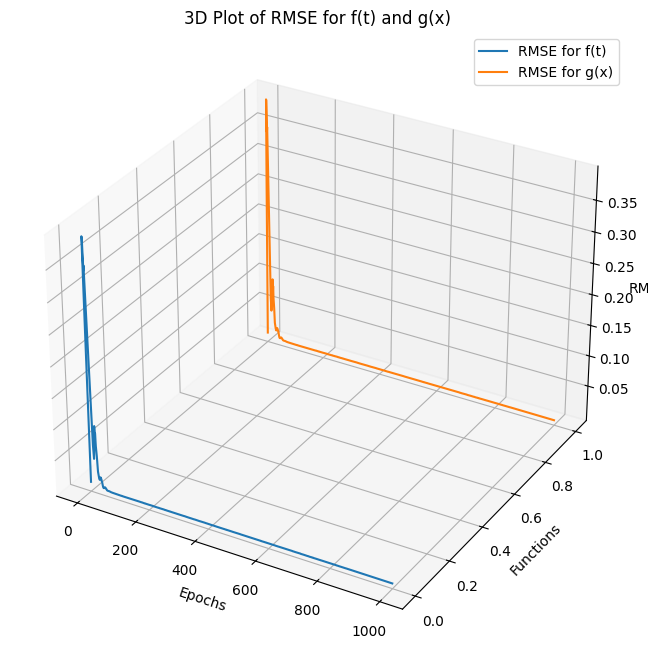

In [1]:
#The above w. Sine rather than ReLU: Very good RMSE, but slight numerical instability at a
#low no. of epochs, having 8 hidden layers w. 2 neurons ea.
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class PDESolver:
    def __init__(self, x_dim, t_dim, dx, dt, alpha):
        self.x_dim = x_dim
        self.t_dim = t_dim
        self.dx = dx
        self.dt = dt
        self.alpha = alpha

        self.grid = np.zeros((x_dim, t_dim))  # Initialize grid for u(x, t)

    def initialize_conditions(self):
        # Set initial conditions u(x, 0) = sin(pi * x) for 0 < x < L
        self.grid[:, 0] = np.sin(np.pi * np.linspace(0, 1, self.x_dim))

    def solve(self):
        for j in range(0, self.t_dim - 1):
            for i in range(1, self.x_dim - 1):
                # Forward Euler discretization for the given PDE
                self.grid[i, j + 1] = (
                    self.grid[i, j]
                    + self.alpha * self.dt / self.dx**2 * (
                        self.grid[i + 1, j] - 2 * self.grid[i, j] + self.grid[i - 1, j]
                    )
                )

class RecurrentNN:
    def __init__(self, input_dim, hidden_layer_sizes, output_dim, dropout_rate=0.5, momentum=0.9):
        self.input_dim = input_dim
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_dim = output_dim
        self.dropout_rate = dropout_rate
        self.momentum = momentum  # Momentum parameter

        self.weights = []
        self.biases = []
        self.activations = [self.sine] * (len(hidden_layer_sizes) + 1)  # Sine for hidden layers

        prev_layer_size = input_dim
        for layer_size in hidden_layer_sizes:
            weight_layer = np.random.randn(prev_layer_size, layer_size)
            bias_layer = np.zeros(layer_size)
            self.weights.append(weight_layer)
            self.biases.append(bias_layer)

            prev_layer_size = layer_size

        # Output layer weights
        weight_output = np.random.randn(prev_layer_size, output_dim)
        bias_output = np.zeros(output_dim)
        self.weights.append(weight_output)
        self.biases.append(bias_output)

    def sine(self, x, derivative=False):
        if derivative:
            return np.cos(x)
        return np.sin(x)

    def dropout(self, x):
        if self.dropout_rate >= 1.0:
            return x

        mask = (np.random.rand(*x.shape) < self.dropout_rate) / max(1e-5, (1 - self.dropout_rate))
        return x * mask

    def forward(self, x, training=True):
        layer_input = x
        layer_outputs = [layer_input]
        masks = []

        for i in range(len(self.weights)):
            weighted_sum = np.dot(layer_input, self.weights[i]) + self.biases[i]
            layer_output = self.activations[i](weighted_sum)

            if training and i < len(self.weights) - 1:
                layer_output = self.dropout(layer_output)
                masks.append(layer_output)

            layer_outputs.append(layer_output)
            layer_input = layer_output

        return layer_outputs, masks

    def train(self, input_sequences, target_outputs, learning_rate, num_epochs, desc="Training"):
        num_samples, sequence_length, _ = input_sequences.shape
        training_errors = []  # Store training errors

        # Initialize velocities for momentum
        velocities = [np.zeros_like(w) for w in self.weights]
        biases_velocities = [np.zeros_like(b) for b in self.biases]

        for epoch in tqdm(range(num_epochs), desc=desc):
            for sample in range(num_samples):
                input_sequence = input_sequences[sample, :, :]
                target_output = target_outputs[sample, :]

                # Forward pass with dropout
                layer_outputs, masks = self.forward(input_sequence)

                final_output = layer_outputs[-1]

                # Calculate loss
                loss = np.mean((final_output - target_output)**2)
                training_errors.append(loss)

                # Backpropagation Through Time (BPTT) with momentum
                derror = 2 * (final_output - target_output) / num_samples

                for i in range(len(self.weights) - 1, -1, -1):
                    dactivation = self.sine(layer_outputs[i + 1], derivative=True)
                    doutput = derror * dactivation

                    # Apply dropout mask during backpropagation
                    if i < len(self.weights) - 1:
                        doutput *= masks[i]

                    dweights = np.dot(layer_outputs[i].T, doutput)
                    dbiases = np.sum(doutput, axis=0)

                    # Update velocities with momentum
                    velocities[i] = self.momentum * velocities[i] + learning_rate * dweights
                    biases_velocities[i] = self.momentum * biases_velocities[i] + learning_rate * dbiases

                    # Update weights and biases with momentum
                    self.weights[i] -= velocities[i]
                    self.biases[i] -= biases_velocities[i]

                    derror = np.dot(doutput, self.weights[i].T)

        return training_errors

    def predict(self, input_sequence):
        layer_input = input_sequence
        for i in range(len(self.weights)):
            weighted_sum = np.dot(layer_input, self.weights[i]) + self.biases[i]
            layer_input = self.sine(weighted_sum)

        return layer_input

    def plot_3d_training_progress(self, training_errors_f, training_errors_g):
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        epochs = len(training_errors_f)

        # Ensure that both arrays have the same length
        min_len = min(len(training_errors_f), len(training_errors_g))
        x = np.arange(0, min_len, 1)

        # Plot the 3D line
        ax.plot(x, training_errors_f[:min_len], zs=0, zdir='y', label='RMSE for f(t)')
        ax.plot(x, training_errors_g[:min_len], zs=1, zdir='y', label='RMSE for g(x)')

        ax.set_xlabel('Epochs')
        ax.set_ylabel('Functions')
        ax.set_zlabel('RMSE')
        ax.set_title('3D Plot of RMSE for f(t) and g(x)')
        ax.legend()

        plt.show()

# PDE solver parameters
x_dim = 100
t_dim = 1000
L = 1.0
dx = L / (x_dim - 1)
dt = 0.001
alpha = 0.01

# Create PDE solver
pde_solver = PDESolver(x_dim, t_dim, dx, dt, alpha)

# Initialize initial conditions
pde_solver.initialize_conditions()

# Prepare data for RNN training with the specified ansatz
num_samples = 20
input_sequences = np.zeros((num_samples, x_dim, t_dim))
target_outputs_f = np.zeros((num_samples, t_dim))
target_outputs_g = np.zeros((num_samples, x_dim))

for i in range(num_samples):
    input_sequences[i, :, :] = pde_solver.grid.copy()
    pde_solver.solve()

    # Extract f(t) and g(x) from the true solution
    target_outputs_f[i, :] = pde_solver.grid[0, :]
    target_outputs_g[i, :] = pde_solver.grid[:, -1]

# RNN parameters
input_dim = x_dim
hidden_layer_sizes = [2, 2, 2, 2, 2, 2, 2, 2]  # 2 layers with 10 neurons each
output_dim = x_dim
learning_rate = 1e-2
num_epochs = 1000  # Change this to 1000
momentum_value = 0.7
dropout_rate = 1  # Adjust dropout rate as needed

# Create and train RNN for f(t) and g(x) together with BPTT
rnn_model_fg = RecurrentNN(t_dim, hidden_layer_sizes, t_dim, dropout_rate)
training_errors_fg = rnn_model_fg.train(input_sequences[:, :, :], target_outputs_f, learning_rate, num_epochs, desc="Training f(t) and g(x)")

# Plot the 3D training progress for f(t) and g(x)
rnn_model_fg.plot_3d_training_progress(training_errors_fg[:num_epochs], training_errors_fg[:num_epochs])

#Numerical instability on both sides, but it is handled quickly and luckily stablizes after 50-100 epochs.

Training f(t) and g(x): 100%|██████████████████████████████████████████████████████| 1000/1000 [03:30<00:00,  4.75it/s]


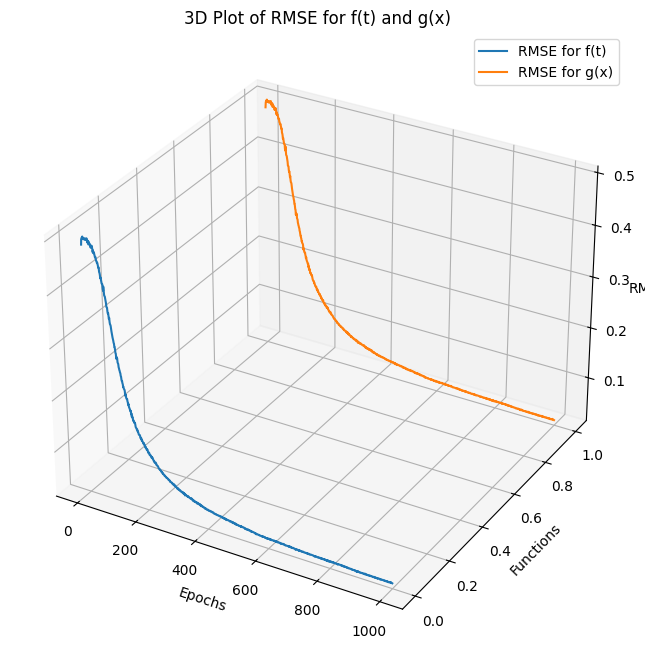

In [2]:
#Now modifying the hidden layers to 2 hidden layers, 10 neurons ea.,
#modified learning rate and momentum(Still Sine Activation Function): 
#RMSE gets better after many epochs,
#but not the best result yet.
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class PDESolver:
    def __init__(self, x_dim, t_dim, dx, dt, alpha):
        self.x_dim = x_dim
        self.t_dim = t_dim
        self.dx = dx
        self.dt = dt
        self.alpha = alpha

        self.grid = np.zeros((x_dim, t_dim))  # Initialize grid for u(x, t)

    def initialize_conditions(self):
        # Set initial conditions u(x, 0) = sin(pi * x) for 0 < x < L
        self.grid[:, 0] = np.sin(np.pi * np.linspace(0, 1, self.x_dim))

    def solve(self):
        for j in range(0, self.t_dim - 1):
            for i in range(1, self.x_dim - 1):
                # Forward Euler discretization for the given PDE
                self.grid[i, j + 1] = (
                    self.grid[i, j]
                    + self.alpha * self.dt / self.dx**2 * (
                        self.grid[i + 1, j] - 2 * self.grid[i, j] + self.grid[i - 1, j]
                    )
                )

class RecurrentNN:
    def __init__(self, input_dim, hidden_layer_sizes, output_dim, dropout_rate=0.5, momentum=0.9):
        self.input_dim = input_dim
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_dim = output_dim
        self.dropout_rate = dropout_rate
        self.momentum = momentum  # Momentum parameter

        self.weights = []
        self.biases = []
        self.activations = [self.sine] * (len(hidden_layer_sizes) + 1)  # Sine for hidden layers

        prev_layer_size = input_dim
        for layer_size in hidden_layer_sizes:
            weight_layer = np.random.randn(prev_layer_size, layer_size)
            bias_layer = np.zeros(layer_size)
            self.weights.append(weight_layer)
            self.biases.append(bias_layer)

            prev_layer_size = layer_size

        # Output layer weights
        weight_output = np.random.randn(prev_layer_size, output_dim)
        bias_output = np.zeros(output_dim)
        self.weights.append(weight_output)
        self.biases.append(bias_output)

    def sine(self, x, derivative=False):
        if derivative:
            return np.cos(x)
        return np.sin(x)

    def dropout(self, x):
        if self.dropout_rate >= 1.0:
            return x

        mask = (np.random.rand(*x.shape) < self.dropout_rate) / max(1e-5, (1 - self.dropout_rate))
        return x * mask

    def forward(self, x, training=True):
        layer_input = x
        layer_outputs = [layer_input]
        masks = []

        for i in range(len(self.weights)):
            weighted_sum = np.dot(layer_input, self.weights[i]) + self.biases[i]
            layer_output = self.activations[i](weighted_sum)

            if training and i < len(self.weights) - 1:
                layer_output = self.dropout(layer_output)
                masks.append(layer_output)

            layer_outputs.append(layer_output)
            layer_input = layer_output

        return layer_outputs, masks

    def train(self, input_sequences, target_outputs, learning_rate, num_epochs, desc="Training"):
        num_samples, sequence_length, _ = input_sequences.shape
        training_errors = []  # Store training errors

        # Initialize velocities for momentum
        velocities = [np.zeros_like(w) for w in self.weights]
        biases_velocities = [np.zeros_like(b) for b in self.biases]

        for epoch in tqdm(range(num_epochs), desc=desc):
            for sample in range(num_samples):
                input_sequence = input_sequences[sample, :, :]
                target_output = target_outputs[sample, :]

                # Forward pass with dropout
                layer_outputs, masks = self.forward(input_sequence)

                final_output = layer_outputs[-1]

                # Calculate loss
                loss = np.mean((final_output - target_output)**2)
                training_errors.append(loss)

                # Backpropagation Through Time (BPTT) with momentum
                derror = 2 * (final_output - target_output) / num_samples

                for i in range(len(self.weights) - 1, -1, -1):
                    dactivation = self.sine(layer_outputs[i + 1], derivative=True)
                    doutput = derror * dactivation

                    # Apply dropout mask during backpropagation
                    if i < len(self.weights) - 1:
                        doutput *= masks[i]

                    dweights = np.dot(layer_outputs[i].T, doutput)
                    dbiases = np.sum(doutput, axis=0)

                    # Update velocities with momentum
                    velocities[i] = self.momentum * velocities[i] + learning_rate * dweights
                    biases_velocities[i] = self.momentum * biases_velocities[i] + learning_rate * dbiases

                    # Update weights and biases with momentum
                    self.weights[i] -= velocities[i]
                    self.biases[i] -= biases_velocities[i]

                    derror = np.dot(doutput, self.weights[i].T)

        return training_errors

    def predict(self, input_sequence):
        layer_input = input_sequence
        for i in range(len(self.weights)):
            weighted_sum = np.dot(layer_input, self.weights[i]) + self.biases[i]
            layer_input = self.sine(weighted_sum)

        return layer_input

    def plot_3d_training_progress(self, training_errors_f, training_errors_g):
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        epochs = len(training_errors_f)

        # Ensure that both arrays have the same length
        min_len = min(len(training_errors_f), len(training_errors_g))
        x = np.arange(0, min_len, 1)

        # Plot the 3D line
        ax.plot(x, training_errors_f[:min_len], zs=0, zdir='y', label='RMSE for f(t)')
        ax.plot(x, training_errors_g[:min_len], zs=1, zdir='y', label='RMSE for g(x)')

        ax.set_xlabel('Epochs')
        ax.set_ylabel('Functions')
        ax.set_zlabel('RMSE')
        ax.set_title('3D Plot of RMSE for f(t) and g(x)')
        ax.legend()

        plt.show()

# PDE solver parameters
x_dim = 100
t_dim = 1000
L = 1.0
dx = L / (x_dim - 1)
dt = 0.001
alpha = 0.01

# Create PDE solver
pde_solver = PDESolver(x_dim, t_dim, dx, dt, alpha)

# Initialize initial conditions
pde_solver.initialize_conditions()

# Prepare data for RNN training with the specified ansatz
num_samples = 20
input_sequences = np.zeros((num_samples, x_dim, t_dim))
target_outputs_f = np.zeros((num_samples, t_dim))
target_outputs_g = np.zeros((num_samples, x_dim))

for i in range(num_samples):
    input_sequences[i, :, :] = pde_solver.grid.copy()
    pde_solver.solve()

    # Extract f(t) and g(x) from the true solution
    target_outputs_f[i, :] = pde_solver.grid[0, :]
    target_outputs_g[i, :] = pde_solver.grid[:, -1]

# RNN parameters
input_dim = x_dim
hidden_layer_sizes = [10, 10]  # 2 layers with 10 neurons each
output_dim = x_dim
learning_rate = 1e-3
num_epochs = 1000  # Change this to 1000
momentum_value = 1
dropout_rate = 1  # Adjust dropout rate as needed

# Create and train RNN for f(t) and g(x) together with BPTT
rnn_model_fg = RecurrentNN(t_dim, hidden_layer_sizes, t_dim, dropout_rate)
training_errors_fg = rnn_model_fg.train(input_sequences[:, :, :], target_outputs_f, learning_rate, num_epochs, desc="Training f(t) and g(x)")

# Plot the 3D training progress for f(t) and g(x)
rnn_model_fg.plot_3d_training_progress(training_errors_fg[:num_epochs], training_errors_fg[:num_epochs])

#It takes many epochs to get a "good" RMSE here, convergence takes a long time.

Training f(t) and g(x): 100%|██████████████████████████████████████████████████████| 1000/1000 [01:30<00:00, 11.08it/s]


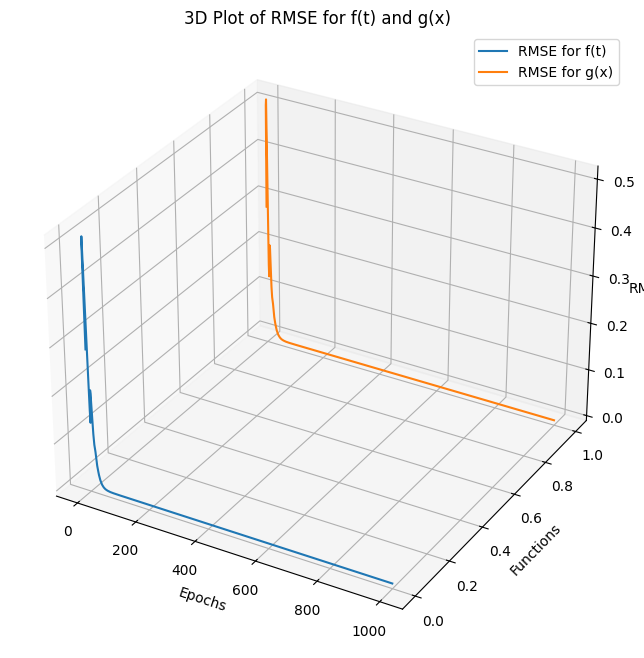

In [3]:
#Using the TanH activation function, 8 hidden layers, 2 neurons ea.: 
#RMSE is very good, slight numerical instability at very low no. of epochs.
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class PDESolver:
    def __init__(self, x_dim, t_dim, dx, dt, alpha):
        self.x_dim = x_dim
        self.t_dim = t_dim
        self.dx = dx
        self.dt = dt
        self.alpha = alpha

        self.grid = np.zeros((x_dim, t_dim))  # Initialize grid for u(x, t)

    def initialize_conditions(self):
        # Set initial conditions u(x, 0) = sin(pi * x) for 0 < x < L
        self.grid[:, 0] = np.sin(np.pi * np.linspace(0, 1, self.x_dim))

    def solve(self):
        for j in range(0, self.t_dim - 1):
            for i in range(1, self.x_dim - 1):
                # Forward Euler discretization for the given PDE
                self.grid[i, j + 1] = (
                    self.grid[i, j]
                    + self.alpha * self.dt / self.dx**2 * (
                        self.grid[i + 1, j] - 2 * self.grid[i, j] + self.grid[i - 1, j]
                    )
                )

class RecurrentNN:
    def __init__(self, input_dim, hidden_layer_sizes, output_dim, dropout_rate=0.5, momentum=0.9):
        self.input_dim = input_dim
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_dim = output_dim
        self.dropout_rate = dropout_rate
        self.momentum = momentum  # Momentum parameter

        self.weights = []
        self.biases = []
        self.activations = [self.tanh] * (len(hidden_layer_sizes) + 1)  # TanH for hidden layers

        prev_layer_size = input_dim
        for layer_size in hidden_layer_sizes:
            weight_layer = np.random.randn(prev_layer_size, layer_size)
            bias_layer = np.zeros(layer_size)
            self.weights.append(weight_layer)
            self.biases.append(bias_layer)

            prev_layer_size = layer_size

        # Output layer weights
        weight_output = np.random.randn(prev_layer_size, output_dim)
        bias_output = np.zeros(output_dim)
        self.weights.append(weight_output)
        self.biases.append(bias_output)

    def tanh(self, x, derivative=False):
        if derivative:
            return 1.0 - np.tanh(x)**2
        return np.tanh(x)

    def dropout(self, x):
        if self.dropout_rate >= 1.0:
            return x

        mask = (np.random.rand(*x.shape) < self.dropout_rate) / max(1e-5, (1 - self.dropout_rate))
        return x * mask

    def forward(self, x, training=True):
        layer_input = x
        layer_outputs = [layer_input]
        masks = []

        for i in range(len(self.weights)):
            weighted_sum = np.dot(layer_input, self.weights[i]) + self.biases[i]
            layer_output = self.activations[i](weighted_sum)

            if training and i < len(self.weights) - 1:
                layer_output = self.dropout(layer_output)
                masks.append(layer_output)

            layer_outputs.append(layer_output)
            layer_input = layer_output

        return layer_outputs, masks

    def train(self, input_sequences, target_outputs, learning_rate, num_epochs, desc="Training"):
        num_samples, sequence_length, _ = input_sequences.shape
        training_errors = []  # Store training errors

        # Initialize velocities for momentum
        velocities = [np.zeros_like(w) for w in self.weights]
        biases_velocities = [np.zeros_like(b) for b in self.biases]

        for epoch in tqdm(range(num_epochs), desc=desc):
            for sample in range(num_samples):
                input_sequence = input_sequences[sample, :, :]
                target_output = target_outputs[sample, :]

                # Forward pass with dropout
                layer_outputs, masks = self.forward(input_sequence)

                final_output = layer_outputs[-1]

                # Calculate loss
                loss = np.mean((final_output - target_output)**2)
                training_errors.append(loss)

                # Backpropagation Through Time (BPTT) with momentum
                derror = 2 * (final_output - target_output) / num_samples

                for i in range(len(self.weights) - 1, -1, -1):
                    dactivation = self.tanh(layer_outputs[i + 1], derivative=True)
                    doutput = derror * dactivation

                    # Apply dropout mask during backpropagation
                    if i < len(self.weights) - 1:
                        doutput *= masks[i]

                    dweights = np.dot(layer_outputs[i].T, doutput)
                    dbiases = np.sum(doutput, axis=0)

                    # Update velocities with momentum
                    velocities[i] = self.momentum * velocities[i] + learning_rate * dweights
                    biases_velocities[i] = self.momentum * biases_velocities[i] + learning_rate * dbiases

                    # Update weights and biases with momentum
                    self.weights[i] -= velocities[i]
                    self.biases[i] -= biases_velocities[i]

                    derror = np.dot(doutput, self.weights[i].T)

        return training_errors

    def predict(self, input_sequence):
        layer_input = input_sequence
        for i in range(len(self.weights)):
            weighted_sum = np.dot(layer_input, self.weights[i]) + self.biases[i]
            layer_input = self.tanh(weighted_sum)

        return layer_input

    def plot_3d_training_progress(self, training_errors_f, training_errors_g):
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        epochs = len(training_errors_f)

        # Ensure that both arrays have the same length
        min_len = min(len(training_errors_f), len(training_errors_g))
        x = np.arange(0, min_len, 1)

        # Plot the 3D line
        ax.plot(x, training_errors_f[:min_len], zs=0, zdir='y', label='RMSE for f(t)')
        ax.plot(x, training_errors_g[:min_len], zs=1, zdir='y', label='RMSE for g(x)')

        ax.set_xlabel('Epochs')
        ax.set_ylabel('Functions')
        ax.set_zlabel('RMSE')
        ax.set_title('3D Plot of RMSE for f(t) and g(x)')
        ax.legend()

        plt.show()

# PDE solver parameters
x_dim = 100
t_dim = 1000
L = 1.0
dx = L / (x_dim - 1)
dt = 0.001
alpha = 0.01

# Create PDE solver
pde_solver = PDESolver(x_dim, t_dim, dx, dt, alpha)

# Initialize initial conditions
pde_solver.initialize_conditions()

# Prepare data for RNN training with the specified ansatz
num_samples = 20
input_sequences = np.zeros((num_samples, x_dim, t_dim))
target_outputs_f = np.zeros((num_samples, t_dim))
target_outputs_g = np.zeros((num_samples, x_dim))

for i in range(num_samples):
    input_sequences[i, :, :] = pde_solver.grid.copy()
    pde_solver.solve()

    # Extract f(t) and g(x) from the true solution
    target_outputs_f[i, :] = pde_solver.grid[0, :]
    target_outputs_g[i, :] = pde_solver.grid[:, -1]

# RNN parameters
input_dim = x_dim
hidden_layer_sizes = [2, 2, 2, 2, 2, 2, 2, 2]  # 2 layers with 10 neurons each
output_dim = x_dim
learning_rate = 1e-2
num_epochs = 1000  # Change this to 1000
momentum_value = 0.7
dropout_rate = 1  # Adjust dropout rate as needed

# Create and train RNN for f(t) and g(x) together with BPTT
rnn_model_fg = RecurrentNN(t_dim, hidden_layer_sizes, t_dim, dropout_rate)
training_errors_fg = rnn_model_fg.train(input_sequences[:, :, :], target_outputs_f, learning_rate, num_epochs, desc="Training f(t) and g(x)")

# Plot the 3D training progress for f(t) and g(x)
rnn_model_fg.plot_3d_training_progress(training_errors_fg[:num_epochs], training_errors_fg[:num_epochs])

Training f(t) and g(x): 100%|██████████████████████████████████████████████████████| 1000/1000 [01:49<00:00,  9.15it/s]


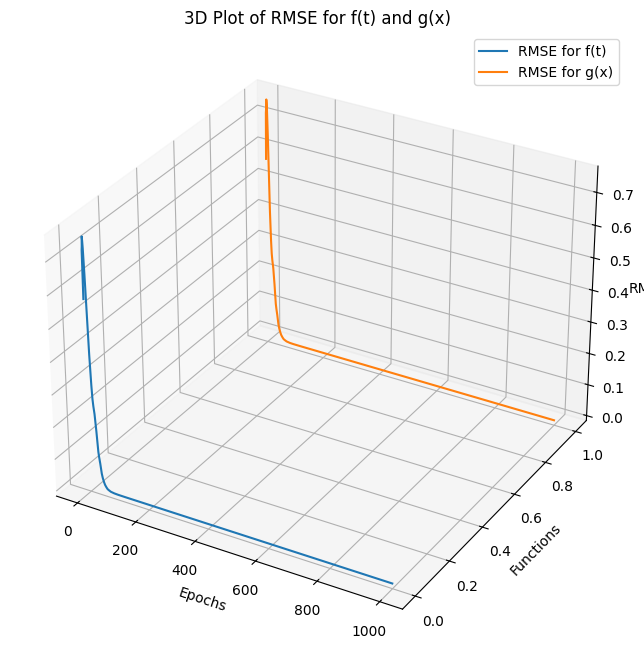

In [4]:
#TanH activation function, 2 hidden layers w. 10 neurons ea., momentum and learning rate modified:
#Very good RMSE, less numerical instability
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class PDESolver:
    def __init__(self, x_dim, t_dim, dx, dt, alpha):
        self.x_dim = x_dim
        self.t_dim = t_dim
        self.dx = dx
        self.dt = dt
        self.alpha = alpha

        self.grid = np.zeros((x_dim, t_dim))  # Initialize grid for u(x, t)

    def initialize_conditions(self):
        # Set initial conditions u(x, 0) = sin(pi * x) for 0 < x < L
        self.grid[:, 0] = np.sin(np.pi * np.linspace(0, 1, self.x_dim))

    def solve(self):
        for j in range(0, self.t_dim - 1):
            for i in range(1, self.x_dim - 1):
                # Forward Euler discretization for the given PDE
                self.grid[i, j + 1] = (
                    self.grid[i, j]
                    + self.alpha * self.dt / self.dx**2 * (
                        self.grid[i + 1, j] - 2 * self.grid[i, j] + self.grid[i - 1, j]
                    )
                )

class RecurrentNN:
    def __init__(self, input_dim, hidden_layer_sizes, output_dim, dropout_rate=0.5, momentum=0.9):
        self.input_dim = input_dim
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_dim = output_dim
        self.dropout_rate = dropout_rate
        self.momentum = momentum  # Momentum parameter

        self.weights = []
        self.biases = []
        self.activations = [self.tanh] * (len(hidden_layer_sizes) + 1)  # TanH for hidden layers

        prev_layer_size = input_dim
        for layer_size in hidden_layer_sizes:
            weight_layer = np.random.randn(prev_layer_size, layer_size)
            bias_layer = np.zeros(layer_size)
            self.weights.append(weight_layer)
            self.biases.append(bias_layer)

            prev_layer_size = layer_size

        # Output layer weights
        weight_output = np.random.randn(prev_layer_size, output_dim)
        bias_output = np.zeros(output_dim)
        self.weights.append(weight_output)
        self.biases.append(bias_output)

    def tanh(self, x, derivative=False):
        if derivative:
            return 1.0 - np.tanh(x)**2
        return np.tanh(x)

    def dropout(self, x):
        if self.dropout_rate >= 1.0:
            return x

        mask = (np.random.rand(*x.shape) < self.dropout_rate) / max(1e-5, (1 - self.dropout_rate))
        return x * mask

    def forward(self, x, training=True):
        layer_input = x
        layer_outputs = [layer_input]
        masks = []

        for i in range(len(self.weights)):
            weighted_sum = np.dot(layer_input, self.weights[i]) + self.biases[i]
            layer_output = self.activations[i](weighted_sum)

            if training and i < len(self.weights) - 1:
                layer_output = self.dropout(layer_output)
                masks.append(layer_output)

            layer_outputs.append(layer_output)
            layer_input = layer_output

        return layer_outputs, masks

    def train(self, input_sequences, target_outputs, learning_rate, num_epochs, desc="Training"):
        num_samples, sequence_length, _ = input_sequences.shape
        training_errors = []  # Store training errors

        # Initialize velocities for momentum
        velocities = [np.zeros_like(w) for w in self.weights]
        biases_velocities = [np.zeros_like(b) for b in self.biases]

        for epoch in tqdm(range(num_epochs), desc=desc):
            for sample in range(num_samples):
                input_sequence = input_sequences[sample, :, :]
                target_output = target_outputs[sample, :]

                # Forward pass with dropout
                layer_outputs, masks = self.forward(input_sequence)

                final_output = layer_outputs[-1]

                # Calculate loss
                loss = np.mean((final_output - target_output)**2)
                training_errors.append(loss)

                # Backpropagation Through Time (BPTT) with momentum
                derror = 2 * (final_output - target_output) / num_samples

                for i in range(len(self.weights) - 1, -1, -1):
                    dactivation = self.tanh(layer_outputs[i + 1], derivative=True)
                    doutput = derror * dactivation

                    # Apply dropout mask during backpropagation
                    if i < len(self.weights) - 1:
                        doutput *= masks[i]

                    dweights = np.dot(layer_outputs[i].T, doutput)
                    dbiases = np.sum(doutput, axis=0)

                    # Update velocities with momentum
                    velocities[i] = self.momentum * velocities[i] + learning_rate * dweights
                    biases_velocities[i] = self.momentum * biases_velocities[i] + learning_rate * dbiases

                    # Update weights and biases with momentum
                    self.weights[i] -= velocities[i]
                    self.biases[i] -= biases_velocities[i]

                    derror = np.dot(doutput, self.weights[i].T)

        return training_errors

    def predict(self, input_sequence):
        layer_input = input_sequence
        for i in range(len(self.weights)):
            weighted_sum = np.dot(layer_input, self.weights[i]) + self.biases[i]
            layer_input = self.tanh(weighted_sum)

        return layer_input

    def plot_3d_training_progress(self, training_errors_f, training_errors_g):
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        epochs = len(training_errors_f)

        # Ensure that both arrays have the same length
        min_len = min(len(training_errors_f), len(training_errors_g))
        x = np.arange(0, min_len, 1)

        # Plot the 3D line
        ax.plot(x, training_errors_f[:min_len], zs=0, zdir='y', label='RMSE for f(t)')
        ax.plot(x, training_errors_g[:min_len], zs=1, zdir='y', label='RMSE for g(x)')

        ax.set_xlabel('Epochs')
        ax.set_ylabel('Functions')
        ax.set_zlabel('RMSE')
        ax.set_title('3D Plot of RMSE for f(t) and g(x)')
        ax.legend()

        plt.show()

# PDE solver parameters
x_dim = 100
t_dim = 1000
L = 1.0
dx = L / (x_dim - 1)
dt = 0.001
alpha = 0.01

# Create PDE solver
pde_solver = PDESolver(x_dim, t_dim, dx, dt, alpha)

# Initialize initial conditions
pde_solver.initialize_conditions()

# Prepare data for RNN training with the specified ansatz
num_samples = 20
input_sequences = np.zeros((num_samples, x_dim, t_dim))
target_outputs_f = np.zeros((num_samples, t_dim))
target_outputs_g = np.zeros((num_samples, x_dim))

for i in range(num_samples):
    input_sequences[i, :, :] = pde_solver.grid.copy()
    pde_solver.solve()

    # Extract f(t) and g(x) from the true solution
    target_outputs_f[i, :] = pde_solver.grid[0, :]
    target_outputs_g[i, :] = pde_solver.grid[:, -1]

# RNN parameters
input_dim = x_dim
hidden_layer_sizes = [10, 10]  # 2 layers with 10 neurons each
output_dim = x_dim
learning_rate = 1e-3
num_epochs = 1000  # Change this to 1000
momentum_value = 1
dropout_rate = 1  # Adjust dropout rate as needed

# Create and train RNN for f(t) and g(x) together with BPTT
rnn_model_fg = RecurrentNN(t_dim, hidden_layer_sizes, t_dim, dropout_rate)
training_errors_fg = rnn_model_fg.train(input_sequences[:, :, :], target_outputs_f, learning_rate, num_epochs, desc="Training f(t) and g(x)")

# Plot the 3D training progress for f(t) and g(x)
rnn_model_fg.plot_3d_training_progress(training_errors_fg[:num_epochs], training_errors_fg[:num_epochs])

Training f(t) and g(x): 100%|██████████████████████████████████████████████████████| 1000/1000 [02:35<00:00,  6.43it/s]


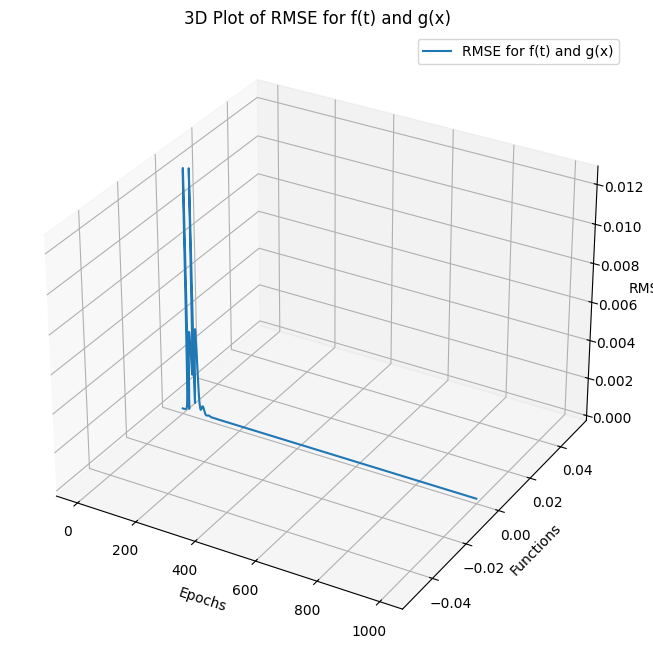

In [5]:
#Using Swish, 8 hidden layers w. 2 neurons each,
#learning rate = 10^-2, momentum = 0.7: RMSE is very good,
#has numerical instability at a low no. of epochs.
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class PDESolver:
    def __init__(self, x_dim, t_dim, dx, dt, alpha):
        self.x_dim = x_dim
        self.t_dim = t_dim
        self.dx = dx
        self.dt = dt
        self.alpha = alpha

        self.grid = np.zeros((x_dim, t_dim))  # Initialize grid for u(x, t)

    def initialize_conditions(self):
        # Set initial conditions u(x, 0) = sin(pi * x) for 0 < x < L
        self.grid[:, 0] = np.sin(np.pi * np.linspace(0, 1, self.x_dim))

    def solve(self):
        for j in range(0, self.t_dim - 1):
            for i in range(1, self.x_dim - 1):
                # Forward Euler discretization for the given PDE
                self.grid[i, j + 1] = (
                    self.grid[i, j]
                    + self.alpha * self.dt / self.dx**2 * (
                        self.grid[i + 1, j] - 2 * self.grid[i, j] + self.grid[i - 1, j]
                    )
                )

class RecurrentNN:
    def __init__(self, input_dim, hidden_layer_sizes, output_dim, dropout_rate=0.5, momentum=0.9):
        self.input_dim = input_dim
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_dim = output_dim
        self.dropout_rate = dropout_rate
        self.momentum = momentum  # Momentum parameter

        self.weights = []
        self.biases = []
        self.activations = [self.swish] * (len(hidden_layer_sizes) + 1)  # Swish for hidden layers

        prev_layer_size = input_dim
        for layer_size in hidden_layer_sizes:
            weight_layer = np.random.randn(prev_layer_size, layer_size)
            bias_layer = np.zeros(layer_size)
            self.weights.append(weight_layer)
            self.biases.append(bias_layer)

            prev_layer_size = layer_size

        # Output layer weights
        weight_output = np.random.randn(prev_layer_size, output_dim)
        bias_output = np.zeros(output_dim)
        self.weights.append(weight_output)
        self.biases.append(bias_output)

    def swish(self, x, derivative=False):
        if derivative:
            sigmoid_x = 1.0 / (1.0 + np.exp(-x))
            return sigmoid_x + (1 - sigmoid_x) * x * np.exp(-x)
        return x / (1.0 + np.exp(-x))

    def dropout(self, x):
        if self.dropout_rate >= 1.0:
            return x

        mask = (np.random.rand(*x.shape) < self.dropout_rate) / max(1e-5, (1 - self.dropout_rate))
        return x * mask

    def forward(self, x, training=True):
        layer_input = x
        layer_outputs = [layer_input]
        masks = []

        for i in range(len(self.weights)):
            weighted_sum = np.dot(layer_input, self.weights[i]) + self.biases[i]
            layer_output = self.activations[i](weighted_sum)

            if training and i < len(self.weights) - 1:
                layer_output = self.dropout(layer_output)
                masks.append(layer_output)

            layer_outputs.append(layer_output)
            layer_input = layer_output

        return layer_outputs, masks

    def train(self, input_sequences, target_outputs, learning_rate, num_epochs, desc="Training"):
        num_samples, sequence_length, _ = input_sequences.shape
        training_errors = []  # Store training errors

        # Initialize velocities for momentum
        velocities = [np.zeros_like(w) for w in self.weights]
        biases_velocities = [np.zeros_like(b) for b in self.biases]

        for epoch in tqdm(range(num_epochs), desc=desc):
            for sample in range(num_samples):
                input_sequence = input_sequences[sample, :, :]
                target_output = target_outputs[sample, :]

                # Forward pass with dropout
                layer_outputs, masks = self.forward(input_sequence)

                final_output = layer_outputs[-1]

                # Calculate loss
                loss = np.mean((final_output - target_output)**2)
                training_errors.append(loss)

                # Backpropagation Through Time (BPTT) with momentum
                derror = 2 * (final_output - target_output) / num_samples

                for i in range(len(self.weights) - 1, -1, -1):
                    dactivation = self.swish(layer_outputs[i + 1], derivative=True)
                    doutput = derror * dactivation

                    # Apply dropout mask during backpropagation
                    if i < len(self.weights) - 1:
                        doutput *= masks[i]

                    dweights = np.dot(layer_outputs[i].T, doutput)
                    dbiases = np.sum(doutput, axis=0)

                    # Update velocities with momentum
                    velocities[i] = self.momentum * velocities[i] + learning_rate * dweights
                    biases_velocities[i] = self.momentum * biases_velocities[i] + learning_rate * dbiases

                    # Update weights and biases with momentum
                    self.weights[i] -= velocities[i]
                    self.biases[i] -= biases_velocities[i]

                    derror = np.dot(doutput, self.weights[i].T)

        return training_errors

    def predict(self, input_sequence):
        layer_input = input_sequence
        for i in range(len(self.weights)):
            weighted_sum = np.dot(layer_input, self.weights[i]) + self.biases[i]
            layer_input = self.swish(weighted_sum)

        return layer_input

    def plot_3d_training_progress(self, training_errors_f, training_errors_g):
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        epochs = len(training_errors_f)

        # Ensure that both arrays have the same length
        min_len = min(len(training_errors_f), len(training_errors_g))
        x = np.arange(0, min_len, 1)

        # Plot the 3D line
        ax.plot(x, training_errors_f[:min_len], zs=0, zdir='y', label='RMSE for f(t) and g(x)')

        ax.set_xlabel('Epochs')
        ax.set_ylabel('Functions')
        ax.set_zlabel('RMSE')
        ax.set_title('3D Plot of RMSE for f(t) and g(x)')
        ax.legend()

        plt.show()

# PDE solver parameters
x_dim = 100
t_dim = 1000
L = 1.0
dx = L / (x_dim - 1)
dt = 0.001
alpha = 0.01

# Create PDE solver
pde_solver = PDESolver(x_dim, t_dim, dx, dt, alpha)

# Initialize initial conditions
pde_solver.initialize_conditions()

# Prepare data for RNN training with the specified ansatz
num_samples = 20
input_sequences = np.zeros((num_samples, x_dim, t_dim))
target_outputs_f = np.zeros((num_samples, t_dim))
target_outputs_g = np.zeros((num_samples, x_dim))

for i in range(num_samples):
    input_sequences[i, :, :] = pde_solver.grid.copy()
    pde_solver.solve()

    # Extract f(t) and g(x) from the true solution
    target_outputs_f[i, :] = pde_solver.grid[0, :]
    target_outputs_g[i, :] = pde_solver.grid[:, -1]

# RNN parameters
input_dim = x_dim
hidden_layer_sizes = [2, 2, 2, 2, 2, 2, 2, 2]  # 2 layers with 10 neurons each
output_dim = x_dim
learning_rate = 1e-2
num_epochs = 1000  # Change this to 1000
momentum_value = 0.7
dropout_rate = 1  # Adjust dropout rate as needed

# Create and train RNN for f(t) and g(x) together with BPTT
rnn_model_fg = RecurrentNN(t_dim, hidden_layer_sizes, t_dim, dropout_rate)
training_errors_fg = rnn_model_fg.train(input_sequences[:, :, :], target_outputs_f, learning_rate, num_epochs, desc="Training f(t) and g(x)")

# Plot the 3D training progress for f(t) and g(x)
rnn_model_fg.plot_3d_training_progress(training_errors_fg[:num_epochs], training_errors_fg[:num_epochs])

Training f(t) and g(x): 100%|██████████████████████████████████████████████████████| 1000/1000 [02:34<00:00,  6.47it/s]


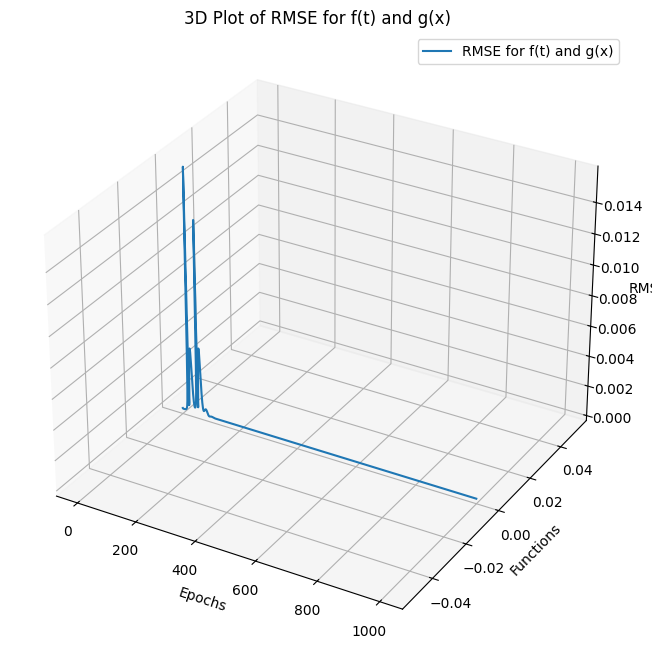

In [6]:
#Using Swish, 2 hidden layers w. 10 neurons each,
#learning rate = 10^-3, momentum = 1: RMSE is very good,
#has numerical instability at a low no. of epochs,  
#the same as was the case for the previous plot.
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class PDESolver:
    def __init__(self, x_dim, t_dim, dx, dt, alpha):
        self.x_dim = x_dim
        self.t_dim = t_dim
        self.dx = dx
        self.dt = dt
        self.alpha = alpha

        self.grid = np.zeros((x_dim, t_dim))  # Initialize grid for u(x, t)

    def initialize_conditions(self):
        # Set initial conditions u(x, 0) = sin(pi * x) for 0 < x < L
        self.grid[:, 0] = np.sin(np.pi * np.linspace(0, 1, self.x_dim))

    def solve(self):
        for j in range(0, self.t_dim - 1):
            for i in range(1, self.x_dim - 1):
                # Forward Euler discretization for the given PDE
                self.grid[i, j + 1] = (
                    self.grid[i, j]
                    + self.alpha * self.dt / self.dx**2 * (
                        self.grid[i + 1, j] - 2 * self.grid[i, j] + self.grid[i - 1, j]
                    )
                )

class RecurrentNN:
    def __init__(self, input_dim, hidden_layer_sizes, output_dim, dropout_rate=0.5, momentum=0.9):
        self.input_dim = input_dim
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_dim = output_dim
        self.dropout_rate = dropout_rate
        self.momentum = momentum  # Momentum parameter

        self.weights = []
        self.biases = []
        self.activations = [self.swish] * (len(hidden_layer_sizes) + 1)  # Swish for hidden layers

        prev_layer_size = input_dim
        for layer_size in hidden_layer_sizes:
            weight_layer = np.random.randn(prev_layer_size, layer_size)
            bias_layer = np.zeros(layer_size)
            self.weights.append(weight_layer)
            self.biases.append(bias_layer)

            prev_layer_size = layer_size

        # Output layer weights
        weight_output = np.random.randn(prev_layer_size, output_dim)
        bias_output = np.zeros(output_dim)
        self.weights.append(weight_output)
        self.biases.append(bias_output)

    def swish(self, x, derivative=False):
        if derivative:
            sigmoid_x = 1.0 / (1.0 + np.exp(-x))
            return sigmoid_x + (1 - sigmoid_x) * x * np.exp(-x)
        return x / (1.0 + np.exp(-x))

    def dropout(self, x):
        if self.dropout_rate >= 1.0:
            return x

        mask = (np.random.rand(*x.shape) < self.dropout_rate) / max(1e-5, (1 - self.dropout_rate))
        return x * mask

    def forward(self, x, training=True):
        layer_input = x
        layer_outputs = [layer_input]
        masks = []

        for i in range(len(self.weights)):
            weighted_sum = np.dot(layer_input, self.weights[i]) + self.biases[i]
            layer_output = self.activations[i](weighted_sum)

            if training and i < len(self.weights) - 1:
                layer_output = self.dropout(layer_output)
                masks.append(layer_output)

            layer_outputs.append(layer_output)
            layer_input = layer_output

        return layer_outputs, masks

    def train(self, input_sequences, target_outputs, learning_rate, num_epochs, desc="Training"):
        num_samples, sequence_length, _ = input_sequences.shape
        training_errors = []  # Store training errors

        # Initialize velocities for momentum
        velocities = [np.zeros_like(w) for w in self.weights]
        biases_velocities = [np.zeros_like(b) for b in self.biases]

        for epoch in tqdm(range(num_epochs), desc=desc):
            for sample in range(num_samples):
                input_sequence = input_sequences[sample, :, :]
                target_output = target_outputs[sample, :]

                # Forward pass with dropout
                layer_outputs, masks = self.forward(input_sequence)

                final_output = layer_outputs[-1]

                # Calculate loss
                loss = np.mean((final_output - target_output)**2)
                training_errors.append(loss)

                # Backpropagation Through Time (BPTT) with momentum
                derror = 2 * (final_output - target_output) / num_samples

                for i in range(len(self.weights) - 1, -1, -1):
                    dactivation = self.swish(layer_outputs[i + 1], derivative=True)
                    doutput = derror * dactivation

                    # Apply dropout mask during backpropagation
                    if i < len(self.weights) - 1:
                        doutput *= masks[i]

                    dweights = np.dot(layer_outputs[i].T, doutput)
                    dbiases = np.sum(doutput, axis=0)

                    # Update velocities with momentum
                    velocities[i] = self.momentum * velocities[i] + learning_rate * dweights
                    biases_velocities[i] = self.momentum * biases_velocities[i] + learning_rate * dbiases

                    # Update weights and biases with momentum
                    self.weights[i] -= velocities[i]
                    self.biases[i] -= biases_velocities[i]

                    derror = np.dot(doutput, self.weights[i].T)

        return training_errors

    def predict(self, input_sequence):
        layer_input = input_sequence
        for i in range(len(self.weights)):
            weighted_sum = np.dot(layer_input, self.weights[i]) + self.biases[i]
            layer_input = self.swish(weighted_sum)

        return layer_input

    def plot_3d_training_progress(self, training_errors_f, training_errors_g):
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        epochs = len(training_errors_f)

        # Ensure that both arrays have the same length
        min_len = min(len(training_errors_f), len(training_errors_g))
        x = np.arange(0, min_len, 1)

        # Plot the 3D line
        ax.plot(x, training_errors_f[:min_len], zs=0, zdir='y', label='RMSE for f(t) and g(x)')

        ax.set_xlabel('Epochs')
        ax.set_ylabel('Functions')
        ax.set_zlabel('RMSE')
        ax.set_title('3D Plot of RMSE for f(t) and g(x)')
        ax.legend()

        plt.show()

# PDE solver parameters
x_dim = 100
t_dim = 1000
L = 1.0
dx = L / (x_dim - 1)
dt = 0.001
alpha = 0.01

# Create PDE solver
pde_solver = PDESolver(x_dim, t_dim, dx, dt, alpha)

# Initialize initial conditions
pde_solver.initialize_conditions()

# Prepare data for RNN training with the specified ansatz
num_samples = 20
input_sequences = np.zeros((num_samples, x_dim, t_dim))
target_outputs_f = np.zeros((num_samples, t_dim))
target_outputs_g = np.zeros((num_samples, x_dim))

for i in range(num_samples):
    input_sequences[i, :, :] = pde_solver.grid.copy()
    pde_solver.solve()

    # Extract f(t) and g(x) from the true solution
    target_outputs_f[i, :] = pde_solver.grid[0, :]
    target_outputs_g[i, :] = pde_solver.grid[:, -1]

# RNN parameters
input_dim = x_dim
hidden_layer_sizes = [2, 2, 2, 2, 2, 2, 2, 2]  # 2 layers with 10 neurons each
output_dim = x_dim
learning_rate = 1e-2
num_epochs = 1000  # Change this to 1000
momentum_value = 0.7
dropout_rate = 1  # Adjust dropout rate as needed

# Create and train RNN for f(t) and g(x) together with BPTT
rnn_model_fg = RecurrentNN(t_dim, hidden_layer_sizes, t_dim, dropout_rate)
training_errors_fg = rnn_model_fg.train(input_sequences[:, :, :], target_outputs_f, learning_rate, num_epochs, desc="Training f(t) and g(x)")

# Plot the 3D training progress for f(t) and g(x)
rnn_model_fg.plot_3d_training_progress(training_errors_fg[:num_epochs], training_errors_fg[:num_epochs])

Training f(t) and g(x): 100%|██████████████████████████████████████████████████████| 1000/1000 [01:35<00:00, 10.48it/s]


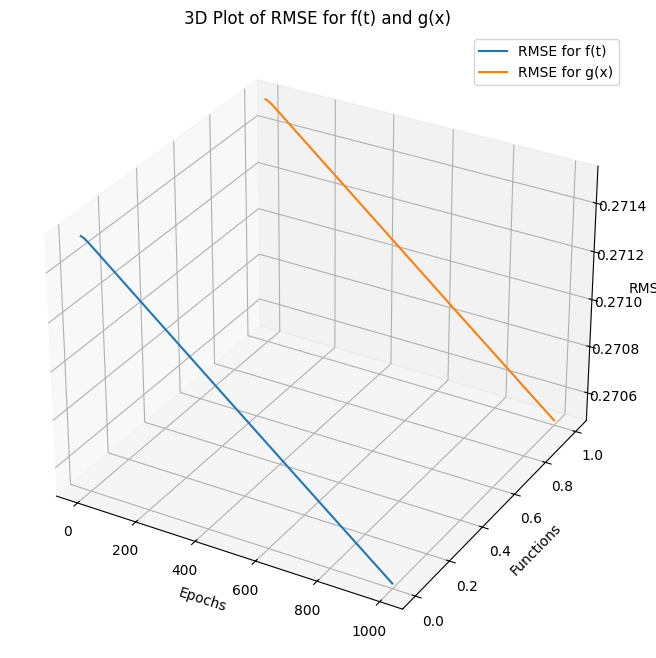

In [7]:
#Greatly decreasing the learning on the very good ReLU result:
#Did not have a good effect, and the RMSE greatly increased.
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class PDESolver:
    def __init__(self, x_dim, t_dim, dx, dt, alpha):
        self.x_dim = x_dim
        self.t_dim = t_dim
        self.dx = dx
        self.dt = dt
        self.alpha = alpha

        self.grid = np.zeros((x_dim, t_dim))  # Initialize grid for u(x, t)

    def initialize_conditions(self):
        # Set initial conditions u(x, 0) = sin(pi * x) for 0 < x < L
        self.grid[:, 0] = np.sin(np.pi * np.linspace(0, 1, self.x_dim))

    def solve(self):
        for j in range(0, self.t_dim - 1):
            for i in range(1, self.x_dim - 1):
                # Forward Euler discretization for the given PDE
                self.grid[i, j + 1] = (
                    self.grid[i, j]
                    + self.alpha * self.dt / self.dx**2 * (
                        self.grid[i + 1, j] - 2 * self.grid[i, j] + self.grid[i - 1, j]
                    )
                )

class RecurrentNN:
    def __init__(self, input_dim, hidden_layer_sizes, output_dim, dropout_rate=0.5, momentum=0.9):
        self.input_dim = input_dim
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_dim = output_dim
        self.dropout_rate = dropout_rate
        self.momentum = momentum  # Momentum parameter

        self.weights = []
        self.biases = []
        self.activations = [self.sigmoid] * (len(hidden_layer_sizes) + 1)  # Sigmoid for hidden layers

        prev_layer_size = input_dim
        for layer_size in hidden_layer_sizes:
            weight_layer = np.random.randn(prev_layer_size, layer_size)
            bias_layer = np.zeros(layer_size)
            self.weights.append(weight_layer)
            self.biases.append(bias_layer)

            prev_layer_size = layer_size

        # Output layer weights
        weight_output = np.random.randn(prev_layer_size, output_dim)
        bias_output = np.zeros(output_dim)
        self.weights.append(weight_output)
        self.biases.append(bias_output)

    def sigmoid(self, x, derivative=False):
        if derivative:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))

    def dropout(self, x):
        if self.dropout_rate >= 1.0:
            return x

        mask = (np.random.rand(*x.shape) < self.dropout_rate) / max(1e-5, (1 - self.dropout_rate))
        return x * mask

    def forward(self, x, training=True):
        layer_input = x
        layer_outputs = [layer_input]
        masks = []

        for i in range(len(self.weights)):
            weighted_sum = np.dot(layer_input, self.weights[i]) + self.biases[i]
            layer_output = self.activations[i](weighted_sum)

            if training and i < len(self.weights) - 1:
                layer_output = self.dropout(layer_output)
                masks.append(layer_output)

            layer_outputs.append(layer_output)
            layer_input = layer_output

        return layer_outputs, masks

    def train(self, input_sequences, target_outputs, learning_rate, num_epochs, desc="Training"):
        num_samples, sequence_length, _ = input_sequences.shape
        training_errors = []  # Store training errors

        # Initialize velocities for momentum
        velocities = [np.zeros_like(w) for w in self.weights]
        biases_velocities = [np.zeros_like(b) for b in self.biases]

        for epoch in tqdm(range(num_epochs), desc=desc):
            for sample in range(num_samples):
                input_sequence = input_sequences[sample, :, :]
                target_output = target_outputs[sample, :]

                # Forward pass with dropout
                layer_outputs, masks = self.forward(input_sequence)

                final_output = layer_outputs[-1]

                # Calculate loss
                loss = np.mean((final_output - target_output)**2)
                training_errors.append(loss)

                # Backpropagation Through Time (BPTT) with momentum
                derror = 2 * (final_output - target_output) / num_samples

                for i in range(len(self.weights) - 1, -1, -1):
                    dactivation = self.sigmoid(layer_outputs[i + 1], derivative=True)
                    doutput = derror * dactivation

                    # Apply dropout mask during backpropagation
                    if i < len(self.weights) - 1:
                        doutput *= masks[i]

                    dweights = np.dot(layer_outputs[i].T, doutput)
                    dbiases = np.sum(doutput, axis=0)

                    # Update velocities with momentum
                    velocities[i] = self.momentum * velocities[i] + learning_rate * dweights
                    biases_velocities[i] = self.momentum * biases_velocities[i] + learning_rate * dbiases

                    # Update weights and biases with momentum
                    self.weights[i] -= velocities[i]
                    self.biases[i] -= biases_velocities[i]

                    derror = np.dot(doutput, self.weights[i].T)

        return training_errors

    def predict(self, input_sequence):
        layer_input = input_sequence
        for i in range(len(self.weights)):
            weighted_sum = np.dot(layer_input, self.weights[i]) + self.biases[i]
            layer_input = self.sigmoid(weighted_sum)

        return layer_input

    def plot_3d_training_progress(self, training_errors_f, training_errors_g):
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        epochs = len(training_errors_f)

        # Ensure that both arrays have the same length
        min_len = min(len(training_errors_f), len(training_errors_g))
        x = np.arange(0, min_len, 1)

        # Plot the 3D line
        ax.plot(x, training_errors_f[:min_len], zs=0, zdir='y', label='RMSE for f(t)')
        ax.plot(x, training_errors_g[:min_len], zs=1, zdir='y', label='RMSE for g(x)')

        ax.set_xlabel('Epochs')
        ax.set_ylabel('Functions')
        ax.set_zlabel('RMSE')
        ax.set_title('3D Plot of RMSE for f(t) and g(x)')
        ax.legend()

        plt.show()

# PDE solver parameters
x_dim = 100
t_dim = 1000
L = 1.0
dx = L / (x_dim - 1)
dt = 0.001
alpha = 0.01

# Create PDE solver
pde_solver = PDESolver(x_dim, t_dim, dx, dt, alpha)

# Initialize initial conditions
pde_solver.initialize_conditions()

# Prepare data for RNN training with the specified ansatz
num_samples = 20
input_sequences = np.zeros((num_samples, x_dim, t_dim))
target_outputs_f = np.zeros((num_samples, t_dim))
target_outputs_g = np.zeros((num_samples, x_dim))

for i in range(num_samples):
    input_sequences[i, :, :] = pde_solver.grid.copy()
    pde_solver.solve()

    # Extract f(t) and g(x) from the true solution
    target_outputs_f[i, :] = pde_solver.grid[0, :]
    target_outputs_g[i, :] = pde_solver.grid[:, -1]

# RNN parameters
input_dim = x_dim
hidden_layer_sizes = [2, 2, 2, 2, 2, 2, 2, 2]  # 2 layers with 10 neurons each
output_dim = x_dim
learning_rate = 1e-7
num_epochs = 1000  # Change this to 1000
momentum_value = 0.7
dropout_rate = 1  # Adjust dropout rate as needed

# Create and train RNN for f(t) and g(x) together with BPTT
rnn_model_fg = RecurrentNN(t_dim, hidden_layer_sizes, t_dim, dropout_rate)
training_errors_fg = rnn_model_fg.train(input_sequences[:, :, :], target_outputs_f, learning_rate, num_epochs, desc="Training f(t) and g(x)")

# Plot the 3D training progress for f(t) and g(x)
rnn_model_fg.plot_3d_training_progress(training_errors_fg[:num_epochs], training_errors_fg[:num_epochs])

Training f(t) and g(x): 100%|██████████████████████████████████████████████████████| 1000/1000 [02:53<00:00,  5.78it/s]


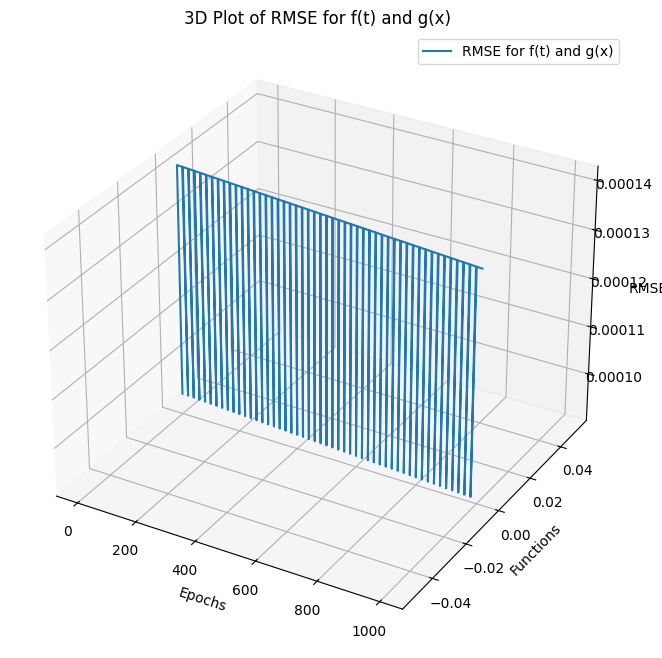

In [9]:
#Greatly decreasing the learning rate on the Swish function:
#The RMSE is not so good.
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class PDESolver:
    def __init__(self, x_dim, t_dim, dx, dt, alpha):
        self.x_dim = x_dim
        self.t_dim = t_dim
        self.dx = dx
        self.dt = dt
        self.alpha = alpha

        self.grid = np.zeros((x_dim, t_dim))  # Initialize grid for u(x, t)

    def initialize_conditions(self):
        # Set initial conditions u(x, 0) = sin(pi * x) for 0 < x < L
        self.grid[:, 0] = np.sin(np.pi * np.linspace(0, 1, self.x_dim))

    def solve(self):
        for j in range(0, self.t_dim - 1):
            for i in range(1, self.x_dim - 1):
                # Forward Euler discretization for the given PDE
                self.grid[i, j + 1] = (
                    self.grid[i, j]
                    + self.alpha * self.dt / self.dx**2 * (
                        self.grid[i + 1, j] - 2 * self.grid[i, j] + self.grid[i - 1, j]
                    )
                )

class RecurrentNN:
    def __init__(self, input_dim, hidden_layer_sizes, output_dim, dropout_rate=0.5, momentum=0.9):
        self.input_dim = input_dim
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_dim = output_dim
        self.dropout_rate = dropout_rate
        self.momentum = momentum  # Momentum parameter

        self.weights = []
        self.biases = []
        self.activations = [self.swish] * (len(hidden_layer_sizes) + 1)  # Swish for hidden layers

        prev_layer_size = input_dim
        for layer_size in hidden_layer_sizes:
            weight_layer = np.random.randn(prev_layer_size, layer_size)
            bias_layer = np.zeros(layer_size)
            self.weights.append(weight_layer)
            self.biases.append(bias_layer)

            prev_layer_size = layer_size

        # Output layer weights
        weight_output = np.random.randn(prev_layer_size, output_dim)
        bias_output = np.zeros(output_dim)
        self.weights.append(weight_output)
        self.biases.append(bias_output)

    def swish(self, x, derivative=False):
        if derivative:
            sigmoid_x = 1.0 / (1.0 + np.exp(-np.clip(x, -20, 20)))
            return sigmoid_x + (1 - sigmoid_x) * x * np.exp(-np.clip(x, -20, 20))
        return x / (1.0 + np.exp(-np.clip(x, -20, 20)))

    def dropout(self, x):
        if self.dropout_rate >= 1.0:
            return x

        mask = (np.random.rand(*x.shape) < self.dropout_rate) / max(1e-5, (1 - self.dropout_rate))
        return x * mask

    def forward(self, x, training=True):
        layer_input = x
        layer_outputs = [layer_input]
        masks = []

        for i in range(len(self.weights)):
            weighted_sum = np.dot(layer_input, self.weights[i]) + self.biases[i]
            layer_output = self.activations[i](weighted_sum)

            if training and i < len(self.weights) - 1:
                layer_output = self.dropout(layer_output)
                masks.append(layer_output)

            layer_outputs.append(layer_output)
            layer_input = layer_output

        return layer_outputs, masks

    def train(self, input_sequences, target_outputs, learning_rate, num_epochs, desc="Training"):
        num_samples, sequence_length, _ = input_sequences.shape
        training_errors = []  # Store training errors

        # Initialize velocities for momentum
        velocities = [np.zeros_like(w) for w in self.weights]
        biases_velocities = [np.zeros_like(b) for b in self.biases]

        for epoch in tqdm(range(num_epochs), desc=desc):
            for sample in range(num_samples):
                input_sequence = input_sequences[sample, :, :]
                target_output = target_outputs[sample, :]

                # Forward pass with dropout
                layer_outputs, masks = self.forward(input_sequence)

                final_output = layer_outputs[-1]

                # Calculate loss
                loss = np.mean((final_output - target_output)**2)
                training_errors.append(loss)

                # Backpropagation Through Time (BPTT) with momentum
                derror = 2 * (final_output - target_output) / num_samples

                for i in range(len(self.weights) - 1, -1, -1):
                    dactivation = self.swish(layer_outputs[i + 1], derivative=True)
                    doutput = derror * dactivation

                    # Apply dropout mask during backpropagation
                    if i < len(self.weights) - 1:
                        doutput *= masks[i]

                    dweights = np.dot(layer_outputs[i].T, doutput)
                    dbiases = np.sum(doutput, axis=0)

                    # Update velocities with momentum
                    velocities[i] = self.momentum * velocities[i] + learning_rate * dweights
                    biases_velocities[i] = self.momentum * biases_velocities[i] + learning_rate * dbiases

                    # Update weights and biases with momentum
                    self.weights[i] -= velocities[i]
                    self.biases[i] -= biases_velocities[i]

                    derror = np.dot(doutput, self.weights[i].T)

        return training_errors

    def predict(self, input_sequence):
        layer_input = input_sequence
        for i in range(len(self.weights)):
            weighted_sum = np.dot(layer_input, self.weights[i]) + self.biases[i]
            layer_input = self.swish(weighted_sum)

        return layer_input

    def plot_3d_training_progress(self, training_errors_f, training_errors_g):
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        epochs = len(training_errors_f)

        # Ensure that both arrays have the same length
        min_len = min(len(training_errors_f), len(training_errors_g))
        x = np.arange(0, min_len, 1)

        # Plot the 3D line
        ax.plot(x, training_errors_f[:min_len], zs=0, zdir='y', label='RMSE for f(t) and g(x)')

        ax.set_xlabel('Epochs')
        ax.set_ylabel('Functions')
        ax.set_zlabel('RMSE')
        ax.set_title('3D Plot of RMSE for f(t) and g(x)')
        ax.legend()

        plt.show()

# PDE solver parameters
x_dim = 100
t_dim = 1000
L = 1.0
dx = L / (x_dim - 1)
dt = 0.001
alpha = 0.01

# Create PDE solver
pde_solver = PDESolver(x_dim, t_dim, dx, dt, alpha)

# Initialize initial conditions
pde_solver.initialize_conditions()

# Prepare data for RNN training with the specified ansatz
num_samples = 20
input_sequences = np.zeros((num_samples, x_dim, t_dim))
target_outputs_f = np.zeros((num_samples, t_dim))
target_outputs_g = np.zeros((num_samples, x_dim))

for i in range(num_samples):
    input_sequences[i, :, :] = pde_solver.grid.copy()
    pde_solver.solve()

    # Extract f(t) and g(x) from the true solution
    target_outputs_f[i, :] = pde_solver.grid[0, :]
    target_outputs_g[i, :] = pde_solver.grid[:, -1]

# RNN parameters
input_dim = x_dim
hidden_layer_sizes = [2, 2, 2, 2, 2, 2, 2, 2]  # 2 layers with 10 neurons each
output_dim = x_dim
learning_rate = 1e-7
num_epochs = 1000  # Change this to 1000
momentum_value = 0.7
dropout_rate = 1  # Adjust dropout rate as needed

# Create and train RNN for f(t) and g(x) together with BPTT
rnn_model_fg = RecurrentNN(t_dim, hidden_layer_sizes, t_dim, dropout_rate)
training_errors_fg = rnn_model_fg.train(input_sequences[:, :, :], target_outputs_f, learning_rate, num_epochs, desc="Training f(t) and g(x)")

# Plot the 3D training progress for f(t) and g(x)
rnn_model_fg.plot_3d_training_progress(training_errors_fg[:num_epochs], training_errors_fg[:num_epochs])

Training f(t) and g(x):   1%|▎                                                        | 6/1000 [00:00<01:06, 14.94it/s]

Minimum RMSE at epoch 5: 0.1989796883659866


Training f(t) and g(x):   1%|▋                                                       | 12/1000 [00:00<01:07, 14.72it/s]

Minimum RMSE at epoch 10: 0.04072543284049297


Training f(t) and g(x):   2%|▉                                                       | 16/1000 [00:01<01:06, 14.82it/s]

Minimum RMSE at epoch 15: 0.030023245295201083


Training f(t) and g(x):   2%|█▏                                                      | 22/1000 [00:01<01:05, 14.83it/s]

Minimum RMSE at epoch 20: 0.02533191009259588


Training f(t) and g(x):   3%|█▌                                                      | 28/1000 [00:01<01:06, 14.53it/s]

Minimum RMSE at epoch 25: 0.022422723126339902


Training f(t) and g(x):   3%|█▊                                                      | 32/1000 [00:02<01:07, 14.30it/s]

Minimum RMSE at epoch 30: 0.020368836282425102


Training f(t) and g(x):   4%|██                                                      | 36/1000 [00:02<01:10, 13.68it/s]

Minimum RMSE at epoch 35: 0.018811135143696787


Training f(t) and g(x):   4%|██▎                                                     | 42/1000 [00:02<01:08, 14.06it/s]

Minimum RMSE at epoch 40: 0.01757386299682503


Training f(t) and g(x):   5%|██▋                                                     | 48/1000 [00:03<01:05, 14.48it/s]

Minimum RMSE at epoch 45: 0.01655859432198307


Training f(t) and g(x):   5%|██▉                                                     | 52/1000 [00:03<01:07, 14.02it/s]

Minimum RMSE at epoch 50: 0.01570503960455385


Training f(t) and g(x):   6%|███▏                                                    | 58/1000 [00:04<01:07, 13.93it/s]

Minimum RMSE at epoch 55: 0.014973805415355786


Training f(t) and g(x):   6%|███▍                                                    | 62/1000 [00:04<01:05, 14.34it/s]

Minimum RMSE at epoch 60: 0.014337859597784056


Training f(t) and g(x):   7%|███▊                                                    | 68/1000 [00:04<01:04, 14.53it/s]

Minimum RMSE at epoch 65: 0.013777923359353048


Training f(t) and g(x):   7%|████                                                    | 72/1000 [00:05<01:05, 14.12it/s]

Minimum RMSE at epoch 70: 0.013279811859304071


Training f(t) and g(x):   8%|████▎                                                   | 78/1000 [00:05<01:03, 14.61it/s]

Minimum RMSE at epoch 75: 0.012832815605812935


Training f(t) and g(x):   8%|████▌                                                   | 82/1000 [00:05<01:03, 14.48it/s]

Minimum RMSE at epoch 80: 0.012428671608930988


Training f(t) and g(x):   9%|████▉                                                   | 88/1000 [00:06<01:04, 14.07it/s]

Minimum RMSE at epoch 85: 0.01206088529174482


Training f(t) and g(x):   9%|█████                                                   | 90/1000 [00:06<01:09, 13.08it/s]

Minimum RMSE at epoch 90: 0.011724269647237192


Training f(t) and g(x):  10%|█████▍                                                  | 98/1000 [00:07<01:08, 13.08it/s]

Minimum RMSE at epoch 95: 0.011414623669073327


Training f(t) and g(x):  10%|█████▌                                                 | 102/1000 [00:07<01:07, 13.21it/s]

Minimum RMSE at epoch 100: 0.011128502762417903


Training f(t) and g(x):  11%|█████▊                                                 | 106/1000 [00:07<01:06, 13.37it/s]

Minimum RMSE at epoch 105: 0.010863051494103135


Training f(t) and g(x):  11%|██████▏                                                | 112/1000 [00:08<01:07, 13.25it/s]

Minimum RMSE at epoch 110: 0.010615879566571689


Training f(t) and g(x):  12%|██████▍                                                | 118/1000 [00:08<01:02, 14.17it/s]

Minimum RMSE at epoch 115: 0.01038496837312409


Training f(t) and g(x):  12%|██████▋                                                | 122/1000 [00:08<01:01, 14.39it/s]

Minimum RMSE at epoch 120: 0.010168599583750838


Training f(t) and g(x):  13%|██████▉                                                | 126/1000 [00:09<01:01, 14.28it/s]

Minimum RMSE at epoch 125: 0.009965299861209259


Training f(t) and g(x):  13%|███████▎                                               | 132/1000 [00:09<01:03, 13.73it/s]

Minimum RMSE at epoch 130: 0.009773797561736547


Training f(t) and g(x):  14%|███████▌                                               | 138/1000 [00:09<00:56, 15.18it/s]

Minimum RMSE at epoch 135: 0.00959298845969484


Training f(t) and g(x):  14%|███████▊                                               | 142/1000 [00:10<01:02, 13.76it/s]

Minimum RMSE at epoch 140: 0.009421908350009778


Training f(t) and g(x):  15%|████████                                               | 146/1000 [00:10<01:08, 12.40it/s]

Minimum RMSE at epoch 145: 0.00925971095144177


Training f(t) and g(x):  15%|████████▎                                              | 150/1000 [00:11<01:29,  9.52it/s]

Minimum RMSE at epoch 150: 0.009105649937418485


Training f(t) and g(x):  16%|████████▋                                              | 157/1000 [00:11<01:19, 10.62it/s]

Minimum RMSE at epoch 155: 0.008959064211423803


Training f(t) and g(x):  16%|████████▉                                              | 163/1000 [00:12<01:03, 13.13it/s]

Minimum RMSE at epoch 160: 0.008819365755303805


Training f(t) and g(x):  17%|█████████▏                                             | 167/1000 [00:12<01:02, 13.29it/s]

Minimum RMSE at epoch 165: 0.008686029534570736


Training f(t) and g(x):  17%|█████████▍                                             | 171/1000 [00:12<01:00, 13.61it/s]

Minimum RMSE at epoch 170: 0.008558585060761273


Training f(t) and g(x):  18%|█████████▋                                             | 177/1000 [00:13<01:01, 13.40it/s]

Minimum RMSE at epoch 175: 0.008436609298156077


Training f(t) and g(x):  18%|██████████                                             | 183/1000 [00:13<00:57, 14.24it/s]

Minimum RMSE at epoch 180: 0.008319720668428553


Training f(t) and g(x):  19%|██████████▎                                            | 187/1000 [00:13<00:57, 14.09it/s]

Minimum RMSE at epoch 185: 0.008207573957556417


Training f(t) and g(x):  19%|██████████▌                                            | 193/1000 [00:14<00:54, 14.71it/s]

Minimum RMSE at epoch 190: 0.008099855968545849


Training f(t) and g(x):  20%|██████████▊                                            | 197/1000 [00:14<00:56, 14.15it/s]

Minimum RMSE at epoch 195: 0.007996281794047723


Training f(t) and g(x):  20%|███████████                                            | 201/1000 [00:14<00:57, 13.96it/s]

Minimum RMSE at epoch 200: 0.007896591606886855


Training f(t) and g(x):  20%|███████████▎                                           | 205/1000 [00:15<01:18, 10.15it/s]

Minimum RMSE at epoch 205: 0.007800547885429451


Training f(t) and g(x):  21%|███████████▌                                           | 211/1000 [00:15<01:10, 11.11it/s]

Minimum RMSE at epoch 210: 0.0077079330057381245


Training f(t) and g(x):  22%|███████████▉                                           | 217/1000 [00:16<01:00, 13.03it/s]

Minimum RMSE at epoch 215: 0.007618547144477783


Training f(t) and g(x):  22%|████████████▏                                          | 221/1000 [00:16<01:06, 11.66it/s]

Minimum RMSE at epoch 220: 0.007532206446198685


Training f(t) and g(x):  23%|████████████▍                                          | 227/1000 [00:17<01:00, 12.76it/s]

Minimum RMSE at epoch 225: 0.0074487414164380135


Training f(t) and g(x):  23%|████████████▊                                          | 233/1000 [00:17<00:59, 12.79it/s]

Minimum RMSE at epoch 230: 0.007367995508434988


Training f(t) and g(x):  24%|█████████████                                          | 237/1000 [00:17<00:58, 13.01it/s]

Minimum RMSE at epoch 235: 0.007289823876446149


Training f(t) and g(x):  24%|█████████████▎                                         | 241/1000 [00:18<01:07, 11.26it/s]

Minimum RMSE at epoch 240: 0.00721409227290949


Training f(t) and g(x):  24%|█████████████▍                                         | 245/1000 [00:18<00:58, 12.94it/s]

Minimum RMSE at epoch 245: 0.00714067607022111


Training f(t) and g(x):  25%|█████████████▊                                         | 251/1000 [00:19<01:05, 11.48it/s]

Minimum RMSE at epoch 250: 0.007069459390799425


Training f(t) and g(x):  26%|██████████████▏                                        | 257/1000 [00:19<00:56, 13.25it/s]

Minimum RMSE at epoch 255: 0.007000334331533426


Training f(t) and g(x):  26%|██████████████▎                                        | 261/1000 [00:20<01:02, 11.86it/s]

Minimum RMSE at epoch 260: 0.00693320027073334


Training f(t) and g(x):  27%|██████████████▋                                        | 267/1000 [00:20<00:55, 13.10it/s]

Minimum RMSE at epoch 265: 0.006867963247396831


Training f(t) and g(x):  27%|██████████████▉                                        | 271/1000 [00:20<00:55, 13.15it/s]

Minimum RMSE at epoch 270: 0.006804535404029477


Training f(t) and g(x):  28%|███████████████▏                                       | 275/1000 [00:21<01:08, 10.63it/s]

Minimum RMSE at epoch 275: 0.006742834485461773


Training f(t) and g(x):  28%|███████████████▍                                       | 281/1000 [00:21<01:08, 10.54it/s]

Minimum RMSE at epoch 280: 0.006682783387124241


Training f(t) and g(x):  29%|███████████████▊                                       | 287/1000 [00:22<01:08, 10.36it/s]

Minimum RMSE at epoch 285: 0.006624309747108386


Training f(t) and g(x):  29%|████████████████                                       | 291/1000 [00:22<01:05, 10.83it/s]

Minimum RMSE at epoch 290: 0.006567345577079499


Training f(t) and g(x):  30%|████████████████▏                                      | 295/1000 [00:23<01:07, 10.37it/s]

Minimum RMSE at epoch 295: 0.006511826927738479


Training f(t) and g(x):  30%|████████████████▌                                      | 301/1000 [00:24<01:37,  7.16it/s]

Minimum RMSE at epoch 300: 0.006457693585070923


Training f(t) and g(x):  30%|████████████████▊                                      | 305/1000 [00:24<01:37,  7.09it/s]

Minimum RMSE at epoch 305: 0.006404888794086964


Training f(t) and g(x):  31%|█████████████████                                      | 311/1000 [00:25<01:17,  8.93it/s]

Minimum RMSE at epoch 310: 0.0063533590071563105


Training f(t) and g(x):  32%|█████████████████▍                                     | 317/1000 [00:25<01:07, 10.19it/s]

Minimum RMSE at epoch 315: 0.006303053654389575


Training f(t) and g(x):  32%|█████████████████▋                                     | 321/1000 [00:26<00:59, 11.44it/s]

Minimum RMSE at epoch 320: 0.006253924933817168


Training f(t) and g(x):  33%|█████████████████▉                                     | 327/1000 [00:26<00:53, 12.50it/s]

Minimum RMSE at epoch 325: 0.00620592761937784


Training f(t) and g(x):  33%|██████████████████▏                                    | 331/1000 [00:27<01:10,  9.50it/s]

Minimum RMSE at epoch 330: 0.006159018884955962


Training f(t) and g(x):  34%|██████████████████▌                                    | 337/1000 [00:27<01:01, 10.80it/s]

Minimum RMSE at epoch 335: 0.006113158142904631


Training f(t) and g(x):  34%|██████████████████▊                                    | 341/1000 [00:27<00:58, 11.35it/s]

Minimum RMSE at epoch 340: 0.006068306895664875


Training f(t) and g(x):  35%|███████████████████                                    | 347/1000 [00:28<01:00, 10.85it/s]

Minimum RMSE at epoch 345: 0.006024428599242938


Training f(t) and g(x):  35%|███████████████████▎                                   | 351/1000 [00:28<00:55, 11.74it/s]

Minimum RMSE at epoch 350: 0.005981488537440826


Training f(t) and g(x):  36%|███████████████████▋                                   | 357/1000 [00:29<01:00, 10.57it/s]

Minimum RMSE at epoch 355: 0.005939453705852458


Training f(t) and g(x):  36%|███████████████████▊                                   | 361/1000 [00:29<00:54, 11.62it/s]

Minimum RMSE at epoch 360: 0.005898292704741076


Training f(t) and g(x):  37%|████████████████████▏                                  | 367/1000 [00:30<00:52, 12.12it/s]

Minimum RMSE at epoch 365: 0.005857975640004745


Training f(t) and g(x):  37%|████████████████████▍                                  | 371/1000 [00:30<00:50, 12.42it/s]

Minimum RMSE at epoch 370: 0.005818474031517469


Training f(t) and g(x):  38%|████████████████████▋                                  | 377/1000 [00:31<00:55, 11.24it/s]

Minimum RMSE at epoch 375: 0.005779760728204927


Training f(t) and g(x):  38%|████████████████████▉                                  | 381/1000 [00:31<00:50, 12.14it/s]

Minimum RMSE at epoch 380: 0.005741809829277339


Training f(t) and g(x):  38%|█████████████████████▏                                 | 385/1000 [00:31<00:56, 10.85it/s]

Minimum RMSE at epoch 385: 0.005704596611098347


Training f(t) and g(x):  39%|█████████████████████▌                                 | 391/1000 [00:32<00:51, 11.73it/s]

Minimum RMSE at epoch 390: 0.005668097459219146


Training f(t) and g(x):  40%|█████████████████████▊                                 | 397/1000 [00:32<00:46, 13.10it/s]

Minimum RMSE at epoch 395: 0.005632289805151817


Training f(t) and g(x):  40%|██████████████████████                                 | 401/1000 [00:33<00:46, 13.00it/s]

Minimum RMSE at epoch 400: 0.005597152067496009


Training f(t) and g(x):  41%|██████████████████████▍                                | 407/1000 [00:33<00:43, 13.52it/s]

Minimum RMSE at epoch 405: 0.005562663597068792


Training f(t) and g(x):  41%|██████████████████████▌                                | 411/1000 [00:33<00:41, 14.27it/s]

Minimum RMSE at epoch 410: 0.005528804625719775


Training f(t) and g(x):  42%|██████████████████████▉                                | 417/1000 [00:34<00:41, 13.95it/s]

Minimum RMSE at epoch 415: 0.005495556218542253


Training f(t) and g(x):  42%|███████████████████████▎                               | 423/1000 [00:34<00:42, 13.49it/s]

Minimum RMSE at epoch 420: 0.005462900229217133


Training f(t) and g(x):  43%|███████████████████████▍                               | 427/1000 [00:35<00:48, 11.70it/s]

Minimum RMSE at epoch 425: 0.005430819258249605


Training f(t) and g(x):  43%|███████████████████████▋                               | 431/1000 [00:35<00:46, 12.34it/s]

Minimum RMSE at epoch 430: 0.005399296613879564


Training f(t) and g(x):  44%|████████████████████████                               | 437/1000 [00:35<00:43, 12.81it/s]

Minimum RMSE at epoch 435: 0.005368316275465674


Training f(t) and g(x):  44%|████████████████████████▎                              | 441/1000 [00:36<00:40, 13.92it/s]

Minimum RMSE at epoch 440: 0.0053378628591600604


Training f(t) and g(x):  45%|████████████████████████▌                              | 447/1000 [00:36<00:38, 14.22it/s]

Minimum RMSE at epoch 445: 0.005307921585706091


Training f(t) and g(x):  45%|████████████████████████▊                              | 451/1000 [00:36<00:40, 13.42it/s]

Minimum RMSE at epoch 450: 0.005278478250205691


Training f(t) and g(x):  46%|█████████████████████████▏                             | 457/1000 [00:37<00:45, 11.92it/s]

Minimum RMSE at epoch 455: 0.005249519193715292


Training f(t) and g(x):  46%|█████████████████████████▎                             | 461/1000 [00:37<00:43, 12.52it/s]

Minimum RMSE at epoch 460: 0.005221031276541075


Training f(t) and g(x):  47%|█████████████████████████▋                             | 467/1000 [00:38<00:38, 14.02it/s]

Minimum RMSE at epoch 465: 0.005193001853114555


Training f(t) and g(x):  47%|█████████████████████████▉                             | 471/1000 [00:38<00:41, 12.81it/s]

Minimum RMSE at epoch 470: 0.005165418748339115


Training f(t) and g(x):  48%|██████████████████████████▏                            | 477/1000 [00:38<00:37, 14.11it/s]

Minimum RMSE at epoch 475: 0.00513827023530673


Training f(t) and g(x):  48%|██████████████████████████▌                            | 483/1000 [00:39<00:34, 15.06it/s]

Minimum RMSE at epoch 480: 0.005111545014291984


Training f(t) and g(x):  49%|██████████████████████████▊                            | 487/1000 [00:39<00:33, 15.30it/s]

Minimum RMSE at epoch 485: 0.005085232192937721


Training f(t) and g(x):  49%|███████████████████████████                            | 491/1000 [00:39<00:34, 14.92it/s]

Minimum RMSE at epoch 490: 0.005059321267553198


Training f(t) and g(x):  50%|███████████████████████████▎                           | 497/1000 [00:40<00:35, 13.99it/s]

Minimum RMSE at epoch 495: 0.005033802105451633


Training f(t) and g(x):  50%|███████████████████████████▌                           | 501/1000 [00:40<00:39, 12.68it/s]

Minimum RMSE at epoch 500: 0.005008664928259523


Training f(t) and g(x):  50%|███████████████████████████▊                           | 505/1000 [00:40<00:40, 12.19it/s]

Minimum RMSE at epoch 505: 0.0049839002961351445


Training f(t) and g(x):  51%|████████████████████████████▏                          | 513/1000 [00:41<00:38, 12.66it/s]

Minimum RMSE at epoch 510: 0.004959499092838239


Training f(t) and g(x):  52%|████████████████████████████▍                          | 517/1000 [00:41<00:34, 13.88it/s]

Minimum RMSE at epoch 515: 0.004935452511597139


Training f(t) and g(x):  52%|████████████████████████████▊                          | 523/1000 [00:42<00:32, 14.54it/s]

Minimum RMSE at epoch 520: 0.004911752041723454


Training f(t) and g(x):  53%|████████████████████████████▉                          | 527/1000 [00:42<00:32, 14.66it/s]

Minimum RMSE at epoch 525: 0.0048883894559279975


Training f(t) and g(x):  53%|█████████████████████████████▏                         | 531/1000 [00:42<00:35, 13.36it/s]

Minimum RMSE at epoch 530: 0.0048653567982949505


Training f(t) and g(x):  54%|█████████████████████████████▌                         | 537/1000 [00:43<00:33, 13.67it/s]

Minimum RMSE at epoch 535: 0.004842646372874212


Training f(t) and g(x):  54%|█████████████████████████████▊                         | 541/1000 [00:43<00:34, 13.43it/s]

Minimum RMSE at epoch 540: 0.004820250732854759


Training f(t) and g(x):  55%|█████████████████████████████▉                         | 545/1000 [00:43<00:34, 13.12it/s]

Minimum RMSE at epoch 545: 0.004798162670284301


Training f(t) and g(x):  55%|██████████████████████████████▎                        | 551/1000 [00:44<00:38, 11.75it/s]

Minimum RMSE at epoch 550: 0.004776375206302964


Training f(t) and g(x):  56%|██████████████████████████████▋                        | 557/1000 [00:44<00:32, 13.51it/s]

Minimum RMSE at epoch 555: 0.004754881581860884


Training f(t) and g(x):  56%|██████████████████████████████▊                        | 561/1000 [00:45<00:32, 13.65it/s]

Minimum RMSE at epoch 560: 0.0047336752488916075


Training f(t) and g(x):  56%|███████████████████████████████                        | 565/1000 [00:45<00:33, 12.96it/s]

Minimum RMSE at epoch 565: 0.004712749861915056


Training f(t) and g(x):  57%|███████████████████████████████▍                       | 571/1000 [00:46<00:43,  9.94it/s]

Minimum RMSE at epoch 570: 0.0046920992700455995


Training f(t) and g(x):  58%|███████████████████████████████▋                       | 577/1000 [00:46<00:36, 11.69it/s]

Minimum RMSE at epoch 575: 0.004671717509382269


Training f(t) and g(x):  58%|███████████████████████████████▉                       | 581/1000 [00:46<00:32, 12.88it/s]

Minimum RMSE at epoch 580: 0.004651598795759747


Training f(t) and g(x):  59%|████████████████████████████████▎                      | 587/1000 [00:47<00:31, 13.15it/s]

Minimum RMSE at epoch 585: 0.004631737517840056


Training f(t) and g(x):  59%|████████████████████████████████▌                      | 591/1000 [00:47<00:32, 12.68it/s]

Minimum RMSE at epoch 590: 0.00461212823052617


Training f(t) and g(x):  60%|████████████████████████████████▊                      | 597/1000 [00:48<00:30, 13.09it/s]

Minimum RMSE at epoch 595: 0.004592765648679985


Training f(t) and g(x):  60%|█████████████████████████████████                      | 601/1000 [00:48<00:28, 14.01it/s]

Minimum RMSE at epoch 600: 0.004573644641128141


Training f(t) and g(x):  61%|█████████████████████████████████▍                     | 607/1000 [00:48<00:28, 13.90it/s]

Minimum RMSE at epoch 605: 0.004554760224940219


Training f(t) and g(x):  61%|█████████████████████████████████▋                     | 613/1000 [00:49<00:26, 14.34it/s]

Minimum RMSE at epoch 610: 0.004536107559964847


Training f(t) and g(x):  62%|█████████████████████████████████▉                     | 617/1000 [00:49<00:27, 13.98it/s]

Minimum RMSE at epoch 615: 0.004517681943610016


Training f(t) and g(x):  62%|██████████████████████████████████▎                    | 623/1000 [00:49<00:26, 14.42it/s]

Minimum RMSE at epoch 620: 0.004499478805854858


Training f(t) and g(x):  63%|██████████████████████████████████▍                    | 627/1000 [00:50<00:26, 14.31it/s]

Minimum RMSE at epoch 625: 0.004481493704480832


Training f(t) and g(x):  63%|██████████████████████████████████▋                    | 631/1000 [00:50<00:27, 13.48it/s]

Minimum RMSE at epoch 630: 0.0044637223205109865


Training f(t) and g(x):  64%|███████████████████████████████████                    | 637/1000 [00:51<00:26, 13.86it/s]

Minimum RMSE at epoch 635: 0.004446160453846662


Training f(t) and g(x):  64%|███████████████████████████████████▎                   | 643/1000 [00:51<00:27, 12.85it/s]

Minimum RMSE at epoch 640: 0.004428804019091611


Training f(t) and g(x):  65%|███████████████████████████████████▌                   | 647/1000 [00:51<00:26, 13.37it/s]

Minimum RMSE at epoch 645: 0.004411649041554078


Training f(t) and g(x):  65%|███████████████████████████████████▊                   | 651/1000 [00:52<00:25, 13.85it/s]

Minimum RMSE at epoch 650: 0.004394691653417953


Training f(t) and g(x):  66%|████████████████████████████████████▏                  | 657/1000 [00:52<00:23, 14.39it/s]

Minimum RMSE at epoch 655: 0.004377928090074602


Training f(t) and g(x):  66%|████████████████████████████████████▎                  | 661/1000 [00:52<00:24, 14.07it/s]

Minimum RMSE at epoch 660: 0.004361354686607476


Training f(t) and g(x):  67%|████████████████████████████████████▋                  | 667/1000 [00:53<00:23, 14.33it/s]

Minimum RMSE at epoch 665: 0.004344967874422014


Training f(t) and g(x):  67%|████████████████████████████████████▉                  | 671/1000 [00:53<00:23, 13.84it/s]

Minimum RMSE at epoch 670: 0.00432876417801381


Training f(t) and g(x):  68%|█████████████████████████████████████▏                 | 677/1000 [00:53<00:23, 13.65it/s]

Minimum RMSE at epoch 675: 0.004312740211868378


Training f(t) and g(x):  68%|█████████████████████████████████████▌                 | 683/1000 [00:54<00:21, 14.48it/s]

Minimum RMSE at epoch 680: 0.004296892677486226


Training f(t) and g(x):  69%|█████████████████████████████████████▊                 | 687/1000 [00:54<00:21, 14.73it/s]

Minimum RMSE at epoch 685: 0.004281218360527304


Training f(t) and g(x):  69%|██████████████████████████████████████                 | 691/1000 [00:54<00:22, 13.89it/s]

Minimum RMSE at epoch 690: 0.004265714128069195


Training f(t) and g(x):  70%|██████████████████████████████████████▎                | 697/1000 [00:55<00:21, 14.00it/s]

Minimum RMSE at epoch 695: 0.0042503769259737345


Training f(t) and g(x):  70%|██████████████████████████████████████▋                | 703/1000 [00:55<00:21, 14.01it/s]

Minimum RMSE at epoch 700: 0.004235203776357024


Training f(t) and g(x):  71%|██████████████████████████████████████▉                | 707/1000 [00:56<00:21, 13.93it/s]

Minimum RMSE at epoch 705: 0.0042201917751580765


Training f(t) and g(x):  71%|███████████████████████████████████████▏               | 713/1000 [00:56<00:20, 14.07it/s]

Minimum RMSE at epoch 710: 0.004205338089801577


Training f(t) and g(x):  72%|███████████████████████████████████████▍               | 717/1000 [00:56<00:20, 14.12it/s]

Minimum RMSE at epoch 715: 0.004190639956950487


Training f(t) and g(x):  72%|███████████████████████████████████████▋               | 721/1000 [00:57<00:20, 13.93it/s]

Minimum RMSE at epoch 720: 0.004176094680344422


Training f(t) and g(x):  73%|███████████████████████████████████████▉               | 727/1000 [00:57<00:19, 14.07it/s]

Minimum RMSE at epoch 725: 0.004161699628719989


Training f(t) and g(x):  73%|████████████████████████████████████████▏              | 731/1000 [00:57<00:21, 12.60it/s]

Minimum RMSE at epoch 730: 0.004147452233809399


Training f(t) and g(x):  74%|████████████████████████████████████████▌              | 737/1000 [00:58<00:19, 13.18it/s]

Minimum RMSE at epoch 735: 0.0041333499884139285


Training f(t) and g(x):  74%|████████████████████████████████████████▊              | 741/1000 [00:58<00:18, 13.84it/s]

Minimum RMSE at epoch 740: 0.004119390444548913


Training f(t) and g(x):  75%|█████████████████████████████████████████              | 747/1000 [00:59<00:17, 14.25it/s]

Minimum RMSE at epoch 745: 0.0041055712116571845


Training f(t) and g(x):  75%|█████████████████████████████████████████▎             | 751/1000 [00:59<00:18, 13.46it/s]

Minimum RMSE at epoch 750: 0.004091889954887959


Training f(t) and g(x):  76%|█████████████████████████████████████████▋             | 757/1000 [00:59<00:16, 14.37it/s]

Minimum RMSE at epoch 755: 0.004078344393438379


Training f(t) and g(x):  76%|█████████████████████████████████████████▊             | 761/1000 [01:00<00:16, 14.39it/s]

Minimum RMSE at epoch 760: 0.0040649322989550225


Training f(t) and g(x):  77%|██████████████████████████████████████████▏            | 767/1000 [01:00<00:17, 13.53it/s]

Minimum RMSE at epoch 765: 0.004051651493992829


Training f(t) and g(x):  77%|██████████████████████████████████████████▍            | 771/1000 [01:00<00:17, 12.95it/s]

Minimum RMSE at epoch 770: 0.004038499850529033


Training f(t) and g(x):  78%|██████████████████████████████████████████▋            | 777/1000 [01:01<00:17, 13.03it/s]

Minimum RMSE at epoch 775: 0.004025475288529785


Training f(t) and g(x):  78%|███████████████████████████████████████████            | 783/1000 [01:01<00:15, 13.94it/s]

Minimum RMSE at epoch 780: 0.004012575774567271


Training f(t) and g(x):  79%|███████████████████████████████████████████▎           | 787/1000 [01:01<00:14, 14.31it/s]

Minimum RMSE at epoch 785: 0.003999799320485257


Training f(t) and g(x):  79%|███████████████████████████████████████████▌           | 793/1000 [01:02<00:14, 14.55it/s]

Minimum RMSE at epoch 790: 0.00398714398211102


Training f(t) and g(x):  80%|███████████████████████████████████████████▊           | 797/1000 [01:02<00:14, 14.21it/s]

Minimum RMSE at epoch 795: 0.003974607858011837


Training f(t) and g(x):  80%|████████████████████████████████████████████▏          | 803/1000 [01:03<00:13, 14.36it/s]

Minimum RMSE at epoch 800: 0.0039621890882941616


Training f(t) and g(x):  81%|████████████████████████████████████████████▍          | 807/1000 [01:03<00:13, 13.96it/s]

Minimum RMSE at epoch 805: 0.00394988585344381


Training f(t) and g(x):  81%|████████████████████████████████████████████▋          | 813/1000 [01:03<00:13, 14.33it/s]

Minimum RMSE at epoch 810: 0.003937696373205475


Training f(t) and g(x):  82%|████████████████████████████████████████████▉          | 817/1000 [01:04<00:12, 14.46it/s]

Minimum RMSE at epoch 815: 0.0039256189055000374


Training f(t) and g(x):  82%|█████████████████████████████████████████████▎         | 823/1000 [01:04<00:12, 14.62it/s]

Minimum RMSE at epoch 820: 0.003913651745378142


Training f(t) and g(x):  83%|█████████████████████████████████████████████▍         | 827/1000 [01:04<00:11, 14.54it/s]

Minimum RMSE at epoch 825: 0.00390179322400864


Training f(t) and g(x):  83%|█████████████████████████████████████████████▊         | 833/1000 [01:05<00:11, 14.56it/s]

Minimum RMSE at epoch 830: 0.0038900417077005153


Training f(t) and g(x):  84%|██████████████████████████████████████████████         | 837/1000 [01:05<00:11, 14.51it/s]

Minimum RMSE at epoch 835: 0.0038783955969569936


Training f(t) and g(x):  84%|██████████████████████████████████████████████▎        | 843/1000 [01:05<00:10, 14.73it/s]

Minimum RMSE at epoch 840: 0.0038668533255606023


Training f(t) and g(x):  85%|██████████████████████████████████████████████▌        | 847/1000 [01:06<00:10, 14.87it/s]

Minimum RMSE at epoch 845: 0.0038554133596879724


Training f(t) and g(x):  85%|██████████████████████████████████████████████▉        | 853/1000 [01:06<00:10, 14.66it/s]

Minimum RMSE at epoch 850: 0.003844074197053265


Training f(t) and g(x):  86%|███████████████████████████████████████████████▏       | 857/1000 [01:06<00:09, 14.46it/s]

Minimum RMSE at epoch 855: 0.0038328343660791195


Training f(t) and g(x):  86%|███████████████████████████████████████████████▍       | 863/1000 [01:07<00:09, 14.64it/s]

Minimum RMSE at epoch 860: 0.003821692425094098


Training f(t) and g(x):  87%|███████████████████████████████████████████████▋       | 867/1000 [01:07<00:09, 14.46it/s]

Minimum RMSE at epoch 865: 0.0038106469615556103


Training f(t) and g(x):  87%|███████████████████████████████████████████████▉       | 871/1000 [01:07<00:08, 14.46it/s]

Minimum RMSE at epoch 870: 0.0037996965912973977


Training f(t) and g(x):  88%|████████████████████████████████████████████████▏      | 877/1000 [01:08<00:08, 13.68it/s]

Minimum RMSE at epoch 875: 0.0037888399578006353


Training f(t) and g(x):  88%|████████████████████████████████████████████████▌      | 883/1000 [01:08<00:08, 14.31it/s]

Minimum RMSE at epoch 880: 0.0037780757314877992


Training f(t) and g(x):  89%|████████████████████████████████████████████████▊      | 887/1000 [01:08<00:07, 14.51it/s]

Minimum RMSE at epoch 885: 0.0037674026090384533


Training f(t) and g(x):  89%|█████████████████████████████████████████████████      | 893/1000 [01:09<00:07, 14.74it/s]

Minimum RMSE at epoch 890: 0.0037568193127261655


Training f(t) and g(x):  90%|█████████████████████████████████████████████████▎     | 897/1000 [01:09<00:07, 14.45it/s]

Minimum RMSE at epoch 895: 0.003746324589775776


Training f(t) and g(x):  90%|█████████████████████████████████████████████████▋     | 903/1000 [01:10<00:06, 14.55it/s]

Minimum RMSE at epoch 900: 0.0037359172117402864


Training f(t) and g(x):  91%|█████████████████████████████████████████████████▉     | 907/1000 [01:10<00:06, 14.45it/s]

Minimum RMSE at epoch 905: 0.003725595973896675


Training f(t) and g(x):  91%|██████████████████████████████████████████████████▏    | 913/1000 [01:10<00:06, 13.73it/s]

Minimum RMSE at epoch 910: 0.0037153596946599456


Training f(t) and g(x):  92%|██████████████████████████████████████████████████▍    | 917/1000 [01:11<00:05, 14.26it/s]

Minimum RMSE at epoch 915: 0.0037052072150147736


Training f(t) and g(x):  92%|██████████████████████████████████████████████████▊    | 923/1000 [01:11<00:05, 14.58it/s]

Minimum RMSE at epoch 920: 0.0036951373979641376


Training f(t) and g(x):  93%|██████████████████████████████████████████████████▉    | 927/1000 [01:11<00:05, 14.43it/s]

Minimum RMSE at epoch 925: 0.0036851491279943083


Training f(t) and g(x):  93%|███████████████████████████████████████████████████▎   | 933/1000 [01:12<00:04, 14.52it/s]

Minimum RMSE at epoch 930: 0.0036752413105556616


Training f(t) and g(x):  94%|███████████████████████████████████████████████████▌   | 937/1000 [01:12<00:04, 14.16it/s]

Minimum RMSE at epoch 935: 0.003665412871558741


Training f(t) and g(x):  94%|███████████████████████████████████████████████████▊   | 943/1000 [01:12<00:03, 14.43it/s]

Minimum RMSE at epoch 940: 0.003655662756885049


Training f(t) and g(x):  95%|████████████████████████████████████████████████████   | 947/1000 [01:13<00:03, 14.40it/s]

Minimum RMSE at epoch 945: 0.0036459899319120684


Training f(t) and g(x):  95%|████████████████████████████████████████████████████▍  | 953/1000 [01:13<00:03, 14.58it/s]

Minimum RMSE at epoch 950: 0.003636393381052011


Training f(t) and g(x):  96%|████████████████████████████████████████████████████▋  | 957/1000 [01:13<00:03, 14.14it/s]

Minimum RMSE at epoch 955: 0.003626872107303847


Training f(t) and g(x):  96%|████████████████████████████████████████████████████▉  | 963/1000 [01:14<00:02, 14.19it/s]

Minimum RMSE at epoch 960: 0.003617425131818148


Training f(t) and g(x):  97%|█████████████████████████████████████████████████████▏ | 967/1000 [01:14<00:02, 14.55it/s]

Minimum RMSE at epoch 965: 0.0036080514934743258


Training f(t) and g(x):  97%|█████████████████████████████████████████████████████▍ | 971/1000 [01:14<00:02, 14.10it/s]

Minimum RMSE at epoch 970: 0.00359875024846984


Training f(t) and g(x):  98%|█████████████████████████████████████████████████████▋ | 977/1000 [01:15<00:01, 14.33it/s]

Minimum RMSE at epoch 975: 0.0035895204699209855


Training f(t) and g(x):  98%|██████████████████████████████████████████████████████ | 983/1000 [01:15<00:01, 14.50it/s]

Minimum RMSE at epoch 980: 0.003580361247474874


Training f(t) and g(x):  99%|██████████████████████████████████████████████████████▎| 987/1000 [01:15<00:00, 14.30it/s]

Minimum RMSE at epoch 985: 0.003571271686932232


Training f(t) and g(x):  99%|██████████████████████████████████████████████████████▌| 991/1000 [01:16<00:00, 14.15it/s]

Minimum RMSE at epoch 990: 0.003562250909880675


Training f(t) and g(x): 100%|██████████████████████████████████████████████████████▊| 997/1000 [01:16<00:00, 12.94it/s]

Minimum RMSE at epoch 995: 0.003553298053338104


Training f(t) and g(x): 100%|██████████████████████████████████████████████████████| 1000/1000 [01:16<00:00, 13.00it/s]


Minimum RMSE at epoch 1000: 0.0035444122694059


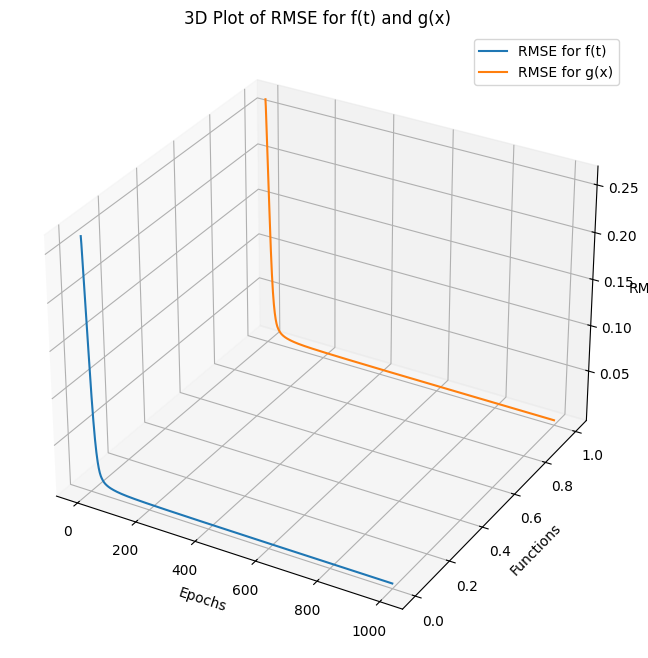

In [42]:
#So far, the best result has been w. the ReLU configuration using
#momentum=0.7, learning rate = 10^-2, 8 hidden layers w. 2 Neurons each. 
#Now, running 5-fold Cross-Validation on the selected result:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import KFold

class PDESolver:
    def __init__(self, x_dim, t_dim, dx, dt, alpha):
        self.x_dim = x_dim
        self.t_dim = t_dim
        self.dx = dx
        self.dt = dt
        self.alpha = alpha
        self.grid = np.zeros((x_dim, t_dim))  # Initialize grid for u(x, t)

    def initialize_conditions(self):
        self.grid[:, 0] = np.sin(np.pi * np.linspace(0, 1, self.x_dim))

    def solve(self):
        for j in range(0, self.t_dim - 1):
            for i in range(1, self.x_dim - 1):
                # Forward Euler discretization for the given PDE
                r = self.alpha * self.dt / self.dx**2
                self.grid[i, j + 1] = self.grid[i, j] + r * (self.grid[i + 1, j] - 2 * self.grid[i, j] + self.grid[i - 1, j])
            
    def _tridiagonal_solver(self, a, b, c, rhs):
        n = 1  # For a single value
        x = np.zeros(n)

        m = b / a
        a = a - m * c
        rhs = rhs - m * rhs

        x[0] = rhs / a
        return x
        
class RecurrentNN:
    def __init__(self, input_dim, hidden_layer_sizes, output_dim, dropout_rate=0.5, momentum=0.9):
        self.input_dim = input_dim
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_dim = output_dim
        self.dropout_rate = dropout_rate
        self.momentum = momentum
        self.weights = []
        self.biases = []
        self.activations = [self.sigmoid] * (len(hidden_layer_sizes) + 1)  # Sigmoid for hidden layers

        prev_layer_size = input_dim
        for layer_size in hidden_layer_sizes:
            weight_layer = np.random.randn(prev_layer_size, layer_size)
            bias_layer = np.zeros(layer_size)
            self.weights.append(weight_layer)
            self.biases.append(bias_layer)

            prev_layer_size = layer_size

        # Output layer weights
        weight_output = np.random.randn(prev_layer_size, output_dim)
        bias_output = np.zeros(output_dim)
        self.weights.append(weight_output)
        self.biases.append(bias_output)

    def sigmoid(self, x, derivative=False):
        if derivative:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))

    def dropout(self, x):
        if self.dropout_rate >= 1.0:
            return x

        mask = (np.random.rand(*x.shape) < self.dropout_rate) / max(1e-5, (1 - self.dropout_rate))
        return x * mask

    def forward(self, x, training=True):
        layer_input = x
        layer_outputs = [layer_input]
        masks = []

        for i in range(len(self.weights)):
            weighted_sum = np.dot(layer_input, self.weights[i]) + self.biases[i]
            layer_output = self.activations[i](weighted_sum)

            if training and i < len(self.weights) - 1:
                layer_output = self.dropout(layer_output)
                masks.append(layer_output)

            layer_outputs.append(layer_output)
            layer_input = layer_output

        return layer_outputs, masks

    def train(self, input_sequences, target_outputs, learning_rate, num_epochs, desc="Training"):
        num_samples, sequence_length, _ = input_sequences.shape
        training_errors = []  # Store training errors
        min_rmse = float('inf')  # Initialize minimum RMSE

        # Initialize velocities for momentum
        velocities = [np.zeros_like(w) for w in self.weights]
        biases_velocities = [np.zeros_like(b) for b in self.biases]

        for epoch in tqdm(range(num_epochs), desc=desc):
            for sample in range(num_samples):
                input_sequence = input_sequences[sample, :, :]
                target_output = target_outputs[sample, :]

                # Forward pass with dropout
                layer_outputs, masks = self.forward(input_sequence)

                final_output = layer_outputs[-1]

                # Calculate loss
                loss = np.mean((final_output - target_output)**2)
                training_errors.append(loss)

                # Backpropagation Through Time (BPTT) with momentum
                derror = 2 * (final_output - target_output) / num_samples

                for i in range(len(self.weights) - 1, -1, -1):
                    dactivation = self.sigmoid(layer_outputs[i + 1], derivative=True)
                    
                    # Ensure dactivation has the same shape as derror
                    dactivation = dactivation[:, :derror.shape[1]]

                    doutput = derror * dactivation

                    # Apply dropout mask during backpropagation
                    if i < len(self.weights) - 1:
                        doutput *= masks[i]

                    dweights = np.dot(layer_outputs[i].T, doutput)
                    dbiases = np.sum(doutput, axis=0)

                    # Update velocities with momentum
                    velocities[i] = self.momentum * velocities[i] + learning_rate * dweights
                    biases_velocities[i] = self.momentum * biases_velocities[i] + learning_rate * dbiases

                    # Update weights and biases with momentum
                    self.weights[i] -= velocities[i]
                    self.biases[i] -= biases_velocities[i]

                    derror = np.dot(doutput, self.weights[i].T)

                # Calculate and print minimum RMSE during training
                if len(training_errors) % sequence_length == 0:
                    rmse = np.sqrt(np.mean(training_errors[-sequence_length:]))
                    if rmse < min_rmse:
                        min_rmse = rmse
                    print(f'Minimum RMSE at epoch {epoch + 1}: {min_rmse}')

        return training_errors    
        
    def predict(self, input_sequence):
        layer_input = input_sequence
        for i in range(len(self.weights)):
            weighted_sum = np.dot(layer_input, self.weights[i]) + self.biases[i]
            layer_input = self.sigmoid(weighted_sum)

        return layer_input

    def plot_3d_training_progress(self, training_errors_f, training_errors_g):
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        epochs = len(training_errors_f)

        # Ensure that both arrays have the same length
        min_len = min(len(training_errors_f), len(training_errors_g))
        x = np.arange(0, min_len, 1)

        # Plot the 3D line
        ax.plot(x, training_errors_f[:min_len], zs=0, zdir='y', label='RMSE for f(t)')
        ax.plot(x, training_errors_g[:min_len], zs=1, zdir='y', label='RMSE for g(x)')

        ax.set_xlabel('Epochs')
        ax.set_ylabel('Functions')
        ax.set_zlabel('RMSE')
        ax.set_title('3D Plot of RMSE for f(t) and g(x)')
        ax.legend()

        plt.show()

# PDE solver parameters
x_dim = 100
t_dim = 1000
L = 1.0
dx = L / (x_dim - 1)
dt = 0.001
alpha = 0.01

# Create PDE solver
pde_solver = PDESolver(x_dim, t_dim, dx, dt, alpha)

# Initialize initial conditions
pde_solver.initialize_conditions()

# Prepare data for RNN training with the specified ansatz
num_samples = 20
input_sequences = np.zeros((num_samples, x_dim, t_dim))
target_outputs_f = np.zeros((num_samples, t_dim))
target_outputs_g = np.zeros((num_samples, x_dim))

for i in range(num_samples):
    input_sequences[i, :, :] = pde_solver.grid.copy()
    pde_solver.solve()

    # Extract f(t) and g(x) from the true solution
    target_outputs_f[i, :] = pde_solver.grid[0, :]
    target_outputs_g[i, :] = pde_solver.grid[:, -1]

# RNN parameters
input_dim = x_dim
hidden_layer_sizes = [2, 2, 2, 2, 2, 2, 2, 2]  # 2 layers with 10 neurons each
output_dim = x_dim
learning_rate = 1e-2
num_epochs = 1000  # Change this to 1000
momentum_value = 0.7
dropout_rate = 1  # Adjust dropout rate as needed

# Create and train RNN for f(t) and g(x) together with BPTT
rnn_model_fg = RecurrentNN(t_dim, hidden_layer_sizes, t_dim, dropout_rate)
training_errors_fg = rnn_model_fg.train(input_sequences[:, :, :], target_outputs_f, learning_rate, num_epochs, desc="Training f(t) and g(x)")

# Plot the 3D training progress for f(t) and g(x)
rnn_model_fg.plot_3d_training_progress(training_errors_fg[:num_epochs], training_errors_fg[:num_epochs])

Training f(t) and g(x):   0%|                                                                 | 0/1000 [00:00<?, ?it/s]C:\Users\Kjæreng\AppData\Local\Temp\ipykernel_18752\252295582.py:70: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
Training f(t) and g(x):   1%|▍                                                        | 8/1000 [00:00<01:03, 15.58it/s]

Minimum RMSE at epoch 5: 0.2032217053587338


Training f(t) and g(x):   1%|▋                                                       | 12/1000 [00:00<01:05, 15.15it/s]

Minimum RMSE at epoch 10: 0.05805957254725023


Training f(t) and g(x):   2%|█                                                       | 18/1000 [00:01<01:05, 14.99it/s]

Minimum RMSE at epoch 15: 0.04489944437328579


Training f(t) and g(x):   2%|█▏                                                      | 22/1000 [00:01<01:04, 15.24it/s]

Minimum RMSE at epoch 20: 0.03772606155564468


Training f(t) and g(x):   3%|█▌                                                      | 28/1000 [00:01<01:03, 15.33it/s]

Minimum RMSE at epoch 25: 0.032949893366346614


Training f(t) and g(x):   3%|█▊                                                      | 32/1000 [00:02<01:02, 15.56it/s]

Minimum RMSE at epoch 30: 0.029530170290725074


Training f(t) and g(x):   4%|██                                                      | 36/1000 [00:02<01:04, 15.05it/s]

Minimum RMSE at epoch 35: 0.02689498534110611


Training f(t) and g(x):   4%|██▎                                                     | 42/1000 [00:02<01:03, 14.98it/s]

Minimum RMSE at epoch 40: 0.02476944492617302


Training f(t) and g(x):   5%|██▋                                                     | 48/1000 [00:03<01:04, 14.83it/s]

Minimum RMSE at epoch 45: 0.022999803816085938


Training f(t) and g(x):   5%|██▉                                                     | 52/1000 [00:03<01:03, 14.87it/s]

Minimum RMSE at epoch 50: 0.021490346989451833


Training f(t) and g(x):   6%|███▏                                                    | 58/1000 [00:03<01:00, 15.50it/s]

Minimum RMSE at epoch 55: 0.020177986445880453


Training f(t) and g(x):   6%|███▍                                                    | 62/1000 [00:04<01:03, 14.76it/s]

Minimum RMSE at epoch 60: 0.01901928072687007


Training f(t) and g(x):   7%|███▊                                                    | 68/1000 [00:04<01:04, 14.41it/s]

Minimum RMSE at epoch 65: 0.017983295570187782


Training f(t) and g(x):   7%|████                                                    | 72/1000 [00:04<01:06, 13.89it/s]

Minimum RMSE at epoch 70: 0.017047454208834183


Training f(t) and g(x):   8%|████▎                                                   | 76/1000 [00:05<01:02, 14.80it/s]

Minimum RMSE at epoch 75: 0.01619503178839868


Training f(t) and g(x):   8%|████▌                                                   | 82/1000 [00:05<00:59, 15.39it/s]

Minimum RMSE at epoch 80: 0.015413614612999196


Training f(t) and g(x):   9%|████▊                                                   | 86/1000 [00:05<01:01, 14.75it/s]

Minimum RMSE at epoch 85: 0.014694154179917195


Training f(t) and g(x):   9%|█████▏                                                  | 92/1000 [00:06<01:01, 14.67it/s]

Minimum RMSE at epoch 90: 0.014030374882182922


Training f(t) and g(x):  10%|█████▍                                                  | 98/1000 [00:06<00:57, 15.63it/s]

Minimum RMSE at epoch 95: 0.013418310812268271


Training f(t) and g(x):  10%|█████▌                                                 | 102/1000 [00:06<00:56, 16.03it/s]

Minimum RMSE at epoch 100: 0.012855723531520062


Training f(t) and g(x):  11%|█████▉                                                 | 108/1000 [00:07<00:56, 15.67it/s]

Minimum RMSE at epoch 105: 0.01234123947488686


Training f(t) and g(x):  11%|██████▏                                                | 112/1000 [00:07<00:55, 16.13it/s]

Minimum RMSE at epoch 110: 0.011873346255793414


Training f(t) and g(x):  12%|██████▍                                                | 118/1000 [00:07<00:55, 15.81it/s]

Minimum RMSE at epoch 115: 0.011449667992574561


Training f(t) and g(x):  12%|██████▋                                                | 122/1000 [00:08<00:57, 15.26it/s]

Minimum RMSE at epoch 120: 0.011066821041285764


Training f(t) and g(x):  13%|███████                                                | 128/1000 [00:08<00:54, 16.14it/s]

Minimum RMSE at epoch 125: 0.010720745473858208


Training f(t) and g(x):  13%|███████▎                                               | 132/1000 [00:08<00:55, 15.76it/s]

Minimum RMSE at epoch 130: 0.010407182906482145


Training f(t) and g(x):  14%|███████▌                                               | 138/1000 [00:09<00:51, 16.83it/s]

Minimum RMSE at epoch 135: 0.010122055904895916


Training f(t) and g(x):  14%|███████▊                                               | 142/1000 [00:09<00:51, 16.53it/s]

Minimum RMSE at epoch 140: 0.00986167907935643


Training f(t) and g(x):  15%|████████                                               | 146/1000 [00:09<00:51, 16.68it/s]

Minimum RMSE at epoch 145: 0.009622834061965596


Training f(t) and g(x):  15%|████████▎                                              | 152/1000 [00:09<00:52, 16.08it/s]

Minimum RMSE at epoch 150: 0.009402763361571923


Training f(t) and g(x):  16%|████████▋                                              | 158/1000 [00:10<00:50, 16.73it/s]

Minimum RMSE at epoch 155: 0.009199126059585443


Training f(t) and g(x):  16%|████████▉                                              | 162/1000 [00:10<00:49, 17.01it/s]

Minimum RMSE at epoch 160: 0.009009940994654273


Training f(t) and g(x):  17%|█████████▏                                             | 168/1000 [00:10<00:49, 16.94it/s]

Minimum RMSE at epoch 165: 0.008833530342867534


Training f(t) and g(x):  17%|█████████▍                                             | 172/1000 [00:11<00:51, 16.20it/s]

Minimum RMSE at epoch 170: 0.008668469031208147


Training f(t) and g(x):  18%|█████████▊                                             | 178/1000 [00:11<00:51, 15.99it/s]

Minimum RMSE at epoch 175: 0.008513541584806942


Training f(t) and g(x):  18%|██████████                                             | 182/1000 [00:11<00:54, 15.09it/s]

Minimum RMSE at epoch 180: 0.008367706250327555


Training f(t) and g(x):  19%|██████████▏                                            | 186/1000 [00:12<00:52, 15.60it/s]

Minimum RMSE at epoch 185: 0.008230065552669648


Training f(t) and g(x):  19%|██████████▌                                            | 192/1000 [00:12<00:56, 14.33it/s]

Minimum RMSE at epoch 190: 0.008099842267759437


Training f(t) and g(x):  20%|██████████▉                                            | 198/1000 [00:12<00:54, 14.74it/s]

Minimum RMSE at epoch 195: 0.007976359840673818


Training f(t) and g(x):  20%|███████████                                            | 202/1000 [00:13<00:51, 15.46it/s]

Minimum RMSE at epoch 200: 0.00785902640504817


Training f(t) and g(x):  21%|███████████▍                                           | 208/1000 [00:13<00:51, 15.24it/s]

Minimum RMSE at epoch 205: 0.0077473217025554805


Training f(t) and g(x):  21%|███████████▋                                           | 212/1000 [00:13<00:51, 15.28it/s]

Minimum RMSE at epoch 210: 0.007640786333696527


Training f(t) and g(x):  22%|███████████▉                                           | 216/1000 [00:14<00:57, 13.69it/s]

Minimum RMSE at epoch 215: 0.007539012884325275


Training f(t) and g(x):  22%|████████████▏                                          | 222/1000 [00:14<00:57, 13.55it/s]

Minimum RMSE at epoch 220: 0.00744163856516559


Training f(t) and g(x):  23%|████████████▌                                          | 228/1000 [00:14<00:52, 14.80it/s]

Minimum RMSE at epoch 225: 0.007348339076057872


Training f(t) and g(x):  23%|████████████▊                                          | 232/1000 [00:15<00:51, 14.90it/s]

Minimum RMSE at epoch 230: 0.007258823465736668


Training f(t) and g(x):  24%|█████████████                                          | 238/1000 [00:15<00:48, 15.59it/s]

Minimum RMSE at epoch 235: 0.007172829804507378


Training f(t) and g(x):  24%|█████████████▎                                         | 242/1000 [00:15<00:48, 15.74it/s]

Minimum RMSE at epoch 240: 0.007090121523830821


Training f(t) and g(x):  25%|█████████████▋                                         | 248/1000 [00:16<00:52, 14.38it/s]

Minimum RMSE at epoch 245: 0.007010484305664916


Training f(t) and g(x):  25%|█████████████▊                                         | 252/1000 [00:16<00:49, 14.97it/s]

Minimum RMSE at epoch 250: 0.0069337234271561075


Training f(t) and g(x):  26%|██████████████                                         | 256/1000 [00:16<00:50, 14.74it/s]

Minimum RMSE at epoch 255: 0.006859661484260822


Training f(t) and g(x):  26%|██████████████▍                                        | 262/1000 [00:17<00:46, 15.88it/s]

Minimum RMSE at epoch 260: 0.0067881364321539525


Training f(t) and g(x):  27%|██████████████▋                                        | 268/1000 [00:17<00:47, 15.36it/s]

Minimum RMSE at epoch 265: 0.006718999891658026


Training f(t) and g(x):  27%|██████████████▉                                        | 272/1000 [00:18<00:59, 12.27it/s]

Minimum RMSE at epoch 270: 0.006652115680030785


Training f(t) and g(x):  28%|███████████████▏                                       | 276/1000 [00:18<01:09, 10.41it/s]

Minimum RMSE at epoch 275: 0.006587358531766056


Training f(t) and g(x):  28%|███████████████▌                                       | 282/1000 [00:18<00:56, 12.74it/s]

Minimum RMSE at epoch 280: 0.006524612980969993


Training f(t) and g(x):  29%|███████████████▋                                       | 286/1000 [00:19<00:53, 13.34it/s]

Minimum RMSE at epoch 285: 0.00646377238166468


Training f(t) and g(x):  29%|████████████████                                       | 292/1000 [00:19<00:48, 14.63it/s]

Minimum RMSE at epoch 290: 0.0064047380462720965


Training f(t) and g(x):  30%|████████████████▎                                      | 296/1000 [00:19<00:59, 11.79it/s]

Minimum RMSE at epoch 295: 0.006347418485722264


Training f(t) and g(x):  30%|████████████████▌                                      | 302/1000 [00:20<00:57, 12.23it/s]

Minimum RMSE at epoch 300: 0.006291728737250248


Training f(t) and g(x):  31%|████████████████▊                                      | 306/1000 [00:20<00:51, 13.58it/s]

Minimum RMSE at epoch 305: 0.006237589768108406


Training f(t) and g(x):  31%|█████████████████▏                                     | 312/1000 [00:21<00:52, 13.06it/s]

Minimum RMSE at epoch 310: 0.006184927945210273


Training f(t) and g(x):  32%|█████████████████▍                                     | 318/1000 [00:21<00:48, 14.19it/s]

Minimum RMSE at epoch 315: 0.00613367456221061


Training f(t) and g(x):  32%|█████████████████▋                                     | 322/1000 [00:21<00:47, 14.20it/s]

Minimum RMSE at epoch 320: 0.006083765416767881


Training f(t) and g(x):  33%|█████████████████▉                                     | 326/1000 [00:22<00:46, 14.38it/s]

Minimum RMSE at epoch 325: 0.006035140431775446


Training f(t) and g(x):  33%|██████████████████▎                                    | 332/1000 [00:22<00:52, 12.71it/s]

Minimum RMSE at epoch 330: 0.005987743315221799


Training f(t) and g(x):  34%|██████████████████▌                                    | 338/1000 [00:23<00:47, 13.95it/s]

Minimum RMSE at epoch 335: 0.005941521254077432


Training f(t) and g(x):  34%|██████████████████▊                                    | 342/1000 [00:23<00:49, 13.28it/s]

Minimum RMSE at epoch 340: 0.005896424638229613


Training f(t) and g(x):  35%|███████████████████▏                                   | 348/1000 [00:23<00:44, 14.69it/s]

Minimum RMSE at epoch 345: 0.005852406811015949


Training f(t) and g(x):  35%|███████████████████▎                                   | 352/1000 [00:23<00:43, 15.01it/s]

Minimum RMSE at epoch 350: 0.0058094238433584085


Training f(t) and g(x):  36%|███████████████████▌                                   | 356/1000 [00:24<00:45, 14.19it/s]

Minimum RMSE at epoch 355: 0.005767434328884615


Training f(t) and g(x):  36%|███████████████████▉                                   | 362/1000 [00:24<00:44, 14.35it/s]

Minimum RMSE at epoch 360: 0.005726399197753073


Training f(t) and g(x):  37%|████████████████████▏                                  | 366/1000 [00:24<00:44, 14.13it/s]

Minimum RMSE at epoch 365: 0.0056862815471821985


Training f(t) and g(x):  37%|████████████████████▍                                  | 372/1000 [00:25<00:42, 14.63it/s]

Minimum RMSE at epoch 370: 0.005647046486927162


Training f(t) and g(x):  38%|████████████████████▊                                  | 378/1000 [00:25<00:40, 15.23it/s]

Minimum RMSE at epoch 375: 0.0056086609981591765


Training f(t) and g(x):  38%|█████████████████████                                  | 382/1000 [00:26<00:39, 15.51it/s]

Minimum RMSE at epoch 380: 0.00557109380438427


Training f(t) and g(x):  39%|█████████████████████▎                                 | 388/1000 [00:26<00:43, 14.13it/s]

Minimum RMSE at epoch 385: 0.005534315253196944


Training f(t) and g(x):  39%|█████████████████████▌                                 | 392/1000 [00:26<00:44, 13.72it/s]

Minimum RMSE at epoch 390: 0.005498297207801774


Training f(t) and g(x):  40%|█████████████████████▉                                 | 398/1000 [00:27<00:40, 14.79it/s]

Minimum RMSE at epoch 395: 0.0054630129473561065


Training f(t) and g(x):  40%|██████████████████████                                 | 402/1000 [00:27<00:38, 15.50it/s]

Minimum RMSE at epoch 400: 0.005428437075291953


Training f(t) and g(x):  41%|██████████████████████▍                                | 408/1000 [00:27<00:40, 14.66it/s]

Minimum RMSE at epoch 405: 0.0053945454348670215


Training f(t) and g(x):  41%|██████████████████████▋                                | 412/1000 [00:28<00:37, 15.74it/s]

Minimum RMSE at epoch 410: 0.00536131503127554


Training f(t) and g(x):  42%|██████████████████████▉                                | 418/1000 [00:28<00:37, 15.54it/s]

Minimum RMSE at epoch 415: 0.005328723959720354


Training f(t) and g(x):  42%|███████████████████████▏                               | 422/1000 [00:28<00:36, 15.63it/s]

Minimum RMSE at epoch 420: 0.005296751338910376


Training f(t) and g(x):  43%|███████████████████████▍                               | 426/1000 [00:29<00:37, 15.31it/s]

Minimum RMSE at epoch 425: 0.00526537724950251


Training f(t) and g(x):  43%|███████████████████████▊                               | 432/1000 [00:29<00:40, 14.20it/s]

Minimum RMSE at epoch 430: 0.005234582677056057


Training f(t) and g(x):  44%|███████████████████████▉                               | 436/1000 [00:29<00:40, 13.99it/s]

Minimum RMSE at epoch 435: 0.005204349459110801


Training f(t) and g(x):  44%|████████████████████████▎                              | 442/1000 [00:30<00:37, 14.71it/s]

Minimum RMSE at epoch 440: 0.005174660236038317


Training f(t) and g(x):  45%|████████████████████████▋                              | 448/1000 [00:30<00:38, 14.38it/s]

Minimum RMSE at epoch 445: 0.005145498405350218


Training f(t) and g(x):  45%|████████████████████████▊                              | 452/1000 [00:30<00:35, 15.36it/s]

Minimum RMSE at epoch 450: 0.005116848079177401


Training f(t) and g(x):  46%|█████████████████████████▏                             | 458/1000 [00:31<00:38, 14.01it/s]

Minimum RMSE at epoch 455: 0.005088694044661458


Training f(t) and g(x):  46%|█████████████████████████▍                             | 462/1000 [00:31<00:37, 14.19it/s]

Minimum RMSE at epoch 460: 0.005061021727023657


Training f(t) and g(x):  47%|█████████████████████████▋                             | 468/1000 [00:32<00:36, 14.43it/s]

Minimum RMSE at epoch 465: 0.005033817155098538


Training f(t) and g(x):  47%|█████████████████████████▉                             | 472/1000 [00:32<00:36, 14.61it/s]

Minimum RMSE at epoch 470: 0.005007066929138609


Training f(t) and g(x):  48%|██████████████████████████▏                            | 476/1000 [00:32<00:40, 12.81it/s]

Minimum RMSE at epoch 475: 0.004980758190714037


Training f(t) and g(x):  48%|██████████████████████████▌                            | 482/1000 [00:33<00:36, 14.25it/s]

Minimum RMSE at epoch 480: 0.0049548785945469015


Training f(t) and g(x):  49%|██████████████████████████▊                            | 488/1000 [00:33<00:34, 14.91it/s]

Minimum RMSE at epoch 485: 0.004929416282133663


Training f(t) and g(x):  49%|███████████████████████████                            | 492/1000 [00:33<00:34, 14.58it/s]

Minimum RMSE at epoch 490: 0.004904359857022208


Training f(t) and g(x):  50%|███████████████████████████▎                           | 496/1000 [00:33<00:33, 15.06it/s]

Minimum RMSE at epoch 495: 0.004879698361621282


Training f(t) and g(x):  50%|███████████████████████████▌                           | 502/1000 [00:34<00:35, 14.08it/s]

Minimum RMSE at epoch 500: 0.004855421255430478


Training f(t) and g(x):  51%|███████████████████████████▉                           | 508/1000 [00:34<00:34, 14.39it/s]

Minimum RMSE at epoch 505: 0.004831518394588339


Training f(t) and g(x):  51%|████████████████████████████▏                          | 512/1000 [00:35<00:35, 13.59it/s]

Minimum RMSE at epoch 510: 0.0048079800126445615


Training f(t) and g(x):  52%|████████████████████████████▍                          | 518/1000 [00:35<00:32, 14.74it/s]

Minimum RMSE at epoch 515: 0.004784796702470036


Training f(t) and g(x):  52%|████████████████████████████▋                          | 522/1000 [00:35<00:32, 14.87it/s]

Minimum RMSE at epoch 520: 0.004761959399225417


Training f(t) and g(x):  53%|█████████████████████████████                          | 528/1000 [00:36<00:30, 15.41it/s]

Minimum RMSE at epoch 525: 0.004739459364315249


Training f(t) and g(x):  53%|█████████████████████████████▏                         | 530/1000 [00:36<00:31, 14.95it/s]

Minimum RMSE at epoch 530: 0.004717288170260475


Training f(t) and g(x):  54%|█████████████████████████████▍                         | 536/1000 [00:36<00:35, 13.22it/s]

Minimum RMSE at epoch 535: 0.004695437686427414


Training f(t) and g(x):  54%|█████████████████████████████▊                         | 542/1000 [00:37<00:32, 14.30it/s]

Minimum RMSE at epoch 540: 0.004673900065556054


Training f(t) and g(x):  55%|██████████████████████████████▏                        | 548/1000 [00:37<00:31, 14.45it/s]

Minimum RMSE at epoch 545: 0.004652667731034914


Training f(t) and g(x):  55%|██████████████████████████████▎                        | 552/1000 [00:37<00:31, 14.23it/s]

Minimum RMSE at epoch 550: 0.004631733364873753


Training f(t) and g(x):  56%|██████████████████████████████▋                        | 558/1000 [00:38<00:31, 14.05it/s]

Minimum RMSE at epoch 555: 0.004611089896328976


Training f(t) and g(x):  56%|██████████████████████████████▉                        | 562/1000 [00:38<00:33, 13.23it/s]

Minimum RMSE at epoch 560: 0.004590730491140039


Training f(t) and g(x):  57%|███████████████████████████████▏                       | 568/1000 [00:39<00:31, 13.80it/s]

Minimum RMSE at epoch 565: 0.0045706485413381445


Training f(t) and g(x):  57%|███████████████████████████████▍                       | 572/1000 [00:39<00:29, 14.33it/s]

Minimum RMSE at epoch 570: 0.00455083765559138


Training f(t) and g(x):  58%|███████████████████████████████▋                       | 576/1000 [00:39<00:35, 12.11it/s]

Minimum RMSE at epoch 575: 0.004531291650052991


Training f(t) and g(x):  58%|████████████████████████████████                       | 582/1000 [00:40<00:32, 12.86it/s]

Minimum RMSE at epoch 580: 0.004512004539681915


Training f(t) and g(x):  59%|████████████████████████████████▏                      | 586/1000 [00:40<00:30, 13.62it/s]

Minimum RMSE at epoch 585: 0.004492970530006811


Training f(t) and g(x):  59%|████████████████████████████████▌                      | 592/1000 [00:40<00:30, 13.59it/s]

Minimum RMSE at epoch 590: 0.004474184009306904


Training f(t) and g(x):  60%|████████████████████████████████▊                      | 596/1000 [00:41<00:28, 14.31it/s]

Minimum RMSE at epoch 595: 0.004455639541184742


Training f(t) and g(x):  60%|█████████████████████████████████                      | 602/1000 [00:41<00:30, 13.19it/s]

Minimum RMSE at epoch 600: 0.00443733185750772


Training f(t) and g(x):  61%|█████████████████████████████████▍                     | 608/1000 [00:42<00:26, 14.60it/s]

Minimum RMSE at epoch 605: 0.004419255851696795


Training f(t) and g(x):  61%|█████████████████████████████████▋                     | 612/1000 [00:42<00:26, 14.88it/s]

Minimum RMSE at epoch 610: 0.004401406572342217


Training f(t) and g(x):  62%|█████████████████████████████████▉                     | 618/1000 [00:42<00:25, 15.00it/s]

Minimum RMSE at epoch 615: 0.004383779217127526


Training f(t) and g(x):  62%|██████████████████████████████████▏                    | 622/1000 [00:42<00:24, 15.22it/s]

Minimum RMSE at epoch 620: 0.00436636912704424


Training f(t) and g(x):  63%|██████████████████████████████████▍                    | 626/1000 [00:43<00:24, 15.01it/s]

Minimum RMSE at epoch 625: 0.004349171780880832


Training f(t) and g(x):  63%|██████████████████████████████████▊                    | 632/1000 [00:43<00:23, 15.55it/s]

Minimum RMSE at epoch 630: 0.004332182789970673


Training f(t) and g(x):  64%|███████████████████████████████████                    | 638/1000 [00:44<00:22, 15.94it/s]

Minimum RMSE at epoch 635: 0.0043153978931845674


Training f(t) and g(x):  64%|███████████████████████████████████▎                   | 642/1000 [00:44<00:22, 15.88it/s]

Minimum RMSE at epoch 640: 0.004298812952154468


Training f(t) and g(x):  65%|███████████████████████████████████▌                   | 646/1000 [00:44<00:23, 14.91it/s]

Minimum RMSE at epoch 645: 0.004282423946715766


Training f(t) and g(x):  65%|███████████████████████████████████▊                   | 652/1000 [00:44<00:23, 14.68it/s]

Minimum RMSE at epoch 650: 0.0042662269705563555


Training f(t) and g(x):  66%|████████████████████████████████████                   | 656/1000 [00:45<00:23, 14.43it/s]

Minimum RMSE at epoch 655: 0.004250218227061426


Training f(t) and g(x):  66%|████████████████████████████████████▍                  | 662/1000 [00:45<00:22, 15.24it/s]

Minimum RMSE at epoch 660: 0.004234394025343571


Training f(t) and g(x):  67%|████████████████████████████████████▋                  | 668/1000 [00:46<00:21, 15.21it/s]

Minimum RMSE at epoch 665: 0.004218750776448479


Training f(t) and g(x):  67%|████████████████████████████████████▉                  | 672/1000 [00:46<00:21, 15.39it/s]

Minimum RMSE at epoch 670: 0.0042032849897270415


Training f(t) and g(x):  68%|█████████████████████████████████████▏                 | 676/1000 [00:46<00:21, 15.15it/s]

Minimum RMSE at epoch 675: 0.004187993269365263


Training f(t) and g(x):  68%|█████████████████████████████████████▌                 | 682/1000 [00:46<00:21, 14.78it/s]

Minimum RMSE at epoch 680: 0.004172872311063879


Training f(t) and g(x):  69%|█████████████████████████████████████▊                 | 688/1000 [00:47<00:20, 15.20it/s]

Minimum RMSE at epoch 685: 0.004157918898860057


Training f(t) and g(x):  69%|██████████████████████████████████████                 | 692/1000 [00:47<00:20, 15.21it/s]

Minimum RMSE at epoch 690: 0.0041431299020840175


Training f(t) and g(x):  70%|██████████████████████████████████████▍                | 698/1000 [00:48<00:19, 15.37it/s]

Minimum RMSE at epoch 695: 0.004128502272443796


Training f(t) and g(x):  70%|██████████████████████████████████████▌                | 702/1000 [00:48<00:19, 15.13it/s]

Minimum RMSE at epoch 700: 0.004114033041231803


Training f(t) and g(x):  71%|██████████████████████████████████████▉                | 708/1000 [00:48<00:19, 15.24it/s]

Minimum RMSE at epoch 705: 0.004099719316647167


Training f(t) and g(x):  71%|███████████████████████████████████████▏               | 712/1000 [00:48<00:19, 14.56it/s]

Minimum RMSE at epoch 710: 0.004085558281228186


Training f(t) and g(x):  72%|███████████████████████████████████████▍               | 718/1000 [00:49<00:18, 15.03it/s]

Minimum RMSE at epoch 715: 0.004071547189389571


Training f(t) and g(x):  72%|███████████████████████████████████████▋               | 722/1000 [00:49<00:18, 14.99it/s]

Minimum RMSE at epoch 720: 0.004057683365059404


Training f(t) and g(x):  73%|███████████████████████████████████████▉               | 726/1000 [00:49<00:20, 13.64it/s]

Minimum RMSE at epoch 725: 0.004043964199411075


Training f(t) and g(x):  73%|████████████████████████████████████████▎              | 732/1000 [00:50<00:19, 13.53it/s]

Minimum RMSE at epoch 730: 0.004030387148685661


Training f(t) and g(x):  74%|████████████████████████████████████████▍              | 736/1000 [00:50<00:22, 11.85it/s]

Minimum RMSE at epoch 735: 0.004016949732100522


Training f(t) and g(x):  74%|████████████████████████████████████████▊              | 742/1000 [00:51<00:19, 13.05it/s]

Minimum RMSE at epoch 740: 0.00400364952984007


Training f(t) and g(x):  75%|█████████████████████████████████████████              | 746/1000 [00:51<00:18, 13.96it/s]

Minimum RMSE at epoch 745: 0.003990484181124886


Training f(t) and g(x):  75%|█████████████████████████████████████████▎             | 752/1000 [00:51<00:18, 13.61it/s]

Minimum RMSE at epoch 750: 0.003977451382355614


Training f(t) and g(x):  76%|█████████████████████████████████████████▋             | 758/1000 [00:52<00:16, 14.63it/s]

Minimum RMSE at epoch 755: 0.003964548885328182


Training f(t) and g(x):  76%|█████████████████████████████████████████▉             | 762/1000 [00:52<00:17, 13.89it/s]

Minimum RMSE at epoch 760: 0.003951774495517128


Training f(t) and g(x):  77%|██████████████████████████████████████████▏            | 768/1000 [00:53<00:16, 14.34it/s]

Minimum RMSE at epoch 765: 0.003939126070423967


Training f(t) and g(x):  77%|██████████████████████████████████████████▍            | 772/1000 [00:53<00:15, 14.71it/s]

Minimum RMSE at epoch 770: 0.003926601517987681


Training f(t) and g(x):  78%|██████████████████████████████████████████▊            | 778/1000 [00:53<00:14, 15.20it/s]

Minimum RMSE at epoch 775: 0.003914198795054575


Training f(t) and g(x):  78%|███████████████████████████████████████████            | 782/1000 [00:54<00:14, 14.94it/s]

Minimum RMSE at epoch 780: 0.0039019159059048994


Training f(t) and g(x):  79%|███████████████████████████████████████████▎           | 788/1000 [00:54<00:13, 15.32it/s]

Minimum RMSE at epoch 785: 0.003889750900833717


Training f(t) and g(x):  79%|███████████████████████████████████████████▌           | 792/1000 [00:54<00:14, 14.00it/s]

Minimum RMSE at epoch 790: 0.0038777018747836937


Training f(t) and g(x):  80%|███████████████████████████████████████████▊           | 796/1000 [00:55<00:18, 11.28it/s]

Minimum RMSE at epoch 795: 0.0038657669660275493


Training f(t) and g(x):  80%|████████████████████████████████████████████           | 802/1000 [00:55<00:14, 13.59it/s]

Minimum RMSE at epoch 800: 0.0038539443548980435


Training f(t) and g(x):  81%|████████████████████████████████████████████▍          | 808/1000 [00:55<00:12, 14.95it/s]

Minimum RMSE at epoch 805: 0.0038422322625634737


Training f(t) and g(x):  81%|████████████████████████████████████████████▋          | 812/1000 [00:56<00:12, 14.53it/s]

Minimum RMSE at epoch 810: 0.003830628949846761


Training f(t) and g(x):  82%|████████████████████████████████████████████▉          | 818/1000 [00:56<00:12, 14.88it/s]

Minimum RMSE at epoch 815: 0.0038191327160862843


Training f(t) and g(x):  82%|█████████████████████████████████████████████▏         | 822/1000 [00:56<00:12, 14.63it/s]

Minimum RMSE at epoch 820: 0.0038077418980367313


Training f(t) and g(x):  83%|█████████████████████████████████████████████▌         | 828/1000 [00:57<00:12, 13.62it/s]

Minimum RMSE at epoch 825: 0.0037964548688082986


Training f(t) and g(x):  83%|█████████████████████████████████████████████▋         | 830/1000 [00:57<00:12, 13.36it/s]

Minimum RMSE at epoch 830: 0.0037852700368426633


Training f(t) and g(x):  84%|█████████████████████████████████████████████▉         | 836/1000 [00:58<00:12, 12.66it/s]

Minimum RMSE at epoch 835: 0.0037741858449242232


Training f(t) and g(x):  84%|██████████████████████████████████████████████▎        | 842/1000 [00:58<00:12, 12.79it/s]

Minimum RMSE at epoch 840: 0.0037632007692251683


Training f(t) and g(x):  85%|██████████████████████████████████████████████▌        | 846/1000 [00:59<00:15, 10.08it/s]

Minimum RMSE at epoch 845: 0.003752313318383017


Training f(t) and g(x):  85%|██████████████████████████████████████████████▊        | 852/1000 [00:59<00:11, 13.08it/s]

Minimum RMSE at epoch 850: 0.0037415220326093217


Training f(t) and g(x):  86%|███████████████████████████████████████████████▏       | 858/1000 [00:59<00:11, 12.35it/s]

Minimum RMSE at epoch 855: 0.0037308254828282805


Training f(t) and g(x):  86%|███████████████████████████████████████████████▍       | 862/1000 [01:00<00:10, 12.72it/s]

Minimum RMSE at epoch 860: 0.0037202222698440985


Training f(t) and g(x):  87%|███████████████████████████████████████████████▋       | 866/1000 [01:00<00:11, 11.44it/s]

Minimum RMSE at epoch 865: 0.0037097110235359406


Training f(t) and g(x):  87%|███████████████████████████████████████████████▉       | 872/1000 [01:01<00:10, 12.04it/s]

Minimum RMSE at epoch 870: 0.0036992904020794045


Training f(t) and g(x):  88%|████████████████████████████████████████████████▏      | 876/1000 [01:01<00:09, 13.40it/s]

Minimum RMSE at epoch 875: 0.0036889590911934915


Training f(t) and g(x):  88%|████████████████████████████████████████████████▍      | 881/1000 [01:02<00:15,  7.46it/s]

Minimum RMSE at epoch 880: 0.0036787158034120777


Training f(t) and g(x):  89%|████████████████████████████████████████████████▋      | 886/1000 [01:02<00:16,  6.82it/s]

Minimum RMSE at epoch 885: 0.0036685592773789406


Training f(t) and g(x):  89%|████████████████████████████████████████████████▉      | 890/1000 [01:03<00:14,  7.82it/s]

Minimum RMSE at epoch 890: 0.0036584882771654626


Training f(t) and g(x):  90%|█████████████████████████████████████████████████▎     | 897/1000 [01:04<00:09, 10.97it/s]

Minimum RMSE at epoch 895: 0.003648501591610122


Training f(t) and g(x):  90%|█████████████████████████████████████████████████▌     | 901/1000 [01:04<00:08, 12.26it/s]

Minimum RMSE at epoch 900: 0.003638598033678976


Training f(t) and g(x):  91%|█████████████████████████████████████████████████▉     | 907/1000 [01:04<00:08, 11.32it/s]

Minimum RMSE at epoch 905: 0.0036287764398463263


Training f(t) and g(x):  91%|█████████████████████████████████████████████████▉     | 909/1000 [01:05<00:08, 10.49it/s]

Minimum RMSE at epoch 910: 0.003619035669494829


Training f(t) and g(x):  92%|██████████████████████████████████████████████████▍    | 917/1000 [01:06<00:09,  9.11it/s]

Minimum RMSE at epoch 915: 0.003609374604334327


Training f(t) and g(x):  92%|██████████████████████████████████████████████████▋    | 921/1000 [01:06<00:07,  9.91it/s]

Minimum RMSE at epoch 920: 0.0035997921478387053


Training f(t) and g(x):  92%|██████████████████████████████████████████████████▉    | 925/1000 [01:06<00:07, 10.18it/s]

Minimum RMSE at epoch 925: 0.003590287224700117


Training f(t) and g(x):  93%|███████████████████████████████████████████████████▏   | 931/1000 [01:07<00:07,  9.20it/s]

Minimum RMSE at epoch 930: 0.0035808587802999454


Training f(t) and g(x):  94%|███████████████████████████████████████████████████▍   | 936/1000 [01:08<00:06, 10.19it/s]

Minimum RMSE at epoch 935: 0.0035715057801958988


Training f(t) and g(x):  94%|███████████████████████████████████████████████████▋   | 940/1000 [01:08<00:05, 10.84it/s]

Minimum RMSE at epoch 940: 0.003562227209624649


Training f(t) and g(x):  94%|███████████████████████████████████████████████████▉   | 945/1000 [01:09<00:05,  9.26it/s]

Minimum RMSE at epoch 945: 0.003553022073019468


Training f(t) and g(x):  95%|████████████████████████████████████████████████████▎  | 951/1000 [01:10<00:07,  6.44it/s]

Minimum RMSE at epoch 950: 0.0035438893935423195


Training f(t) and g(x):  96%|████████████████████████████████████████████████████▌  | 955/1000 [01:10<00:05,  7.81it/s]

Minimum RMSE at epoch 955: 0.0035348282126298966


Training f(t) and g(x):  96%|████████████████████████████████████████████████████▊  | 960/1000 [01:11<00:03, 10.58it/s]

Minimum RMSE at epoch 960: 0.0035258375895531194


Training f(t) and g(x):  97%|█████████████████████████████████████████████████████▏ | 967/1000 [01:12<00:03,  8.53it/s]

Minimum RMSE at epoch 965: 0.0035169166009896115


Training f(t) and g(x):  97%|█████████████████████████████████████████████████████▍ | 971/1000 [01:12<00:03,  8.17it/s]

Minimum RMSE at epoch 970: 0.0035080643406087153


Training f(t) and g(x):  98%|█████████████████████████████████████████████████████▋ | 976/1000 [01:13<00:03,  7.47it/s]

Minimum RMSE at epoch 975: 0.0034992799186686005


Training f(t) and g(x):  98%|█████████████████████████████████████████████████████▉ | 981/1000 [01:13<00:02,  7.92it/s]

Minimum RMSE at epoch 980: 0.0034905624616250563


Training f(t) and g(x):  99%|██████████████████████████████████████████████████████▏| 986/1000 [01:14<00:01,  8.30it/s]

Minimum RMSE at epoch 985: 0.0034819111117515727


Training f(t) and g(x):  99%|██████████████████████████████████████████████████████▌| 991/1000 [01:15<00:01,  6.96it/s]

Minimum RMSE at epoch 990: 0.0034733250267703015


Training f(t) and g(x): 100%|██████████████████████████████████████████████████████▊| 996/1000 [01:15<00:00,  7.71it/s]

Minimum RMSE at epoch 995: 0.003464803379493569


Training f(t) and g(x): 100%|██████████████████████████████████████████████████████| 1000/1000 [01:16<00:00, 13.09it/s]


Minimum RMSE at epoch 1000: 0.0034563453574755457


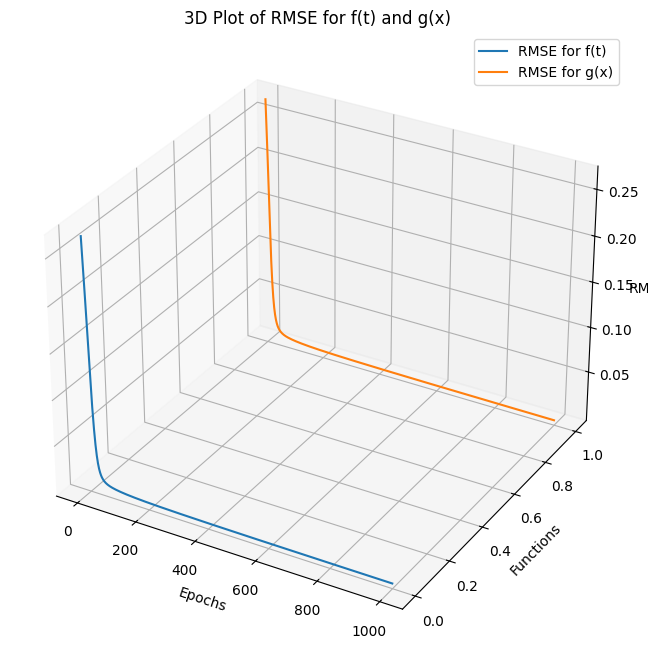

In [39]:
#Now using Implicit Euler's Method rather than Euler's Forward Method, Cross-Validated:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import KFold

class PDESolver:
    def __init__(self, x_dim, t_dim, dx, dt, alpha):
        self.x_dim = x_dim
        self.t_dim = t_dim
        self.dx = dx
        self.dt = dt
        self.alpha = alpha
        self.grid = np.zeros((x_dim, t_dim))  # Initialize grid for u(x, t)

    def initialize_conditions(self):
        self.grid[:, 0] = np.sin(np.pi * np.linspace(0, 1, self.x_dim))

    def solve(self):
        for j in range(0, self.t_dim - 1):
            for i in range(1, self.x_dim - 1):
                # Implicit Euler discretization for the given PDE
                r = self.alpha * self.dt / self.dx**2
                a = 1 + 2 * r
                b = -r
                c = -r
                rhs = self.grid[i, j] + r * (self.grid[i + 1, j + 1] + self.grid[i - 1, j + 1])
                self.grid[i, j + 1] = self._tridiagonal_solver(a, b, c, rhs)[0]

    def _tridiagonal_solver(self, a, b, c, rhs):
        n = 1  # For a single value
        x = np.zeros(n)

        m = b / a
        a = a - m * c
        rhs = rhs - m * rhs

        x[0] = rhs / a
        return x
        
class RecurrentNN:
    def __init__(self, input_dim, hidden_layer_sizes, output_dim, dropout_rate=0.5, momentum=0.9):
        self.input_dim = input_dim
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_dim = output_dim
        self.dropout_rate = dropout_rate
        self.momentum = momentum
        self.weights = []
        self.biases = []
        self.activations = [self.sigmoid] * (len(hidden_layer_sizes) + 1)  # Sigmoid for hidden layers

        prev_layer_size = input_dim
        for layer_size in hidden_layer_sizes:
            weight_layer = np.random.randn(prev_layer_size, layer_size)
            bias_layer = np.zeros(layer_size)
            self.weights.append(weight_layer)
            self.biases.append(bias_layer)

            prev_layer_size = layer_size

        # Output layer weights
        weight_output = np.random.randn(prev_layer_size, output_dim)
        bias_output = np.zeros(output_dim)
        self.weights.append(weight_output)
        self.biases.append(bias_output)

    def sigmoid(self, x, derivative=False):
        if derivative:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))

    def dropout(self, x):
        if self.dropout_rate >= 1.0:
            return x

        mask = (np.random.rand(*x.shape) < self.dropout_rate) / max(1e-5, (1 - self.dropout_rate))
        return x * mask

    def forward(self, x, training=True):
        layer_input = x
        layer_outputs = [layer_input]
        masks = []

        for i in range(len(self.weights)):
            weighted_sum = np.dot(layer_input, self.weights[i]) + self.biases[i]
            layer_output = self.activations[i](weighted_sum)

            if training and i < len(self.weights) - 1:
                layer_output = self.dropout(layer_output)
                masks.append(layer_output)

            layer_outputs.append(layer_output)
            layer_input = layer_output

        return layer_outputs, masks

    def train(self, input_sequences, target_outputs, learning_rate, num_epochs, desc="Training"):
        num_samples, sequence_length, _ = input_sequences.shape
        training_errors = []  # Store training errors
        min_rmse = float('inf')  # Initialize minimum RMSE

        # Initialize velocities for momentum
        velocities = [np.zeros_like(w) for w in self.weights]
        biases_velocities = [np.zeros_like(b) for b in self.biases]

        for epoch in tqdm(range(num_epochs), desc=desc):
            for sample in range(num_samples):
                input_sequence = input_sequences[sample, :, :]
                target_output = target_outputs[sample, :]

                # Forward pass with dropout
                layer_outputs, masks = self.forward(input_sequence)

                final_output = layer_outputs[-1]

                # Calculate loss
                loss = np.mean((final_output - target_output)**2)
                training_errors.append(loss)

                # Backpropagation Through Time (BPTT) with momentum
                derror = 2 * (final_output - target_output) / num_samples

                for i in range(len(self.weights) - 1, -1, -1):
                    dactivation = self.sigmoid(layer_outputs[i + 1], derivative=True)
                    
                    # Ensure dactivation has the same shape as derror
                    dactivation = dactivation[:, :derror.shape[1]]

                    doutput = derror * dactivation

                    # Apply dropout mask during backpropagation
                    if i < len(self.weights) - 1:
                        doutput *= masks[i]

                    dweights = np.dot(layer_outputs[i].T, doutput)
                    dbiases = np.sum(doutput, axis=0)

                    # Update velocities with momentum
                    velocities[i] = self.momentum * velocities[i] + learning_rate * dweights
                    biases_velocities[i] = self.momentum * biases_velocities[i] + learning_rate * dbiases

                    # Update weights and biases with momentum
                    self.weights[i] -= velocities[i]
                    self.biases[i] -= biases_velocities[i]

                    derror = np.dot(doutput, self.weights[i].T)

                # Calculate and print minimum RMSE during training
                if len(training_errors) % sequence_length == 0:
                    rmse = np.sqrt(np.mean(training_errors[-sequence_length:]))
                    if rmse < min_rmse:
                        min_rmse = rmse
                    print(f'Minimum RMSE at epoch {epoch + 1}: {min_rmse}')

        return training_errors    
        
    def predict(self, input_sequence):
        layer_input = input_sequence
        for i in range(len(self.weights)):
            weighted_sum = np.dot(layer_input, self.weights[i]) + self.biases[i]
            layer_input = self.sigmoid(weighted_sum)

        return layer_input

    def plot_3d_training_progress(self, training_errors_f, training_errors_g):
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        epochs = len(training_errors_f)

        # Ensure that both arrays have the same length
        min_len = min(len(training_errors_f), len(training_errors_g))
        x = np.arange(0, min_len, 1)

        # Plot the 3D line
        ax.plot(x, training_errors_f[:min_len], zs=0, zdir='y', label='RMSE for f(t)')
        ax.plot(x, training_errors_g[:min_len], zs=1, zdir='y', label='RMSE for g(x)')

        ax.set_xlabel('Epochs')
        ax.set_ylabel('Functions')
        ax.set_zlabel('RMSE')
        ax.set_title('3D Plot of RMSE for f(t) and g(x)')
        ax.legend()

        plt.show()

# PDE solver parameters
x_dim = 100
t_dim = 1000
L = 1.0
dx = L / (x_dim - 1)
dt = 0.001
alpha = 0.01

# Create PDE solver
pde_solver = PDESolver(x_dim, t_dim, dx, dt, alpha)

# Initialize initial conditions
pde_solver.initialize_conditions()

# Prepare data for RNN training with the specified ansatz
num_samples = 20
input_sequences = np.zeros((num_samples, x_dim, t_dim))
target_outputs_f = np.zeros((num_samples, t_dim))
target_outputs_g = np.zeros((num_samples, x_dim))

for i in range(num_samples):
    input_sequences[i, :, :] = pde_solver.grid.copy()
    pde_solver.solve()

    # Extract f(t) and g(x) from the true solution
    target_outputs_f[i, :] = pde_solver.grid[0, :]
    target_outputs_g[i, :] = pde_solver.grid[:, -1]

# RNN parameters
input_dim = x_dim
hidden_layer_sizes = [2, 2, 2, 2, 2, 2, 2, 2]  # 2 layers with 10 neurons each
output_dim = x_dim
learning_rate = 1e-2
num_epochs = 1000  # Change this to 1000
momentum_value = 0.7
dropout_rate = 1  # Adjust dropout rate as needed

# Create and train RNN for f(t) and g(x) together with BPTT
rnn_model_fg = RecurrentNN(t_dim, hidden_layer_sizes, t_dim, dropout_rate)
training_errors_fg = rnn_model_fg.train(input_sequences[:, :, :], target_outputs_f, learning_rate, num_epochs, desc="Training f(t) and g(x)")

# Plot the 3D training progress for f(t) and g(x)
rnn_model_fg.plot_3d_training_progress(training_errors_fg[:num_epochs], training_errors_fg[:num_epochs])

Training f(t) and g(x):   1%|▎                                                        | 6/1000 [00:00<01:31, 10.84it/s]

Minimum RMSE at epoch 5: 0.206336469410521


Training f(t) and g(x):   1%|▋                                                       | 12/1000 [00:01<01:23, 11.77it/s]

Minimum RMSE at epoch 10: 0.05841143901563234


Training f(t) and g(x):   2%|▉                                                       | 16/1000 [00:01<01:23, 11.80it/s]

Minimum RMSE at epoch 15: 0.04533526446763961


Training f(t) and g(x):   2%|█▏                                                      | 22/1000 [00:01<01:24, 11.58it/s]

Minimum RMSE at epoch 20: 0.03840508699076421


Training f(t) and g(x):   3%|█▍                                                      | 26/1000 [00:02<01:30, 10.79it/s]

Minimum RMSE at epoch 25: 0.03391642793988956


Training f(t) and g(x):   3%|█▋                                                      | 30/1000 [00:02<01:26, 11.20it/s]

Minimum RMSE at epoch 30: 0.030701722180693575


Training f(t) and g(x):   4%|██                                                      | 36/1000 [00:03<01:58,  8.11it/s]

Minimum RMSE at epoch 35: 0.028253364079815994


Training f(t) and g(x):   4%|██▎                                                     | 41/1000 [00:04<01:39,  9.60it/s]

Minimum RMSE at epoch 40: 0.026308371836248


Training f(t) and g(x):   5%|██▋                                                     | 47/1000 [00:04<01:27, 10.86it/s]

Minimum RMSE at epoch 45: 0.024713165732595972


Training f(t) and g(x):   5%|██▊                                                     | 51/1000 [00:04<01:26, 10.96it/s]

Minimum RMSE at epoch 50: 0.023376161223573316


Training f(t) and g(x):   6%|███▏                                                    | 57/1000 [00:05<01:26, 10.88it/s]

Minimum RMSE at epoch 55: 0.022232627848460796


Training f(t) and g(x):   6%|███▍                                                    | 61/1000 [00:05<01:24, 11.11it/s]

Minimum RMSE at epoch 60: 0.02124247992147948


Training f(t) and g(x):   7%|███▊                                                    | 67/1000 [00:06<01:24, 11.00it/s]

Minimum RMSE at epoch 65: 0.020371929291196116


Training f(t) and g(x):   7%|███▉                                                    | 71/1000 [00:06<01:24, 11.02it/s]

Minimum RMSE at epoch 70: 0.019598684330898945


Training f(t) and g(x):   8%|████▎                                                   | 77/1000 [00:07<01:24, 10.94it/s]

Minimum RMSE at epoch 75: 0.01890756785190069


Training f(t) and g(x):   8%|████▌                                                   | 81/1000 [00:07<01:27, 10.44it/s]

Minimum RMSE at epoch 80: 0.018284485751919707


Training f(t) and g(x):   8%|████▊                                                   | 85/1000 [00:08<01:25, 10.64it/s]

Minimum RMSE at epoch 85: 0.01771846668856747


Training f(t) and g(x):   9%|█████                                                   | 91/1000 [00:08<01:30, 10.02it/s]

Minimum RMSE at epoch 90: 0.01720171701446809


Training f(t) and g(x):  10%|█████▎                                                  | 95/1000 [00:09<01:27, 10.32it/s]

Minimum RMSE at epoch 95: 0.016728281144361288


Training f(t) and g(x):  10%|█████▌                                                 | 101/1000 [00:09<01:41,  8.85it/s]

Minimum RMSE at epoch 100: 0.01629029345569187


Training f(t) and g(x):  11%|█████▉                                                 | 107/1000 [00:10<01:27, 10.24it/s]

Minimum RMSE at epoch 105: 0.01588543949326271


Training f(t) and g(x):  11%|██████                                                 | 111/1000 [00:10<01:25, 10.44it/s]

Minimum RMSE at epoch 110: 0.015508822623206861


Training f(t) and g(x):  12%|██████▍                                                | 117/1000 [00:11<01:20, 11.01it/s]

Minimum RMSE at epoch 115: 0.015157363900785818


Training f(t) and g(x):  12%|██████▋                                                | 121/1000 [00:11<01:18, 11.15it/s]

Minimum RMSE at epoch 120: 0.014829547209245444


Training f(t) and g(x):  13%|██████▉                                                | 127/1000 [00:12<01:19, 11.00it/s]

Minimum RMSE at epoch 125: 0.014521081077234788


Training f(t) and g(x):  13%|███████▏                                               | 131/1000 [00:12<01:18, 11.10it/s]

Minimum RMSE at epoch 130: 0.014231345768926002


Training f(t) and g(x):  14%|███████▍                                               | 135/1000 [00:12<01:17, 11.15it/s]

Minimum RMSE at epoch 135: 0.013958255734373695


Training f(t) and g(x):  14%|███████▊                                               | 141/1000 [00:13<01:17, 11.09it/s]

Minimum RMSE at epoch 140: 0.013700225758713627


Training f(t) and g(x):  15%|████████                                               | 147/1000 [00:13<01:17, 10.94it/s]

Minimum RMSE at epoch 145: 0.01345516500326651


Training f(t) and g(x):  15%|████████▎                                              | 151/1000 [00:14<01:19, 10.69it/s]

Minimum RMSE at epoch 150: 0.01322379656302038


Training f(t) and g(x):  16%|████████▋                                              | 157/1000 [00:14<01:17, 10.82it/s]

Minimum RMSE at epoch 155: 0.013003285482795272


Training f(t) and g(x):  16%|████████▊                                              | 161/1000 [00:15<01:23, 10.10it/s]

Minimum RMSE at epoch 160: 0.01279388975089776


Training f(t) and g(x):  17%|█████████▏                                             | 167/1000 [00:15<01:15, 11.09it/s]

Minimum RMSE at epoch 165: 0.012594152106783078


Training f(t) and g(x):  17%|█████████▍                                             | 171/1000 [00:16<01:14, 11.14it/s]

Minimum RMSE at epoch 170: 0.012402350111718674


Training f(t) and g(x):  18%|█████████▋                                             | 177/1000 [00:16<01:13, 11.17it/s]

Minimum RMSE at epoch 175: 0.01222019653490139


Training f(t) and g(x):  18%|█████████▉                                             | 181/1000 [00:17<01:26,  9.43it/s]

Minimum RMSE at epoch 180: 0.01204584048688068


Training f(t) and g(x):  19%|██████████▏                                            | 186/1000 [00:17<01:30,  8.95it/s]

Minimum RMSE at epoch 185: 0.011878565830861028


Training f(t) and g(x):  19%|██████████▍                                            | 190/1000 [00:18<01:38,  8.25it/s]

Minimum RMSE at epoch 190: 0.0117172589736437


Training f(t) and g(x):  20%|██████████▊                                            | 196/1000 [00:18<01:21,  9.82it/s]

Minimum RMSE at epoch 195: 0.01156269827548367


Training f(t) and g(x):  20%|███████████                                            | 200/1000 [00:19<01:15, 10.53it/s]

Minimum RMSE at epoch 200: 0.011413743305372741


Training f(t) and g(x):  20%|███████████▎                                           | 205/1000 [00:19<01:22,  9.59it/s]

Minimum RMSE at epoch 205: 0.011271210760249268


Training f(t) and g(x):  21%|███████████▌                                           | 211/1000 [00:20<01:37,  8.08it/s]

Minimum RMSE at epoch 210: 0.011133381782339304


Training f(t) and g(x):  22%|███████████▉                                           | 216/1000 [00:21<01:31,  8.61it/s]

Minimum RMSE at epoch 215: 0.011001037501543447


Training f(t) and g(x):  22%|████████████▏                                          | 222/1000 [00:21<01:14, 10.49it/s]

Minimum RMSE at epoch 220: 0.010872286970800537


Training f(t) and g(x):  23%|████████████▍                                          | 226/1000 [00:22<01:12, 10.75it/s]

Minimum RMSE at epoch 225: 0.010748346019420756


Training f(t) and g(x):  23%|████████████▊                                          | 232/1000 [00:22<01:08, 11.16it/s]

Minimum RMSE at epoch 230: 0.010628907224374677


Training f(t) and g(x):  24%|████████████▉                                          | 236/1000 [00:23<01:07, 11.33it/s]

Minimum RMSE at epoch 235: 0.010513164827948146


Training f(t) and g(x):  24%|█████████████▎                                         | 242/1000 [00:23<01:06, 11.37it/s]

Minimum RMSE at epoch 240: 0.010400696900958815


Training f(t) and g(x):  25%|█████████████▌                                         | 246/1000 [00:23<01:05, 11.58it/s]

Minimum RMSE at epoch 245: 0.010291783684152804


Training f(t) and g(x):  25%|█████████████▊                                         | 252/1000 [00:24<01:09, 10.84it/s]

Minimum RMSE at epoch 250: 0.010186638787264495


Training f(t) and g(x):  26%|██████████████                                         | 256/1000 [00:24<01:05, 11.35it/s]

Minimum RMSE at epoch 255: 0.010084269504512772


Training f(t) and g(x):  26%|██████████████▍                                        | 262/1000 [00:25<01:08, 10.71it/s]

Minimum RMSE at epoch 260: 0.009985096601730957


Training f(t) and g(x):  27%|██████████████▋                                        | 266/1000 [00:25<01:05, 11.24it/s]

Minimum RMSE at epoch 265: 0.009888529231629405


Training f(t) and g(x):  27%|██████████████▊                                        | 270/1000 [00:26<01:03, 11.41it/s]

Minimum RMSE at epoch 270: 0.009795311859240643


Training f(t) and g(x):  28%|███████████████▏                                       | 276/1000 [00:26<01:04, 11.19it/s]

Minimum RMSE at epoch 275: 0.009704076426545541


Training f(t) and g(x):  28%|███████████████▌                                       | 282/1000 [00:27<01:03, 11.36it/s]

Minimum RMSE at epoch 280: 0.009615553204931548


Training f(t) and g(x):  29%|███████████████▋                                       | 286/1000 [00:27<01:02, 11.47it/s]

Minimum RMSE at epoch 285: 0.0095293184836235


Training f(t) and g(x):  29%|████████████████                                       | 292/1000 [00:28<01:01, 11.50it/s]

Minimum RMSE at epoch 290: 0.009445482261871009


Training f(t) and g(x):  30%|████████████████▎                                      | 296/1000 [00:28<01:01, 11.52it/s]

Minimum RMSE at epoch 295: 0.009363466162641073


Training f(t) and g(x):  30%|████████████████▌                                      | 302/1000 [00:28<01:00, 11.62it/s]

Minimum RMSE at epoch 300: 0.009284023490370235


Training f(t) and g(x):  31%|████████████████▊                                      | 306/1000 [00:29<01:00, 11.41it/s]

Minimum RMSE at epoch 305: 0.009206012325812333


Training f(t) and g(x):  31%|█████████████████▏                                     | 312/1000 [00:29<00:59, 11.65it/s]

Minimum RMSE at epoch 310: 0.009130366090976482


Training f(t) and g(x):  32%|█████████████████▍                                     | 316/1000 [00:30<00:59, 11.55it/s]

Minimum RMSE at epoch 315: 0.009056361097973089


Training f(t) and g(x):  32%|█████████████████▋                                     | 322/1000 [00:30<00:57, 11.69it/s]

Minimum RMSE at epoch 320: 0.008984452852459184


Training f(t) and g(x):  33%|█████████████████▉                                     | 326/1000 [00:31<00:57, 11.75it/s]

Minimum RMSE at epoch 325: 0.008914143012917932


Training f(t) and g(x):  33%|██████████████████▎                                    | 332/1000 [00:31<00:57, 11.60it/s]

Minimum RMSE at epoch 330: 0.008845074351386966


Training f(t) and g(x):  34%|██████████████████▍                                    | 336/1000 [00:31<00:56, 11.69it/s]

Minimum RMSE at epoch 335: 0.008777753317652279


Training f(t) and g(x):  34%|██████████████████▊                                    | 342/1000 [00:32<00:59, 11.10it/s]

Minimum RMSE at epoch 340: 0.008711549410417166


Training f(t) and g(x):  35%|███████████████████                                    | 346/1000 [00:32<00:58, 11.27it/s]

Minimum RMSE at epoch 345: 0.008647625094327396


Training f(t) and g(x):  35%|███████████████████▎                                   | 352/1000 [00:33<00:56, 11.43it/s]

Minimum RMSE at epoch 350: 0.00858448585405475


Training f(t) and g(x):  36%|███████████████████▌                                   | 356/1000 [00:33<00:56, 11.48it/s]

Minimum RMSE at epoch 355: 0.00852287790079391


Training f(t) and g(x):  36%|███████████████████▉                                   | 362/1000 [00:34<00:55, 11.41it/s]

Minimum RMSE at epoch 360: 0.008462527555248005


Training f(t) and g(x):  37%|████████████████████▏                                  | 366/1000 [00:34<00:55, 11.51it/s]

Minimum RMSE at epoch 365: 0.008402999810379116


Training f(t) and g(x):  37%|████████████████████▍                                  | 372/1000 [00:35<00:53, 11.65it/s]

Minimum RMSE at epoch 370: 0.008345635794538548


Training f(t) and g(x):  38%|████████████████████▋                                  | 376/1000 [00:35<00:54, 11.54it/s]

Minimum RMSE at epoch 375: 0.00828882582151354


Training f(t) and g(x):  38%|█████████████████████                                  | 382/1000 [00:35<00:52, 11.77it/s]

Minimum RMSE at epoch 380: 0.008233367362258857


Training f(t) and g(x):  39%|█████████████████████▏                                 | 386/1000 [00:36<00:52, 11.59it/s]

Minimum RMSE at epoch 385: 0.008179162046978335


Training f(t) and g(x):  39%|█████████████████████▌                                 | 392/1000 [00:36<00:51, 11.76it/s]

Minimum RMSE at epoch 390: 0.008125811035432867


Training f(t) and g(x):  40%|█████████████████████▊                                 | 396/1000 [00:37<00:51, 11.71it/s]

Minimum RMSE at epoch 395: 0.008073626874080376


Training f(t) and g(x):  40%|██████████████████████                                 | 400/1000 [00:37<00:52, 11.49it/s]

Minimum RMSE at epoch 400: 0.008021967071315823


Training f(t) and g(x):  41%|██████████████████████▎                                | 406/1000 [00:38<00:57, 10.28it/s]

Minimum RMSE at epoch 405: 0.00797151984322541


Training f(t) and g(x):  41%|██████████████████████▋                                | 412/1000 [00:38<00:53, 11.07it/s]

Minimum RMSE at epoch 410: 0.007922172741139107


Training f(t) and g(x):  42%|██████████████████████▉                                | 416/1000 [00:38<00:50, 11.48it/s]

Minimum RMSE at epoch 415: 0.007873716745659013


Training f(t) and g(x):  42%|███████████████████████▏                               | 422/1000 [00:39<00:49, 11.58it/s]

Minimum RMSE at epoch 420: 0.007825920130043771


Training f(t) and g(x):  43%|███████████████████████▍                               | 426/1000 [00:39<00:48, 11.72it/s]

Minimum RMSE at epoch 425: 0.007779362225801765


Training f(t) and g(x):  43%|███████████████████████▊                               | 432/1000 [00:40<00:48, 11.69it/s]

Minimum RMSE at epoch 430: 0.00773336596235297


Training f(t) and g(x):  44%|███████████████████████▉                               | 436/1000 [00:40<00:48, 11.70it/s]

Minimum RMSE at epoch 435: 0.007688114912787146


Training f(t) and g(x):  44%|████████████████████████▎                              | 442/1000 [00:41<00:48, 11.53it/s]

Minimum RMSE at epoch 440: 0.007643592446059381


Training f(t) and g(x):  45%|████████████████████████▌                              | 446/1000 [00:41<00:47, 11.65it/s]

Minimum RMSE at epoch 445: 0.0075999937604332365


Training f(t) and g(x):  45%|████████████████████████▊                              | 452/1000 [00:42<00:46, 11.77it/s]

Minimum RMSE at epoch 450: 0.00755704019251037


Training f(t) and g(x):  46%|█████████████████████████                              | 456/1000 [00:42<00:46, 11.61it/s]

Minimum RMSE at epoch 455: 0.007514639275885977


Training f(t) and g(x):  46%|█████████████████████████▍                             | 462/1000 [00:42<00:46, 11.61it/s]

Minimum RMSE at epoch 460: 0.0074731066423775125


Training f(t) and g(x):  47%|█████████████████████████▋                             | 466/1000 [00:43<00:46, 11.54it/s]

Minimum RMSE at epoch 465: 0.007432614953322329


Training f(t) and g(x):  47%|█████████████████████████▉                             | 472/1000 [00:43<00:44, 11.74it/s]

Minimum RMSE at epoch 470: 0.007392284834549709


Training f(t) and g(x):  48%|██████████████████████████▏                            | 476/1000 [00:44<00:44, 11.73it/s]

Minimum RMSE at epoch 475: 0.007352784303405194


Training f(t) and g(x):  48%|██████████████████████████▌                            | 482/1000 [00:44<00:44, 11.70it/s]

Minimum RMSE at epoch 480: 0.0073138893495729145


Training f(t) and g(x):  49%|██████████████████████████▋                            | 486/1000 [00:44<00:43, 11.77it/s]

Minimum RMSE at epoch 485: 0.007275625392748449


Training f(t) and g(x):  49%|███████████████████████████                            | 492/1000 [00:45<00:43, 11.75it/s]

Minimum RMSE at epoch 490: 0.0072377112375805325


Training f(t) and g(x):  50%|███████████████████████████▎                           | 496/1000 [00:45<00:42, 11.73it/s]

Minimum RMSE at epoch 495: 0.007200670430790107


Training f(t) and g(x):  50%|███████████████████████████▌                           | 500/1000 [00:46<00:45, 10.95it/s]

Minimum RMSE at epoch 500: 0.0071642516528202735


Training f(t) and g(x):  51%|███████████████████████████▊                           | 506/1000 [00:46<00:43, 11.34it/s]

Minimum RMSE at epoch 505: 0.007128043274408477


Training f(t) and g(x):  51%|████████████████████████████▏                          | 512/1000 [00:47<00:42, 11.50it/s]

Minimum RMSE at epoch 510: 0.007092838177229329


Training f(t) and g(x):  52%|████████████████████████████▍                          | 516/1000 [00:47<00:41, 11.65it/s]

Minimum RMSE at epoch 515: 0.007057646345555521


Training f(t) and g(x):  52%|████████████████████████████▋                          | 522/1000 [00:48<00:40, 11.77it/s]

Minimum RMSE at epoch 520: 0.0070237777113716015


Training f(t) and g(x):  53%|████████████████████████████▉                          | 526/1000 [00:48<00:40, 11.63it/s]

Minimum RMSE at epoch 525: 0.006989188040902744


Training f(t) and g(x):  53%|█████████████████████████████▎                         | 532/1000 [00:48<00:39, 11.71it/s]

Minimum RMSE at epoch 530: 0.006955793405873527


Training f(t) and g(x):  54%|█████████████████████████████▍                         | 536/1000 [00:49<00:39, 11.72it/s]

Minimum RMSE at epoch 535: 0.006923067622105709


Training f(t) and g(x):  54%|█████████████████████████████▊                         | 542/1000 [00:49<00:38, 11.78it/s]

Minimum RMSE at epoch 540: 0.006890400730896615


Training f(t) and g(x):  55%|██████████████████████████████                         | 546/1000 [00:50<00:38, 11.68it/s]

Minimum RMSE at epoch 545: 0.006858076391989228


Training f(t) and g(x):  55%|██████████████████████████████▎                        | 552/1000 [00:50<00:38, 11.75it/s]

Minimum RMSE at epoch 550: 0.006826650593077431


Training f(t) and g(x):  56%|██████████████████████████████▌                        | 556/1000 [00:50<00:37, 11.77it/s]

Minimum RMSE at epoch 555: 0.0067955485920624574


Training f(t) and g(x):  56%|██████████████████████████████▉                        | 562/1000 [00:51<00:39, 11.02it/s]

Minimum RMSE at epoch 560: 0.0067646129261469574


Training f(t) and g(x):  57%|███████████████████████████████▏                       | 566/1000 [00:51<00:40, 10.76it/s]

Minimum RMSE at epoch 565: 0.006734428989055706


Training f(t) and g(x):  57%|███████████████████████████████▎                       | 570/1000 [00:52<00:38, 11.10it/s]

Minimum RMSE at epoch 570: 0.006704318098986944


Training f(t) and g(x):  57%|███████████████████████████████▌                       | 575/1000 [00:52<00:44,  9.47it/s]

Minimum RMSE at epoch 575: 0.006674563013701756


Training f(t) and g(x):  58%|████████████████████████████████                       | 582/1000 [00:53<00:42,  9.85it/s]

Minimum RMSE at epoch 580: 0.006645663015216479


Training f(t) and g(x):  59%|████████████████████████████████▏                      | 586/1000 [00:53<00:39, 10.36it/s]

Minimum RMSE at epoch 585: 0.006616838901764556


Training f(t) and g(x):  59%|████████████████████████████████▌                      | 592/1000 [00:54<00:38, 10.52it/s]

Minimum RMSE at epoch 590: 0.00658861365989047


Training f(t) and g(x):  60%|████████████████████████████████▊                      | 596/1000 [00:54<00:38, 10.58it/s]

Minimum RMSE at epoch 595: 0.006560451581795693


Training f(t) and g(x):  60%|█████████████████████████████████                      | 602/1000 [00:55<00:36, 10.89it/s]

Minimum RMSE at epoch 600: 0.006532887740003142


Training f(t) and g(x):  61%|█████████████████████████████████▎                     | 606/1000 [00:55<00:35, 11.11it/s]

Minimum RMSE at epoch 605: 0.006505303511152443


Training f(t) and g(x):  61%|█████████████████████████████████▋                     | 612/1000 [00:56<00:34, 11.30it/s]

Minimum RMSE at epoch 610: 0.006478254886805827


Training f(t) and g(x):  62%|█████████████████████████████████▉                     | 616/1000 [00:56<00:33, 11.35it/s]

Minimum RMSE at epoch 615: 0.00645132367066689


Training f(t) and g(x):  62%|██████████████████████████████████                     | 620/1000 [00:57<00:33, 11.38it/s]

Minimum RMSE at epoch 620: 0.00642502219630266


Training f(t) and g(x):  63%|██████████████████████████████████▍                    | 626/1000 [00:57<00:34, 10.70it/s]

Minimum RMSE at epoch 625: 0.006399323368309389


Training f(t) and g(x):  63%|██████████████████████████████████▋                    | 630/1000 [00:58<00:36, 10.18it/s]

Minimum RMSE at epoch 630: 0.006373600717212827


Training f(t) and g(x):  64%|██████████████████████████████████▉                    | 636/1000 [00:58<00:34, 10.65it/s]

Minimum RMSE at epoch 635: 0.006347641530739597


Training f(t) and g(x):  64%|███████████████████████████████████▏                   | 640/1000 [00:58<00:32, 10.95it/s]

Minimum RMSE at epoch 640: 0.0063229278007155484


Training f(t) and g(x):  65%|███████████████████████████████████▌                   | 646/1000 [00:59<00:32, 10.98it/s]

Minimum RMSE at epoch 645: 0.006297901797172661


Training f(t) and g(x):  65%|███████████████████████████████████▊                   | 652/1000 [01:00<00:31, 11.11it/s]

Minimum RMSE at epoch 650: 0.006273516461556496


Training f(t) and g(x):  66%|████████████████████████████████████                   | 655/1000 [01:00<00:39,  8.69it/s]

Minimum RMSE at epoch 655: 0.006249316012576615


Training f(t) and g(x):  66%|████████████████████████████████████▎                  | 661/1000 [01:01<00:33, 10.23it/s]

Minimum RMSE at epoch 660: 0.006225179809586339


Training f(t) and g(x):  66%|████████████████████████████████████▌                  | 665/1000 [01:01<00:33, 10.14it/s]

Minimum RMSE at epoch 665: 0.006201420527749618


Training f(t) and g(x):  67%|████████████████████████████████████▉                  | 671/1000 [01:02<00:31, 10.39it/s]

Minimum RMSE at epoch 670: 0.0061779723771193595


Training f(t) and g(x):  68%|█████████████████████████████████████▏                 | 677/1000 [01:02<00:29, 10.96it/s]

Minimum RMSE at epoch 675: 0.006154861551312214


Training f(t) and g(x):  68%|█████████████████████████████████████▍                 | 681/1000 [01:02<00:29, 10.76it/s]

Minimum RMSE at epoch 680: 0.006132020454705163


Training f(t) and g(x):  69%|█████████████████████████████████████▊                 | 687/1000 [01:03<00:29, 10.47it/s]

Minimum RMSE at epoch 685: 0.006109027624220479


Training f(t) and g(x):  69%|██████████████████████████████████████                 | 691/1000 [01:03<00:28, 10.91it/s]

Minimum RMSE at epoch 690: 0.006086918476865107


Training f(t) and g(x):  70%|██████████████████████████████████████▎                | 697/1000 [01:04<00:27, 11.02it/s]

Minimum RMSE at epoch 695: 0.0060647080737672825


Training f(t) and g(x):  70%|██████████████████████████████████████▌                | 701/1000 [01:04<00:26, 11.17it/s]

Minimum RMSE at epoch 700: 0.0060428162331374975


Training f(t) and g(x):  71%|██████████████████████████████████████▉                | 707/1000 [01:05<00:25, 11.30it/s]

Minimum RMSE at epoch 705: 0.006020890069317837


Training f(t) and g(x):  71%|███████████████████████████████████████                | 711/1000 [01:05<00:25, 11.31it/s]

Minimum RMSE at epoch 710: 0.005999705207663154


Training f(t) and g(x):  72%|███████████████████████████████████████▍               | 717/1000 [01:06<00:25, 11.17it/s]

Minimum RMSE at epoch 715: 0.00597860964843763


Training f(t) and g(x):  72%|███████████████████████████████████████▋               | 721/1000 [01:06<00:24, 11.34it/s]

Minimum RMSE at epoch 720: 0.005957359415575056


Training f(t) and g(x):  73%|███████████████████████████████████████▉               | 727/1000 [01:07<00:24, 11.22it/s]

Minimum RMSE at epoch 725: 0.005936493285290415


Training f(t) and g(x):  73%|████████████████████████████████████████▏              | 731/1000 [01:07<00:26, 10.28it/s]

Minimum RMSE at epoch 730: 0.0059157316288166555


Training f(t) and g(x):  74%|████████████████████████████████████████▍              | 736/1000 [01:08<00:28,  9.11it/s]

Minimum RMSE at epoch 735: 0.0058954777510209075


Training f(t) and g(x):  74%|████████████████████████████████████████▊              | 741/1000 [01:08<00:25, 10.05it/s]

Minimum RMSE at epoch 740: 0.005875482481464307


Training f(t) and g(x):  75%|█████████████████████████████████████████              | 747/1000 [01:09<00:23, 10.73it/s]

Minimum RMSE at epoch 745: 0.005855494452340875


Training f(t) and g(x):  75%|█████████████████████████████████████████▎             | 751/1000 [01:09<00:22, 10.86it/s]

Minimum RMSE at epoch 750: 0.005835687149182184


Training f(t) and g(x):  76%|█████████████████████████████████████████▋             | 757/1000 [01:09<00:21, 11.21it/s]

Minimum RMSE at epoch 755: 0.005816226599179352


Training f(t) and g(x):  76%|█████████████████████████████████████████▊             | 761/1000 [01:10<00:21, 11.02it/s]

Minimum RMSE at epoch 760: 0.005796821497212044


Training f(t) and g(x):  76%|██████████████████████████████████████████             | 765/1000 [01:10<00:21, 10.74it/s]

Minimum RMSE at epoch 765: 0.005777729226555818


Training f(t) and g(x):  77%|██████████████████████████████████████████▍            | 771/1000 [01:11<00:20, 11.11it/s]

Minimum RMSE at epoch 770: 0.0057587296514442984


Training f(t) and g(x):  78%|██████████████████████████████████████████▋            | 777/1000 [01:11<00:19, 11.43it/s]

Minimum RMSE at epoch 775: 0.005740011762520188


Training f(t) and g(x):  78%|██████████████████████████████████████████▉            | 781/1000 [01:12<00:21, 10.27it/s]

Minimum RMSE at epoch 780: 0.005721133522733715


Training f(t) and g(x):  78%|███████████████████████████████████████████▏           | 785/1000 [01:12<00:19, 10.87it/s]

Minimum RMSE at epoch 785: 0.00570269505334725


Training f(t) and g(x):  79%|███████████████████████████████████████████▌           | 791/1000 [01:13<00:19, 10.68it/s]

Minimum RMSE at epoch 790: 0.005684659434034683


Training f(t) and g(x):  80%|███████████████████████████████████████████▋           | 795/1000 [01:13<00:18, 11.09it/s]

Minimum RMSE at epoch 795: 0.005666473894516996


Training f(t) and g(x):  80%|████████████████████████████████████████████           | 801/1000 [01:14<00:18, 10.65it/s]

Minimum RMSE at epoch 800: 0.0056487063838255675


Training f(t) and g(x):  80%|████████████████████████████████████████████▎          | 805/1000 [01:14<00:18, 10.79it/s]

Minimum RMSE at epoch 805: 0.005630928251866804


Training f(t) and g(x):  81%|████████████████████████████████████████████▌          | 811/1000 [01:15<00:18, 10.00it/s]

Minimum RMSE at epoch 810: 0.005613310775986574


Training f(t) and g(x):  82%|████████████████████████████████████████████▉          | 817/1000 [01:15<00:16, 10.88it/s]

Minimum RMSE at epoch 815: 0.005595782296554155


Training f(t) and g(x):  82%|█████████████████████████████████████████████▏         | 821/1000 [01:15<00:16, 11.10it/s]

Minimum RMSE at epoch 820: 0.005578487537414628


Training f(t) and g(x):  82%|█████████████████████████████████████████████▍         | 825/1000 [01:16<00:15, 11.16it/s]

Minimum RMSE at epoch 825: 0.0055612286688415695


Training f(t) and g(x):  83%|█████████████████████████████████████████████▋         | 831/1000 [01:16<00:15, 10.93it/s]

Minimum RMSE at epoch 830: 0.0055444744723895534


Training f(t) and g(x):  84%|██████████████████████████████████████████████         | 837/1000 [01:17<00:14, 10.96it/s]

Minimum RMSE at epoch 835: 0.005527542041002005


Training f(t) and g(x):  84%|██████████████████████████████████████████████▎        | 841/1000 [01:17<00:14, 10.64it/s]

Minimum RMSE at epoch 840: 0.005511293628103608


Training f(t) and g(x):  85%|██████████████████████████████████████████████▌        | 847/1000 [01:18<00:13, 11.01it/s]

Minimum RMSE at epoch 845: 0.005494645202259767


Training f(t) and g(x):  85%|██████████████████████████████████████████████▊        | 851/1000 [01:18<00:15,  9.80it/s]

Minimum RMSE at epoch 850: 0.005478326836066669


Training f(t) and g(x):  86%|███████████████████████████████████████████████▏       | 857/1000 [01:19<00:13, 10.34it/s]

Minimum RMSE at epoch 855: 0.005462181786007894


Training f(t) and g(x):  86%|███████████████████████████████████████████████▎       | 861/1000 [01:19<00:13, 10.50it/s]

Minimum RMSE at epoch 860: 0.0054459006403165125


Training f(t) and g(x):  87%|███████████████████████████████████████████████▋       | 867/1000 [01:20<00:12, 11.03it/s]

Minimum RMSE at epoch 865: 0.005430050725849315


Training f(t) and g(x):  87%|███████████████████████████████████████████████▉       | 871/1000 [01:20<00:11, 11.28it/s]

Minimum RMSE at epoch 870: 0.005414430103225011


Training f(t) and g(x):  88%|████████████████████████████████████████████████▏      | 876/1000 [01:21<00:13,  9.50it/s]

Minimum RMSE at epoch 875: 0.005398532819134062


Training f(t) and g(x):  88%|████████████████████████████████████████████████▌      | 882/1000 [01:21<00:10, 10.80it/s]

Minimum RMSE at epoch 880: 0.005383122998446186


Training f(t) and g(x):  89%|████████████████████████████████████████████████▋      | 886/1000 [01:22<00:10, 10.87it/s]

Minimum RMSE at epoch 885: 0.005367709929650057


Training f(t) and g(x):  89%|█████████████████████████████████████████████████      | 892/1000 [01:22<00:09, 11.26it/s]

Minimum RMSE at epoch 890: 0.005352583534399014


Training f(t) and g(x):  90%|█████████████████████████████████████████████████▎     | 896/1000 [01:23<00:09, 10.54it/s]

Minimum RMSE at epoch 895: 0.005337386871387297


Training f(t) and g(x):  90%|█████████████████████████████████████████████████▌     | 902/1000 [01:23<00:08, 11.20it/s]

Minimum RMSE at epoch 900: 0.00532262135579805


Training f(t) and g(x):  91%|█████████████████████████████████████████████████▊     | 906/1000 [01:23<00:08, 11.45it/s]

Minimum RMSE at epoch 905: 0.005307536211563794


Training f(t) and g(x):  91%|██████████████████████████████████████████████████     | 910/1000 [01:24<00:07, 11.25it/s]

Minimum RMSE at epoch 910: 0.005292900515551705


Training f(t) and g(x):  92%|██████████████████████████████████████████████████▍    | 916/1000 [01:24<00:08, 10.18it/s]

Minimum RMSE at epoch 915: 0.0052781310950186094


Training f(t) and g(x):  92%|██████████████████████████████████████████████████▋    | 922/1000 [01:25<00:07, 10.84it/s]

Minimum RMSE at epoch 920: 0.005263738845878079


Training f(t) and g(x):  93%|██████████████████████████████████████████████████▉    | 926/1000 [01:25<00:06, 11.16it/s]

Minimum RMSE at epoch 925: 0.005249189626051897


Training f(t) and g(x):  93%|███████████████████████████████████████████████████▏   | 930/1000 [01:26<00:06, 11.13it/s]

Minimum RMSE at epoch 930: 0.005235068369194397


Training f(t) and g(x):  94%|███████████████████████████████████████████████████▍   | 936/1000 [01:26<00:06, 10.33it/s]

Minimum RMSE at epoch 935: 0.005220818845442854


Training f(t) and g(x):  94%|███████████████████████████████████████████████████▊   | 942/1000 [01:27<00:05, 11.02it/s]

Minimum RMSE at epoch 940: 0.00520696708679824


Training f(t) and g(x):  95%|████████████████████████████████████████████████████   | 946/1000 [01:27<00:04, 11.16it/s]

Minimum RMSE at epoch 945: 0.0051928482040014


Training f(t) and g(x):  95%|████████████████████████████████████████████████████▎  | 950/1000 [01:28<00:04, 11.14it/s]

Minimum RMSE at epoch 950: 0.005179230409465366


Training f(t) and g(x):  96%|████████████████████████████████████████████████████▌  | 956/1000 [01:28<00:04, 10.42it/s]

Minimum RMSE at epoch 955: 0.005165370058913036


Training f(t) and g(x):  96%|████████████████████████████████████████████████████▊  | 961/1000 [01:29<00:04,  8.50it/s]

Minimum RMSE at epoch 960: 0.005151905515369418


Training f(t) and g(x):  97%|█████████████████████████████████████████████████████▏ | 966/1000 [01:29<00:04,  8.38it/s]

Minimum RMSE at epoch 965: 0.005138381950609654


Training f(t) and g(x):  97%|█████████████████████████████████████████████████████▍ | 971/1000 [01:30<00:03,  8.64it/s]

Minimum RMSE at epoch 970: 0.005125066568127564


Training f(t) and g(x):  98%|█████████████████████████████████████████████████████▋ | 977/1000 [01:31<00:02,  9.01it/s]

Minimum RMSE at epoch 975: 0.005111506353849786


Training f(t) and g(x):  98%|█████████████████████████████████████████████████████▉ | 980/1000 [01:31<00:02, 10.00it/s]

Minimum RMSE at epoch 980: 0.005098603702369061


Training f(t) and g(x):  99%|██████████████████████████████████████████████████████▏| 986/1000 [01:32<00:01, 11.00it/s]

Minimum RMSE at epoch 985: 0.005085455072441804


Training f(t) and g(x):  99%|██████████████████████████████████████████████████████▌| 992/1000 [01:32<00:00, 11.07it/s]

Minimum RMSE at epoch 990: 0.005072507319151612


Training f(t) and g(x): 100%|██████████████████████████████████████████████████████▊| 996/1000 [01:32<00:00, 10.96it/s]

Minimum RMSE at epoch 995: 0.005059471255680893


Training f(t) and g(x): 100%|██████████████████████████████████████████████████████| 1000/1000 [01:33<00:00, 10.72it/s]

Minimum RMSE at epoch 1000: 0.005046923393052455


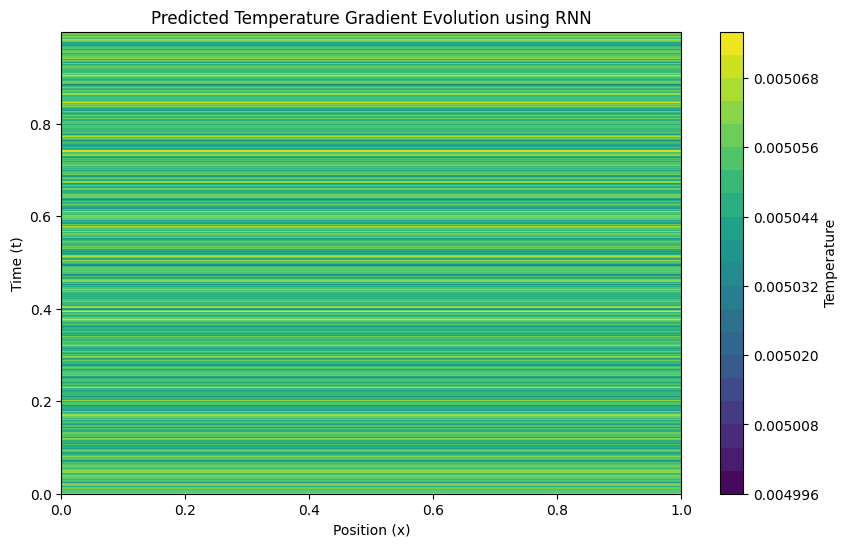

In [78]:
#RMSE/Gradient Rod Evolution over time using Spins:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class Spins:
    def __init__(self, size, initial_condition):
        self.size = size
        self.spins = initial_condition.copy()

    def update(self, alpha, dt, dx):
        new_spins = np.zeros_like(self.spins)

        for i in range(1, self.size - 1):
            # Apply the discretized PDE equation to update spins
            new_spins[i] = self.spins[i] + alpha * (self.spins[i + 1] - 2 * self.spins[i] + self.spins[i - 1]) * dt / dx**2

        # Boundary conditions
        new_spins[0] = 0
        new_spins[-1] = 0

        self.spins = new_spins.copy()

class PDESolver:
    def __init__(self, x_dim, t_dim, dx, dt, alpha, spins):
        self.x_dim = x_dim
        self.t_dim = t_dim
        self.dx = dx
        self.dt = dt
        self.alpha = alpha
        self.spins = spins
        self.grid = np.zeros((x_dim, t_dim))  # Initialize grid for u(x, t)

    def initialize_conditions(self):
        self.grid[:, 0] = self.spins.spins.copy()

    def solve(self):
        for j in range(0, self.t_dim - 1):
            self.spins.update(self.alpha, self.dt, self.dx)
            self.grid[:, j + 1] = self.spins.spins.copy()
            
class RecurrentNN:
    def __init__(self, input_dim, hidden_layer_sizes, output_dim, dropout_rate=0.5, momentum=0.9):
        self.input_dim = input_dim
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_dim = output_dim
        self.dropout_rate = dropout_rate
        self.momentum = momentum
        self.weights = []
        self.biases = []
        self.activations = [self.sigmoid] * (len(hidden_layer_sizes) + 1)  # Sigmoid for hidden layers

        prev_layer_size = input_dim
        for layer_size in hidden_layer_sizes:
            weight_layer = np.random.randn(prev_layer_size, layer_size)
            bias_layer = np.zeros(layer_size)
            self.weights.append(weight_layer)
            self.biases.append(bias_layer)

            prev_layer_size = layer_size

        # Output layer weights
        weight_output = np.random.randn(prev_layer_size, output_dim)
        bias_output = np.zeros(output_dim)
        self.weights.append(weight_output)
        self.biases.append(bias_output)

    def sigmoid(self, x, derivative=False):
        if derivative:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))

    def dropout(self, x):
        if self.dropout_rate >= 1.0:
            return x

        mask = (np.random.rand(*x.shape) < self.dropout_rate) / max(1e-5, (1 - self.dropout_rate))
        return x * mask

    def forward(self, x, training=True):
        layer_input = x
        layer_outputs = [layer_input]
        masks = []

        for i in range(len(self.weights)):
            weighted_sum = np.dot(layer_input, self.weights[i]) + self.biases[i]
            layer_output = self.activations[i](weighted_sum)

            if training and i < len(self.weights) - 1:
                layer_output = self.dropout(layer_output)
                masks.append(layer_output)

            layer_outputs.append(layer_output)
            layer_input = layer_output

        return layer_outputs, masks

    def train(self, input_sequences, target_outputs, learning_rate, num_epochs, desc="Training"):
        num_samples, sequence_length, _ = input_sequences.shape
        training_errors = []  # Store training errors
        min_rmse = float('inf')  # Initialize minimum RMSE

        # Initialize velocities for momentum
        velocities = [np.zeros_like(w) for w in self.weights]
        biases_velocities = [np.zeros_like(b) for b in self.biases]

        for epoch in tqdm(range(num_epochs), desc=desc):
            for sample in range(num_samples):
                input_sequence = input_sequences[sample, :, :]
                target_output = target_outputs[sample, :]

                # Forward pass with dropout
                layer_outputs, masks = self.forward(input_sequence)

                final_output = layer_outputs[-1]

                # Calculate loss
                loss = np.mean((final_output - target_output)**2)
                training_errors.append(loss)

                # Backpropagation Through Time (BPTT) with momentum
                derror = 2 * (final_output - target_output) / num_samples

                for i in range(len(self.weights) - 1, -1, -1):
                    dactivation = self.sigmoid(layer_outputs[i + 1], derivative=True)
                    
                    # Ensure dactivation has the same shape as derror
                    dactivation = dactivation[:, :derror.shape[1]]

                    doutput = derror * dactivation

                    # Apply dropout mask during backpropagation
                    if i < len(self.weights) - 1:
                        doutput *= masks[i]

                    dweights = np.dot(layer_outputs[i].T, doutput)
                    dbiases = np.sum(doutput, axis=0)

                    # Update velocities with momentum
                    velocities[i] = self.momentum * velocities[i] + learning_rate * dweights
                    biases_velocities[i] = self.momentum * biases_velocities[i] + learning_rate * dbiases

                    # Update weights and biases with momentum
                    self.weights[i] -= velocities[i]
                    self.biases[i] -= biases_velocities[i]

                    derror = np.dot(doutput, self.weights[i].T)

                # Calculate and print minimum RMSE during training
                if len(training_errors) % sequence_length == 0:
                    rmse = np.sqrt(np.mean(training_errors[-sequence_length:]))
                    if rmse < min_rmse:
                        min_rmse = rmse
                    print(f'Minimum RMSE at epoch {epoch + 1}: {min_rmse}')

        return training_errors    
        
    def predict(self, input_sequence):
        layer_input = input_sequence
        for i in range(len(self.weights)):
            weighted_sum = np.dot(layer_input, self.weights[i]) + self.biases[i]
            layer_input = self.sigmoid(weighted_sum)

        return layer_input

    def plot_3d_training_progress(self, training_errors_f, training_errors_g):
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        epochs = len(training_errors_f)

        # Ensure that both arrays have the same length
        min_len = min(len(training_errors_f), len(training_errors_g))
        x = np.arange(0, min_len, 1)

        # Plot the 3D line
        ax.plot(x, training_errors_f[:min_len], zs=0, zdir='y', label='RMSE for f(t)')
        ax.plot(x, training_errors_g[:min_len], zs=1, zdir='y', label='RMSE for g(x)')

        ax.set_xlabel('Epochs')
        ax.set_ylabel('Functions')
        ax.set_zlabel('RMSE')
        ax.set_title('3D Plot of RMSE for f(t) and g(x)')
        ax.legend()

        plt.show()

# PDE solver parameters
x_dim = 100
t_dim = 1000
L = 1.0
dx = L / (x_dim - 1)
dt = 0.001
alpha = 0.01

# Create Spins instance for the PDE solver with initial condition sin(pi*x)
initial_condition = np.sin(np.pi * np.linspace(0, 1, x_dim))
spins = Spins(x_dim, initial_condition)

# Create PDE solver with spins
pde_solver = PDESolver(x_dim, t_dim, dx, dt, alpha, spins)

# Initialize initial conditions
pde_solver.initialize_conditions()

# Prepare data for RNN training with spins
num_samples = 20
input_sequences = np.zeros((num_samples, x_dim, t_dim))
target_outputs = np.zeros((num_samples, x_dim, t_dim))

for i in range(num_samples):
    input_sequences[i, :, :] = pde_solver.grid.copy()
    pde_solver.solve()
    target_outputs[i, :, :] = pde_solver.grid.copy()

# RNN parameters
input_dim = x_dim
hidden_layer_sizes = [2, 2, 2, 2, 2, 2, 2, 2]  # 2 layers with 10 neurons each
output_dim = x_dim
learning_rate = 1e-2
num_epochs = 1000
momentum_value = 0.7
dropout_rate = 0.5  # Adjust dropout rate as needed

# Create and train RNN for f(t) and g(x) together with BPTT
rnn_model_fg = RecurrentNN(t_dim, hidden_layer_sizes, t_dim, dropout_rate)
training_errors_fg = rnn_model_fg.train(input_sequences[:, :, :], target_outputs[:, 0, :], learning_rate, num_epochs, desc="Training f(t) and g(x)")

# Predict using the trained RNN
predicted_outputs = np.zeros((num_samples, x_dim, t_dim))
for i in range(num_samples):
    input_sequence = input_sequences[i, :, :]
    predicted_output = rnn_model_fg.predict(input_sequence)
    predicted_outputs[i, :, :] = predicted_output

# Visualize the results
fig, ax = plt.subplots(figsize=(10, 6))
X, T = np.meshgrid(np.linspace(0, L, x_dim), np.linspace(0, dt * (t_dim - 1), t_dim))
Z = predicted_outputs[0, :, :].T  # Transpose the matrix to match the expected shape
contour = ax.contourf(X, T, Z, cmap='viridis', levels=20)
ax.set_xlabel('Position (x)')
ax.set_ylabel('Time (t)')
ax.set_title('Predicted Temperature Gradient Evolution using RNN')
plt.colorbar(contour, ax=ax, label='Temperature')
plt.show()

#Predicted Temperature Gradient Evolution with the RNN, good to compare with the Standard Explicit Scheme.

In [93]:
#Extensive Search Testing 5 Different Activation Functions with 6 different Neuron/Layer configurations,
#2 different learning rates(very small) and 2 different Momentum coefficients, using also
#Gradient Clipping and Weight-Sharing. It seems the implementation of the last 2, specifically,
#improved the training loss greatly, yielding values in the area of ^-11 before applying dropout
#to account for the possibility of overfitting, this time using Monte Carlo Methods for sampling: 
import numpy as np
from itertools import product
import pandas as pd
from tqdm import tqdm

# Define activation functions
def sigmoid(x, derivative=False):
    if derivative:
        return x * (1 - x)
    return 1 / (1 + np.exp(-x))

def sine(x, derivative=False):
    if derivative:
        return np.cos(x)
    return np.sin(x)

def relu(x, derivative=False):
    if derivative:
        return np.where(x > 0, 1, 0)
    return np.maximum(0, x)

def tanh(x, derivative=False):
    if derivative:
        return 1 - np.tanh(x)**2
    return np.tanh(x)

def swish(x, derivative=False):
    if derivative:
        return swish(x) + sigmoid(x) * (1 - swish(x))
    return x * sigmoid(x)

class RecurrentNN:
    def __init__(self, input_dim, hidden_layer_sizes, output_dim, activation_function=sigmoid, dropout_rate=0.0, momentum=0.9):
        self.input_dim = input_dim
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_dim = output_dim
        self.activation_function = activation_function
        self.dropout_rate = dropout_rate
        self.momentum = momentum  # Momentum parameter

        self.weights = []
        self.biases = []
        self.activations = [activation_function] * len(hidden_layer_sizes) + [activation_function]  # Include output layer
        self.dropout_masks = []

    def forward(self, x, training=True):
        layer_input = x
        layer_outputs = [layer_input]

        for i in range(len(self.weights)):
            weighted_sum = self.convolution(layer_input, self.weights[i]) + self.biases[i]
            layer_output = self.activations[i](weighted_sum)

            # Apply dropout if not in training mode or if dropout rate is 0
            if i < len(self.weights) - 1 and training and self.dropout_rate > 0:
                dropout_mask = np.random.binomial(1, 1 - self.dropout_rate, size=layer_output.shape) / (1 - self.dropout_rate)
                layer_output *= dropout_mask
                self.dropout_masks.append(dropout_mask)
            else:
                self.dropout_masks.append(None)

            layer_outputs.append(layer_output)
            layer_input = layer_output

        return layer_outputs
    
    def convolution(self, x, weights):
        # Perform convolution with weight-sharing
        k, _ = weights.shape
        conv_result = np.zeros_like(x)

        for i in range(conv_result.shape[0] - k + 1):
            for j in range(conv_result.shape[1] - k + 1):
                conv_result[i:i + k, j:j + k] += weights * x[i:i + k, j:j + k]

        return conv_result

    def sigmoid(self, x, derivative=False):
        if derivative:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))

    def train(self, input_sequences, target_outputs, learning_rate, num_epochs, batch_size, clip_value=3.0, desc="Training"):
        num_samples, sequence_length, _ = input_sequences.shape
        training_errors = []  # Store training errors

        for epoch in tqdm(range(num_epochs), desc=desc):
            for sample in range(0, num_samples, batch_size):
                batch_input = input_sequences[sample:sample + batch_size, :, :]
                batch_target = target_outputs[sample:sample + batch_size, :]

                # Forward pass
                layer_outputs = self.forward(batch_input, training=True)
                final_output = layer_outputs[-1]
                
                # Calculate loss
                reshaped_final_output = final_output.reshape(batch_target.shape[0], -1)
                reshaped_batch_target = batch_target.reshape(batch_target.shape[0], -1)
                rmse = np.sqrt(np.mean((reshaped_final_output - reshaped_batch_target)**2))
                training_errors.append(rmse)
                
                # Backpropagation Through Time (BPTT)
                derror = 2 * (reshaped_final_output - reshaped_batch_target) / batch_size

                for i in range(len(self.weights) - 1, -1, -1):
                    dactivation = self.sigmoid(layer_outputs[i + 1], derivative=True)
                    doutput = derror * dactivation
                    dweights = self.convolution(layer_outputs[i].T, doutput)
                    dbiases = np.sum(doutput, axis=0)

                    # Clip gradients to avoid exploding gradients
                    dweights = np.clip(dweights, -clip_value, clip_value)
                    dbiases = np.clip(dbiases, -clip_value, clip_value)

                    # Update weights and biases
                    self.weights[i] -= learning_rate * dweights
                    self.biases[i] -= learning_rate * dbiases

                    derror = self.convolution(doutput, self.weights[i])
                    self.dropout_masks = []

        return training_errors

# PDE solver parameters
x_dim = 100
t_dim = 1000
L = 1.0
dx = L / (x_dim - 1)
dt = 0.001
alpha = 0.01

# Create PDE solver
class PDESolver:
    def __init__(self, x_dim, t_dim, dx, dt, alpha):
        self.x_dim = x_dim
        self.t_dim = t_dim
        self.dx = dx
        self.dt = dt
        self.alpha = alpha

        self.grid = np.zeros((x_dim, t_dim))  # Initialize grid for u(x, t)

    def initialize_conditions(self):
        # Set initial conditions u(x, 0) = sin(pi * x) for 0 < x < L
        self.grid[:, 0] = np.sin(np.pi * np.linspace(0, 1, self.x_dim))

       # Inside PDESolver class
    def solve(self):
        for j in range(0, self.t_dim - 1):
            for i in range(1, self.x_dim - 1):
                # Forward Euler discretization for the given PDE with gradient clipping
                gradient = (self.grid[i + 1, j] - 2 * self.grid[i, j] + self.grid[i - 1, j]) / self.dx**2
                self.grid[i, j + 1] = self.grid[i, j] + self.alpha * np.clip(gradient, -1.0, 1.0) * self.dt

# Prepare data for RNN training with the specified ansatz
pde_solver = PDESolver(x_dim, t_dim, dx, dt, alpha)
pde_solver.initialize_conditions()
pde_solver.solve()

# Prepare data for RNN training with the specified ansatz
input_sequences = np.zeros((t_dim - 1, x_dim, 1))
target_outputs_f = np.zeros((t_dim - 1, x_dim))

for i in range(t_dim - 1):
    input_sequences[i, :, 0] = pde_solver.grid[:, i]
    target_outputs_f[i, :] = pde_solver.grid[:, i + 1]

# RNN parameters
dropout_rate = 1  # Adjust the dropout rate as needed
momentum = 0.9
rnn_model = RecurrentNN(t_dim, hidden_layer_sizes, t_dim, activation_function=sigmoid, dropout_rate=dropout_rate, momentum=momentum)
num_epochs = 500
batch_size = 50
mc_samples = 5

# Simplified search space with two hidden layer sizes
hidden_layer_sizes_options = [[3], [10], [25], [3, 3], [10, 10], [25, 25]]
activation_functions = [sigmoid, sine, relu, tanh, swish]
momentum_options = [0.7, 1.0]
learning_rates = [1e-6, 1e-7]

# Perform simplified grid search
results_table = []

# Perform Monte Carlo sampling during training
for hidden_layer_sizes, activation_function, momentum, learning_rate in product(
    hidden_layer_sizes_options, activation_functions, momentum_options, learning_rates
):
    rnn_model = RecurrentNN(t_dim, hidden_layer_sizes, t_dim, activation_function=activation_function, dropout_rate=dropout_rate, momentum=momentum)
    training_errors_fg = rnn_model.train(input_sequences[:, :, :], target_outputs_f, learning_rate, num_epochs, mc_samples, desc="Training f(t) and g(x)")

    results_table.append({
        'Hidden Layers': len(hidden_layer_sizes),
        'Neurons per Layer': hidden_layer_sizes,
        'Activation Function': activation_function.__name__,
        'Momentum': momentum,
        'Learning Rate': learning_rate,
        'Dropout Rate': dropout_rate,
        'Min Training Loss': np.min(training_errors_fg)
    })

# Display the results table
results_df = pd.DataFrame(results_table)
print(results_df)

#This time, on top of the batches, Monte Carlo simulation is performed, and 120 combinations tested. The minimum RMSE is now very good
#and we can't hope for much better.

Training f(t) and g(x): 100%|███████████████████████████████████████████████████████| 500/500 [00:04<00:00, 112.60it/s]


     Hidden Layers Neurons per Layer Activation Function  Momentum  \
0                1               [3]             sigmoid       0.7   
1                1               [3]             sigmoid       0.7   
2                1               [3]             sigmoid       1.0   
3                1               [3]             sigmoid       1.0   
4                1               [3]                sine       0.7   
..             ...               ...                 ...       ...   
115              2          [25, 25]                tanh       1.0   
116              2          [25, 25]               swish       0.7   
117              2          [25, 25]               swish       0.7   
118              2          [25, 25]               swish       1.0   
119              2          [25, 25]               swish       1.0   

     Learning Rate  Dropout Rate  Min Training Loss  
0     1.000000e-06             1           0.000009  
1     1.000000e-07             1           0.000009

Training f(t) and g(x):   1%|▍                                                        | 8/1000 [00:00<01:04, 15.47it/s]

Minimum RMSE at epoch 5: 1.4143779586463032


Training f(t) and g(x):   1%|▋                                                       | 12/1000 [00:00<01:04, 15.33it/s]

Minimum RMSE at epoch 10: 1.3853502958759707


Training f(t) and g(x):   2%|█                                                       | 18/1000 [00:01<01:03, 15.48it/s]

Minimum RMSE at epoch 15: 1.3711031168738546


Training f(t) and g(x):   2%|█▏                                                      | 22/1000 [00:01<01:03, 15.35it/s]

Minimum RMSE at epoch 20: 1.357261435632912


Training f(t) and g(x):   3%|█▍                                                      | 26/1000 [00:01<01:03, 15.28it/s]

Minimum RMSE at epoch 25: 1.3436432813752575


Training f(t) and g(x):   3%|█▊                                                      | 32/1000 [00:02<01:04, 14.92it/s]

Minimum RMSE at epoch 30: 1.3301991538596571


Training f(t) and g(x):   4%|██▏                                                     | 38/1000 [00:02<01:03, 15.22it/s]

Minimum RMSE at epoch 35: 1.3169094078895704


Training f(t) and g(x):   4%|██▎                                                     | 42/1000 [00:02<01:02, 15.22it/s]

Minimum RMSE at epoch 40: 1.3037642858686789


Training f(t) and g(x):   5%|██▌                                                     | 46/1000 [00:03<01:03, 15.05it/s]

Minimum RMSE at epoch 45: 1.290757831435704


Training f(t) and g(x):   5%|██▉                                                     | 52/1000 [00:03<01:02, 15.11it/s]

Minimum RMSE at epoch 50: 1.2778862779047435


Training f(t) and g(x):   6%|███▏                                                    | 58/1000 [00:03<01:01, 15.29it/s]

Minimum RMSE at epoch 55: 1.2651465069539638


Training f(t) and g(x):   6%|███▍                                                    | 62/1000 [00:04<01:01, 15.25it/s]

Minimum RMSE at epoch 60: 1.252536381619556


Training f(t) and g(x):   7%|███▋                                                    | 66/1000 [00:04<00:59, 15.63it/s]

Minimum RMSE at epoch 65: 1.2400539375953066


Training f(t) and g(x):   7%|████                                                    | 72/1000 [00:04<00:59, 15.59it/s]

Minimum RMSE at epoch 70: 1.2276972553926546


Training f(t) and g(x):   8%|████▎                                                   | 78/1000 [00:05<00:59, 15.57it/s]

Minimum RMSE at epoch 75: 1.215464756233754


Training f(t) and g(x):   8%|████▌                                                   | 82/1000 [00:05<00:59, 15.39it/s]

Minimum RMSE at epoch 80: 1.203355079516708


Training f(t) and g(x):   9%|████▉                                                   | 88/1000 [00:05<00:58, 15.51it/s]

Minimum RMSE at epoch 85: 1.1913668181703922


Training f(t) and g(x):   9%|█████▏                                                  | 92/1000 [00:06<00:59, 15.35it/s]

Minimum RMSE at epoch 90: 1.17949851121328


Training f(t) and g(x):  10%|█████▍                                                  | 96/1000 [00:06<00:59, 15.28it/s]

Minimum RMSE at epoch 95: 1.167749000180952


Training f(t) and g(x):  10%|█████▌                                                 | 102/1000 [00:06<00:58, 15.47it/s]

Minimum RMSE at epoch 100: 1.156116960123472


Training f(t) and g(x):  11%|█████▉                                                 | 108/1000 [00:07<00:57, 15.53it/s]

Minimum RMSE at epoch 105: 1.1446010946578256


Training f(t) and g(x):  11%|██████▏                                                | 112/1000 [00:07<00:56, 15.77it/s]

Minimum RMSE at epoch 110: 1.1332002226166613


Training f(t) and g(x):  12%|██████▍                                                | 118/1000 [00:07<00:56, 15.63it/s]

Minimum RMSE at epoch 115: 1.1219131618732334


Training f(t) and g(x):  12%|██████▋                                                | 122/1000 [00:07<00:56, 15.41it/s]

Minimum RMSE at epoch 120: 1.1107387165818559


Training f(t) and g(x):  13%|██████▉                                                | 126/1000 [00:08<00:55, 15.71it/s]

Minimum RMSE at epoch 125: 1.099675770051103


Training f(t) and g(x):  13%|███████▎                                               | 132/1000 [00:08<00:57, 15.06it/s]

Minimum RMSE at epoch 130: 1.0887231397804602


Training f(t) and g(x):  14%|███████▍                                               | 136/1000 [00:08<00:57, 14.98it/s]

Minimum RMSE at epoch 135: 1.0778797608004183


Training f(t) and g(x):  14%|███████▊                                               | 142/1000 [00:09<00:56, 15.08it/s]

Minimum RMSE at epoch 140: 1.0671445191603042


Training f(t) and g(x):  15%|████████▏                                              | 148/1000 [00:09<00:55, 15.28it/s]

Minimum RMSE at epoch 145: 1.0565162864155253


Training f(t) and g(x):  15%|████████▎                                              | 152/1000 [00:09<00:55, 15.24it/s]

Minimum RMSE at epoch 150: 1.0459939876269169


Training f(t) and g(x):  16%|████████▋                                              | 158/1000 [00:10<00:54, 15.34it/s]

Minimum RMSE at epoch 155: 1.0355765771426546


Training f(t) and g(x):  16%|████████▉                                              | 162/1000 [00:10<00:54, 15.28it/s]

Minimum RMSE at epoch 160: 1.0252630065096695


Training f(t) and g(x):  17%|█████████▏                                             | 168/1000 [00:11<00:53, 15.45it/s]

Minimum RMSE at epoch 165: 1.0150522044142245


Training f(t) and g(x):  17%|█████████▍                                             | 172/1000 [00:11<00:53, 15.33it/s]

Minimum RMSE at epoch 170: 1.0049431557684112


Training f(t) and g(x):  18%|█████████▊                                             | 178/1000 [00:11<00:53, 15.49it/s]

Minimum RMSE at epoch 175: 0.9949348934242414


Training f(t) and g(x):  18%|██████████                                             | 182/1000 [00:11<00:52, 15.50it/s]

Minimum RMSE at epoch 180: 0.985026327353572


Training f(t) and g(x):  19%|██████████▏                                            | 186/1000 [00:12<00:56, 14.47it/s]

Minimum RMSE at epoch 185: 0.9752164743811164


Training f(t) and g(x):  19%|██████████▌                                            | 192/1000 [00:12<00:58, 13.76it/s]

Minimum RMSE at epoch 190: 0.96550435199071


Training f(t) and g(x):  20%|██████████▊                                            | 196/1000 [00:13<01:10, 11.47it/s]

Minimum RMSE at epoch 195: 0.9558890226204858


Training f(t) and g(x):  20%|███████████                                            | 202/1000 [00:13<00:58, 13.64it/s]

Minimum RMSE at epoch 200: 0.9463694908293965


Training f(t) and g(x):  21%|███████████▎                                           | 206/1000 [00:13<00:56, 13.93it/s]

Minimum RMSE at epoch 205: 0.9369448015954961


Training f(t) and g(x):  21%|███████████▋                                           | 212/1000 [00:14<00:56, 14.06it/s]

Minimum RMSE at epoch 210: 0.9276139868384732


Training f(t) and g(x):  22%|███████████▉                                           | 216/1000 [00:14<00:58, 13.41it/s]

Minimum RMSE at epoch 215: 0.9183761448527289


Training f(t) and g(x):  22%|████████████                                           | 220/1000 [00:14<00:59, 13.01it/s]

Minimum RMSE at epoch 220: 0.9092303085357862


Training f(t) and g(x):  23%|████████████▍                                          | 226/1000 [00:15<01:08, 11.32it/s]

Minimum RMSE at epoch 225: 0.9001755936870037


Training f(t) and g(x):  23%|████████████▊                                          | 232/1000 [00:15<00:57, 13.33it/s]

Minimum RMSE at epoch 230: 0.8912110865771713


Training f(t) and g(x):  24%|█████████████                                          | 238/1000 [00:16<00:57, 13.28it/s]

Minimum RMSE at epoch 235: 0.8823358667706824


Training f(t) and g(x):  24%|█████████████▎                                         | 242/1000 [00:16<00:53, 14.20it/s]

Minimum RMSE at epoch 240: 0.8735490369453058


Training f(t) and g(x):  25%|█████████████▌                                         | 246/1000 [00:16<00:58, 12.86it/s]

Minimum RMSE at epoch 245: 0.8648497499399466


Training f(t) and g(x):  25%|█████████████▊                                         | 252/1000 [00:17<01:02, 11.90it/s]

Minimum RMSE at epoch 250: 0.8562371221026123


Training f(t) and g(x):  26%|██████████████▏                                        | 258/1000 [00:17<00:52, 14.18it/s]

Minimum RMSE at epoch 255: 0.847710299434829


Training f(t) and g(x):  26%|██████████████▎                                        | 260/1000 [00:17<00:55, 13.32it/s]

Minimum RMSE at epoch 260: 0.8392684075887379


Training f(t) and g(x):  27%|██████████████▋                                        | 268/1000 [00:18<00:59, 12.36it/s]

Minimum RMSE at epoch 265: 0.8309105584258364


Training f(t) and g(x):  27%|██████████████▉                                        | 272/1000 [00:18<00:53, 13.63it/s]

Minimum RMSE at epoch 270: 0.8226359793410271


Training f(t) and g(x):  28%|███████████████▏                                       | 276/1000 [00:19<00:56, 12.89it/s]

Minimum RMSE at epoch 275: 0.8144438400773069


Training f(t) and g(x):  28%|███████████████▌                                       | 282/1000 [00:19<01:05, 10.91it/s]

Minimum RMSE at epoch 280: 0.8063332553763393


Training f(t) and g(x):  29%|███████████████▋                                       | 286/1000 [00:20<01:09, 10.34it/s]

Minimum RMSE at epoch 285: 0.7983034876974414


Training f(t) and g(x):  29%|████████████████                                       | 292/1000 [00:20<01:11,  9.86it/s]

Minimum RMSE at epoch 290: 0.7903537096173976


Training f(t) and g(x):  30%|████████████████▎                                      | 296/1000 [00:21<01:00, 11.56it/s]

Minimum RMSE at epoch 295: 0.7824831183958527


Training f(t) and g(x):  30%|████████████████▌                                      | 302/1000 [00:21<00:53, 12.93it/s]

Minimum RMSE at epoch 300: 0.7746909125183162


Training f(t) and g(x):  31%|████████████████▊                                      | 306/1000 [00:21<00:51, 13.36it/s]

Minimum RMSE at epoch 305: 0.766976315113319


Training f(t) and g(x):  31%|█████████████████▏                                     | 312/1000 [00:22<00:52, 13.19it/s]

Minimum RMSE at epoch 310: 0.7593385513993953


Training f(t) and g(x):  32%|█████████████████▍                                     | 316/1000 [00:22<00:52, 13.09it/s]

Minimum RMSE at epoch 315: 0.75177686136517


Training f(t) and g(x):  32%|█████████████████▋                                     | 322/1000 [00:23<00:53, 12.57it/s]

Minimum RMSE at epoch 320: 0.7442904866852348


Training f(t) and g(x):  33%|█████████████████▉                                     | 326/1000 [00:23<00:53, 12.51it/s]

Minimum RMSE at epoch 325: 0.7368786647841259


Training f(t) and g(x):  33%|██████████████████▎                                    | 332/1000 [00:23<00:47, 14.17it/s]

Minimum RMSE at epoch 330: 0.7295406825972548


Training f(t) and g(x):  34%|██████████████████▍                                    | 336/1000 [00:24<00:44, 15.05it/s]

Minimum RMSE at epoch 335: 0.7222757952301281


Training f(t) and g(x):  34%|██████████████████▊                                    | 342/1000 [00:24<00:46, 14.28it/s]

Minimum RMSE at epoch 340: 0.7150832542109871


Training f(t) and g(x):  35%|███████████████████                                    | 346/1000 [00:24<00:43, 15.11it/s]

Minimum RMSE at epoch 345: 0.707962345175848


Training f(t) and g(x):  35%|███████████████████▎                                   | 352/1000 [00:25<00:42, 15.41it/s]

Minimum RMSE at epoch 350: 0.7009123741446153


Training f(t) and g(x):  36%|███████████████████▋                                   | 358/1000 [00:25<00:42, 15.15it/s]

Minimum RMSE at epoch 355: 0.6939326165027647


Training f(t) and g(x):  36%|███████████████████▉                                   | 362/1000 [00:25<00:43, 14.71it/s]

Minimum RMSE at epoch 360: 0.6870223798529639


Training f(t) and g(x):  37%|████████████████████▏                                  | 368/1000 [00:26<00:42, 14.80it/s]

Minimum RMSE at epoch 365: 0.6801809642580323


Training f(t) and g(x):  37%|████████████████████▍                                  | 372/1000 [00:26<00:44, 14.00it/s]

Minimum RMSE at epoch 370: 0.6734077027071428


Training f(t) and g(x):  38%|████████████████████▋                                  | 376/1000 [00:26<00:41, 14.95it/s]

Minimum RMSE at epoch 375: 0.6667019035716989


Training f(t) and g(x):  38%|█████████████████████                                  | 382/1000 [00:27<00:40, 15.16it/s]

Minimum RMSE at epoch 380: 0.6600628868862972


Training f(t) and g(x):  39%|█████████████████████▏                                 | 386/1000 [00:27<00:43, 14.20it/s]

Minimum RMSE at epoch 385: 0.6534899888134297


Training f(t) and g(x):  39%|█████████████████████▌                                 | 392/1000 [00:27<00:40, 14.90it/s]

Minimum RMSE at epoch 390: 0.6469825641759659


Training f(t) and g(x):  40%|█████████████████████▊                                 | 396/1000 [00:28<00:41, 14.55it/s]

Minimum RMSE at epoch 395: 0.6405399559137107


Training f(t) and g(x):  40%|██████████████████████                                 | 402/1000 [00:28<00:41, 14.53it/s]

Minimum RMSE at epoch 400: 0.6341615137484743


Training f(t) and g(x):  41%|██████████████████████▎                                | 406/1000 [00:28<00:39, 14.86it/s]

Minimum RMSE at epoch 405: 0.6278465968141363


Training f(t) and g(x):  41%|██████████████████████▋                                | 412/1000 [00:29<00:38, 15.17it/s]

Minimum RMSE at epoch 410: 0.6215945682059552


Training f(t) and g(x):  42%|██████████████████████▉                                | 416/1000 [00:29<00:38, 15.15it/s]

Minimum RMSE at epoch 415: 0.6154048250764536


Training f(t) and g(x):  42%|███████████████████████▏                               | 422/1000 [00:30<00:43, 13.36it/s]

Minimum RMSE at epoch 420: 0.6092767366541948


Training f(t) and g(x):  43%|███████████████████████▍                               | 426/1000 [00:30<00:43, 13.26it/s]

Minimum RMSE at epoch 425: 0.6032096810327718


Training f(t) and g(x):  43%|███████████████████████▊                               | 432/1000 [00:30<00:43, 13.16it/s]

Minimum RMSE at epoch 430: 0.5972030565559552


Training f(t) and g(x):  44%|███████████████████████▉                               | 436/1000 [00:31<00:44, 12.78it/s]

Minimum RMSE at epoch 435: 0.5912562607380086


Training f(t) and g(x):  44%|████████████████████████▎                              | 442/1000 [00:31<00:42, 13.00it/s]

Minimum RMSE at epoch 440: 0.5853686857352449


Training f(t) and g(x):  45%|████████████████████████▌                              | 446/1000 [00:31<00:43, 12.75it/s]

Minimum RMSE at epoch 445: 0.5795397521898041


Training f(t) and g(x):  45%|████████████████████████▊                              | 452/1000 [00:32<00:37, 14.56it/s]

Minimum RMSE at epoch 450: 0.5737688802351704


Training f(t) and g(x):  46%|█████████████████████████▏                             | 458/1000 [00:32<00:35, 15.14it/s]

Minimum RMSE at epoch 455: 0.5680554757161583


Training f(t) and g(x):  46%|█████████████████████████▍                             | 462/1000 [00:32<00:36, 14.93it/s]

Minimum RMSE at epoch 460: 0.5623989852883973


Training f(t) and g(x):  47%|█████████████████████████▋                             | 468/1000 [00:33<00:34, 15.48it/s]

Minimum RMSE at epoch 465: 0.5567988372288315


Training f(t) and g(x):  47%|█████████████████████████▉                             | 472/1000 [00:33<00:34, 15.32it/s]

Minimum RMSE at epoch 470: 0.5512544651767682


Training f(t) and g(x):  48%|██████████████████████████▏                            | 476/1000 [00:33<00:34, 15.27it/s]

Minimum RMSE at epoch 475: 0.5457653042636293


Training f(t) and g(x):  48%|██████████████████████████▌                            | 482/1000 [00:34<00:33, 15.27it/s]

Minimum RMSE at epoch 480: 0.5403308119877148


Training f(t) and g(x):  49%|██████████████████████████▋                            | 486/1000 [00:34<00:34, 14.81it/s]

Minimum RMSE at epoch 485: 0.5349504468096532


Training f(t) and g(x):  49%|███████████████████████████                            | 492/1000 [00:34<00:33, 15.25it/s]

Minimum RMSE at epoch 490: 0.5296236817061928


Training f(t) and g(x):  50%|███████████████████████████▍                           | 498/1000 [00:35<00:33, 15.20it/s]

Minimum RMSE at epoch 495: 0.5243499700260557


Training f(t) and g(x):  50%|███████████████████████████▌                           | 502/1000 [00:35<00:33, 14.80it/s]

Minimum RMSE at epoch 500: 0.519128778423744


Training f(t) and g(x):  51%|███████████████████████████▉                           | 508/1000 [00:35<00:32, 15.36it/s]

Minimum RMSE at epoch 505: 0.5139595844885354


Training f(t) and g(x):  51%|████████████████████████████▏                          | 512/1000 [00:36<00:34, 14.11it/s]

Minimum RMSE at epoch 510: 0.5088418880737127


Training f(t) and g(x):  52%|████████████████████████████▍                          | 516/1000 [00:36<00:37, 12.99it/s]

Minimum RMSE at epoch 515: 0.5037751680749971


Training f(t) and g(x):  52%|████████████████████████████▋                          | 522/1000 [00:37<00:34, 13.72it/s]

Minimum RMSE at epoch 520: 0.49875891167192427


Training f(t) and g(x):  53%|█████████████████████████████                          | 528/1000 [00:37<00:31, 14.75it/s]

Minimum RMSE at epoch 525: 0.4937926125635627


Training f(t) and g(x):  53%|█████████████████████████████▎                         | 532/1000 [00:37<00:32, 14.20it/s]

Minimum RMSE at epoch 530: 0.4888757839346273


Training f(t) and g(x):  54%|█████████████████████████████▌                         | 538/1000 [00:38<00:30, 15.08it/s]

Minimum RMSE at epoch 535: 0.4840079177003703


Training f(t) and g(x):  54%|█████████████████████████████▊                         | 542/1000 [00:38<00:31, 14.47it/s]

Minimum RMSE at epoch 540: 0.4791885437325441


Training f(t) and g(x):  55%|██████████████████████████████                         | 546/1000 [00:38<00:30, 14.70it/s]

Minimum RMSE at epoch 545: 0.474417175298158


Training f(t) and g(x):  55%|██████████████████████████████▎                        | 552/1000 [00:39<00:29, 15.08it/s]

Minimum RMSE at epoch 550: 0.4696933283006652


Training f(t) and g(x):  56%|██████████████████████████████▋                        | 558/1000 [00:39<00:29, 15.19it/s]

Minimum RMSE at epoch 555: 0.4650165373893641


Training f(t) and g(x):  56%|██████████████████████████████▉                        | 562/1000 [00:39<00:29, 14.84it/s]

Minimum RMSE at epoch 560: 0.4603863183020697


Training f(t) and g(x):  57%|███████████████████████████████▏                       | 566/1000 [00:39<00:28, 15.41it/s]

Minimum RMSE at epoch 565: 0.45580221586030456


Training f(t) and g(x):  57%|███████████████████████████████▍                       | 572/1000 [00:40<00:29, 14.43it/s]

Minimum RMSE at epoch 570: 0.45126377799751943


Training f(t) and g(x):  58%|███████████████████████████████▋                       | 576/1000 [00:40<00:29, 14.29it/s]

Minimum RMSE at epoch 575: 0.446770545575748


Training f(t) and g(x):  58%|████████████████████████████████                       | 582/1000 [00:41<00:28, 14.82it/s]

Minimum RMSE at epoch 580: 0.44232205689750376


Training f(t) and g(x):  59%|████████████████████████████████▎                      | 588/1000 [00:41<00:28, 14.34it/s]

Minimum RMSE at epoch 585: 0.43791788252213387


Training f(t) and g(x):  59%|████████████████████████████████▌                      | 592/1000 [00:41<00:28, 14.13it/s]

Minimum RMSE at epoch 590: 0.4335575821773524


Training f(t) and g(x):  60%|████████████████████████████████▉                      | 598/1000 [00:42<00:27, 14.38it/s]

Minimum RMSE at epoch 595: 0.4292406977407647


Training f(t) and g(x):  60%|█████████████████████████████████                      | 600/1000 [00:42<00:30, 13.28it/s]

Minimum RMSE at epoch 600: 0.4249668023561359


Training f(t) and g(x):  61%|█████████████████████████████████▎                     | 606/1000 [00:42<00:30, 12.81it/s]

Minimum RMSE at epoch 605: 0.4207354906329043


Training f(t) and g(x):  61%|█████████████████████████████████▋                     | 612/1000 [00:43<00:29, 13.03it/s]

Minimum RMSE at epoch 610: 0.4165463142280622


Training f(t) and g(x):  62%|█████████████████████████████████▉                     | 616/1000 [00:43<00:33, 11.61it/s]

Minimum RMSE at epoch 615: 0.4123988662136133


Training f(t) and g(x):  62%|██████████████████████████████████▏                    | 622/1000 [00:44<00:28, 13.14it/s]

Minimum RMSE at epoch 620: 0.408292733651921


Training f(t) and g(x):  63%|██████████████████████████████████▍                    | 626/1000 [00:44<00:28, 13.05it/s]

Minimum RMSE at epoch 625: 0.4042275118339376


Training f(t) and g(x):  63%|██████████████████████████████████▊                    | 632/1000 [00:44<00:27, 13.46it/s]

Minimum RMSE at epoch 630: 0.40020277229855084


Training f(t) and g(x):  64%|██████████████████████████████████▉                    | 636/1000 [00:45<00:27, 13.32it/s]

Minimum RMSE at epoch 635: 0.3962181237782246


Training f(t) and g(x):  64%|███████████████████████████████████▏                   | 640/1000 [00:45<00:28, 12.72it/s]

Minimum RMSE at epoch 640: 0.3922731600473613


Training f(t) and g(x):  65%|███████████████████████████████████▌                   | 646/1000 [00:46<00:30, 11.65it/s]

Minimum RMSE at epoch 645: 0.3883674841224722


Training f(t) and g(x):  65%|███████████████████████████████████▊                   | 652/1000 [00:46<00:27, 12.71it/s]

Minimum RMSE at epoch 650: 0.3845007078399167


Training f(t) and g(x):  66%|████████████████████████████████████                   | 656/1000 [00:46<00:27, 12.36it/s]

Minimum RMSE at epoch 655: 0.3806724450124256


Training f(t) and g(x):  66%|████████████████████████████████████▍                  | 662/1000 [00:47<00:26, 12.72it/s]

Minimum RMSE at epoch 660: 0.37688231074658174


Training f(t) and g(x):  67%|████████████████████████████████████▋                  | 666/1000 [00:47<00:26, 12.45it/s]

Minimum RMSE at epoch 665: 0.37312993154872093


Training f(t) and g(x):  67%|████████████████████████████████████▉                  | 672/1000 [00:48<00:25, 12.82it/s]

Minimum RMSE at epoch 670: 0.3694149343285829


Training f(t) and g(x):  68%|█████████████████████████████████████▎                 | 678/1000 [00:48<00:22, 14.34it/s]

Minimum RMSE at epoch 675: 0.36573693922404116


Training f(t) and g(x):  68%|█████████████████████████████████████▌                 | 682/1000 [00:48<00:22, 14.29it/s]

Minimum RMSE at epoch 680: 0.36209558553190413


Training f(t) and g(x):  69%|█████████████████████████████████████▋                 | 686/1000 [00:49<00:24, 13.01it/s]

Minimum RMSE at epoch 685: 0.35849050462211896


Training f(t) and g(x):  69%|██████████████████████████████████████                 | 692/1000 [00:49<00:21, 14.01it/s]

Minimum RMSE at epoch 690: 0.35492133310605745


Training f(t) and g(x):  70%|██████████████████████████████████████▎                | 696/1000 [00:49<00:22, 13.67it/s]

Minimum RMSE at epoch 695: 0.35138769619761967


Training f(t) and g(x):  70%|██████████████████████████████████████▌                | 702/1000 [00:50<00:21, 14.12it/s]

Minimum RMSE at epoch 700: 0.3478892669813318


Training f(t) and g(x):  71%|██████████████████████████████████████▊                | 706/1000 [00:50<00:20, 14.30it/s]

Minimum RMSE at epoch 705: 0.3444256674416617


Training f(t) and g(x):  71%|███████████████████████████████████████▏               | 712/1000 [00:50<00:20, 13.95it/s]

Minimum RMSE at epoch 710: 0.34099657336687555


Training f(t) and g(x):  72%|███████████████████████████████████████▍               | 716/1000 [00:51<00:19, 14.27it/s]

Minimum RMSE at epoch 715: 0.3376016467798159


Training f(t) and g(x):  72%|███████████████████████████████████████▋               | 722/1000 [00:51<00:19, 14.54it/s]

Minimum RMSE at epoch 720: 0.3342405273767937


Training f(t) and g(x):  73%|███████████████████████████████████████▉               | 726/1000 [00:51<00:19, 14.08it/s]

Minimum RMSE at epoch 725: 0.33091289366308135


Training f(t) and g(x):  73%|████████████████████████████████████████▎              | 732/1000 [00:52<00:18, 14.24it/s]

Minimum RMSE at epoch 730: 0.3276184027852814


Training f(t) and g(x):  74%|████████████████████████████████████████▍              | 736/1000 [00:52<00:18, 13.94it/s]

Minimum RMSE at epoch 735: 0.32435672621720196


Training f(t) and g(x):  74%|████████████████████████████████████████▊              | 742/1000 [00:53<00:18, 14.32it/s]

Minimum RMSE at epoch 740: 0.32112753877760003


Training f(t) and g(x):  75%|█████████████████████████████████████████              | 746/1000 [00:53<00:18, 13.96it/s]

Minimum RMSE at epoch 745: 0.3179305132172761


Training f(t) and g(x):  75%|█████████████████████████████████████████▎             | 752/1000 [00:53<00:16, 14.72it/s]

Minimum RMSE at epoch 750: 0.31476533817684726


Training f(t) and g(x):  76%|█████████████████████████████████████████▌             | 756/1000 [00:54<00:15, 15.33it/s]

Minimum RMSE at epoch 755: 0.3116316939083119


Training f(t) and g(x):  76%|█████████████████████████████████████████▉             | 762/1000 [00:54<00:16, 14.57it/s]

Minimum RMSE at epoch 760: 0.30852925329993564


Training f(t) and g(x):  77%|██████████████████████████████████████████▏            | 768/1000 [00:54<00:16, 14.05it/s]

Minimum RMSE at epoch 765: 0.305457716535103


Training f(t) and g(x):  77%|██████████████████████████████████████████▍            | 772/1000 [00:55<00:15, 14.67it/s]

Minimum RMSE at epoch 770: 0.3024167763883781


Training f(t) and g(x):  78%|██████████████████████████████████████████▊            | 778/1000 [00:55<00:15, 14.52it/s]

Minimum RMSE at epoch 775: 0.2994061270628523


Training f(t) and g(x):  78%|██████████████████████████████████████████▉            | 780/1000 [00:55<00:15, 14.17it/s]

Minimum RMSE at epoch 780: 0.2964254704445785


Training f(t) and g(x):  79%|███████████████████████████████████████████▏           | 786/1000 [00:56<00:15, 13.93it/s]

Minimum RMSE at epoch 785: 0.29347451066035735


Training f(t) and g(x):  79%|███████████████████████████████████████████▌           | 792/1000 [00:56<00:14, 13.89it/s]

Minimum RMSE at epoch 790: 0.29055294763568357


Training f(t) and g(x):  80%|███████████████████████████████████████████▊           | 796/1000 [00:56<00:16, 12.47it/s]

Minimum RMSE at epoch 795: 0.2876604773795293


Training f(t) and g(x):  80%|████████████████████████████████████████████           | 802/1000 [00:57<00:17, 11.61it/s]

Minimum RMSE at epoch 800: 0.28479681776116617


Training f(t) and g(x):  81%|████████████████████████████████████████████▎          | 806/1000 [00:57<00:14, 13.04it/s]

Minimum RMSE at epoch 805: 0.2819616838840529


Training f(t) and g(x):  81%|████████████████████████████████████████████▋          | 812/1000 [00:58<00:12, 14.60it/s]

Minimum RMSE at epoch 810: 0.2791547849294678


Training f(t) and g(x):  82%|████████████████████████████████████████████▉          | 816/1000 [00:58<00:12, 14.75it/s]

Minimum RMSE at epoch 815: 0.2763758494833497


Training f(t) and g(x):  82%|█████████████████████████████████████████████▏         | 822/1000 [00:58<00:11, 15.48it/s]

Minimum RMSE at epoch 820: 0.2736245983077775


Training f(t) and g(x):  83%|█████████████████████████████████████████████▌         | 828/1000 [00:59<00:11, 15.37it/s]

Minimum RMSE at epoch 825: 0.2709007639306272


Training f(t) and g(x):  83%|█████████████████████████████████████████████▊         | 832/1000 [00:59<00:10, 15.56it/s]

Minimum RMSE at epoch 830: 0.2682040564381465


Training f(t) and g(x):  84%|██████████████████████████████████████████████         | 838/1000 [00:59<00:10, 15.62it/s]

Minimum RMSE at epoch 835: 0.26553421448891257


Training f(t) and g(x):  84%|██████████████████████████████████████████████▎        | 842/1000 [01:00<00:10, 15.32it/s]

Minimum RMSE at epoch 840: 0.2628909648555906


Training f(t) and g(x):  85%|██████████████████████████████████████████████▋        | 848/1000 [01:00<00:09, 15.30it/s]

Minimum RMSE at epoch 845: 0.2602740414534012


Training f(t) and g(x):  85%|██████████████████████████████████████████████▊        | 852/1000 [01:00<00:10, 13.63it/s]

Minimum RMSE at epoch 850: 0.2576831893489824


Training f(t) and g(x):  86%|███████████████████████████████████████████████        | 856/1000 [01:01<00:10, 13.50it/s]

Minimum RMSE at epoch 855: 0.2551181428323858


Training f(t) and g(x):  86%|███████████████████████████████████████████████▍       | 862/1000 [01:01<00:11, 11.75it/s]

Minimum RMSE at epoch 860: 0.2525786412340714


Training f(t) and g(x):  87%|███████████████████████████████████████████████▋       | 866/1000 [01:01<00:10, 13.40it/s]

Minimum RMSE at epoch 865: 0.2500644418180229


Training f(t) and g(x):  87%|███████████████████████████████████████████████▉       | 872/1000 [01:02<00:09, 13.24it/s]

Minimum RMSE at epoch 870: 0.24757528640061885


Training f(t) and g(x):  88%|████████████████████████████████████████████████▏      | 876/1000 [01:02<00:09, 13.65it/s]

Minimum RMSE at epoch 875: 0.24511093062607112


Training f(t) and g(x):  88%|████████████████████████████████████████████████▌      | 882/1000 [01:03<00:08, 14.48it/s]

Minimum RMSE at epoch 880: 0.24267112382319672


Training f(t) and g(x):  89%|████████████████████████████████████████████████▊      | 888/1000 [01:03<00:07, 14.88it/s]

Minimum RMSE at epoch 885: 0.24025561719976007


Training f(t) and g(x):  89%|█████████████████████████████████████████████████      | 892/1000 [01:03<00:07, 14.43it/s]

Minimum RMSE at epoch 890: 0.23786417819889227


Training f(t) and g(x):  90%|█████████████████████████████████████████████████▍     | 898/1000 [01:04<00:06, 14.77it/s]

Minimum RMSE at epoch 895: 0.23549655845353068


Training f(t) and g(x):  90%|█████████████████████████████████████████████████▌     | 902/1000 [01:04<00:06, 14.59it/s]

Minimum RMSE at epoch 900: 0.2331525200223594


Training f(t) and g(x):  91%|█████████████████████████████████████████████████▊     | 906/1000 [01:04<00:06, 14.47it/s]

Minimum RMSE at epoch 905: 0.2308318295392347


Training f(t) and g(x):  91%|██████████████████████████████████████████████████▏    | 912/1000 [01:05<00:05, 14.98it/s]

Minimum RMSE at epoch 910: 0.22853426153637607


Training f(t) and g(x):  92%|██████████████████████████████████████████████████▍    | 916/1000 [01:05<00:05, 14.75it/s]

Minimum RMSE at epoch 915: 0.22625958754345943


Training f(t) and g(x):  92%|██████████████████████████████████████████████████▋    | 922/1000 [01:05<00:05, 13.61it/s]

Minimum RMSE at epoch 920: 0.2240075676658413


Training f(t) and g(x):  93%|██████████████████████████████████████████████████▉    | 926/1000 [01:06<00:05, 13.11it/s]

Minimum RMSE at epoch 925: 0.22177798664124024


Training f(t) and g(x):  93%|███████████████████████████████████████████████████▏   | 930/1000 [01:06<00:05, 13.25it/s]

Minimum RMSE at epoch 930: 0.2195706104345547


Training f(t) and g(x):  94%|███████████████████████████████████████████████████▍   | 936/1000 [01:07<00:06, 10.13it/s]

Minimum RMSE at epoch 935: 0.21738522668239008


Training f(t) and g(x):  94%|███████████████████████████████████████████████████▊   | 942/1000 [01:07<00:04, 12.42it/s]

Minimum RMSE at epoch 940: 0.21522161665848982


Training f(t) and g(x):  95%|████████████████████████████████████████████████████▏  | 948/1000 [01:08<00:03, 13.65it/s]

Minimum RMSE at epoch 945: 0.21307956130234243


Training f(t) and g(x):  95%|████████████████████████████████████████████████████▎  | 952/1000 [01:08<00:03, 13.30it/s]

Minimum RMSE at epoch 950: 0.21095884745481291


Training f(t) and g(x):  96%|████████████████████████████████████████████████████▋  | 958/1000 [01:08<00:03, 13.64it/s]

Minimum RMSE at epoch 955: 0.20885925813217956


Training f(t) and g(x):  96%|████████████████████████████████████████████████████▉  | 962/1000 [01:09<00:03, 12.31it/s]

Minimum RMSE at epoch 960: 0.20678059146737027


Training f(t) and g(x):  97%|█████████████████████████████████████████████████████▏ | 966/1000 [01:09<00:02, 11.94it/s]

Minimum RMSE at epoch 965: 0.20472262972000096


Training f(t) and g(x):  97%|█████████████████████████████████████████████████████▍ | 972/1000 [01:09<00:02, 12.20it/s]

Minimum RMSE at epoch 970: 0.20268517082689408


Training f(t) and g(x):  98%|█████████████████████████████████████████████████████▋ | 976/1000 [01:10<00:01, 12.37it/s]

Minimum RMSE at epoch 975: 0.20066801491346936


Training f(t) and g(x):  98%|██████████████████████████████████████████████████████ | 982/1000 [01:10<00:01, 13.39it/s]

Minimum RMSE at epoch 980: 0.19867094463905416


Training f(t) and g(x):  99%|██████████████████████████████████████████████████████▏| 986/1000 [01:11<00:01, 13.67it/s]

Minimum RMSE at epoch 985: 0.19669376821407397


Training f(t) and g(x):  99%|██████████████████████████████████████████████████████▌| 992/1000 [01:11<00:00, 13.46it/s]

Minimum RMSE at epoch 990: 0.19473628928556638


Training f(t) and g(x): 100%|██████████████████████████████████████████████████████▊| 996/1000 [01:11<00:00, 13.46it/s]

Minimum RMSE at epoch 995: 0.1927983191849614


Training f(t) and g(x): 100%|██████████████████████████████████████████████████████| 1000/1000 [01:12<00:00, 13.88it/s]


Minimum RMSE at epoch 1000: 0.19087965519341055


Training f(t) and g(x) with L2 regularization:   0%|                                          | 0/1000 [00:00<?, ?it/s]C:\Users\Kjæreng\AppData\Local\Temp\ipykernel_16248\2246135119.py:73: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
Training f(t) and g(x) with L2 regularization:   1%|▎                                 | 8/1000 [00:00<01:10, 14.12it/s]

Minimum RMSE at epoch 5: 2.861271995377005e+16


Training f(t) and g(x) with L2 regularization:   1%|▍                                | 12/1000 [00:00<01:13, 13.49it/s]

Minimum RMSE at epoch 10: 2.861271995377005e+16


Training f(t) and g(x) with L2 regularization:   2%|▌                                | 16/1000 [00:01<01:11, 13.71it/s]

Minimum RMSE at epoch 15: 2.861271995377005e+16


Training f(t) and g(x) with L2 regularization:   2%|▋                                | 22/1000 [00:01<01:16, 12.78it/s]

Minimum RMSE at epoch 20: 2.861271995377005e+16


Training f(t) and g(x) with L2 regularization:   3%|▊                                | 26/1000 [00:01<01:17, 12.61it/s]

Minimum RMSE at epoch 25: 2.861271995377005e+16


Training f(t) and g(x) with L2 regularization:   3%|█                                | 32/1000 [00:02<01:17, 12.49it/s]

Minimum RMSE at epoch 30: 2.861271995377005e+16


Training f(t) and g(x) with L2 regularization:   4%|█▏                               | 36/1000 [00:02<01:11, 13.56it/s]

Minimum RMSE at epoch 35: 2.861271995377005e+16


Training f(t) and g(x) with L2 regularization:   4%|█▍                               | 42/1000 [00:03<01:15, 12.69it/s]

Minimum RMSE at epoch 40: 2.861271995377005e+16


Training f(t) and g(x) with L2 regularization:   5%|█▌                               | 46/1000 [00:03<01:11, 13.36it/s]

Minimum RMSE at epoch 45: 2.861271995377005e+16


Training f(t) and g(x) with L2 regularization:   5%|█▋                               | 52/1000 [00:03<01:07, 14.12it/s]

Minimum RMSE at epoch 50: 2.861271995377005e+16


Training f(t) and g(x) with L2 regularization:   6%|█▊                               | 56/1000 [00:04<01:09, 13.55it/s]

Minimum RMSE at epoch 55: 2.861271995377005e+16


Training f(t) and g(x) with L2 regularization:   6%|█▉                               | 60/1000 [00:04<01:10, 13.33it/s]

Minimum RMSE at epoch 60: 2.861271995377005e+16


Training f(t) and g(x) with L2 regularization:   7%|██▏                              | 66/1000 [00:05<01:13, 12.78it/s]

Minimum RMSE at epoch 65: 2.861271995377005e+16


Training f(t) and g(x) with L2 regularization:   7%|██▍                              | 72/1000 [00:05<01:13, 12.67it/s]

Minimum RMSE at epoch 70: 2.861271995377005e+16


Training f(t) and g(x) with L2 regularization:   8%|██▌                              | 76/1000 [00:05<01:10, 13.04it/s]

Minimum RMSE at epoch 75: 2.861271995377005e+16


Training f(t) and g(x) with L2 regularization:   8%|██▋                              | 82/1000 [00:06<01:09, 13.18it/s]

Minimum RMSE at epoch 80: 2.861271995377005e+16


Training f(t) and g(x) with L2 regularization:   9%|██▊                              | 86/1000 [00:06<01:08, 13.27it/s]

Minimum RMSE at epoch 85: 2.8593585931288936e+16


Training f(t) and g(x) with L2 regularization:   9%|███                              | 92/1000 [00:07<01:06, 13.73it/s]

Minimum RMSE at epoch 90: 2.849842368167834e+16


Training f(t) and g(x) with L2 regularization:  10%|███▏                             | 96/1000 [00:07<01:05, 13.85it/s]

Minimum RMSE at epoch 95: 2.840357814133858e+16


Training f(t) and g(x) with L2 regularization:  10%|███▎                            | 102/1000 [00:07<01:03, 14.14it/s]

Minimum RMSE at epoch 100: 2.830904825623024e+16


Training f(t) and g(x) with L2 regularization:  11%|███▍                            | 108/1000 [00:08<01:01, 14.42it/s]

Minimum RMSE at epoch 105: 2.8214832975821844e+16


Training f(t) and g(x) with L2 regularization:  11%|███▌                            | 112/1000 [00:08<01:01, 14.37it/s]

Minimum RMSE at epoch 110: 2.81209312530782e+16


Training f(t) and g(x) with L2 regularization:  12%|███▋                            | 116/1000 [00:08<01:03, 13.86it/s]

Minimum RMSE at epoch 115: 2.8027342044448736e+16


Training f(t) and g(x) with L2 regularization:  12%|███▉                            | 122/1000 [00:09<01:00, 14.40it/s]

Minimum RMSE at epoch 120: 2.793406430985593e+16


Training f(t) and g(x) with L2 regularization:  13%|████                            | 128/1000 [00:09<01:00, 14.32it/s]

Minimum RMSE at epoch 125: 2.7841097012683724e+16


Training f(t) and g(x) with L2 regularization:  13%|████▏                           | 132/1000 [00:09<01:11, 12.07it/s]

Minimum RMSE at epoch 130: 2.774843911976605e+16


Training f(t) and g(x) with L2 regularization:  14%|████▎                           | 136/1000 [00:10<01:12, 11.98it/s]

Minimum RMSE at epoch 135: 2.765608960137527e+16


Training f(t) and g(x) with L2 regularization:  14%|████▌                           | 142/1000 [00:10<01:11, 12.05it/s]

Minimum RMSE at epoch 140: 2.7564047431210836e+16


Training f(t) and g(x) with L2 regularization:  15%|████▋                           | 146/1000 [00:11<01:07, 12.70it/s]

Minimum RMSE at epoch 145: 2.7472311586387788e+16


Training f(t) and g(x) with L2 regularization:  15%|████▊                           | 152/1000 [00:11<01:16, 11.13it/s]

Minimum RMSE at epoch 150: 2.738088104742544e+16


Training f(t) and g(x) with L2 regularization:  16%|████▉                           | 156/1000 [00:12<01:23, 10.12it/s]

Minimum RMSE at epoch 155: 2.7289754798236036e+16


Training f(t) and g(x) with L2 regularization:  16%|█████▏                          | 162/1000 [00:12<01:34,  8.90it/s]

Minimum RMSE at epoch 160: 2.7198931826113468e+16


Training f(t) and g(x) with L2 regularization:  17%|█████▎                          | 166/1000 [00:13<01:18, 10.68it/s]

Minimum RMSE at epoch 165: 2.7108411121722e+16


Training f(t) and g(x) with L2 regularization:  17%|█████▌                          | 172/1000 [00:13<01:09, 11.95it/s]

Minimum RMSE at epoch 170: 2.7018191679085068e+16


Training f(t) and g(x) with L2 regularization:  18%|█████▋                          | 176/1000 [00:14<01:10, 11.68it/s]

Minimum RMSE at epoch 175: 2.6928272495574104e+16


Training f(t) and g(x) with L2 regularization:  18%|█████▊                          | 180/1000 [00:14<01:05, 12.48it/s]

Minimum RMSE at epoch 180: 2.683865257189738e+16


Training f(t) and g(x) with L2 regularization:  19%|█████▉                          | 186/1000 [00:14<01:16, 10.60it/s]

Minimum RMSE at epoch 185: 2.6749330912088904e+16


Training f(t) and g(x) with L2 regularization:  19%|██████▏                         | 192/1000 [00:15<01:13, 10.97it/s]

Minimum RMSE at epoch 190: 2.6660306523497364e+16


Training f(t) and g(x) with L2 regularization:  20%|██████▎                         | 196/1000 [00:15<01:21,  9.89it/s]

Minimum RMSE at epoch 195: 2.6571578416775084e+16


Training f(t) and g(x) with L2 regularization:  20%|██████▍                         | 202/1000 [00:16<01:12, 11.04it/s]

Minimum RMSE at epoch 200: 2.6483145605867036e+16


Training f(t) and g(x) with L2 regularization:  21%|██████▌                         | 206/1000 [00:16<01:13, 10.77it/s]

Minimum RMSE at epoch 205: 2.639500710799987e+16


Training f(t) and g(x) with L2 regularization:  21%|██████▊                         | 212/1000 [00:17<01:12, 10.89it/s]

Minimum RMSE at epoch 210: 2.630716194367103e+16


Training f(t) and g(x) with L2 regularization:  22%|██████▉                         | 216/1000 [00:17<01:12, 10.83it/s]

Minimum RMSE at epoch 215: 2.6219609136637804e+16


Training f(t) and g(x) with L2 regularization:  22%|███████                         | 222/1000 [00:18<01:12, 10.75it/s]

Minimum RMSE at epoch 220: 2.6132347713906536e+16


Training f(t) and g(x) with L2 regularization:  23%|███████▏                        | 226/1000 [00:18<01:03, 12.10it/s]

Minimum RMSE at epoch 225: 2.6045376705721784e+16


Training f(t) and g(x) with L2 regularization:  23%|███████▍                        | 232/1000 [00:19<01:03, 12.00it/s]

Minimum RMSE at epoch 230: 2.595869514555553e+16


Training f(t) and g(x) with L2 regularization:  24%|███████▌                        | 236/1000 [00:19<01:04, 11.87it/s]

Minimum RMSE at epoch 235: 2.587230207009647e+16


Training f(t) and g(x) with L2 regularization:  24%|███████▋                        | 240/1000 [00:19<01:08, 11.16it/s]

Minimum RMSE at epoch 240: 2.5786196519239304e+16


Training f(t) and g(x) with L2 regularization:  25%|███████▊                        | 246/1000 [00:20<01:10, 10.71it/s]

Minimum RMSE at epoch 245: 2.5700377536074044e+16


Training f(t) and g(x) with L2 regularization:  25%|████████                        | 252/1000 [00:20<01:01, 12.09it/s]

Minimum RMSE at epoch 250: 2.5614844166875384e+16


Training f(t) and g(x) with L2 regularization:  26%|████████▏                       | 256/1000 [00:21<00:58, 12.64it/s]

Minimum RMSE at epoch 255: 2.5529595461092124e+16


Training f(t) and g(x) with L2 regularization:  26%|████████▍                       | 262/1000 [00:21<00:57, 12.84it/s]

Minimum RMSE at epoch 260: 2.544463047133659e+16


Training f(t) and g(x) with L2 regularization:  27%|████████▌                       | 266/1000 [00:21<00:58, 12.53it/s]

Minimum RMSE at epoch 265: 2.5359948253374096e+16


Training f(t) and g(x) with L2 regularization:  27%|████████▋                       | 272/1000 [00:22<00:55, 13.01it/s]

Minimum RMSE at epoch 270: 2.5275547866112464e+16


Training f(t) and g(x) with L2 regularization:  28%|████████▊                       | 276/1000 [00:22<00:56, 12.80it/s]

Minimum RMSE at epoch 275: 2.5191428371591576e+16


Training f(t) and g(x) with L2 regularization:  28%|█████████                       | 282/1000 [00:23<00:54, 13.10it/s]

Minimum RMSE at epoch 280: 2.510758883497292e+16


Training f(t) and g(x) with L2 regularization:  29%|█████████▏                      | 286/1000 [00:23<00:54, 13.00it/s]

Minimum RMSE at epoch 285: 2.502402832452923e+16


Training f(t) and g(x) with L2 regularization:  29%|█████████▎                      | 292/1000 [00:24<00:55, 12.72it/s]

Minimum RMSE at epoch 290: 2.494074591163412e+16


Training f(t) and g(x) with L2 regularization:  30%|█████████▍                      | 296/1000 [00:24<00:53, 13.16it/s]

Minimum RMSE at epoch 295: 2.4857740670751748e+16


Training f(t) and g(x) with L2 regularization:  30%|█████████▋                      | 302/1000 [00:24<00:50, 13.79it/s]

Minimum RMSE at epoch 300: 2.477501167942656e+16


Training f(t) and g(x) with L2 regularization:  31%|█████████▊                      | 306/1000 [00:25<00:52, 13.10it/s]

Minimum RMSE at epoch 305: 2.4692558018273016e+16


Training f(t) and g(x) with L2 regularization:  31%|█████████▉                      | 312/1000 [00:25<00:53, 12.97it/s]

Minimum RMSE at epoch 310: 2.4610378770965404e+16


Training f(t) and g(x) with L2 regularization:  32%|██████████                      | 316/1000 [00:25<00:55, 12.41it/s]

Minimum RMSE at epoch 315: 2.452847302422759e+16


Training f(t) and g(x) with L2 regularization:  32%|██████████▎                     | 322/1000 [00:26<00:52, 12.87it/s]

Minimum RMSE at epoch 320: 2.444683986782295e+16


Training f(t) and g(x) with L2 regularization:  33%|██████████▍                     | 326/1000 [00:26<00:52, 12.75it/s]

Minimum RMSE at epoch 325: 2.4365478394544204e+16


Training f(t) and g(x) with L2 regularization:  33%|██████████▌                     | 332/1000 [00:27<00:52, 12.72it/s]

Minimum RMSE at epoch 330: 2.4284387700203348e+16


Training f(t) and g(x) with L2 regularization:  34%|██████████▊                     | 338/1000 [00:27<00:48, 13.57it/s]

Minimum RMSE at epoch 335: 2.4203566883621596e+16


Training f(t) and g(x) with L2 regularization:  34%|██████████▉                     | 342/1000 [00:27<00:48, 13.50it/s]

Minimum RMSE at epoch 340: 2.4123015046619384e+16


Training f(t) and g(x) with L2 regularization:  35%|███████████                     | 346/1000 [00:28<00:48, 13.47it/s]

Minimum RMSE at epoch 345: 2.4042731294006364e+16


Training f(t) and g(x) with L2 regularization:  35%|███████████▎                    | 352/1000 [00:28<00:46, 13.96it/s]

Minimum RMSE at epoch 350: 2.396271473357149e+16


Training f(t) and g(x) with L2 regularization:  36%|███████████▍                    | 356/1000 [00:28<00:47, 13.63it/s]

Minimum RMSE at epoch 355: 2.388296447607306e+16


Training f(t) and g(x) with L2 regularization:  36%|███████████▌                    | 362/1000 [00:29<00:45, 13.94it/s]

Minimum RMSE at epoch 360: 2.3803479635228876e+16


Training f(t) and g(x) with L2 regularization:  37%|███████████▋                    | 366/1000 [00:29<00:46, 13.67it/s]

Minimum RMSE at epoch 365: 2.372425932770635e+16


Training f(t) and g(x) with L2 regularization:  37%|███████████▉                    | 372/1000 [00:30<00:45, 13.77it/s]

Minimum RMSE at epoch 370: 2.3645302673112732e+16


Training f(t) and g(x) with L2 regularization:  38%|████████████                    | 376/1000 [00:30<00:44, 14.08it/s]

Minimum RMSE at epoch 375: 2.356660879398529e+16


Training f(t) and g(x) with L2 regularization:  38%|████████████▏                   | 382/1000 [00:30<00:43, 14.09it/s]

Minimum RMSE at epoch 380: 2.348817681578159e+16


Training f(t) and g(x) with L2 regularization:  39%|████████████▎                   | 386/1000 [00:31<00:50, 12.25it/s]

Minimum RMSE at epoch 385: 2.341000586686974e+16


Training f(t) and g(x) with L2 regularization:  39%|████████████▌                   | 392/1000 [00:31<00:47, 12.82it/s]

Minimum RMSE at epoch 390: 2.3332095078518748e+16


Training f(t) and g(x) with L2 regularization:  40%|████████████▋                   | 396/1000 [00:31<00:48, 12.37it/s]

Minimum RMSE at epoch 395: 2.3254443584888824e+16


Training f(t) and g(x) with L2 regularization:  40%|████████████▊                   | 402/1000 [00:32<00:45, 13.21it/s]

Minimum RMSE at epoch 400: 2.3177050523021784e+16


Training f(t) and g(x) with L2 regularization:  41%|████████████▉                   | 406/1000 [00:32<00:45, 12.95it/s]

Minimum RMSE at epoch 405: 2.3099915032831456e+16


Training f(t) and g(x) with L2 regularization:  41%|█████████████▏                  | 412/1000 [00:33<00:43, 13.60it/s]

Minimum RMSE at epoch 410: 2.3023036257094116e+16


Training f(t) and g(x) with L2 regularization:  42%|█████████████▍                  | 418/1000 [00:33<00:41, 13.93it/s]

Minimum RMSE at epoch 415: 2.2946413341438964e+16


Training f(t) and g(x) with L2 regularization:  42%|█████████████▌                  | 422/1000 [00:33<00:41, 14.10it/s]

Minimum RMSE at epoch 420: 2.2870045434338636e+16


Training f(t) and g(x) with L2 regularization:  43%|█████████████▋                  | 426/1000 [00:34<00:41, 13.67it/s]

Minimum RMSE at epoch 425: 2.279393168709972e+16


Training f(t) and g(x) with L2 regularization:  43%|█████████████▊                  | 432/1000 [00:34<00:44, 12.81it/s]

Minimum RMSE at epoch 430: 2.2718071253853356e+16


Training f(t) and g(x) with L2 regularization:  44%|█████████████▉                  | 436/1000 [00:34<00:42, 13.28it/s]

Minimum RMSE at epoch 435: 2.264246329154581e+16


Training f(t) and g(x) with L2 regularization:  44%|██████████████▏                 | 442/1000 [00:35<00:47, 11.78it/s]

Minimum RMSE at epoch 440: 2.2567106959929104e+16


Training f(t) and g(x) with L2 regularization:  45%|██████████████▎                 | 446/1000 [00:35<00:44, 12.53it/s]

Minimum RMSE at epoch 445: 2.2492001421551704e+16


Training f(t) and g(x) with L2 regularization:  45%|██████████████▍                 | 452/1000 [00:36<00:41, 13.13it/s]

Minimum RMSE at epoch 450: 2.2417145841749196e+16


Training f(t) and g(x) with L2 regularization:  46%|██████████████▌                 | 456/1000 [00:36<00:40, 13.29it/s]

Minimum RMSE at epoch 455: 2.2342539388634988e+16


Training f(t) and g(x) with L2 regularization:  46%|██████████████▊                 | 462/1000 [00:37<00:40, 13.31it/s]

Minimum RMSE at epoch 460: 2.2268181233091116e+16


Training f(t) and g(x) with L2 regularization:  47%|██████████████▉                 | 468/1000 [00:37<00:39, 13.54it/s]

Minimum RMSE at epoch 465: 2.2194070548758984e+16


Training f(t) and g(x) with L2 regularization:  47%|███████████████                 | 472/1000 [00:37<00:39, 13.54it/s]

Minimum RMSE at epoch 470: 2.212020651203021e+16


Training f(t) and g(x) with L2 regularization:  48%|███████████████▏                | 476/1000 [00:38<00:38, 13.48it/s]

Minimum RMSE at epoch 475: 2.2046588302037436e+16


Training f(t) and g(x) with L2 regularization:  48%|███████████████▍                | 482/1000 [00:38<00:40, 12.66it/s]

Minimum RMSE at epoch 480: 2.197321510064527e+16


Training f(t) and g(x) with L2 regularization:  49%|███████████████▌                | 486/1000 [00:38<00:39, 13.10it/s]

Minimum RMSE at epoch 485: 2.1900086092441136e+16


Training f(t) and g(x) with L2 regularization:  49%|███████████████▋                | 492/1000 [00:39<00:37, 13.38it/s]

Minimum RMSE at epoch 490: 2.1827200464726216e+16


Training f(t) and g(x) with L2 regularization:  50%|███████████████▊                | 496/1000 [00:39<00:37, 13.34it/s]

Minimum RMSE at epoch 495: 2.1754557407506456e+16


Training f(t) and g(x) with L2 regularization:  50%|████████████████                | 502/1000 [00:40<00:38, 13.02it/s]

Minimum RMSE at epoch 500: 2.1682156113483524e+16


Training f(t) and g(x) with L2 regularization:  51%|████████████████▏               | 506/1000 [00:40<00:37, 13.11it/s]

Minimum RMSE at epoch 505: 2.1609995778045864e+16


Training f(t) and g(x) with L2 regularization:  51%|████████████████▍               | 512/1000 [00:40<00:37, 12.92it/s]

Minimum RMSE at epoch 510: 2.1538075599259756e+16


Training f(t) and g(x) with L2 regularization:  52%|████████████████▌               | 516/1000 [00:41<00:38, 12.60it/s]

Minimum RMSE at epoch 515: 2.146639477786037e+16


Training f(t) and g(x) with L2 regularization:  52%|████████████████▋               | 522/1000 [00:41<00:39, 12.15it/s]

Minimum RMSE at epoch 520: 2.1394952517242924e+16


Training f(t) and g(x) with L2 regularization:  53%|████████████████▊               | 526/1000 [00:41<00:38, 12.43it/s]

Minimum RMSE at epoch 525: 2.132374802345382e+16


Training f(t) and g(x) with L2 regularization:  53%|█████████████████               | 532/1000 [00:42<00:37, 12.62it/s]

Minimum RMSE at epoch 530: 2.1252780505181796e+16


Training f(t) and g(x) with L2 regularization:  54%|█████████████████▏              | 536/1000 [00:42<00:51,  9.05it/s]

Minimum RMSE at epoch 535: 2.1182049173749164e+16


Training f(t) and g(x) with L2 regularization:  54%|█████████████████▎              | 542/1000 [00:43<00:38, 12.03it/s]

Minimum RMSE at epoch 540: 2.1111553243103036e+16


Training f(t) and g(x) with L2 regularization:  55%|█████████████████▍              | 546/1000 [00:43<00:33, 13.47it/s]

Minimum RMSE at epoch 545: 2.1041291929806576e+16


Training f(t) and g(x) with L2 regularization:  55%|█████████████████▋              | 552/1000 [00:44<00:32, 13.95it/s]

Minimum RMSE at epoch 550: 2.09712644530303e+16


Training f(t) and g(x) with L2 regularization:  56%|█████████████████▊              | 556/1000 [00:44<00:30, 14.42it/s]

Minimum RMSE at epoch 555: 2.0901470034543412e+16


Training f(t) and g(x) with L2 regularization:  56%|█████████████████▉              | 562/1000 [00:44<00:30, 14.52it/s]

Minimum RMSE at epoch 560: 2.083190789870514e+16


Training f(t) and g(x) with L2 regularization:  57%|██████████████████▏             | 568/1000 [00:45<00:29, 14.59it/s]

Minimum RMSE at epoch 565: 2.0762577272456116e+16


Training f(t) and g(x) with L2 regularization:  57%|██████████████████▎             | 572/1000 [00:45<00:29, 14.75it/s]

Minimum RMSE at epoch 570: 2.0693477385309796e+16


Training f(t) and g(x) with L2 regularization:  58%|██████████████████▍             | 576/1000 [00:45<00:28, 14.76it/s]

Minimum RMSE at epoch 575: 2.062460746934387e+16


Training f(t) and g(x) with L2 regularization:  58%|██████████████████▌             | 582/1000 [00:46<00:28, 14.52it/s]

Minimum RMSE at epoch 580: 2.0555966759191788e+16


Training f(t) and g(x) with L2 regularization:  59%|██████████████████▊             | 586/1000 [00:46<00:29, 13.82it/s]

Minimum RMSE at epoch 585: 2.048755449203418e+16


Training f(t) and g(x) with L2 regularization:  59%|██████████████████▉             | 592/1000 [00:46<00:30, 13.45it/s]

Minimum RMSE at epoch 590: 2.0419369907590428e+16


Training f(t) and g(x) with L2 regularization:  60%|███████████████████             | 596/1000 [00:47<00:42,  9.61it/s]

Minimum RMSE at epoch 595: 2.03514122481102e+16


Training f(t) and g(x) with L2 regularization:  60%|███████████████████▎            | 602/1000 [00:47<00:39, 10.11it/s]

Minimum RMSE at epoch 600: 2.0283680758365024e+16


Training f(t) and g(x) with L2 regularization:  61%|███████████████████▍            | 606/1000 [00:48<00:34, 11.31it/s]

Minimum RMSE at epoch 605: 2.0216174685639916e+16


Training f(t) and g(x) with L2 regularization:  61%|███████████████████▌            | 612/1000 [00:48<00:32, 11.83it/s]

Minimum RMSE at epoch 610: 2.014889327972499e+16


Training f(t) and g(x) with L2 regularization:  62%|███████████████████▋            | 616/1000 [00:49<00:29, 12.83it/s]

Minimum RMSE at epoch 615: 2.008183579290714e+16


Training f(t) and g(x) with L2 regularization:  62%|███████████████████▉            | 622/1000 [00:49<00:28, 13.35it/s]

Minimum RMSE at epoch 620: 2.0015001479961716e+16


Training f(t) and g(x) with L2 regularization:  63%|████████████████████            | 626/1000 [00:49<00:29, 12.59it/s]

Minimum RMSE at epoch 625: 1.994838959814425e+16


Training f(t) and g(x) with L2 regularization:  63%|████████████████████▏           | 632/1000 [00:50<00:32, 11.39it/s]

Minimum RMSE at epoch 630: 1.9881999407182196e+16


Training f(t) and g(x) with L2 regularization:  64%|████████████████████▎           | 636/1000 [00:50<00:29, 12.31it/s]

Minimum RMSE at epoch 635: 1.9815830169266724e+16


Training f(t) and g(x) with L2 regularization:  64%|████████████████████▌           | 642/1000 [00:51<00:28, 12.43it/s]

Minimum RMSE at epoch 640: 1.974988114904448e+16


Training f(t) and g(x) with L2 regularization:  65%|████████████████████▋           | 646/1000 [00:51<00:28, 12.60it/s]

Minimum RMSE at epoch 645: 1.968415161360946e+16


Training f(t) and g(x) with L2 regularization:  65%|████████████████████▊           | 652/1000 [00:51<00:27, 12.79it/s]

Minimum RMSE at epoch 650: 1.9618640832494824e+16


Training f(t) and g(x) with L2 regularization:  66%|█████████████████████           | 658/1000 [00:52<00:26, 13.13it/s]

Minimum RMSE at epoch 655: 1.9553348077664812e+16


Training f(t) and g(x) with L2 regularization:  66%|█████████████████████▏          | 662/1000 [00:52<00:26, 13.00it/s]

Minimum RMSE at epoch 660: 1.948827262350663e+16


Training f(t) and g(x) with L2 regularization:  67%|█████████████████████▎          | 666/1000 [00:53<00:25, 12.97it/s]

Minimum RMSE at epoch 665: 1.94234137468224e+16


Training f(t) and g(x) with L2 regularization:  67%|█████████████████████▌          | 672/1000 [00:53<00:25, 13.02it/s]

Minimum RMSE at epoch 670: 1.9358770726821104e+16


Training f(t) and g(x) with L2 regularization:  68%|█████████████████████▋          | 678/1000 [00:53<00:23, 13.80it/s]

Minimum RMSE at epoch 675: 1.9294342845110604e+16


Training f(t) and g(x) with L2 regularization:  68%|█████████████████████▊          | 682/1000 [00:54<00:22, 14.07it/s]

Minimum RMSE at epoch 680: 1.923012938568963e+16


Training f(t) and g(x) with L2 regularization:  69%|█████████████████████▉          | 686/1000 [00:54<00:22, 14.21it/s]

Minimum RMSE at epoch 685: 1.9166129634939844e+16


Training f(t) and g(x) with L2 regularization:  69%|██████████████████████▏         | 692/1000 [00:54<00:23, 13.17it/s]

Minimum RMSE at epoch 690: 1.9102342881617892e+16


Training f(t) and g(x) with L2 regularization:  70%|██████████████████████▎         | 696/1000 [00:55<00:22, 13.32it/s]

Minimum RMSE at epoch 695: 1.9038768416847504e+16


Training f(t) and g(x) with L2 regularization:  70%|██████████████████████▍         | 702/1000 [00:55<00:24, 12.13it/s]

Minimum RMSE at epoch 700: 1.897540553411163e+16


Training f(t) and g(x) with L2 regularization:  71%|██████████████████████▌         | 706/1000 [00:56<00:25, 11.71it/s]

Minimum RMSE at epoch 705: 1.8912253529244572e+16


Training f(t) and g(x) with L2 regularization:  71%|██████████████████████▋         | 710/1000 [00:56<00:25, 11.32it/s]

Minimum RMSE at epoch 710: 1.884931170042416e+16


Training f(t) and g(x) with L2 regularization:  72%|██████████████████████▉         | 716/1000 [00:57<00:26, 10.56it/s]

Minimum RMSE at epoch 715: 1.8786579348163964e+16


Training f(t) and g(x) with L2 regularization:  72%|███████████████████████         | 722/1000 [00:57<00:24, 11.29it/s]

Minimum RMSE at epoch 720: 1.8724055775305516e+16


Training f(t) and g(x) with L2 regularization:  73%|███████████████████████▏        | 726/1000 [00:57<00:24, 11.40it/s]

Minimum RMSE at epoch 725: 1.8661740287010548e+16


Training f(t) and g(x) with L2 regularization:  73%|███████████████████████▍        | 732/1000 [00:58<00:22, 11.65it/s]

Minimum RMSE at epoch 730: 1.859963219075329e+16


Training f(t) and g(x) with L2 regularization:  74%|███████████████████████▌        | 736/1000 [00:58<00:23, 11.38it/s]

Minimum RMSE at epoch 735: 1.8537730796312764e+16


Training f(t) and g(x) with L2 regularization:  74%|███████████████████████▋        | 742/1000 [00:59<00:20, 12.51it/s]

Minimum RMSE at epoch 740: 1.8476035415765116e+16


Training f(t) and g(x) with L2 regularization:  75%|███████████████████████▊        | 746/1000 [00:59<00:25, 10.08it/s]

Minimum RMSE at epoch 745: 1.8414545363475964e+16


Training f(t) and g(x) with L2 regularization:  75%|████████████████████████        | 752/1000 [01:00<00:23, 10.76it/s]

Minimum RMSE at epoch 750: 1.8353259956092788e+16


Training f(t) and g(x) with L2 regularization:  76%|████████████████████████▏       | 756/1000 [01:00<00:21, 11.15it/s]

Minimum RMSE at epoch 755: 1.829217851253734e+16


Training f(t) and g(x) with L2 regularization:  76%|████████████████████████▍       | 762/1000 [01:01<00:19, 12.10it/s]

Minimum RMSE at epoch 760: 1.8231300353998056e+16


Training f(t) and g(x) with L2 regularization:  77%|████████████████████████▌       | 766/1000 [01:01<00:19, 11.99it/s]

Minimum RMSE at epoch 765: 1.817062480392252e+16


Training f(t) and g(x) with L2 regularization:  77%|████████████████████████▋       | 772/1000 [01:01<00:18, 12.27it/s]

Minimum RMSE at epoch 770: 1.811015118800997e+16


Training f(t) and g(x) with L2 regularization:  78%|████████████████████████▊       | 776/1000 [01:02<00:18, 12.32it/s]

Minimum RMSE at epoch 775: 1.804987883420375e+16


Training f(t) and g(x) with L2 regularization:  78%|█████████████████████████       | 782/1000 [01:02<00:17, 12.78it/s]

Minimum RMSE at epoch 780: 1.798980707268391e+16


Training f(t) and g(x) with L2 regularization:  79%|█████████████████████████▏      | 786/1000 [01:03<00:17, 12.56it/s]

Minimum RMSE at epoch 785: 1.7929935235859696e+16


Training f(t) and g(x) with L2 regularization:  79%|█████████████████████████▎      | 792/1000 [01:03<00:15, 13.13it/s]

Minimum RMSE at epoch 790: 1.787026265836218e+16


Training f(t) and g(x) with L2 regularization:  80%|█████████████████████████▍      | 796/1000 [01:03<00:15, 13.36it/s]

Minimum RMSE at epoch 795: 1.781078867703684e+16


Training f(t) and g(x) with L2 regularization:  80%|█████████████████████████▋      | 802/1000 [01:04<00:14, 13.47it/s]

Minimum RMSE at epoch 800: 1.7751512630936194e+16


Training f(t) and g(x) with L2 regularization:  81%|█████████████████████████▊      | 806/1000 [01:04<00:14, 13.29it/s]

Minimum RMSE at epoch 805: 1.7692433861312468e+16


Training f(t) and g(x) with L2 regularization:  81%|█████████████████████████▉      | 812/1000 [01:04<00:13, 13.56it/s]

Minimum RMSE at epoch 810: 1.7633551711610256e+16


Training f(t) and g(x) with L2 regularization:  82%|██████████████████████████      | 816/1000 [01:05<00:13, 13.21it/s]

Minimum RMSE at epoch 815: 1.7574865527459238e+16


Training f(t) and g(x) with L2 regularization:  82%|██████████████████████████▎     | 822/1000 [01:05<00:13, 13.19it/s]

Minimum RMSE at epoch 820: 1.7516374656666894e+16


Training f(t) and g(x) with L2 regularization:  83%|██████████████████████████▍     | 826/1000 [01:06<00:13, 13.03it/s]

Minimum RMSE at epoch 825: 1.7458078449211274e+16


Training f(t) and g(x) with L2 regularization:  83%|██████████████████████████▌     | 832/1000 [01:06<00:12, 12.98it/s]

Minimum RMSE at epoch 830: 1.7399976257233764e+16


Training f(t) and g(x) with L2 regularization:  84%|██████████████████████████▊     | 836/1000 [01:06<00:12, 13.05it/s]

Minimum RMSE at epoch 835: 1.7342067435031876e+16


Training f(t) and g(x) with L2 regularization:  84%|██████████████████████████▉     | 842/1000 [01:07<00:13, 11.92it/s]

Minimum RMSE at epoch 840: 1.7284351339052096e+16


Training f(t) and g(x) with L2 regularization:  85%|███████████████████████████     | 846/1000 [01:07<00:12, 12.17it/s]

Minimum RMSE at epoch 845: 1.7226827327882714e+16


Training f(t) and g(x) with L2 regularization:  85%|███████████████████████████▎    | 852/1000 [01:08<00:12, 12.30it/s]

Minimum RMSE at epoch 850: 1.7169494762246698e+16


Training f(t) and g(x) with L2 regularization:  86%|███████████████████████████▍    | 856/1000 [01:08<00:11, 12.85it/s]

Minimum RMSE at epoch 855: 1.71123530049946e+16


Training f(t) and g(x) with L2 regularization:  86%|███████████████████████████▌    | 862/1000 [01:08<00:10, 12.99it/s]

Minimum RMSE at epoch 860: 1.7055401421097458e+16


Training f(t) and g(x) with L2 regularization:  87%|███████████████████████████▋    | 866/1000 [01:09<00:10, 12.60it/s]

Minimum RMSE at epoch 865: 1.699863937763975e+16


Training f(t) and g(x) with L2 regularization:  87%|███████████████████████████▉    | 872/1000 [01:09<00:10, 12.14it/s]

Minimum RMSE at epoch 870: 1.6942066243812372e+16


Training f(t) and g(x) with L2 regularization:  88%|████████████████████████████    | 876/1000 [01:10<00:10, 12.18it/s]

Minimum RMSE at epoch 875: 1.6885681390905598e+16


Training f(t) and g(x) with L2 regularization:  88%|████████████████████████████▏   | 882/1000 [01:10<00:09, 12.27it/s]

Minimum RMSE at epoch 880: 1.6829484192302114e+16


Training f(t) and g(x) with L2 regularization:  89%|████████████████████████████▎   | 886/1000 [01:10<00:09, 11.93it/s]

Minimum RMSE at epoch 885: 1.6773474023470056e+16


Training f(t) and g(x) with L2 regularization:  89%|████████████████████████████▌   | 892/1000 [01:11<00:09, 11.56it/s]

Minimum RMSE at epoch 890: 1.6717650261956054e+16


Training f(t) and g(x) with L2 regularization:  90%|████████████████████████████▋   | 896/1000 [01:11<00:08, 12.11it/s]

Minimum RMSE at epoch 895: 1.6662012287378334e+16


Training f(t) and g(x) with L2 regularization:  90%|████████████████████████████▊   | 902/1000 [01:12<00:08, 11.65it/s]

Minimum RMSE at epoch 900: 1.6606559481419806e+16


Training f(t) and g(x) with L2 regularization:  91%|████████████████████████████▉   | 906/1000 [01:12<00:09, 10.44it/s]

Minimum RMSE at epoch 905: 1.6551291227821194e+16


Training f(t) and g(x) with L2 regularization:  91%|█████████████████████████████▏  | 912/1000 [01:13<00:07, 11.10it/s]

Minimum RMSE at epoch 910: 1.6496206912374208e+16


Training f(t) and g(x) with L2 regularization:  92%|█████████████████████████████▎  | 916/1000 [01:13<00:07, 11.12it/s]

Minimum RMSE at epoch 915: 1.6441305922914692e+16


Training f(t) and g(x) with L2 regularization:  92%|█████████████████████████████▌  | 922/1000 [01:14<00:06, 11.71it/s]

Minimum RMSE at epoch 920: 1.6386587649315836e+16


Training f(t) and g(x) with L2 regularization:  93%|█████████████████████████████▋  | 926/1000 [01:14<00:06, 11.29it/s]

Minimum RMSE at epoch 925: 1.6332051483481396e+16


Training f(t) and g(x) with L2 regularization:  93%|█████████████████████████████▊  | 932/1000 [01:15<00:05, 11.46it/s]

Minimum RMSE at epoch 930: 1.6277696819338922e+16


Training f(t) and g(x) with L2 regularization:  94%|█████████████████████████████▉  | 936/1000 [01:15<00:05, 12.01it/s]

Minimum RMSE at epoch 935: 1.6223523052833038e+16


Training f(t) and g(x) with L2 regularization:  94%|██████████████████████████████▏ | 942/1000 [01:15<00:04, 12.14it/s]

Minimum RMSE at epoch 940: 1.6169529581918726e+16


Training f(t) and g(x) with L2 regularization:  95%|██████████████████████████████▎ | 946/1000 [01:16<00:04, 11.50it/s]

Minimum RMSE at epoch 945: 1.6115715806554624e+16


Training f(t) and g(x) with L2 regularization:  95%|██████████████████████████████▍ | 952/1000 [01:16<00:03, 12.63it/s]

Minimum RMSE at epoch 950: 1.6062081128696372e+16


Training f(t) and g(x) with L2 regularization:  96%|██████████████████████████████▌ | 956/1000 [01:16<00:03, 13.24it/s]

Minimum RMSE at epoch 955: 1.600862495228997e+16


Training f(t) and g(x) with L2 regularization:  96%|██████████████████████████████▋ | 960/1000 [01:17<00:03, 12.97it/s]

Minimum RMSE at epoch 960: 1.5955346683265122e+16


Training f(t) and g(x) with L2 regularization:  97%|██████████████████████████████▉ | 966/1000 [01:17<00:02, 12.60it/s]

Minimum RMSE at epoch 965: 1.5902245729528676e+16


Training f(t) and g(x) with L2 regularization:  97%|███████████████████████████████ | 972/1000 [01:18<00:02, 12.11it/s]

Minimum RMSE at epoch 970: 1.584932150095801e+16


Training f(t) and g(x) with L2 regularization:  98%|███████████████████████████████▏| 976/1000 [01:18<00:01, 12.38it/s]

Minimum RMSE at epoch 975: 1.5796573409394498e+16


Training f(t) and g(x) with L2 regularization:  98%|███████████████████████████████▍| 982/1000 [01:19<00:01, 12.35it/s]

Minimum RMSE at epoch 980: 1.5744000868636956e+16


Training f(t) and g(x) with L2 regularization:  99%|███████████████████████████████▌| 986/1000 [01:19<00:01, 11.99it/s]

Minimum RMSE at epoch 985: 1.5691603294435142e+16


Training f(t) and g(x) with L2 regularization:  99%|███████████████████████████████▋| 992/1000 [01:19<00:00, 12.48it/s]

Minimum RMSE at epoch 990: 1.5639380104483248e+16


Training f(t) and g(x) with L2 regularization: 100%|███████████████████████████████▊| 996/1000 [01:20<00:00, 12.06it/s]

Minimum RMSE at epoch 995: 1.5587330718413442e+16


Training f(t) and g(x) with L2 regularization: 100%|███████████████████████████████| 1000/1000 [01:20<00:00, 12.42it/s]


Minimum RMSE at epoch 1000: 1.5535454557789408e+16


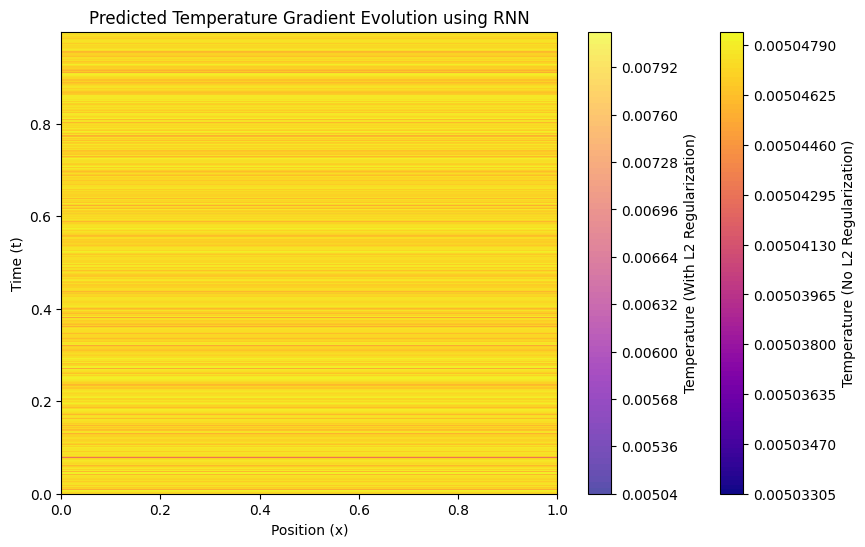

In [9]:
#RMSE/Gradient Rod Evolution over time using Spins, now adding an l2-regularization term for the combination of parameters
#yielding the best results:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class Spins:
    def __init__(self, size, initial_condition):
        self.size = size
        self.spins = initial_condition.copy()

    def update(self, alpha, dt, dx):
        new_spins = np.zeros_like(self.spins)

        for i in range(1, self.size - 1):
            # Apply the discretized PDE equation to update spins
            new_spins[i] = self.spins[i] + alpha * (self.spins[i + 1] - 2 * self.spins[i] + self.spins[i - 1]) * dt / dx**2

        # Boundary conditions
        new_spins[0] = 0
        new_spins[-1] = 0

        self.spins = new_spins.copy()

class PDESolver:
    def __init__(self, x_dim, t_dim, dx, dt, alpha, spins):
        self.x_dim = x_dim
        self.t_dim = t_dim
        self.dx = dx
        self.dt = dt
        self.alpha = alpha
        self.spins = spins
        self.grid = np.zeros((x_dim, t_dim))  # Initialize grid for u(x, t)

    def initialize_conditions(self):
        self.grid[:, 0] = self.spins.spins.copy()

    def solve(self):
        for j in range(0, self.t_dim - 1):
            self.spins.update(self.alpha, self.dt, self.dx)
            self.grid[:, j + 1] = self.spins.spins.copy()
            
class RecurrentNN:
    def __init__(self, input_dim, hidden_layer_sizes, output_dim, dropout_rate=0.5, momentum=0.9, l2_penalty=0.001):
        self.input_dim = input_dim
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_dim = output_dim
        self.dropout_rate = dropout_rate
        self.momentum = momentum
        self.l2_penalty = l2_penalty  # Include the l2_penalty parameter
        self.weights = []
        self.biases = []
        self.activations = [self.sigmoid] * (len(hidden_layer_sizes) + 1)  # Sigmoid for hidden layers

        prev_layer_size = input_dim
        for layer_size in hidden_layer_sizes:
            weight_layer = np.random.randn(prev_layer_size, layer_size)
            bias_layer = np.zeros(layer_size)
            self.weights.append(weight_layer)
            self.biases.append(bias_layer)

            prev_layer_size = layer_size

        # Output layer weights
        weight_output = np.random.randn(prev_layer_size, output_dim)
        bias_output = np.zeros(output_dim)
        self.weights.append(weight_output)
        self.biases.append(bias_output)

    def sigmoid(self, x, derivative=False):
        if derivative:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))

    def dropout(self, x):
        if self.dropout_rate >= 1.0:
            return x

        mask = (np.random.rand(*x.shape) < self.dropout_rate) / max(1e-5, (1 - self.dropout_rate))
        return x * mask

    def forward(self, x, training=True):
        layer_input = x
        layer_outputs = [layer_input]
        masks = []

        for i in range(len(self.weights)):
            weighted_sum = np.dot(layer_input, self.weights[i]) + self.biases[i]
            layer_output = self.activations[i](weighted_sum)

            if training and i < len(self.weights) - 1:
                layer_output = self.dropout(layer_output)
                masks.append(layer_output)

            layer_outputs.append(layer_output)
            layer_input = layer_output

        return layer_outputs, masks

    def train(self, input_sequences, target_outputs, learning_rate, num_epochs, desc="Training"):
        num_samples, sequence_length, _ = input_sequences.shape
        training_errors = []  # Store training errors
        min_rmse = float('inf')  # Initialize minimum RMSE

        # Initialize velocities for momentum
        velocities = [np.zeros_like(w) for w in self.weights]
        biases_velocities = [np.zeros_like(b) for b in self.biases]

        for epoch in tqdm(range(num_epochs), desc=desc):
            for sample in range(num_samples):
                input_sequence = input_sequences[sample, :, :]
                target_output = target_outputs[sample, :]

                # Forward pass with dropout
                layer_outputs, masks = self.forward(input_sequence)

                final_output = layer_outputs[-1]

                # Calculate loss with L2 regularization
                loss = np.mean((final_output - target_output)**2)
                l2_regularization = 0.5 * self.l2_penalty * sum(np.sum(w**2) for w in self.weights)
                loss += l2_regularization

                training_errors.append(loss)

                # Backpropagation Through Time (BPTT) with momentum and L2 regularization
                derror = 2 * (final_output - target_output) / num_samples

                for i in range(len(self.weights) - 1, -1, -1):
                    dactivation = self.sigmoid(layer_outputs[i + 1], derivative=True)
                    
                    # Ensure dactivation has the same shape as derror
                    dactivation = dactivation[:, :derror.shape[1]]

                    doutput = derror * dactivation

                    # Apply dropout mask during backpropagation
                    if i < len(self.weights) - 1:
                        doutput *= masks[i]

                    dweights = np.dot(layer_outputs[i].T, doutput) + self.l2_penalty * self.weights[i]
                    dbiases = np.sum(doutput, axis=0)

                    # Update velocities with momentum
                    velocities[i] = self.momentum * velocities[i] + learning_rate * dweights
                    biases_velocities[i] = self.momentum * biases_velocities[i] + learning_rate * dbiases

                    # Update weights and biases with momentum
                    self.weights[i] -= velocities[i]
                    self.biases[i] -= biases_velocities[i]

                    derror = np.dot(doutput, self.weights[i].T)

                # Calculate and print minimum RMSE during training
                if len(training_errors) % sequence_length == 0:
                    rmse = np.sqrt(np.mean(training_errors[-sequence_length:]))
                    if rmse < min_rmse:
                        min_rmse = rmse
                    print(f'Minimum RMSE at epoch {epoch + 1}: {min_rmse}')

        return training_errors
        
    def predict(self, input_sequence):
        layer_input = input_sequence
        for i in range(len(self.weights)):
            weighted_sum = np.dot(layer_input, self.weights[i]) + self.biases[i]
            layer_input = self.sigmoid(weighted_sum)

        return layer_input

    def plot_3d_training_progress(self, training_errors_f, training_errors_g):
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        epochs = len(training_errors_f)

        # Ensure that both arrays have the same length
        min_len = min(len(training_errors_f), len(training_errors_g))
        x = np.arange(0, min_len, 1)

        # Plot the 3D line
        ax.plot(x, training_errors_f[:min_len], zs=0, zdir='y', label='RMSE for f(t)')
        ax.plot(x, training_errors_g[:min_len], zs=1, zdir='y', label='RMSE for g(x)')

        ax.set_xlabel('Epochs')
        ax.set_ylabel('Functions')
        ax.set_zlabel('RMSE')
        ax.set_title('3D Plot of RMSE for f(t) and g(x)')
        ax.legend()

        plt.show()

# PDE solver parameters
x_dim = 100
t_dim = 1000
L = 1.0
dx = L / (x_dim - 1)
dt = 0.001
alpha = 0.01

# Create Spins instance for the PDE solver with initial condition sin(pi*x)
initial_condition = np.sin(np.pi * np.linspace(0, 1, x_dim))
spins = Spins(x_dim, initial_condition)

# Create PDE solver with spins
pde_solver = PDESolver(x_dim, t_dim, dx, dt, alpha, spins)

# Initialize initial conditions
pde_solver.initialize_conditions()

# Prepare data for RNN training with spins
num_samples = 20
input_sequences = np.zeros((num_samples, x_dim, t_dim))
target_outputs = np.zeros((num_samples, x_dim, t_dim))

for i in range(num_samples):
    input_sequences[i, :, :] = pde_solver.grid.copy()
    pde_solver.solve()
    target_outputs[i, :, :] = pde_solver.grid.copy()

# RNN parameters
input_dim = x_dim
hidden_layer_sizes = [2, 2, 2, 2, 2, 2, 2, 2]  # 2 layers with 10 neurons each
output_dim = x_dim
learning_rate = 1e-2
num_epochs = 1000
momentum_value = 0.7
dropout_rate = 0.5  # Adjust dropout rate as needed

# Create and train RNN for f(t) and g(x) together with BPTT
rnn_model_fg = RecurrentNN(t_dim, hidden_layer_sizes, t_dim, dropout_rate)
training_errors_fg = rnn_model_fg.train(input_sequences[:, :, :], target_outputs[:, 0, :], learning_rate, num_epochs, desc="Training f(t) and g(x)")

# Predict using the trained RNN
predicted_outputs_fg = np.zeros((num_samples, x_dim, t_dim))
for i in range(num_samples):
    input_sequence = input_sequences[i, :, :]
    predicted_output_fg = rnn_model_fg.predict(input_sequence)
    predicted_outputs_fg[i, :, :] = predicted_output_fg

# Create and train RNN for f(t) and g(x) together with BPTT with L2 regularization
rnn_model_fg_l2 = RecurrentNN(t_dim, hidden_layer_sizes, t_dim, dropout_rate, momentum_value)
training_errors_fg_l2 = rnn_model_fg_l2.train(input_sequences[:, :, :], target_outputs[:, 0, :], learning_rate, num_epochs, desc="Training f(t) and g(x) with L2 regularization")

# Predict using the trained RNN with L2 regularization
predicted_outputs_fg_l2 = np.zeros((num_samples, x_dim, t_dim))
for i in range(num_samples):
    input_sequence = input_sequences[i, :, :]
    predicted_output_fg_l2 = rnn_model_fg_l2.predict(input_sequence)
    predicted_outputs_fg_l2[i, :, :] = predicted_output_fg_l2

# Visualize the results
fig, ax = plt.subplots(figsize=(10, 6))
X, T = np.meshgrid(np.linspace(0, L, x_dim), np.linspace(0, dt * (t_dim - 1), t_dim))
Z_fg = predicted_outputs_fg[0, :, :].T  # Transpose the matrix to match the expected shape
Z_fg_l2 = predicted_outputs_fg_l2[0, :, :].T

# Use a different color map with a broader range of colors
contour_fg = ax.contourf(X, T, Z_fg, cmap='plasma', levels=100)
contour_fg_l2 = ax.contourf(X, T, Z_fg_l2, cmap='plasma', levels=100, alpha=0.7)  # Adjust alpha for transparency

ax.set_xlabel('Position (x)')
ax.set_ylabel('Time (t)')
ax.set_title('Predicted Temperature Gradient Evolution using RNN')
plt.colorbar(contour_fg, ax=ax, label='Temperature (No L2 Regularization)')
plt.colorbar(contour_fg_l2, ax=ax, label='Temperature (With L2 Regularization)')
plt.show()

#Comparison of RMSE using L2 regularization vs. No L2 regularization as a function of time and position:

Training f(t) and g(x):   0%|                                                                 | 0/1000 [00:00<?, ?it/s]C:\Users\Kjæreng\AppData\Local\Temp\ipykernel_16248\2640744633.py:73: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
Training f(t) and g(x):   1%|▎                                                        | 6/1000 [00:00<01:12, 13.73it/s]

Minimum RMSE at epoch 5: 1.5284382108166969e+43


Training f(t) and g(x):   1%|▋                                                       | 12/1000 [00:00<01:08, 14.36it/s]

Minimum RMSE at epoch 10: 1.923164293686324e+41


Training f(t) and g(x):   2%|▉                                                       | 16/1000 [00:01<01:06, 14.81it/s]

Minimum RMSE at epoch 15: 1.0585821449612086e+39


Training f(t) and g(x):   2%|█▏                                                      | 22/1000 [00:01<01:07, 14.41it/s]

Minimum RMSE at epoch 20: 4.533628037959159e+36


Training f(t) and g(x):   3%|█▍                                                      | 26/1000 [00:01<01:06, 14.66it/s]

Minimum RMSE at epoch 25: 1.6740547656619918e+34


Training f(t) and g(x):   3%|█▊                                                      | 32/1000 [00:02<01:07, 14.37it/s]

Minimum RMSE at epoch 30: 9.534477017389765e+31


Training f(t) and g(x):   4%|██                                                      | 36/1000 [00:02<01:05, 14.63it/s]

Minimum RMSE at epoch 35: 6.774796759367999e+29


Training f(t) and g(x):   4%|██▎                                                     | 42/1000 [00:02<01:06, 14.37it/s]

Minimum RMSE at epoch 40: 3.873114274971727e+27


Training f(t) and g(x):   5%|██▌                                                     | 46/1000 [00:03<01:06, 14.30it/s]

Minimum RMSE at epoch 45: 1.7213193331550773e+25


Training f(t) and g(x):   5%|██▉                                                     | 52/1000 [00:03<01:10, 13.37it/s]

Minimum RMSE at epoch 50: 6.342156116943984e+22


Training f(t) and g(x):   6%|███▏                                                    | 56/1000 [00:03<01:07, 13.92it/s]

Minimum RMSE at epoch 55: 3.296226094534715e+20


Training f(t) and g(x):   6%|███▍                                                    | 62/1000 [00:04<01:08, 13.67it/s]

Minimum RMSE at epoch 60: 2.3735226054232253e+18


Training f(t) and g(x):   7%|███▋                                                    | 66/1000 [00:04<01:06, 13.95it/s]

Minimum RMSE at epoch 65: 1.4090023322343262e+16


Training f(t) and g(x):   7%|████                                                    | 72/1000 [00:05<01:05, 14.13it/s]

Minimum RMSE at epoch 70: 65018748030821.62


Training f(t) and g(x):   8%|████▎                                                   | 76/1000 [00:05<01:03, 14.50it/s]

Minimum RMSE at epoch 75: 242275952229.1106


Training f(t) and g(x):   8%|████▌                                                   | 82/1000 [00:05<01:02, 14.66it/s]

Minimum RMSE at epoch 80: 1148204937.2298014


Training f(t) and g(x):   9%|████▊                                                   | 86/1000 [00:06<01:03, 14.44it/s]

Minimum RMSE at epoch 85: 8272240.904480255


Training f(t) and g(x):   9%|█████▏                                                  | 92/1000 [00:06<01:03, 14.29it/s]

Minimum RMSE at epoch 90: 50965.80444834734


Training f(t) and g(x):  10%|█████▍                                                  | 98/1000 [00:06<01:00, 14.99it/s]

Minimum RMSE at epoch 95: 244.25812385040004


Training f(t) and g(x):  10%|█████▌                                                 | 102/1000 [00:07<00:59, 15.11it/s]

Minimum RMSE at epoch 100: 0.9297289401455701


Training f(t) and g(x):  11%|█████▊                                                 | 106/1000 [00:07<01:04, 13.95it/s]

Minimum RMSE at epoch 105: 0.01778181869853874


Training f(t) and g(x):  11%|██████▏                                                | 112/1000 [00:07<01:07, 13.11it/s]

Minimum RMSE at epoch 110: 0.01679012847716158


Training f(t) and g(x):  12%|██████▍                                                | 118/1000 [00:08<01:00, 14.52it/s]

Minimum RMSE at epoch 115: 0.016349434205899786


Training f(t) and g(x):  12%|██████▋                                                | 122/1000 [00:08<01:01, 14.37it/s]

Minimum RMSE at epoch 120: 0.015980931693937665


Training f(t) and g(x):  13%|██████▉                                                | 126/1000 [00:08<00:59, 14.64it/s]

Minimum RMSE at epoch 125: 0.015629838373617443


Training f(t) and g(x):  13%|███████▎                                               | 132/1000 [00:09<01:00, 14.35it/s]

Minimum RMSE at epoch 130: 0.015248378412065663


Training f(t) and g(x):  14%|███████▍                                               | 136/1000 [00:09<00:59, 14.63it/s]

Minimum RMSE at epoch 135: 0.014939946881705128


Training f(t) and g(x):  14%|███████▋                                               | 140/1000 [00:09<00:59, 14.42it/s]

Minimum RMSE at epoch 140: 0.01458677072238687


Training f(t) and g(x):  15%|████████                                               | 146/1000 [00:10<01:05, 13.01it/s]

Minimum RMSE at epoch 145: 0.01428791830313008


Training f(t) and g(x):  15%|████████▎                                              | 150/1000 [00:10<01:08, 12.43it/s]

Minimum RMSE at epoch 150: 0.014044472852990876


Training f(t) and g(x):  16%|████████▋                                              | 158/1000 [00:11<01:02, 13.37it/s]

Minimum RMSE at epoch 155: 0.013773203630390413


Training f(t) and g(x):  16%|████████▉                                              | 162/1000 [00:11<01:09, 12.09it/s]

Minimum RMSE at epoch 160: 0.013543120280940476


Training f(t) and g(x):  17%|█████████▏                                             | 166/1000 [00:11<01:03, 13.22it/s]

Minimum RMSE at epoch 165: 0.013285320561570656


Training f(t) and g(x):  17%|█████████▍                                             | 172/1000 [00:12<00:59, 13.86it/s]

Minimum RMSE at epoch 170: 0.013063634733259732


Training f(t) and g(x):  18%|█████████▋                                             | 176/1000 [00:12<00:56, 14.52it/s]

Minimum RMSE at epoch 175: 0.01285774353266718


Training f(t) and g(x):  18%|██████████                                             | 182/1000 [00:13<00:55, 14.82it/s]

Minimum RMSE at epoch 180: 0.012675889837563478


Training f(t) and g(x):  19%|██████████▏                                            | 186/1000 [00:13<00:56, 14.50it/s]

Minimum RMSE at epoch 185: 0.01246712461141391


Training f(t) and g(x):  19%|██████████▌                                            | 192/1000 [00:13<00:55, 14.56it/s]

Minimum RMSE at epoch 190: 0.01229687115760706


Training f(t) and g(x):  20%|██████████▊                                            | 196/1000 [00:13<00:55, 14.39it/s]

Minimum RMSE at epoch 195: 0.012119189440848133


Training f(t) and g(x):  20%|███████████                                            | 202/1000 [00:14<00:54, 14.51it/s]

Minimum RMSE at epoch 200: 0.011957173195792578


Training f(t) and g(x):  21%|███████████▎                                           | 206/1000 [00:14<00:56, 14.03it/s]

Minimum RMSE at epoch 205: 0.011788235794356007


Training f(t) and g(x):  21%|███████████▋                                           | 212/1000 [00:15<00:55, 14.16it/s]

Minimum RMSE at epoch 210: 0.011624886885631562


Training f(t) and g(x):  22%|███████████▉                                           | 216/1000 [00:15<00:53, 14.67it/s]

Minimum RMSE at epoch 215: 0.011482022507268243


Training f(t) and g(x):  22%|████████████▏                                          | 222/1000 [00:15<01:03, 12.30it/s]

Minimum RMSE at epoch 220: 0.011348542413824731


Training f(t) and g(x):  23%|████████████▌                                          | 228/1000 [00:16<00:56, 13.70it/s]

Minimum RMSE at epoch 225: 0.011197200447851415


Training f(t) and g(x):  23%|████████████▊                                          | 232/1000 [00:16<00:53, 14.43it/s]

Minimum RMSE at epoch 230: 0.011058138821610759


Training f(t) and g(x):  24%|████████████▉                                          | 236/1000 [00:16<00:55, 13.78it/s]

Minimum RMSE at epoch 235: 0.01092731927664608


Training f(t) and g(x):  24%|█████████████▎                                         | 242/1000 [00:17<00:57, 13.13it/s]

Minimum RMSE at epoch 240: 0.010799236939286716


Training f(t) and g(x):  25%|█████████████▌                                         | 246/1000 [00:17<00:53, 14.12it/s]

Minimum RMSE at epoch 245: 0.010691327256902335


Training f(t) and g(x):  25%|█████████████▊                                         | 252/1000 [00:18<00:52, 14.19it/s]

Minimum RMSE at epoch 250: 0.010563400118644688


Training f(t) and g(x):  26%|██████████████                                         | 256/1000 [00:18<00:51, 14.53it/s]

Minimum RMSE at epoch 255: 0.010455754615103794


Training f(t) and g(x):  26%|██████████████▍                                        | 262/1000 [00:18<00:50, 14.68it/s]

Minimum RMSE at epoch 260: 0.010340123961498218


Training f(t) and g(x):  27%|██████████████▋                                        | 266/1000 [00:19<00:49, 14.79it/s]

Minimum RMSE at epoch 265: 0.010235195712677796


Training f(t) and g(x):  27%|██████████████▊                                        | 270/1000 [00:19<00:56, 13.00it/s]

Minimum RMSE at epoch 270: 0.010135593905777288


Training f(t) and g(x):  28%|███████████████▏                                       | 276/1000 [00:19<00:54, 13.32it/s]

Minimum RMSE at epoch 275: 0.010029285964200448


Training f(t) and g(x):  28%|███████████████▌                                       | 282/1000 [00:20<00:58, 12.30it/s]

Minimum RMSE at epoch 280: 0.009942351240703529


Training f(t) and g(x):  29%|███████████████▋                                       | 286/1000 [00:20<00:52, 13.64it/s]

Minimum RMSE at epoch 285: 0.0098424099188888


Training f(t) and g(x):  29%|████████████████                                       | 292/1000 [00:21<00:48, 14.49it/s]

Minimum RMSE at epoch 290: 0.00975315108479202


Training f(t) and g(x):  30%|████████████████▎                                      | 296/1000 [00:21<00:49, 14.34it/s]

Minimum RMSE at epoch 295: 0.009658493494907487


Training f(t) and g(x):  30%|████████████████▌                                      | 302/1000 [00:21<00:47, 14.76it/s]

Minimum RMSE at epoch 300: 0.009568567999990769


Training f(t) and g(x):  31%|████████████████▊                                      | 306/1000 [00:22<00:47, 14.48it/s]

Minimum RMSE at epoch 305: 0.009481889668378984


Training f(t) and g(x):  31%|█████████████████▏                                     | 312/1000 [00:22<00:48, 14.31it/s]

Minimum RMSE at epoch 310: 0.009402295040407727


Training f(t) and g(x):  32%|█████████████████▍                                     | 316/1000 [00:22<00:46, 14.61it/s]

Minimum RMSE at epoch 315: 0.009319195455805273


Training f(t) and g(x):  32%|█████████████████▋                                     | 322/1000 [00:23<00:49, 13.80it/s]

Minimum RMSE at epoch 320: 0.00923462503414499


Training f(t) and g(x):  33%|█████████████████▉                                     | 326/1000 [00:23<01:00, 11.09it/s]

Minimum RMSE at epoch 325: 0.009166787441079847


Training f(t) and g(x):  33%|██████████████████▎                                    | 332/1000 [00:23<00:50, 13.25it/s]

Minimum RMSE at epoch 330: 0.009096556272366187


Training f(t) and g(x):  34%|██████████████████▍                                    | 336/1000 [00:24<00:47, 14.05it/s]

Minimum RMSE at epoch 335: 0.00901113102368865


Training f(t) and g(x):  34%|██████████████████▊                                    | 342/1000 [00:24<00:45, 14.50it/s]

Minimum RMSE at epoch 340: 0.00895526270991757


Training f(t) and g(x):  35%|███████████████████                                    | 346/1000 [00:24<00:45, 14.36it/s]

Minimum RMSE at epoch 345: 0.008884635235821906


Training f(t) and g(x):  35%|███████████████████▎                                   | 350/1000 [00:25<00:46, 13.85it/s]

Minimum RMSE at epoch 350: 0.008808522467334892


Training f(t) and g(x):  36%|███████████████████▌                                   | 356/1000 [00:25<00:48, 13.17it/s]

Minimum RMSE at epoch 355: 0.008744768092508987


Training f(t) and g(x):  36%|███████████████████▉                                   | 362/1000 [00:26<00:45, 14.17it/s]

Minimum RMSE at epoch 360: 0.008685413340411074


Training f(t) and g(x):  37%|████████████████████▏                                  | 366/1000 [00:26<00:44, 14.18it/s]

Minimum RMSE at epoch 365: 0.008619186847223327


Training f(t) and g(x):  37%|████████████████████▍                                  | 372/1000 [00:26<00:45, 13.89it/s]

Minimum RMSE at epoch 370: 0.00855664434363992


Training f(t) and g(x):  38%|████████████████████▋                                  | 376/1000 [00:27<00:43, 14.39it/s]

Minimum RMSE at epoch 375: 0.008498545168309866


Training f(t) and g(x):  38%|█████████████████████                                  | 382/1000 [00:27<00:46, 13.25it/s]

Minimum RMSE at epoch 380: 0.008432562417016874


Training f(t) and g(x):  39%|█████████████████████▏                                 | 386/1000 [00:27<00:43, 14.05it/s]

Minimum RMSE at epoch 385: 0.008379642118605085


Training f(t) and g(x):  39%|█████████████████████▌                                 | 392/1000 [00:28<00:42, 14.17it/s]

Minimum RMSE at epoch 390: 0.008318044589186242


Training f(t) and g(x):  40%|█████████████████████▊                                 | 396/1000 [00:28<00:41, 14.53it/s]

Minimum RMSE at epoch 395: 0.008265379880561379


Training f(t) and g(x):  40%|██████████████████████                                 | 402/1000 [00:28<00:42, 14.19it/s]

Minimum RMSE at epoch 400: 0.00820728620183984


Training f(t) and g(x):  41%|██████████████████████▎                                | 406/1000 [00:29<00:41, 14.25it/s]

Minimum RMSE at epoch 405: 0.00814986220786191


Training f(t) and g(x):  41%|██████████████████████▋                                | 412/1000 [00:29<00:44, 13.09it/s]

Minimum RMSE at epoch 410: 0.008100447050710299


Training f(t) and g(x):  42%|██████████████████████▉                                | 416/1000 [00:30<00:42, 13.65it/s]

Minimum RMSE at epoch 415: 0.00804792986158111


Training f(t) and g(x):  42%|███████████████████████▏                               | 422/1000 [00:30<00:43, 13.15it/s]

Minimum RMSE at epoch 420: 0.007998372448253771


Training f(t) and g(x):  43%|███████████████████████▌                               | 428/1000 [00:30<00:39, 14.30it/s]

Minimum RMSE at epoch 425: 0.007945728253651618


Training f(t) and g(x):  43%|███████████████████████▊                               | 432/1000 [00:31<00:39, 14.26it/s]

Minimum RMSE at epoch 430: 0.007899463084588427


Training f(t) and g(x):  44%|███████████████████████▉                               | 436/1000 [00:31<00:39, 14.24it/s]

Minimum RMSE at epoch 435: 0.007850056623042865


Training f(t) and g(x):  44%|████████████████████████▎                              | 442/1000 [00:31<00:38, 14.57it/s]

Minimum RMSE at epoch 440: 0.0078023258480546046


Training f(t) and g(x):  45%|████████████████████████▌                              | 446/1000 [00:32<00:38, 14.39it/s]

Minimum RMSE at epoch 445: 0.007760252710181471


Training f(t) and g(x):  45%|████████████████████████▊                              | 452/1000 [00:32<00:37, 14.62it/s]

Minimum RMSE at epoch 450: 0.0077159006263805745


Training f(t) and g(x):  46%|█████████████████████████                              | 456/1000 [00:32<00:45, 12.03it/s]

Minimum RMSE at epoch 455: 0.0076658068982952505


Training f(t) and g(x):  46%|█████████████████████████▍                             | 462/1000 [00:33<00:39, 13.69it/s]

Minimum RMSE at epoch 460: 0.007625653217116037


Training f(t) and g(x):  47%|█████████████████████████▋                             | 466/1000 [00:33<00:44, 12.10it/s]

Minimum RMSE at epoch 465: 0.007579391738223785


Training f(t) and g(x):  47%|█████████████████████████▉                             | 472/1000 [00:34<00:38, 13.72it/s]

Minimum RMSE at epoch 470: 0.007539997861091878


Training f(t) and g(x):  48%|██████████████████████████▏                            | 476/1000 [00:34<00:37, 13.97it/s]

Minimum RMSE at epoch 475: 0.0074948433672906685


Training f(t) and g(x):  48%|██████████████████████████▌                            | 482/1000 [00:34<00:36, 14.37it/s]

Minimum RMSE at epoch 480: 0.007456344732767287


Training f(t) and g(x):  49%|██████████████████████████▋                            | 486/1000 [00:35<00:35, 14.30it/s]

Minimum RMSE at epoch 485: 0.007415317142631246


Training f(t) and g(x):  49%|███████████████████████████                            | 492/1000 [00:35<00:35, 14.24it/s]

Minimum RMSE at epoch 490: 0.007377821173569709


Training f(t) and g(x):  50%|███████████████████████████▎                           | 496/1000 [00:35<00:34, 14.57it/s]

Minimum RMSE at epoch 495: 0.00733280347969413


Training f(t) and g(x):  50%|███████████████████████████▌                           | 502/1000 [00:36<00:33, 14.84it/s]

Minimum RMSE at epoch 500: 0.00729870224813572


Training f(t) and g(x):  50%|███████████████████████████▋                           | 504/1000 [00:36<00:33, 14.64it/s]

Minimum RMSE at epoch 505: 0.007260317749504039


Training f(t) and g(x):  51%|████████████████████████████▏                          | 512/1000 [00:37<00:37, 13.06it/s]

Minimum RMSE at epoch 510: 0.00722131619032989


Training f(t) and g(x):  52%|████████████████████████████▍                          | 516/1000 [00:37<00:39, 12.25it/s]

Minimum RMSE at epoch 515: 0.007187231987891524


Training f(t) and g(x):  52%|████████████████████████████▋                          | 522/1000 [00:37<00:35, 13.36it/s]

Minimum RMSE at epoch 520: 0.007144420415110536


Training f(t) and g(x):  53%|████████████████████████████▉                          | 526/1000 [00:38<00:34, 13.79it/s]

Minimum RMSE at epoch 525: 0.007113111185410158


Training f(t) and g(x):  53%|█████████████████████████████▎                         | 532/1000 [00:38<00:32, 14.40it/s]

Minimum RMSE at epoch 530: 0.00707870295118252


Training f(t) and g(x):  54%|█████████████████████████████▍                         | 536/1000 [00:38<00:32, 14.31it/s]

Minimum RMSE at epoch 535: 0.007044243096625859


Training f(t) and g(x):  54%|█████████████████████████████▊                         | 542/1000 [00:39<00:31, 14.59it/s]

Minimum RMSE at epoch 540: 0.007007372996579384


Training f(t) and g(x):  55%|██████████████████████████████                         | 546/1000 [00:39<00:31, 14.39it/s]

Minimum RMSE at epoch 545: 0.006971405162173701


Training f(t) and g(x):  55%|██████████████████████████████▎                        | 552/1000 [00:39<00:30, 14.62it/s]

Minimum RMSE at epoch 550: 0.006939377483186289


Training f(t) and g(x):  56%|██████████████████████████████▌                        | 556/1000 [00:40<00:29, 14.92it/s]

Minimum RMSE at epoch 555: 0.006906681678700832


Training f(t) and g(x):  56%|██████████████████████████████▉                        | 562/1000 [00:40<00:30, 14.49it/s]

Minimum RMSE at epoch 560: 0.0068763142931946184


Training f(t) and g(x):  57%|███████████████████████████████▏                       | 568/1000 [00:41<00:32, 13.11it/s]

Minimum RMSE at epoch 565: 0.006846181733851509


Training f(t) and g(x):  57%|███████████████████████████████▍                       | 572/1000 [00:41<00:32, 13.23it/s]

Minimum RMSE at epoch 570: 0.006813876193586408


Training f(t) and g(x):  58%|███████████████████████████████▋                       | 576/1000 [00:41<00:32, 12.96it/s]

Minimum RMSE at epoch 575: 0.006782911939629679


Training f(t) and g(x):  58%|████████████████████████████████                       | 582/1000 [00:42<00:31, 13.30it/s]

Minimum RMSE at epoch 580: 0.006752959274811775


Training f(t) and g(x):  59%|████████████████████████████████▏                      | 586/1000 [00:42<00:31, 13.33it/s]

Minimum RMSE at epoch 585: 0.006722702966629484


Training f(t) and g(x):  59%|████████████████████████████████▌                      | 592/1000 [00:42<00:28, 14.23it/s]

Minimum RMSE at epoch 590: 0.006690830151794319


Training f(t) and g(x):  60%|████████████████████████████████▊                      | 596/1000 [00:43<00:27, 14.72it/s]

Minimum RMSE at epoch 595: 0.006662273045692033


Training f(t) and g(x):  60%|█████████████████████████████████                      | 602/1000 [00:43<00:27, 14.38it/s]

Minimum RMSE at epoch 600: 0.006632555936812947


Training f(t) and g(x):  61%|█████████████████████████████████▎                     | 606/1000 [00:43<00:27, 14.30it/s]

Minimum RMSE at epoch 605: 0.0066025433572802295


Training f(t) and g(x):  61%|█████████████████████████████████▋                     | 612/1000 [00:44<00:26, 14.49it/s]

Minimum RMSE at epoch 610: 0.006575807433611768


Training f(t) and g(x):  62%|█████████████████████████████████▉                     | 618/1000 [00:44<00:26, 14.46it/s]

Minimum RMSE at epoch 615: 0.006548175930809077


Training f(t) and g(x):  62%|██████████████████████████████████▏                    | 622/1000 [00:44<00:26, 14.34it/s]

Minimum RMSE at epoch 620: 0.006521114560251934


Training f(t) and g(x):  63%|██████████████████████████████████▍                    | 626/1000 [00:45<00:26, 14.28it/s]

Minimum RMSE at epoch 625: 0.006494959753222504


Training f(t) and g(x):  63%|██████████████████████████████████▊                    | 632/1000 [00:45<00:24, 14.73it/s]

Minimum RMSE at epoch 630: 0.006467457485178898


Training f(t) and g(x):  64%|███████████████████████████████████                    | 638/1000 [00:46<00:24, 14.90it/s]

Minimum RMSE at epoch 635: 0.0064397408693827474


Training f(t) and g(x):  64%|███████████████████████████████████▎                   | 642/1000 [00:46<00:23, 15.06it/s]

Minimum RMSE at epoch 640: 0.006412669622880312


Training f(t) and g(x):  65%|███████████████████████████████████▌                   | 646/1000 [00:46<00:24, 14.62it/s]

Minimum RMSE at epoch 645: 0.006390426810586235


Training f(t) and g(x):  65%|███████████████████████████████████▊                   | 652/1000 [00:47<00:28, 12.36it/s]

Minimum RMSE at epoch 650: 0.006366467402788361


Training f(t) and g(x):  66%|████████████████████████████████████                   | 656/1000 [00:47<00:25, 13.25it/s]

Minimum RMSE at epoch 655: 0.0063347661379875705


Training f(t) and g(x):  66%|████████████████████████████████████▍                  | 662/1000 [00:47<00:27, 12.38it/s]

Minimum RMSE at epoch 660: 0.006313741539475873


Training f(t) and g(x):  67%|████████████████████████████████████▋                  | 666/1000 [00:48<00:25, 12.97it/s]

Minimum RMSE at epoch 665: 0.0062883789181292305


Training f(t) and g(x):  67%|████████████████████████████████████▉                  | 672/1000 [00:48<00:23, 14.23it/s]

Minimum RMSE at epoch 670: 0.006263486299824123


Training f(t) and g(x):  68%|█████████████████████████████████████▏                 | 676/1000 [00:48<00:22, 14.23it/s]

Minimum RMSE at epoch 675: 0.006238418177291991


Training f(t) and g(x):  68%|█████████████████████████████████████▌                 | 682/1000 [00:49<00:21, 14.57it/s]

Minimum RMSE at epoch 680: 0.006216714515268368


Training f(t) and g(x):  69%|█████████████████████████████████████▋                 | 686/1000 [00:49<00:21, 14.38it/s]

Minimum RMSE at epoch 685: 0.006192369993450864


Training f(t) and g(x):  69%|██████████████████████████████████████                 | 692/1000 [00:50<00:26, 11.73it/s]

Minimum RMSE at epoch 690: 0.00616773913500837


Training f(t) and g(x):  70%|██████████████████████████████████████▎                | 696/1000 [00:50<00:22, 13.29it/s]

Minimum RMSE at epoch 695: 0.006143809965894511


Training f(t) and g(x):  70%|██████████████████████████████████████▌                | 702/1000 [00:50<00:21, 13.89it/s]

Minimum RMSE at epoch 700: 0.006119303256462422


Training f(t) and g(x):  71%|██████████████████████████████████████▊                | 706/1000 [00:51<00:20, 14.39it/s]

Minimum RMSE at epoch 705: 0.0060982818976962816


Training f(t) and g(x):  71%|███████████████████████████████████████▏               | 712/1000 [00:51<00:19, 14.61it/s]

Minimum RMSE at epoch 710: 0.006075644259050887


Training f(t) and g(x):  72%|███████████████████████████████████████▍               | 716/1000 [00:51<00:19, 14.92it/s]

Minimum RMSE at epoch 715: 0.00605577691885951


Training f(t) and g(x):  72%|███████████████████████████████████████▋               | 722/1000 [00:52<00:18, 14.96it/s]

Minimum RMSE at epoch 720: 0.006033539540618


Training f(t) and g(x):  73%|███████████████████████████████████████▉               | 726/1000 [00:52<00:22, 12.39it/s]

Minimum RMSE at epoch 725: 0.006014772761109558


Training f(t) and g(x):  73%|████████████████████████████████████████▎              | 732/1000 [00:52<00:19, 13.98it/s]

Minimum RMSE at epoch 730: 0.005991500152535668


Training f(t) and g(x):  74%|████████████████████████████████████████▍              | 736/1000 [00:53<00:18, 14.11it/s]

Minimum RMSE at epoch 735: 0.005971895582683614


Training f(t) and g(x):  74%|████████████████████████████████████████▊              | 742/1000 [00:53<00:17, 14.51it/s]

Minimum RMSE at epoch 740: 0.005949752424715581


Training f(t) and g(x):  75%|█████████████████████████████████████████              | 746/1000 [00:53<00:17, 14.87it/s]

Minimum RMSE at epoch 745: 0.005928198799523471


Training f(t) and g(x):  75%|█████████████████████████████████████████▎             | 752/1000 [00:54<00:17, 14.44it/s]

Minimum RMSE at epoch 750: 0.005906185363838844


Training f(t) and g(x):  76%|█████████████████████████████████████████▌             | 756/1000 [00:54<00:17, 13.86it/s]

Minimum RMSE at epoch 755: 0.005887779089561289


Training f(t) and g(x):  76%|█████████████████████████████████████████▊             | 760/1000 [00:55<00:25,  9.28it/s]

Minimum RMSE at epoch 760: 0.005866617235288654


Training f(t) and g(x):  77%|██████████████████████████████████████████▏            | 766/1000 [00:56<00:33,  7.01it/s]

Minimum RMSE at epoch 765: 0.005848575979977349


Training f(t) and g(x):  77%|██████████████████████████████████████████▍            | 771/1000 [00:56<00:34,  6.65it/s]

Minimum RMSE at epoch 770: 0.005827780133959812


Training f(t) and g(x):  78%|██████████████████████████████████████████▋            | 775/1000 [00:57<00:35,  6.34it/s]

Minimum RMSE at epoch 775: 0.005809044110982276


Training f(t) and g(x):  78%|██████████████████████████████████████████▉            | 781/1000 [00:58<00:33,  6.52it/s]

Minimum RMSE at epoch 780: 0.005788889019322268


Training f(t) and g(x):  79%|███████████████████████████████████████████▏           | 786/1000 [00:59<00:35,  6.11it/s]

Minimum RMSE at epoch 785: 0.005771129808481154


Training f(t) and g(x):  79%|███████████████████████████████████████████▌           | 791/1000 [01:00<00:32,  6.40it/s]

Minimum RMSE at epoch 790: 0.005751181654217628


Training f(t) and g(x):  80%|███████████████████████████████████████████▊           | 796/1000 [01:00<00:30,  6.58it/s]

Minimum RMSE at epoch 795: 0.005730623211861664


Training f(t) and g(x):  80%|████████████████████████████████████████████           | 801/1000 [01:01<00:30,  6.53it/s]

Minimum RMSE at epoch 800: 0.0057143347258450505


Training f(t) and g(x):  81%|████████████████████████████████████████████▎          | 806/1000 [01:02<00:30,  6.42it/s]

Minimum RMSE at epoch 805: 0.005695933640496843


Training f(t) and g(x):  81%|████████████████████████████████████████████▌          | 811/1000 [01:03<00:33,  5.70it/s]

Minimum RMSE at epoch 810: 0.005676947308782198


Training f(t) and g(x):  82%|████████████████████████████████████████████▉          | 816/1000 [01:04<00:31,  5.92it/s]

Minimum RMSE at epoch 815: 0.005657806742215758


Training f(t) and g(x):  82%|█████████████████████████████████████████████▏         | 821/1000 [01:04<00:28,  6.32it/s]

Minimum RMSE at epoch 820: 0.005642478870990643


Training f(t) and g(x):  82%|█████████████████████████████████████████████▍         | 825/1000 [01:05<00:27,  6.48it/s]

Minimum RMSE at epoch 825: 0.005625390114544983


Training f(t) and g(x):  83%|█████████████████████████████████████████████▋         | 831/1000 [01:06<00:28,  5.91it/s]

Minimum RMSE at epoch 830: 0.005605890697923449


Training f(t) and g(x):  84%|█████████████████████████████████████████████▉         | 836/1000 [01:07<00:25,  6.41it/s]

Minimum RMSE at epoch 835: 0.0055902508041613405


Training f(t) and g(x):  84%|██████████████████████████████████████████████▎        | 841/1000 [01:08<00:24,  6.54it/s]

Minimum RMSE at epoch 840: 0.005570315523985497


Training f(t) and g(x):  85%|██████████████████████████████████████████████▌        | 846/1000 [01:08<00:25,  6.08it/s]

Minimum RMSE at epoch 845: 0.005555526095869338


Training f(t) and g(x):  85%|██████████████████████████████████████████████▊        | 851/1000 [01:09<00:24,  6.14it/s]

Minimum RMSE at epoch 850: 0.005538169351953097


Training f(t) and g(x):  86%|███████████████████████████████████████████████        | 856/1000 [01:10<00:22,  6.45it/s]

Minimum RMSE at epoch 855: 0.005520397906671164


Training f(t) and g(x):  86%|███████████████████████████████████████████████▎       | 861/1000 [01:11<00:21,  6.50it/s]

Minimum RMSE at epoch 860: 0.005506435595188519


Training f(t) and g(x):  87%|███████████████████████████████████████████████▋       | 866/1000 [01:12<00:20,  6.48it/s]

Minimum RMSE at epoch 865: 0.005489227956136669


Training f(t) and g(x):  87%|███████████████████████████████████████████████▉       | 871/1000 [01:12<00:20,  6.44it/s]

Minimum RMSE at epoch 870: 0.005475021858103076


Training f(t) and g(x):  88%|████████████████████████████████████████████████▏      | 876/1000 [01:13<00:21,  5.90it/s]

Minimum RMSE at epoch 875: 0.0054564955676950555


Training f(t) and g(x):  88%|████████████████████████████████████████████████▍      | 880/1000 [01:14<00:19,  6.21it/s]

Minimum RMSE at epoch 880: 0.00544120779495124


Training f(t) and g(x):  89%|████████████████████████████████████████████████▋      | 886/1000 [01:15<00:17,  6.45it/s]

Minimum RMSE at epoch 885: 0.005422891826595041


Training f(t) and g(x):  89%|████████████████████████████████████████████████▉      | 890/1000 [01:15<00:16,  6.55it/s]

Minimum RMSE at epoch 890: 0.005407694719467087


Training f(t) and g(x):  90%|█████████████████████████████████████████████████▎     | 896/1000 [01:17<00:20,  5.13it/s]

Minimum RMSE at epoch 895: 0.005393660734069811


Training f(t) and g(x):  90%|█████████████████████████████████████████████████▌     | 901/1000 [01:17<00:16,  5.83it/s]

Minimum RMSE at epoch 900: 0.005378965073511229


Training f(t) and g(x):  91%|█████████████████████████████████████████████████▊     | 906/1000 [01:18<00:16,  5.80it/s]

Minimum RMSE at epoch 905: 0.0053628829402918


Training f(t) and g(x):  91%|██████████████████████████████████████████████████     | 911/1000 [01:19<00:13,  6.55it/s]

Minimum RMSE at epoch 910: 0.005346704034707624


Training f(t) and g(x):  92%|██████████████████████████████████████████████████▍    | 916/1000 [01:20<00:13,  6.03it/s]

Minimum RMSE at epoch 915: 0.005331810228272219


Training f(t) and g(x):  92%|██████████████████████████████████████████████████▋    | 921/1000 [01:21<00:12,  6.17it/s]

Minimum RMSE at epoch 920: 0.005317518408177991


Training f(t) and g(x):  93%|██████████████████████████████████████████████████▉    | 926/1000 [01:21<00:11,  6.43it/s]

Minimum RMSE at epoch 925: 0.005302885096818505


Training f(t) and g(x):  93%|███████████████████████████████████████████████████▏   | 931/1000 [01:22<00:10,  6.47it/s]

Minimum RMSE at epoch 930: 0.00528550078973427


Training f(t) and g(x):  94%|███████████████████████████████████████████████████▍   | 936/1000 [01:23<00:11,  5.72it/s]

Minimum RMSE at epoch 935: 0.005272355431807483


Training f(t) and g(x):  94%|███████████████████████████████████████████████████▊   | 941/1000 [01:24<00:10,  5.80it/s]

Minimum RMSE at epoch 940: 0.005258176003005277


Training f(t) and g(x):  95%|████████████████████████████████████████████████████   | 946/1000 [01:25<00:08,  6.43it/s]

Minimum RMSE at epoch 945: 0.005244237020953695


Training f(t) and g(x):  95%|████████████████████████████████████████████████████▎  | 951/1000 [01:25<00:07,  6.60it/s]

Minimum RMSE at epoch 950: 0.0052318192080670275


Training f(t) and g(x):  96%|████████████████████████████████████████████████████▌  | 956/1000 [01:26<00:07,  5.89it/s]

Minimum RMSE at epoch 955: 0.0052172568536303825


Training f(t) and g(x):  96%|████████████████████████████████████████████████████▊  | 961/1000 [01:27<00:06,  6.08it/s]

Minimum RMSE at epoch 960: 0.0051996093035279285


Training f(t) and g(x):  97%|█████████████████████████████████████████████████████▏ | 966/1000 [01:28<00:05,  6.59it/s]

Minimum RMSE at epoch 965: 0.005187711714613934


Training f(t) and g(x):  97%|█████████████████████████████████████████████████████▍ | 971/1000 [01:29<00:04,  6.53it/s]

Minimum RMSE at epoch 970: 0.00517315918143791


Training f(t) and g(x):  98%|█████████████████████████████████████████████████████▋ | 976/1000 [01:30<00:04,  5.76it/s]

Minimum RMSE at epoch 975: 0.005161451624998114


Training f(t) and g(x):  98%|█████████████████████████████████████████████████████▉ | 981/1000 [01:30<00:03,  6.08it/s]

Minimum RMSE at epoch 980: 0.005146090126398802


Training f(t) and g(x):  99%|██████████████████████████████████████████████████████▏| 986/1000 [01:31<00:02,  6.34it/s]

Minimum RMSE at epoch 985: 0.0051341514144709385


Training f(t) and g(x):  99%|██████████████████████████████████████████████████████▌| 991/1000 [01:32<00:01,  6.64it/s]

Minimum RMSE at epoch 990: 0.005119471273181095


Training f(t) and g(x): 100%|██████████████████████████████████████████████████████▊| 996/1000 [01:33<00:00,  6.11it/s]

Minimum RMSE at epoch 995: 0.00510683515080883


Training f(t) and g(x): 100%|██████████████████████████████████████████████████████| 1000/1000 [01:33<00:00, 10.65it/s]


Minimum RMSE at epoch 1000: 0.005094421943883752


Training f(t) and g(x) with L2 regularization:   1%|▏                                 | 6/1000 [00:00<01:08, 14.59it/s]

Minimum RMSE at epoch 5: 1.393907917116281e+25


Training f(t) and g(x) with L2 regularization:   1%|▍                                | 12/1000 [00:00<01:05, 15.16it/s]

Minimum RMSE at epoch 10: 5.726144472414304e+23


Training f(t) and g(x) with L2 regularization:   2%|▌                                | 16/1000 [00:01<01:04, 15.20it/s]

Minimum RMSE at epoch 15: 1.3795972392486884e+22


Training f(t) and g(x) with L2 regularization:   2%|▋                                | 20/1000 [00:01<01:13, 13.39it/s]

Minimum RMSE at epoch 20: 3.323857006592262e+20


Training f(t) and g(x) with L2 regularization:   3%|▊                                | 26/1000 [00:01<01:19, 12.33it/s]

Minimum RMSE at epoch 25: 8.008152731799529e+18


Training f(t) and g(x) with L2 regularization:   3%|▉                                | 30/1000 [00:02<01:15, 12.83it/s]

Minimum RMSE at epoch 30: 1.929400393838758e+17


Training f(t) and g(x) with L2 regularization:   4%|█▏                               | 36/1000 [00:02<01:20, 11.95it/s]

Minimum RMSE at epoch 35: 4648495107945631.0


Training f(t) and g(x) with L2 regularization:   4%|█▎                               | 40/1000 [00:03<01:11, 13.42it/s]

Minimum RMSE at epoch 40: 111995969512589.97


Training f(t) and g(x) with L2 regularization:   5%|█▌                               | 46/1000 [00:03<01:13, 12.90it/s]

Minimum RMSE at epoch 45: 2698313517771.6284


Training f(t) and g(x) with L2 regularization:   5%|█▋                               | 52/1000 [00:03<01:06, 14.20it/s]

Minimum RMSE at epoch 50: 65010338067.3054


Training f(t) and g(x) with L2 regularization:   6%|█▉                               | 58/1000 [00:04<01:02, 14.96it/s]

Minimum RMSE at epoch 55: 1566290954.6239884


Training f(t) and g(x) with L2 regularization:   6%|██                               | 62/1000 [00:04<01:05, 14.34it/s]

Minimum RMSE at epoch 60: 37736572.78934698


Training f(t) and g(x) with L2 regularization:   7%|██▏                              | 66/1000 [00:05<01:13, 12.76it/s]

Minimum RMSE at epoch 65: 909185.4368957707


Training f(t) and g(x) with L2 regularization:   7%|██▍                              | 72/1000 [00:05<01:04, 14.37it/s]

Minimum RMSE at epoch 70: 21904.961091615536


Training f(t) and g(x) with L2 regularization:   8%|██▌                              | 76/1000 [00:05<01:02, 14.79it/s]

Minimum RMSE at epoch 75: 527.7551939004716


Training f(t) and g(x) with L2 regularization:   8%|██▋                              | 82/1000 [00:06<01:01, 14.92it/s]

Minimum RMSE at epoch 80: 12.715810902323957


Training f(t) and g(x) with L2 regularization:   9%|██▊                              | 86/1000 [00:06<01:00, 15.07it/s]

Minimum RMSE at epoch 85: 0.32905129789070336


Training f(t) and g(x) with L2 regularization:   9%|███                              | 92/1000 [00:06<01:01, 14.85it/s]

Minimum RMSE at epoch 90: 0.11279185895879726


Training f(t) and g(x) with L2 regularization:  10%|███▏                             | 96/1000 [00:07<01:02, 14.52it/s]

Minimum RMSE at epoch 95: 0.10599446050669001


Training f(t) and g(x) with L2 regularization:  10%|███▎                            | 102/1000 [00:07<01:01, 14.57it/s]

Minimum RMSE at epoch 100: 0.10044584198626616


Training f(t) and g(x) with L2 regularization:  11%|███▍                            | 106/1000 [00:07<01:04, 13.78it/s]

Minimum RMSE at epoch 105: 0.0953668839636164


Training f(t) and g(x) with L2 regularization:  11%|███▌                            | 112/1000 [00:08<01:01, 14.40it/s]

Minimum RMSE at epoch 110: 0.09084817785289921


Training f(t) and g(x) with L2 regularization:  12%|███▋                            | 116/1000 [00:08<01:00, 14.66it/s]

Minimum RMSE at epoch 115: 0.08622012738639359


Training f(t) and g(x) with L2 regularization:  12%|███▉                            | 122/1000 [00:08<00:59, 14.71it/s]

Minimum RMSE at epoch 120: 0.08372636708642517


Training f(t) and g(x) with L2 regularization:  13%|████                            | 126/1000 [00:09<00:59, 14.81it/s]

Minimum RMSE at epoch 125: 0.07974094502427316


Training f(t) and g(x) with L2 regularization:  13%|████▏                           | 132/1000 [00:09<00:58, 14.77it/s]

Minimum RMSE at epoch 130: 0.07666458594679948


Training f(t) and g(x) with L2 regularization:  14%|████▍                           | 138/1000 [00:09<00:56, 15.17it/s]

Minimum RMSE at epoch 135: 0.0735850935605454


Training f(t) and g(x) with L2 regularization:  14%|████▌                           | 142/1000 [00:10<00:56, 15.19it/s]

Minimum RMSE at epoch 140: 0.07045822561447243


Training f(t) and g(x) with L2 regularization:  15%|████▋                           | 146/1000 [00:10<00:58, 14.68it/s]

Minimum RMSE at epoch 145: 0.0685576271799872


Training f(t) and g(x) with L2 regularization:  15%|████▊                           | 152/1000 [00:10<00:58, 14.61it/s]

Minimum RMSE at epoch 150: 0.06669190024482909


Training f(t) and g(x) with L2 regularization:  16%|████▉                           | 156/1000 [00:11<00:57, 14.76it/s]

Minimum RMSE at epoch 155: 0.06419625924227282


Training f(t) and g(x) with L2 regularization:  16%|█████▏                          | 162/1000 [00:11<00:56, 14.75it/s]

Minimum RMSE at epoch 160: 0.06165606449801616


Training f(t) and g(x) with L2 regularization:  17%|█████▎                          | 166/1000 [00:11<00:55, 14.99it/s]

Minimum RMSE at epoch 165: 0.06087627398440287


Training f(t) and g(x) with L2 regularization:  17%|█████▌                          | 172/1000 [00:12<00:55, 14.83it/s]

Minimum RMSE at epoch 170: 0.05901799771357862


Training f(t) and g(x) with L2 regularization:  18%|█████▋                          | 176/1000 [00:12<00:54, 15.03it/s]

Minimum RMSE at epoch 175: 0.05681489180386258


Training f(t) and g(x) with L2 regularization:  18%|█████▊                          | 180/1000 [00:12<00:56, 14.59it/s]

Minimum RMSE at epoch 180: 0.055905197010475895


Training f(t) and g(x) with L2 regularization:  19%|█████▉                          | 186/1000 [00:13<01:04, 12.55it/s]

Minimum RMSE at epoch 185: 0.05370051166634604


Training f(t) and g(x) with L2 regularization:  19%|██████▏                         | 192/1000 [00:13<01:07, 11.96it/s]

Minimum RMSE at epoch 190: 0.05188685596975846


Training f(t) and g(x) with L2 regularization:  20%|██████▎                         | 198/1000 [00:14<00:58, 13.79it/s]

Minimum RMSE at epoch 195: 0.05045635596823386


Training f(t) and g(x) with L2 regularization:  20%|██████▍                         | 202/1000 [00:14<00:56, 14.01it/s]

Minimum RMSE at epoch 200: 0.0498550634907826


Training f(t) and g(x) with L2 regularization:  21%|██████▋                         | 208/1000 [00:14<00:53, 14.89it/s]

Minimum RMSE at epoch 205: 0.0485172451373988


Training f(t) and g(x) with L2 regularization:  21%|██████▊                         | 212/1000 [00:15<01:05, 12.08it/s]

Minimum RMSE at epoch 210: 0.048188320059202046


Training f(t) and g(x) with L2 regularization:  22%|██████▉                         | 216/1000 [00:15<01:14, 10.54it/s]

Minimum RMSE at epoch 215: 0.046778925390733195


Training f(t) and g(x) with L2 regularization:  22%|███████                         | 221/1000 [00:16<01:33,  8.35it/s]

Minimum RMSE at epoch 220: 0.045826374030282495


Training f(t) and g(x) with L2 regularization:  23%|███████▏                        | 226/1000 [00:16<01:34,  8.20it/s]

Minimum RMSE at epoch 225: 0.04458457836930841


Training f(t) and g(x) with L2 regularization:  23%|███████▍                        | 232/1000 [00:17<01:04, 11.98it/s]

Minimum RMSE at epoch 230: 0.04375489782541644


Training f(t) and g(x) with L2 regularization:  24%|███████▌                        | 236/1000 [00:17<00:58, 13.12it/s]

Minimum RMSE at epoch 235: 0.0424259696191315


Training f(t) and g(x) with L2 regularization:  24%|███████▋                        | 242/1000 [00:18<00:52, 14.57it/s]

Minimum RMSE at epoch 240: 0.04207233558684279


Training f(t) and g(x) with L2 regularization:  25%|███████▉                        | 248/1000 [00:18<00:50, 14.84it/s]

Minimum RMSE at epoch 245: 0.041472003293557255


Training f(t) and g(x) with L2 regularization:  25%|████████                        | 252/1000 [00:18<00:51, 14.51it/s]

Minimum RMSE at epoch 250: 0.0405218955647518


Training f(t) and g(x) with L2 regularization:  26%|████████▏                       | 256/1000 [00:19<00:48, 15.24it/s]

Minimum RMSE at epoch 255: 0.03975348720437141


Training f(t) and g(x) with L2 regularization:  26%|████████▍                       | 262/1000 [00:19<00:48, 15.07it/s]

Minimum RMSE at epoch 260: 0.039017146596543


Training f(t) and g(x) with L2 regularization:  27%|████████▌                       | 266/1000 [00:19<00:49, 14.98it/s]

Minimum RMSE at epoch 265: 0.038297723121784824


Training f(t) and g(x) with L2 regularization:  27%|████████▋                       | 272/1000 [00:20<00:49, 14.62it/s]

Minimum RMSE at epoch 270: 0.037791382646734414


Training f(t) and g(x) with L2 regularization:  28%|████████▊                       | 276/1000 [00:20<00:49, 14.77it/s]

Minimum RMSE at epoch 275: 0.036710222243306716


Training f(t) and g(x) with L2 regularization:  28%|█████████                       | 282/1000 [00:20<00:47, 15.16it/s]

Minimum RMSE at epoch 280: 0.03628778646051854


Training f(t) and g(x) with L2 regularization:  29%|█████████▏                      | 286/1000 [00:21<00:51, 13.81it/s]

Minimum RMSE at epoch 285: 0.035874566002494085


Training f(t) and g(x) with L2 regularization:  29%|█████████▎                      | 292/1000 [00:21<00:49, 14.41it/s]

Minimum RMSE at epoch 290: 0.034992676521448274


Training f(t) and g(x) with L2 regularization:  30%|█████████▌                      | 298/1000 [00:21<00:46, 15.04it/s]

Minimum RMSE at epoch 295: 0.03447483603420196


Training f(t) and g(x) with L2 regularization:  30%|█████████▋                      | 302/1000 [00:22<00:46, 15.13it/s]

Minimum RMSE at epoch 300: 0.03389856458404291


Training f(t) and g(x) with L2 regularization:  31%|█████████▊                      | 306/1000 [00:22<00:45, 15.17it/s]

Minimum RMSE at epoch 305: 0.03336936682161678


Training f(t) and g(x) with L2 regularization:  31%|█████████▉                      | 312/1000 [00:22<00:46, 14.89it/s]

Minimum RMSE at epoch 310: 0.03308640944313651


Training f(t) and g(x) with L2 regularization:  32%|██████████▏                     | 318/1000 [00:23<00:44, 15.33it/s]

Minimum RMSE at epoch 315: 0.032862862012748455


Training f(t) and g(x) with L2 regularization:  32%|██████████▎                     | 322/1000 [00:23<00:44, 15.27it/s]

Minimum RMSE at epoch 320: 0.032071007858014214


Training f(t) and g(x) with L2 regularization:  33%|██████████▍                     | 326/1000 [00:23<00:44, 15.24it/s]

Minimum RMSE at epoch 325: 0.03195943659285679


Training f(t) and g(x) with L2 regularization:  33%|██████████▌                     | 332/1000 [00:24<00:44, 14.91it/s]

Minimum RMSE at epoch 330: 0.03139043435275716


Training f(t) and g(x) with L2 regularization:  34%|██████████▊                     | 338/1000 [00:24<00:43, 15.34it/s]

Minimum RMSE at epoch 335: 0.03131213596962722


Training f(t) and g(x) with L2 regularization:  34%|██████████▉                     | 340/1000 [00:24<00:44, 14.98it/s]

Minimum RMSE at epoch 340: 0.03024961814682524


Training f(t) and g(x) with L2 regularization:  35%|███████████                     | 346/1000 [00:25<00:46, 14.10it/s]

Minimum RMSE at epoch 345: 0.029922562645069484


Training f(t) and g(x) with L2 regularization:  35%|███████████▎                    | 352/1000 [00:25<00:43, 14.92it/s]

Minimum RMSE at epoch 350: 0.029518148792079032


Training f(t) and g(x) with L2 regularization:  36%|███████████▍                    | 356/1000 [00:25<00:42, 15.07it/s]

Minimum RMSE at epoch 355: 0.02908473746103697


Training f(t) and g(x) with L2 regularization:  36%|███████████▌                    | 362/1000 [00:26<00:42, 15.01it/s]

Minimum RMSE at epoch 360: 0.028769994464008308


Training f(t) and g(x) with L2 regularization:  37%|███████████▋                    | 366/1000 [00:26<00:41, 15.12it/s]

Minimum RMSE at epoch 365: 0.0282904704569682


Training f(t) and g(x) with L2 regularization:  37%|███████████▉                    | 372/1000 [00:26<00:42, 14.87it/s]

Minimum RMSE at epoch 370: 0.02798788583058525


Training f(t) and g(x) with L2 regularization:  38%|████████████                    | 376/1000 [00:27<00:41, 15.05it/s]

Minimum RMSE at epoch 375: 0.02794625708069599


Training f(t) and g(x) with L2 regularization:  38%|████████████▏                   | 382/1000 [00:27<00:41, 14.85it/s]

Minimum RMSE at epoch 380: 0.0273899987387709


Training f(t) and g(x) with L2 regularization:  39%|████████████▍                   | 388/1000 [00:27<00:40, 15.19it/s]

Minimum RMSE at epoch 385: 0.027135426158401872


Training f(t) and g(x) with L2 regularization:  39%|████████████▌                   | 392/1000 [00:28<00:39, 15.21it/s]

Minimum RMSE at epoch 390: 0.026716381100194673


Training f(t) and g(x) with L2 regularization:  40%|████████████▋                   | 396/1000 [00:28<00:39, 15.21it/s]

Minimum RMSE at epoch 395: 0.026596551780237034


Training f(t) and g(x) with L2 regularization:  40%|████████████▊                   | 402/1000 [00:28<00:38, 15.44it/s]

Minimum RMSE at epoch 400: 0.026529281090859214


Training f(t) and g(x) with L2 regularization:  41%|████████████▉                   | 406/1000 [00:29<00:38, 15.33it/s]

Minimum RMSE at epoch 405: 0.026147495538576853


Training f(t) and g(x) with L2 regularization:  41%|█████████████▏                  | 412/1000 [00:29<00:38, 15.10it/s]

Minimum RMSE at epoch 410: 0.02575841313331009


Training f(t) and g(x) with L2 regularization:  42%|█████████████▍                  | 418/1000 [00:29<00:38, 15.28it/s]

Minimum RMSE at epoch 415: 0.025665663346299532


Training f(t) and g(x) with L2 regularization:  42%|█████████████▌                  | 422/1000 [00:30<00:39, 14.72it/s]

Minimum RMSE at epoch 420: 0.025428711534014874


Training f(t) and g(x) with L2 regularization:  43%|█████████████▋                  | 426/1000 [00:30<00:39, 14.61it/s]

Minimum RMSE at epoch 425: 0.024858230040946044


Training f(t) and g(x) with L2 regularization:  43%|█████████████▊                  | 432/1000 [00:30<00:38, 14.85it/s]

Minimum RMSE at epoch 430: 0.0244961245826761


Training f(t) and g(x) with L2 regularization:  44%|██████████████                  | 438/1000 [00:31<00:37, 14.94it/s]

Minimum RMSE at epoch 435: 0.0244961245826761


Training f(t) and g(x) with L2 regularization:  44%|██████████████▏                 | 442/1000 [00:31<00:36, 15.08it/s]

Minimum RMSE at epoch 440: 0.02427674919360351


Training f(t) and g(x) with L2 regularization:  45%|██████████████▎                 | 446/1000 [00:31<00:36, 15.14it/s]

Minimum RMSE at epoch 445: 0.023978118383382676


Training f(t) and g(x) with L2 regularization:  45%|██████████████▍                 | 452/1000 [00:32<00:36, 14.88it/s]

Minimum RMSE at epoch 450: 0.02354112086710614


Training f(t) and g(x) with L2 regularization:  46%|██████████████▋                 | 458/1000 [00:32<00:35, 15.31it/s]

Minimum RMSE at epoch 455: 0.02339683654949289


Training f(t) and g(x) with L2 regularization:  46%|██████████████▊                 | 462/1000 [00:32<00:35, 15.27it/s]

Minimum RMSE at epoch 460: 0.02322740136581017


Training f(t) and g(x) with L2 regularization:  47%|██████████████▉                 | 466/1000 [00:33<00:35, 15.24it/s]

Minimum RMSE at epoch 465: 0.022960059481330425


Training f(t) and g(x) with L2 regularization:  47%|███████████████                 | 472/1000 [00:33<00:35, 14.91it/s]

Minimum RMSE at epoch 470: 0.02262800580299882


Training f(t) and g(x) with L2 regularization:  48%|███████████████▎                | 478/1000 [00:33<00:34, 15.22it/s]

Minimum RMSE at epoch 475: 0.022490960696952927


Training f(t) and g(x) with L2 regularization:  48%|███████████████▍                | 482/1000 [00:34<00:34, 15.22it/s]

Minimum RMSE at epoch 480: 0.02233068456030557


Training f(t) and g(x) with L2 regularization:  49%|███████████████▌                | 486/1000 [00:34<00:34, 14.70it/s]

Minimum RMSE at epoch 485: 0.02233068456030557


Training f(t) and g(x) with L2 regularization:  49%|███████████████▋                | 492/1000 [00:34<00:33, 15.14it/s]

Minimum RMSE at epoch 490: 0.022170465442303198


Training f(t) and g(x) with L2 regularization:  50%|███████████████▊                | 496/1000 [00:35<00:34, 14.66it/s]

Minimum RMSE at epoch 495: 0.021853781176226092


Training f(t) and g(x) with L2 regularization:  50%|████████████████                | 502/1000 [00:35<00:33, 14.72it/s]

Minimum RMSE at epoch 500: 0.021724455432932978


Training f(t) and g(x) with L2 regularization:  51%|████████████████▏               | 506/1000 [00:35<00:33, 14.95it/s]

Minimum RMSE at epoch 505: 0.02146798299339213


Training f(t) and g(x) with L2 regularization:  51%|████████████████▍               | 512/1000 [00:36<00:32, 14.97it/s]

Minimum RMSE at epoch 510: 0.02106929752560452


Training f(t) and g(x) with L2 regularization:  52%|████████████████▌               | 518/1000 [00:36<00:31, 15.35it/s]

Minimum RMSE at epoch 515: 0.021064736137895355


Training f(t) and g(x) with L2 regularization:  52%|████████████████▋               | 522/1000 [00:36<00:31, 15.28it/s]

Minimum RMSE at epoch 520: 0.021048797784675288


Training f(t) and g(x) with L2 regularization:  53%|████████████████▊               | 526/1000 [00:37<00:32, 14.72it/s]

Minimum RMSE at epoch 525: 0.020708266558220497


Training f(t) and g(x) with L2 regularization:  53%|█████████████████               | 532/1000 [00:37<00:30, 15.15it/s]

Minimum RMSE at epoch 530: 0.020616815674401705


Training f(t) and g(x) with L2 regularization:  54%|█████████████████▏              | 536/1000 [00:37<00:30, 15.18it/s]

Minimum RMSE at epoch 535: 0.020347445609407596


Training f(t) and g(x) with L2 regularization:  54%|█████████████████▎              | 542/1000 [00:38<00:30, 15.05it/s]

Minimum RMSE at epoch 540: 0.02020220288197236


Training f(t) and g(x) with L2 regularization:  55%|█████████████████▍              | 546/1000 [00:38<00:31, 14.62it/s]

Minimum RMSE at epoch 545: 0.02018974654491188


Training f(t) and g(x) with L2 regularization:  55%|█████████████████▋              | 552/1000 [00:38<00:29, 15.11it/s]

Minimum RMSE at epoch 550: 0.019861715717830578


Training f(t) and g(x) with L2 regularization:  56%|█████████████████▊              | 556/1000 [00:39<00:29, 15.17it/s]

Minimum RMSE at epoch 555: 0.019849160385482185


Training f(t) and g(x) with L2 regularization:  56%|█████████████████▉              | 562/1000 [00:39<00:29, 15.05it/s]

Minimum RMSE at epoch 560: 0.019779208407769613


Training f(t) and g(x) with L2 regularization:  57%|██████████████████              | 566/1000 [00:39<00:28, 15.13it/s]

Minimum RMSE at epoch 565: 0.019717326165261676


Training f(t) and g(x) with L2 regularization:  57%|██████████████████▎             | 572/1000 [00:40<00:28, 15.03it/s]

Minimum RMSE at epoch 570: 0.019378574042253863


Training f(t) and g(x) with L2 regularization:  58%|██████████████████▍             | 576/1000 [00:40<00:29, 14.61it/s]

Minimum RMSE at epoch 575: 0.019134688384647332


Training f(t) and g(x) with L2 regularization:  58%|██████████████████▌             | 582/1000 [00:40<00:27, 15.11it/s]

Minimum RMSE at epoch 580: 0.018916535194741242


Training f(t) and g(x) with L2 regularization:  59%|██████████████████▊             | 586/1000 [00:41<00:27, 15.16it/s]

Minimum RMSE at epoch 585: 0.018916535194741242


Training f(t) and g(x) with L2 regularization:  59%|██████████████████▉             | 592/1000 [00:41<00:27, 14.88it/s]

Minimum RMSE at epoch 590: 0.018916535194741242


Training f(t) and g(x) with L2 regularization:  60%|███████████████████▏            | 598/1000 [00:41<00:26, 15.21it/s]

Minimum RMSE at epoch 595: 0.018793578349557756


Training f(t) and g(x) with L2 regularization:  60%|███████████████████▏            | 600/1000 [00:42<00:26, 14.90it/s]

Minimum RMSE at epoch 600: 0.018624049766589434


Training f(t) and g(x) with L2 regularization:  61%|███████████████████▍            | 608/1000 [00:42<00:28, 13.90it/s]

Minimum RMSE at epoch 605: 0.018325561279766058


Training f(t) and g(x) with L2 regularization:  61%|███████████████████▌            | 612/1000 [00:43<00:26, 14.54it/s]

Minimum RMSE at epoch 610: 0.018325561279766058


Training f(t) and g(x) with L2 regularization:  62%|███████████████████▋            | 616/1000 [00:43<00:25, 14.88it/s]

Minimum RMSE at epoch 615: 0.018181931943349945


Training f(t) and g(x) with L2 regularization:  62%|███████████████████▉            | 622/1000 [00:43<00:25, 14.78it/s]

Minimum RMSE at epoch 620: 0.01816197292859177


Training f(t) and g(x) with L2 regularization:  63%|████████████████████            | 626/1000 [00:43<00:24, 15.00it/s]

Minimum RMSE at epoch 625: 0.018028062773416714


Training f(t) and g(x) with L2 regularization:  63%|████████████████████▏           | 632/1000 [00:44<00:25, 14.29it/s]

Minimum RMSE at epoch 630: 0.017754361139726463


Training f(t) and g(x) with L2 regularization:  64%|████████████████████▎           | 636/1000 [00:44<00:24, 14.74it/s]

Minimum RMSE at epoch 635: 0.017754361139726463


Training f(t) and g(x) with L2 regularization:  64%|████████████████████▌           | 642/1000 [00:45<00:23, 15.27it/s]

Minimum RMSE at epoch 640: 0.017511532984881503


Training f(t) and g(x) with L2 regularization:  65%|████████████████████▋           | 646/1000 [00:45<00:23, 15.25it/s]

Minimum RMSE at epoch 645: 0.017511532984881503


Training f(t) and g(x) with L2 regularization:  65%|████████████████████▊           | 652/1000 [00:45<00:23, 14.91it/s]

Minimum RMSE at epoch 650: 0.017408325865586396


Training f(t) and g(x) with L2 regularization:  66%|████████████████████▉           | 656/1000 [00:45<00:22, 15.44it/s]

Minimum RMSE at epoch 655: 0.017096745125915077


Training f(t) and g(x) with L2 regularization:  66%|█████████████████████▏          | 662/1000 [00:46<00:22, 15.14it/s]

Minimum RMSE at epoch 660: 0.017062210384045012


Training f(t) and g(x) with L2 regularization:  67%|█████████████████████▍          | 668/1000 [00:46<00:22, 15.03it/s]

Minimum RMSE at epoch 665: 0.017062210384045012


Training f(t) and g(x) with L2 regularization:  67%|█████████████████████▌          | 672/1000 [00:47<00:21, 15.13it/s]

Minimum RMSE at epoch 670: 0.016987972099930842


Training f(t) and g(x) with L2 regularization:  68%|█████████████████████▋          | 676/1000 [00:47<00:22, 14.65it/s]

Minimum RMSE at epoch 675: 0.01690110862642316


Training f(t) and g(x) with L2 regularization:  68%|█████████████████████▊          | 682/1000 [00:47<00:21, 15.12it/s]

Minimum RMSE at epoch 680: 0.016788765994633793


Training f(t) and g(x) with L2 regularization:  69%|█████████████████████▉          | 686/1000 [00:47<00:20, 15.17it/s]

Minimum RMSE at epoch 685: 0.0167240046493071


Training f(t) and g(x) with L2 regularization:  69%|██████████████████████▏         | 692/1000 [00:48<00:20, 14.89it/s]

Minimum RMSE at epoch 690: 0.016526637001759267


Training f(t) and g(x) with L2 regularization:  70%|██████████████████████▎         | 698/1000 [00:48<00:19, 15.21it/s]

Minimum RMSE at epoch 695: 0.016471881362309947


Training f(t) and g(x) with L2 regularization:  70%|██████████████████████▍         | 702/1000 [00:49<00:20, 14.69it/s]

Minimum RMSE at epoch 700: 0.016417410703356297


Training f(t) and g(x) with L2 regularization:  71%|██████████████████████▌         | 706/1000 [00:49<00:19, 14.80it/s]

Minimum RMSE at epoch 705: 0.016227873246672367


Training f(t) and g(x) with L2 regularization:  71%|██████████████████████▊         | 712/1000 [00:49<00:19, 15.01it/s]

Minimum RMSE at epoch 710: 0.015998300779070853


Training f(t) and g(x) with L2 regularization:  72%|██████████████████████▉         | 718/1000 [00:50<00:18, 15.26it/s]

Minimum RMSE at epoch 715: 0.015998300779070853


Training f(t) and g(x) with L2 regularization:  72%|███████████████████████         | 722/1000 [00:50<00:18, 15.24it/s]

Minimum RMSE at epoch 720: 0.01599365284780419


Training f(t) and g(x) with L2 regularization:  73%|███████████████████████▏        | 726/1000 [00:50<00:18, 15.22it/s]

Minimum RMSE at epoch 725: 0.01594570873782053


Training f(t) and g(x) with L2 regularization:  73%|███████████████████████▍        | 732/1000 [00:51<00:17, 15.45it/s]

Minimum RMSE at epoch 730: 0.01594041674113792


Training f(t) and g(x) with L2 regularization:  74%|███████████████████████▌        | 736/1000 [00:51<00:17, 15.33it/s]

Minimum RMSE at epoch 735: 0.015844413594969787


Training f(t) and g(x) with L2 regularization:  74%|███████████████████████▋        | 742/1000 [00:51<00:17, 14.93it/s]

Minimum RMSE at epoch 740: 0.015758293765927845


Training f(t) and g(x) with L2 regularization:  75%|███████████████████████▊        | 746/1000 [00:51<00:17, 14.92it/s]

Minimum RMSE at epoch 745: 0.015616853745640294


Training f(t) and g(x) with L2 regularization:  75%|████████████████████████        | 752/1000 [00:52<00:16, 15.06it/s]

Minimum RMSE at epoch 750: 0.015468418765217193


Training f(t) and g(x) with L2 regularization:  76%|████████████████████████▏       | 756/1000 [00:52<00:16, 14.97it/s]

Minimum RMSE at epoch 755: 0.015468418765217193


Training f(t) and g(x) with L2 regularization:  76%|████████████████████████▍       | 762/1000 [00:53<00:15, 15.24it/s]

Minimum RMSE at epoch 760: 0.015293980498425213


Training f(t) and g(x) with L2 regularization:  77%|████████████████████████▌       | 768/1000 [00:53<00:15, 15.34it/s]

Minimum RMSE at epoch 765: 0.015293980498425213


Training f(t) and g(x) with L2 regularization:  77%|████████████████████████▋       | 772/1000 [00:53<00:14, 15.27it/s]

Minimum RMSE at epoch 770: 0.01511901728110712


Training f(t) and g(x) with L2 regularization:  78%|████████████████████████▉       | 778/1000 [00:54<00:14, 15.35it/s]

Minimum RMSE at epoch 775: 0.015047258609158965


Training f(t) and g(x) with L2 regularization:  78%|█████████████████████████       | 782/1000 [00:54<00:14, 15.28it/s]

Minimum RMSE at epoch 780: 0.014943046078041667


Training f(t) and g(x) with L2 regularization:  79%|█████████████████████████▏      | 788/1000 [00:54<00:14, 15.08it/s]

Minimum RMSE at epoch 785: 0.014810159744041207


Training f(t) and g(x) with L2 regularization:  79%|█████████████████████████▎      | 792/1000 [00:55<00:13, 15.15it/s]

Minimum RMSE at epoch 790: 0.014810159744041207


Training f(t) and g(x) with L2 regularization:  80%|█████████████████████████▍      | 796/1000 [00:55<00:13, 15.19it/s]

Minimum RMSE at epoch 795: 0.014733091162719182


Training f(t) and g(x) with L2 regularization:  80%|█████████████████████████▋      | 802/1000 [00:55<00:12, 15.42it/s]

Minimum RMSE at epoch 800: 0.014678063158077317


Training f(t) and g(x) with L2 regularization:  81%|█████████████████████████▊      | 808/1000 [00:56<00:12, 15.13it/s]

Minimum RMSE at epoch 805: 0.014641606425626147


Training f(t) and g(x) with L2 regularization:  81%|█████████████████████████▉      | 812/1000 [00:56<00:12, 15.18it/s]

Minimum RMSE at epoch 810: 0.014504178123856657


Training f(t) and g(x) with L2 regularization:  82%|██████████████████████████▏     | 818/1000 [00:56<00:11, 15.42it/s]

Minimum RMSE at epoch 815: 0.014388491183629405


Training f(t) and g(x) with L2 regularization:  82%|██████████████████████████▎     | 822/1000 [00:56<00:11, 15.32it/s]

Minimum RMSE at epoch 820: 0.014388491183629405


Training f(t) and g(x) with L2 regularization:  83%|██████████████████████████▍     | 826/1000 [00:57<00:11, 15.27it/s]

Minimum RMSE at epoch 825: 0.014388491183629405


Training f(t) and g(x) with L2 regularization:  83%|██████████████████████████▌     | 832/1000 [00:57<00:11, 14.65it/s]

Minimum RMSE at epoch 830: 0.014196061640351502


Training f(t) and g(x) with L2 regularization:  84%|██████████████████████████▊     | 838/1000 [00:58<00:10, 15.13it/s]

Minimum RMSE at epoch 835: 0.014120055603180585


Training f(t) and g(x) with L2 regularization:  84%|██████████████████████████▉     | 842/1000 [00:58<00:10, 14.65it/s]

Minimum RMSE at epoch 840: 0.014120055603180585


Training f(t) and g(x) with L2 regularization:  85%|███████████████████████████     | 846/1000 [00:58<00:10, 14.77it/s]

Minimum RMSE at epoch 845: 0.014099856524673523


Training f(t) and g(x) with L2 regularization:  85%|███████████████████████████▎    | 852/1000 [00:59<00:10, 14.65it/s]

Minimum RMSE at epoch 850: 0.013936664007403936


Training f(t) and g(x) with L2 regularization:  86%|███████████████████████████▍    | 858/1000 [00:59<00:09, 15.13it/s]

Minimum RMSE at epoch 855: 0.013894707218483114


Training f(t) and g(x) with L2 regularization:  86%|███████████████████████████▌    | 862/1000 [00:59<00:09, 15.16it/s]

Minimum RMSE at epoch 860: 0.013870743941665103


Training f(t) and g(x) with L2 regularization:  87%|███████████████████████████▊    | 868/1000 [01:00<00:08, 15.43it/s]

Minimum RMSE at epoch 865: 0.013870743941665103


Training f(t) and g(x) with L2 regularization:  87%|███████████████████████████▉    | 872/1000 [01:00<00:08, 15.32it/s]

Minimum RMSE at epoch 870: 0.013847619732713758


Training f(t) and g(x) with L2 regularization:  88%|████████████████████████████    | 876/1000 [01:00<00:08, 15.27it/s]

Minimum RMSE at epoch 875: 0.013694983514879659


Training f(t) and g(x) with L2 regularization:  88%|████████████████████████████▏   | 882/1000 [01:01<00:07, 14.92it/s]

Minimum RMSE at epoch 880: 0.013694983514879659


Training f(t) and g(x) with L2 regularization:  89%|████████████████████████████▎   | 886/1000 [01:01<00:07, 14.91it/s]

Minimum RMSE at epoch 885: 0.01359255245083361


Training f(t) and g(x) with L2 regularization:  89%|████████████████████████████▌   | 892/1000 [01:01<00:07, 14.80it/s]

Minimum RMSE at epoch 890: 0.013561683264132771


Training f(t) and g(x) with L2 regularization:  90%|████████████████████████████▋   | 896/1000 [01:01<00:06, 15.39it/s]

Minimum RMSE at epoch 895: 0.013499567587598908


Training f(t) and g(x) with L2 regularization:  90%|████████████████████████████▊   | 902/1000 [01:02<00:07, 13.54it/s]

Minimum RMSE at epoch 900: 0.013447830168331117


Training f(t) and g(x) with L2 regularization:  91%|████████████████████████████▉   | 906/1000 [01:02<00:06, 14.19it/s]

Minimum RMSE at epoch 905: 0.013286369232139394


Training f(t) and g(x) with L2 regularization:  91%|█████████████████████████████▏  | 912/1000 [01:03<00:06, 14.55it/s]

Minimum RMSE at epoch 910: 0.013286369232139394


Training f(t) and g(x) with L2 regularization:  92%|█████████████████████████████▍  | 918/1000 [01:03<00:05, 15.09it/s]

Minimum RMSE at epoch 915: 0.013227474034247426


Training f(t) and g(x) with L2 regularization:  92%|█████████████████████████████▌  | 922/1000 [01:03<00:05, 14.63it/s]

Minimum RMSE at epoch 920: 0.01316221473167156


Training f(t) and g(x) with L2 regularization:  93%|█████████████████████████████▋  | 928/1000 [01:04<00:04, 15.12it/s]

Minimum RMSE at epoch 925: 0.01316221473167156


Training f(t) and g(x) with L2 regularization:  93%|█████████████████████████████▊  | 932/1000 [01:04<00:04, 15.17it/s]

Minimum RMSE at epoch 930: 0.01299337633996895


Training f(t) and g(x) with L2 regularization:  94%|█████████████████████████████▉  | 936/1000 [01:04<00:04, 14.66it/s]

Minimum RMSE at epoch 935: 0.01299337633996895


Training f(t) and g(x) with L2 regularization:  94%|██████████████████████████████▏ | 942/1000 [01:05<00:03, 15.13it/s]

Minimum RMSE at epoch 940: 0.0129770285194154


Training f(t) and g(x) with L2 regularization:  95%|██████████████████████████████▎ | 946/1000 [01:05<00:03, 15.18it/s]

Minimum RMSE at epoch 945: 0.012905860446377624


Training f(t) and g(x) with L2 regularization:  95%|██████████████████████████████▍ | 952/1000 [01:05<00:03, 15.42it/s]

Minimum RMSE at epoch 950: 0.012738090083559826


Training f(t) and g(x) with L2 regularization:  96%|██████████████████████████████▌ | 956/1000 [01:05<00:02, 14.79it/s]

Minimum RMSE at epoch 955: 0.012738090083559826


Training f(t) and g(x) with L2 regularization:  96%|██████████████████████████████▋ | 960/1000 [01:06<00:04,  9.78it/s]

Minimum RMSE at epoch 960: 0.012738090083559826


Training f(t) and g(x) with L2 regularization:  97%|██████████████████████████████▉ | 966/1000 [01:07<00:04,  7.40it/s]

Minimum RMSE at epoch 965: 0.012729094686449744


Training f(t) and g(x) with L2 regularization:  97%|███████████████████████████████ | 971/1000 [01:08<00:04,  6.79it/s]

Minimum RMSE at epoch 970: 0.012620025138669411


Training f(t) and g(x) with L2 regularization:  98%|███████████████████████████████▏| 976/1000 [01:08<00:03,  6.67it/s]

Minimum RMSE at epoch 975: 0.012611853815713494


Training f(t) and g(x) with L2 regularization:  98%|███████████████████████████████▍| 981/1000 [01:09<00:02,  6.65it/s]

Minimum RMSE at epoch 980: 0.012568007687393898


Training f(t) and g(x) with L2 regularization:  99%|███████████████████████████████▌| 986/1000 [01:10<00:02,  6.63it/s]

Minimum RMSE at epoch 985: 0.012482927133110947


Training f(t) and g(x) with L2 regularization:  99%|███████████████████████████████▋| 991/1000 [01:11<00:01,  6.53it/s]

Minimum RMSE at epoch 990: 0.01236947631577853


Training f(t) and g(x) with L2 regularization: 100%|███████████████████████████████▊| 996/1000 [01:11<00:00,  6.69it/s]

Minimum RMSE at epoch 995: 0.01236947631577853


Training f(t) and g(x) with L2 regularization: 100%|███████████████████████████████| 1000/1000 [01:12<00:00, 13.78it/s]


Minimum RMSE at epoch 1000: 0.01236947631577853


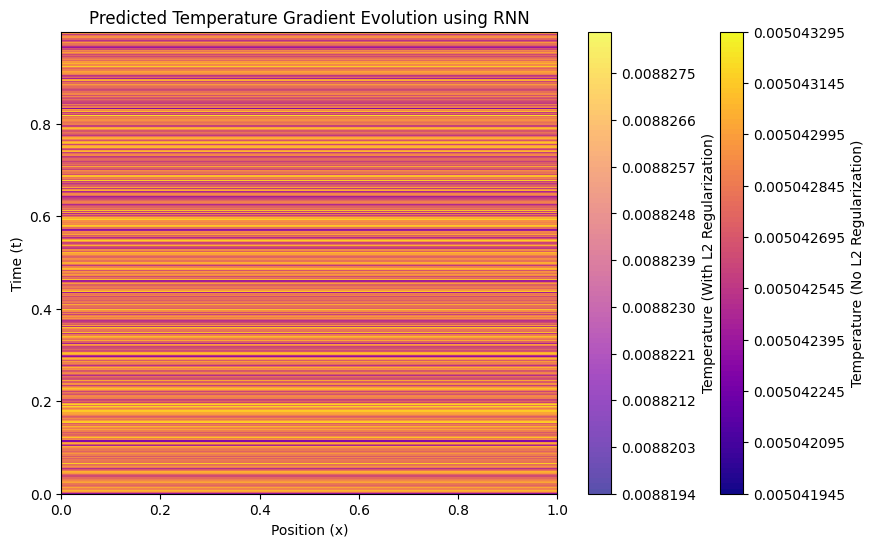

In [8]:
#RMSE/Gradient Rod Evolution over time using Spins, now adding an l2-regularization term for the combination of parameters
#yielding the best results, now greatly increasing the l2 parameter:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

#Using 'Spins' for the discretized PDE:
class Spins:
    def __init__(self, size, initial_condition):
        self.size = size
        self.spins = initial_condition.copy()

    def update(self, alpha, dt, dx):
        new_spins = np.zeros_like(self.spins)

        for i in range(1, self.size - 1):
            # Apply the discretized PDE equation to update spins
            new_spins[i] = self.spins[i] + alpha * (self.spins[i + 1] - 2 * self.spins[i] + self.spins[i - 1]) * dt / dx**2

        # Boundary conditions
        new_spins[0] = 0
        new_spins[-1] = 0

        self.spins = new_spins.copy()

#Solve the PDE:
class PDESolver:
    def __init__(self, x_dim, t_dim, dx, dt, alpha, spins):
        self.x_dim = x_dim
        self.t_dim = t_dim
        self.dx = dx
        self.dt = dt
        self.alpha = alpha
        self.spins = spins
        self.grid = np.zeros((x_dim, t_dim))  # Initialize grid for u(x, t)

    def initialize_conditions(self):
        self.grid[:, 0] = self.spins.spins.copy()

    def solve(self):
        for j in range(0, self.t_dim - 1):
            self.spins.update(self.alpha, self.dt, self.dx)
            self.grid[:, j + 1] = self.spins.spins.copy()

#The Recurrent Neural Network:
class RecurrentNN:
    def __init__(self, input_dim, hidden_layer_sizes, output_dim, dropout_rate=0.5, momentum=0.9, l2_penalty=1):
        self.input_dim = input_dim
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_dim = output_dim
        self.dropout_rate = dropout_rate
        self.momentum = momentum
        self.l2_penalty = l2_penalty  # Include the l2_penalty parameter
        self.weights = []
        self.biases = []
        self.activations = [self.sigmoid] * (len(hidden_layer_sizes) + 1)  # Sigmoid for hidden layers

        prev_layer_size = input_dim
        for layer_size in hidden_layer_sizes:
            weight_layer = np.random.randn(prev_layer_size, layer_size)
            bias_layer = np.zeros(layer_size)
            self.weights.append(weight_layer)
            self.biases.append(bias_layer)

            prev_layer_size = layer_size

        # Output layer weights
        weight_output = np.random.randn(prev_layer_size, output_dim)
        bias_output = np.zeros(output_dim)
        self.weights.append(weight_output)
        self.biases.append(bias_output)
    
    #Activation function:
    def sigmoid(self, x, derivative=False):
        if derivative:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))
    
    #Apply dropou function:
    def dropout(self, x):
        if self.dropout_rate >= 1.0:
            return x

        mask = (np.random.rand(*x.shape) < self.dropout_rate) / max(1e-5, (1 - self.dropout_rate))
        return x * mask
    
    #Forward Pass
    def forward(self, x, training=True):
        layer_input = x
        layer_outputs = [layer_input]
        masks = []

        for i in range(len(self.weights)):
            weighted_sum = np.dot(layer_input, self.weights[i]) + self.biases[i]
            layer_output = self.activations[i](weighted_sum)

            if training and i < len(self.weights) - 1:
                layer_output = self.dropout(layer_output)
                masks.append(layer_output)

            layer_outputs.append(layer_output)
            layer_input = layer_output

        return layer_outputs, masks
    
    #Training
    def train(self, input_sequences, target_outputs, learning_rate, num_epochs, desc="Training"):
        num_samples, sequence_length, _ = input_sequences.shape
        training_errors = []  # Store training errors
        min_rmse = float('inf')  # Initialize minimum RMSE

        # Initialize velocities for momentum
        velocities = [np.zeros_like(w) for w in self.weights]
        biases_velocities = [np.zeros_like(b) for b in self.biases]

        for epoch in tqdm(range(num_epochs), desc=desc):
            for sample in range(num_samples):
                input_sequence = input_sequences[sample, :, :]
                target_output = target_outputs[sample, :]

                # Forward pass with dropout
                layer_outputs, masks = self.forward(input_sequence)

                final_output = layer_outputs[-1]

                # Calculate loss with L2 regularization
                loss = np.mean((final_output - target_output)**2)
                l2_regularization = 0.5 * self.l2_penalty * sum(np.sum(w**2) for w in self.weights)
                loss += l2_regularization

                training_errors.append(loss)

                # Backpropagation Through Time (BPTT) with momentum and L2 regularization
                derror = 2 * (final_output - target_output) / num_samples

                for i in range(len(self.weights) - 1, -1, -1):
                    dactivation = self.sigmoid(layer_outputs[i + 1], derivative=True)
                    
                    # Ensure dactivation has the same shape as derror
                    dactivation = dactivation[:, :derror.shape[1]]

                    doutput = derror * dactivation

                    # Apply dropout mask during backpropagation
                    if i < len(self.weights) - 1:
                        doutput *= masks[i]

                    dweights = np.dot(layer_outputs[i].T, doutput) + self.l2_penalty * self.weights[i]
                    dbiases = np.sum(doutput, axis=0)

                    # Update velocities with momentum
                    velocities[i] = self.momentum * velocities[i] + learning_rate * dweights
                    biases_velocities[i] = self.momentum * biases_velocities[i] + learning_rate * dbiases

                    # Update weights and biases with momentum
                    self.weights[i] -= velocities[i]
                    self.biases[i] -= biases_velocities[i]

                    derror = np.dot(doutput, self.weights[i].T)

                # Calculate and print minimum RMSE during training
                if len(training_errors) % sequence_length == 0:
                    rmse = np.sqrt(np.mean(training_errors[-sequence_length:]))
                    if rmse < min_rmse:
                        min_rmse = rmse
                    print(f'Minimum RMSE at epoch {epoch + 1}: {min_rmse}')

        return training_errors
        
    def predict(self, input_sequence):
        layer_input = input_sequence
        for i in range(len(self.weights)):
            weighted_sum = np.dot(layer_input, self.weights[i]) + self.biases[i]
            layer_input = self.sigmoid(weighted_sum)

        return layer_input

    def plot_3d_training_progress(self, training_errors_f, training_errors_g):
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        epochs = len(training_errors_f)

        # Ensure that both arrays have the same length
        min_len = min(len(training_errors_f), len(training_errors_g))
        x = np.arange(0, min_len, 1)

        # Plot the 3D line
        ax.plot(x, training_errors_f[:min_len], zs=0, zdir='y', label='RMSE for f(t)')
        ax.plot(x, training_errors_g[:min_len], zs=1, zdir='y', label='RMSE for g(x)')

        ax.set_xlabel('Epochs')
        ax.set_ylabel('Functions')
        ax.set_zlabel('RMSE')
        ax.set_title('3D Plot of RMSE for f(t) and g(x)')
        ax.legend()

        plt.show()

# PDE solver parameters
x_dim = 100
t_dim = 1000
L = 1.0
dx = L / (x_dim - 1)
dt = 0.001
alpha = 0.01

# Create Spins instance for the PDE solver with initial condition sin(pi*x)
initial_condition = np.sin(np.pi * np.linspace(0, 1, x_dim))
spins = Spins(x_dim, initial_condition)

# Create PDE solver with spins
pde_solver = PDESolver(x_dim, t_dim, dx, dt, alpha, spins)

# Initialize initial conditions
pde_solver.initialize_conditions()

# Prepare data for RNN training with spins
num_samples = 20
input_sequences = np.zeros((num_samples, x_dim, t_dim))
target_outputs = np.zeros((num_samples, x_dim, t_dim))

for i in range(num_samples):
    input_sequences[i, :, :] = pde_solver.grid.copy()
    pde_solver.solve()
    target_outputs[i, :, :] = pde_solver.grid.copy()

# RNN parameters
input_dim = x_dim
hidden_layer_sizes = [2, 2, 2, 2, 2, 2, 2, 2]  # 2 layers with 10 neurons each
output_dim = x_dim
learning_rate = 1e-2
num_epochs = 1000
momentum_value = 0.7
dropout_rate = 0.5  # Adjust dropout rate as needed

# Create and train RNN for f(t) and g(x) together with BPTT
rnn_model_fg = RecurrentNN(t_dim, hidden_layer_sizes, t_dim, dropout_rate)
training_errors_fg = rnn_model_fg.train(input_sequences[:, :, :], target_outputs[:, 0, :], learning_rate, num_epochs, desc="Training f(t) and g(x)")

# Predict using the trained RNN
predicted_outputs_fg = np.zeros((num_samples, x_dim, t_dim))
for i in range(num_samples):
    input_sequence = input_sequences[i, :, :]
    predicted_output_fg = rnn_model_fg.predict(input_sequence)
    predicted_outputs_fg[i, :, :] = predicted_output_fg

# Create and train RNN for f(t) and g(x) together with BPTT with L2 regularization
rnn_model_fg_l2 = RecurrentNN(t_dim, hidden_layer_sizes, t_dim, dropout_rate, momentum_value)
training_errors_fg_l2 = rnn_model_fg_l2.train(input_sequences[:, :, :], target_outputs[:, 0, :], learning_rate, num_epochs, desc="Training f(t) and g(x) with L2 regularization")

# Predict using the trained RNN with L2 regularization
predicted_outputs_fg_l2 = np.zeros((num_samples, x_dim, t_dim))
for i in range(num_samples):
    input_sequence = input_sequences[i, :, :]
    predicted_output_fg_l2 = rnn_model_fg_l2.predict(input_sequence)
    predicted_outputs_fg_l2[i, :, :] = predicted_output_fg_l2

# Visualize the results
fig, ax = plt.subplots(figsize=(10, 6))
X, T = np.meshgrid(np.linspace(0, L, x_dim), np.linspace(0, dt * (t_dim - 1), t_dim))
Z_fg = predicted_outputs_fg[0, :, :].T  # Transpose the matrix to match the expected shape
Z_fg_l2 = predicted_outputs_fg_l2[0, :, :].T

# Use a different color map with a broader range of colors
contour_fg = ax.contourf(X, T, Z_fg, cmap='plasma', levels=100)
contour_fg_l2 = ax.contourf(X, T, Z_fg_l2, cmap='plasma', levels=100, alpha=0.7)  # Adjust alpha for transparency

ax.set_xlabel('Position (x)')
ax.set_ylabel('Time (t)')
ax.set_title('Predicted Temperature Gradient Evolution using RNN')
plt.colorbar(contour_fg, ax=ax, label='Temperature (No L2 Regularization)')
plt.colorbar(contour_fg_l2, ax=ax, label='Temperature (With L2 Regularization)')
plt.show()

#Using 'Spins', over the Monte Carlo samples and visualizing the results. The temperature stays in a low segment.

Training f(t) and g(x):   0%|                                                                 | 0/1000 [00:00<?, ?it/s]C:\Users\Kjæreng\AppData\Local\Temp\ipykernel_16248\692648788.py:73: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
Training f(t) and g(x):   1%|▎                                                        | 6/1000 [00:00<01:16, 12.92it/s]

Minimum RMSE at epoch 5: 1.1666914382771568e+40


Training f(t) and g(x):   1%|▋                                                       | 12/1000 [00:00<01:18, 12.63it/s]

Minimum RMSE at epoch 10: 1.1666914382771568e+40


Training f(t) and g(x):   2%|▉                                                       | 16/1000 [00:01<01:16, 12.80it/s]

Minimum RMSE at epoch 15: 1.1666914382771568e+40


Training f(t) and g(x):   2%|█                                                       | 20/1000 [00:01<01:17, 12.60it/s]

Minimum RMSE at epoch 20: 1.1666914382771568e+40


Training f(t) and g(x):   3%|█▍                                                      | 26/1000 [00:02<01:24, 11.56it/s]

Minimum RMSE at epoch 25: 1.1666914382771568e+40


Training f(t) and g(x):   3%|█▊                                                      | 32/1000 [00:02<01:32, 10.51it/s]

Minimum RMSE at epoch 30: 1.1666914382771568e+40


Training f(t) and g(x):   4%|██                                                      | 36/1000 [00:03<01:28, 10.91it/s]

Minimum RMSE at epoch 35: 1.1666914382771568e+40


Training f(t) and g(x):   4%|██▎                                                     | 42/1000 [00:03<01:17, 12.37it/s]

Minimum RMSE at epoch 40: 1.1666914382771568e+40


Training f(t) and g(x):   5%|██▌                                                     | 46/1000 [00:04<01:24, 11.29it/s]

Minimum RMSE at epoch 45: 1.1666914382771568e+40


Training f(t) and g(x):   5%|██▉                                                     | 52/1000 [00:04<01:09, 13.68it/s]

Minimum RMSE at epoch 50: 1.1666914382771568e+40


Training f(t) and g(x):   6%|███▏                                                    | 56/1000 [00:04<01:05, 14.42it/s]

Minimum RMSE at epoch 55: 1.1666914382771568e+40


Training f(t) and g(x):   6%|███▍                                                    | 62/1000 [00:05<01:04, 14.57it/s]

Minimum RMSE at epoch 60: 1.1666914382771568e+40


Training f(t) and g(x):   7%|███▋                                                    | 66/1000 [00:05<01:04, 14.48it/s]

Minimum RMSE at epoch 65: 1.1666914382771568e+40


Training f(t) and g(x):   7%|████                                                    | 72/1000 [00:05<01:01, 15.20it/s]

Minimum RMSE at epoch 70: 1.1666914382771568e+40


Training f(t) and g(x):   8%|████▎                                                   | 76/1000 [00:06<01:03, 14.51it/s]

Minimum RMSE at epoch 75: 1.1666914382771568e+40


Training f(t) and g(x):   8%|████▌                                                   | 82/1000 [00:06<01:06, 13.74it/s]

Minimum RMSE at epoch 80: 1.1666914382771568e+40


Training f(t) and g(x):   9%|████▊                                                   | 86/1000 [00:06<01:06, 13.74it/s]

Minimum RMSE at epoch 85: 1.1666914382771568e+40


Training f(t) and g(x):   9%|█████▏                                                  | 92/1000 [00:07<01:05, 13.80it/s]

Minimum RMSE at epoch 90: 1.1666914382771568e+40


Training f(t) and g(x):  10%|█████▍                                                  | 96/1000 [00:07<01:05, 13.72it/s]

Minimum RMSE at epoch 95: 1.1666914382771568e+40


Training f(t) and g(x):  10%|█████▌                                                 | 100/1000 [00:07<01:08, 13.22it/s]

Minimum RMSE at epoch 100: 1.1666914382771568e+40


Training f(t) and g(x):  11%|█████▊                                                 | 106/1000 [00:08<01:14, 11.98it/s]

Minimum RMSE at epoch 105: 1.1666914382771568e+40


Training f(t) and g(x):  11%|██████▏                                                | 112/1000 [00:08<01:07, 13.11it/s]

Minimum RMSE at epoch 110: 1.1666914382771568e+40


Training f(t) and g(x):  12%|██████▍                                                | 116/1000 [00:09<01:08, 12.81it/s]

Minimum RMSE at epoch 115: 1.1666914382771568e+40


Training f(t) and g(x):  12%|██████▋                                                | 122/1000 [00:09<01:01, 14.22it/s]

Minimum RMSE at epoch 120: 1.1666914382771568e+40


Training f(t) and g(x):  13%|███████                                                | 128/1000 [00:09<00:58, 15.01it/s]

Minimum RMSE at epoch 125: 1.1666914382771568e+40


Training f(t) and g(x):  13%|███████▎                                               | 132/1000 [00:10<01:02, 13.90it/s]

Minimum RMSE at epoch 130: 1.1666914382771568e+40


Training f(t) and g(x):  14%|███████▌                                               | 138/1000 [00:10<00:57, 14.92it/s]

Minimum RMSE at epoch 135: 1.1666914382771568e+40


Training f(t) and g(x):  14%|███████▊                                               | 142/1000 [00:10<00:56, 15.13it/s]

Minimum RMSE at epoch 140: 1.1666914382771568e+40


Training f(t) and g(x):  15%|████████                                               | 146/1000 [00:11<00:59, 14.26it/s]

Minimum RMSE at epoch 145: 1.1666914382771568e+40


Training f(t) and g(x):  15%|████████▎                                              | 152/1000 [00:11<00:58, 14.53it/s]

Minimum RMSE at epoch 150: 1.1666914382771568e+40


Training f(t) and g(x):  16%|████████▋                                              | 158/1000 [00:11<00:55, 15.20it/s]

Minimum RMSE at epoch 155: 1.1666914382771568e+40


Training f(t) and g(x):  16%|████████▉                                              | 162/1000 [00:12<00:57, 14.53it/s]

Minimum RMSE at epoch 160: 1.1666914382771568e+40


Training f(t) and g(x):  17%|█████████▏                                             | 166/1000 [00:12<01:01, 13.57it/s]

Minimum RMSE at epoch 165: 1.1666914382771568e+40


Training f(t) and g(x):  17%|█████████▍                                             | 172/1000 [00:12<01:02, 13.28it/s]

Minimum RMSE at epoch 170: 1.1666914382771568e+40


Training f(t) and g(x):  18%|█████████▋                                             | 176/1000 [00:13<01:07, 12.17it/s]

Minimum RMSE at epoch 175: 1.1666914382771568e+40


Training f(t) and g(x):  18%|██████████                                             | 182/1000 [00:13<01:07, 12.14it/s]

Minimum RMSE at epoch 180: 1.1666914382771568e+40


Training f(t) and g(x):  19%|██████████▏                                            | 186/1000 [00:14<01:07, 12.07it/s]

Minimum RMSE at epoch 185: 1.1666914382771568e+40


Training f(t) and g(x):  19%|██████████▌                                            | 192/1000 [00:14<01:06, 12.23it/s]

Minimum RMSE at epoch 190: 1.1666914382771568e+40


Training f(t) and g(x):  20%|██████████▊                                            | 196/1000 [00:14<01:03, 12.56it/s]

Minimum RMSE at epoch 195: 1.1666914382771568e+40


Training f(t) and g(x):  20%|███████████                                            | 202/1000 [00:15<01:05, 12.25it/s]

Minimum RMSE at epoch 200: 1.1666914382771568e+40


Training f(t) and g(x):  21%|███████████▎                                           | 206/1000 [00:15<01:03, 12.55it/s]

Minimum RMSE at epoch 205: 1.1666914382771568e+40


Training f(t) and g(x):  21%|███████████▋                                           | 212/1000 [00:16<01:01, 12.84it/s]

Minimum RMSE at epoch 210: 1.1666914382771568e+40


Training f(t) and g(x):  22%|███████████▉                                           | 216/1000 [00:16<00:56, 13.95it/s]

Minimum RMSE at epoch 215: 1.1666914382771568e+40


Training f(t) and g(x):  22%|████████████▏                                          | 222/1000 [00:17<01:00, 12.96it/s]

Minimum RMSE at epoch 220: 1.1666914382771568e+40


Training f(t) and g(x):  23%|████████████▍                                          | 226/1000 [00:17<00:57, 13.48it/s]

Minimum RMSE at epoch 225: 1.1666914382771568e+40


Training f(t) and g(x):  23%|████████████▊                                          | 232/1000 [00:17<00:56, 13.48it/s]

Minimum RMSE at epoch 230: 1.1666914382771568e+40


Training f(t) and g(x):  24%|████████████▉                                          | 236/1000 [00:18<01:00, 12.60it/s]

Minimum RMSE at epoch 235: 1.1666914382771568e+40


Training f(t) and g(x):  24%|█████████████▎                                         | 242/1000 [00:18<00:52, 14.30it/s]

Minimum RMSE at epoch 240: 1.1666914382771568e+40


Training f(t) and g(x):  25%|█████████████▋                                         | 248/1000 [00:18<00:49, 15.11it/s]

Minimum RMSE at epoch 245: 1.1666914382771568e+40


Training f(t) and g(x):  25%|█████████████▊                                         | 252/1000 [00:19<00:49, 15.17it/s]

Minimum RMSE at epoch 250: 1.1666914382771568e+40


Training f(t) and g(x):  26%|██████████████▏                                        | 258/1000 [00:19<00:48, 15.43it/s]

Minimum RMSE at epoch 255: 1.1666914382771568e+40


Training f(t) and g(x):  26%|██████████████▍                                        | 262/1000 [00:19<00:49, 14.78it/s]

Minimum RMSE at epoch 260: 1.1666914382771568e+40


Training f(t) and g(x):  27%|██████████████▋                                        | 266/1000 [00:20<00:50, 14.49it/s]

Minimum RMSE at epoch 265: 1.1666914382771568e+40


Training f(t) and g(x):  27%|██████████████▊                                        | 270/1000 [00:20<00:49, 14.85it/s]

Minimum RMSE at epoch 270: 1.1666914382771568e+40


Training f(t) and g(x):  28%|███████████████▎                                       | 278/1000 [00:20<00:51, 14.06it/s]

Minimum RMSE at epoch 275: 1.1666914382771568e+40


Training f(t) and g(x):  28%|███████████████▌                                       | 282/1000 [00:21<00:49, 14.63it/s]

Minimum RMSE at epoch 280: 1.1666914382771568e+40


Training f(t) and g(x):  29%|███████████████▊                                       | 288/1000 [00:21<00:47, 15.12it/s]

Minimum RMSE at epoch 285: 1.1666914382771568e+40


Training f(t) and g(x):  29%|████████████████                                       | 292/1000 [00:21<00:46, 15.16it/s]

Minimum RMSE at epoch 290: 1.1666914382771568e+40


Training f(t) and g(x):  30%|████████████████▍                                      | 298/1000 [00:22<00:45, 15.31it/s]

Minimum RMSE at epoch 295: 1.1666914382771568e+40


Training f(t) and g(x):  30%|████████████████▌                                      | 302/1000 [00:22<00:45, 15.27it/s]

Minimum RMSE at epoch 300: 1.1666914382771568e+40


Training f(t) and g(x):  31%|████████████████▊                                      | 306/1000 [00:22<00:45, 15.23it/s]

Minimum RMSE at epoch 305: 1.1666914382771568e+40


Training f(t) and g(x):  31%|█████████████████▏                                     | 312/1000 [00:23<00:44, 15.45it/s]

Minimum RMSE at epoch 310: 1.1666914382771568e+40


Training f(t) and g(x):  32%|█████████████████▍                                     | 318/1000 [00:23<00:43, 15.53it/s]

Minimum RMSE at epoch 315: 1.1666914382771568e+40


Training f(t) and g(x):  32%|█████████████████▋                                     | 322/1000 [00:23<00:44, 15.36it/s]

Minimum RMSE at epoch 320: 1.1666914382771568e+40


Training f(t) and g(x):  33%|█████████████████▉                                     | 326/1000 [00:24<00:44, 15.02it/s]

Minimum RMSE at epoch 325: 1.1666914382771568e+40


Training f(t) and g(x):  33%|██████████████████▎                                    | 332/1000 [00:24<00:48, 13.66it/s]

Minimum RMSE at epoch 330: 1.1666914382771568e+40


Training f(t) and g(x):  34%|██████████████████▍                                    | 336/1000 [00:25<01:07,  9.80it/s]

Minimum RMSE at epoch 335: 1.1666914382771568e+40


Training f(t) and g(x):  34%|██████████████████▊                                    | 342/1000 [00:25<00:54, 12.13it/s]

Minimum RMSE at epoch 340: 1.1666914382771568e+40


Training f(t) and g(x):  35%|███████████████████                                    | 346/1000 [00:25<00:47, 13.84it/s]

Minimum RMSE at epoch 345: 1.1666914382771568e+40


Training f(t) and g(x):  35%|███████████████████▎                                   | 350/1000 [00:26<00:46, 13.83it/s]

Minimum RMSE at epoch 350: 1.1666914382771568e+40


Training f(t) and g(x):  36%|███████████████████▌                                   | 356/1000 [00:26<01:11,  9.01it/s]

Minimum RMSE at epoch 355: 1.1666914382771568e+40


Training f(t) and g(x):  36%|███████████████████▉                                   | 362/1000 [00:27<00:58, 10.94it/s]

Minimum RMSE at epoch 360: 1.1666914382771568e+40


Training f(t) and g(x):  37%|████████████████████▏                                  | 366/1000 [00:27<00:58, 10.88it/s]

Minimum RMSE at epoch 365: 1.1666914382771568e+40


Training f(t) and g(x):  37%|████████████████████▍                                  | 372/1000 [00:28<00:49, 12.81it/s]

Minimum RMSE at epoch 370: 1.1666914382771568e+40


Training f(t) and g(x):  38%|████████████████████▋                                  | 376/1000 [00:28<00:53, 11.74it/s]

Minimum RMSE at epoch 375: 1.1666914382771568e+40


Training f(t) and g(x):  38%|█████████████████████                                  | 382/1000 [00:28<00:46, 13.29it/s]

Minimum RMSE at epoch 380: 1.1666914382771568e+40


Training f(t) and g(x):  39%|█████████████████████▏                                 | 386/1000 [00:29<00:43, 14.21it/s]

Minimum RMSE at epoch 385: 1.1666914382771568e+40


Training f(t) and g(x):  39%|█████████████████████▌                                 | 392/1000 [00:29<00:45, 13.43it/s]

Minimum RMSE at epoch 390: 1.1666914382771568e+40


Training f(t) and g(x):  40%|█████████████████████▊                                 | 396/1000 [00:29<00:44, 13.63it/s]

Minimum RMSE at epoch 395: 1.1666914382771568e+40


Training f(t) and g(x):  40%|██████████████████████                                 | 402/1000 [00:30<00:48, 12.46it/s]

Minimum RMSE at epoch 400: 1.1666914382771568e+40


Training f(t) and g(x):  41%|██████████████████████▎                                | 406/1000 [00:30<00:43, 13.73it/s]

Minimum RMSE at epoch 405: 1.1666914382771568e+40


Training f(t) and g(x):  41%|██████████████████████▋                                | 412/1000 [00:31<00:39, 14.88it/s]

Minimum RMSE at epoch 410: 1.1666914382771568e+40


Training f(t) and g(x):  42%|██████████████████████▉                                | 416/1000 [00:31<00:40, 14.54it/s]

Minimum RMSE at epoch 415: 1.1666914382771568e+40


Training f(t) and g(x):  42%|███████████████████████▏                               | 422/1000 [00:31<00:38, 15.07it/s]

Minimum RMSE at epoch 420: 1.1666914382771568e+40


Training f(t) and g(x):  43%|███████████████████████▌                               | 428/1000 [00:32<00:37, 15.39it/s]

Minimum RMSE at epoch 425: 1.1666914382771568e+40


Training f(t) and g(x):  43%|███████████████████████▊                               | 432/1000 [00:32<00:37, 15.31it/s]

Minimum RMSE at epoch 430: 1.1666914382771568e+40


Training f(t) and g(x):  44%|███████████████████████▉                               | 436/1000 [00:32<00:36, 15.26it/s]

Minimum RMSE at epoch 435: 1.1666914382771568e+40


Training f(t) and g(x):  44%|████████████████████████▎                              | 442/1000 [00:33<00:38, 14.41it/s]

Minimum RMSE at epoch 440: 1.1666914382771568e+40


Training f(t) and g(x):  45%|████████████████████████▌                              | 446/1000 [00:33<00:37, 14.81it/s]

Minimum RMSE at epoch 445: 1.1666914382771568e+40


Training f(t) and g(x):  45%|████████████████████████▊                              | 452/1000 [00:33<00:36, 14.91it/s]

Minimum RMSE at epoch 450: 1.1666914382771568e+40


Training f(t) and g(x):  46%|█████████████████████████                              | 456/1000 [00:34<00:36, 14.91it/s]

Minimum RMSE at epoch 455: 1.1666914382771568e+40


Training f(t) and g(x):  46%|█████████████████████████▍                             | 462/1000 [00:34<00:36, 14.70it/s]

Minimum RMSE at epoch 460: 1.1666914382771568e+40


Training f(t) and g(x):  47%|█████████████████████████▋                             | 466/1000 [00:34<00:35, 14.95it/s]

Minimum RMSE at epoch 465: 1.1666914382771568e+40


Training f(t) and g(x):  47%|█████████████████████████▉                             | 472/1000 [00:35<00:35, 14.82it/s]

Minimum RMSE at epoch 470: 1.1666914382771568e+40


Training f(t) and g(x):  48%|██████████████████████████▎                            | 478/1000 [00:35<00:34, 15.19it/s]

Minimum RMSE at epoch 475: 1.1666914382771568e+40


Training f(t) and g(x):  48%|██████████████████████████▌                            | 482/1000 [00:35<00:34, 15.19it/s]

Minimum RMSE at epoch 480: 1.1666914382771568e+40


Training f(t) and g(x):  49%|██████████████████████████▋                            | 486/1000 [00:36<00:33, 15.21it/s]

Minimum RMSE at epoch 485: 1.1666914382771568e+40


Training f(t) and g(x):  49%|███████████████████████████                            | 492/1000 [00:36<00:34, 14.90it/s]

Minimum RMSE at epoch 490: 1.1666914382771568e+40


Training f(t) and g(x):  50%|███████████████████████████▍                           | 498/1000 [00:36<00:32, 15.33it/s]

Minimum RMSE at epoch 495: 1.1666914382771568e+40


Training f(t) and g(x):  50%|███████████████████████████▌                           | 502/1000 [00:37<00:32, 15.27it/s]

Minimum RMSE at epoch 500: 1.1666914382771568e+40


Training f(t) and g(x):  51%|███████████████████████████▊                           | 506/1000 [00:37<00:32, 15.25it/s]

Minimum RMSE at epoch 505: 1.1666914382771568e+40


Training f(t) and g(x):  51%|████████████████████████████▏                          | 512/1000 [00:37<00:32, 15.06it/s]

Minimum RMSE at epoch 510: 1.1666914382771568e+40


Training f(t) and g(x):  52%|████████████████████████████▍                          | 516/1000 [00:38<00:31, 15.14it/s]

Minimum RMSE at epoch 515: 1.1666914382771568e+40


Training f(t) and g(x):  52%|████████████████████████████▋                          | 522/1000 [00:38<00:32, 14.88it/s]

Minimum RMSE at epoch 520: 1.1666914382771568e+40


Training f(t) and g(x):  53%|████████████████████████████▉                          | 526/1000 [00:38<00:31, 15.04it/s]

Minimum RMSE at epoch 525: 1.1666914382771568e+40


Training f(t) and g(x):  53%|█████████████████████████████▎                         | 532/1000 [00:39<00:31, 14.85it/s]

Minimum RMSE at epoch 530: 1.1666914382771568e+40


Training f(t) and g(x):  54%|█████████████████████████████▍                         | 536/1000 [00:39<00:30, 15.04it/s]

Minimum RMSE at epoch 535: 1.1666914382771568e+40


Training f(t) and g(x):  54%|█████████████████████████████▊                         | 542/1000 [00:39<00:30, 14.99it/s]

Minimum RMSE at epoch 540: 1.1666914382771568e+40


Training f(t) and g(x):  55%|██████████████████████████████▏                        | 548/1000 [00:40<00:31, 14.48it/s]

Minimum RMSE at epoch 545: 1.1666914382771568e+40


Training f(t) and g(x):  55%|██████████████████████████████▎                        | 552/1000 [00:40<00:30, 14.69it/s]

Minimum RMSE at epoch 550: 1.1666914382771568e+40


Training f(t) and g(x):  56%|██████████████████████████████▌                        | 556/1000 [00:40<00:29, 14.95it/s]

Minimum RMSE at epoch 555: 1.1666914382771568e+40


Training f(t) and g(x):  56%|██████████████████████████████▉                        | 562/1000 [00:41<00:29, 14.97it/s]

Minimum RMSE at epoch 560: 1.1666914382771568e+40


Training f(t) and g(x):  57%|███████████████████████████████▏                       | 566/1000 [00:41<00:28, 15.10it/s]

Minimum RMSE at epoch 565: 1.1666914382771568e+40


Training f(t) and g(x):  57%|███████████████████████████████▍                       | 572/1000 [00:41<00:28, 14.86it/s]

Minimum RMSE at epoch 570: 1.1666914382771568e+40


Training f(t) and g(x):  58%|███████████████████████████████▊                       | 578/1000 [00:42<00:27, 15.20it/s]

Minimum RMSE at epoch 575: 1.1666914382771568e+40


Training f(t) and g(x):  58%|████████████████████████████████                       | 582/1000 [00:42<00:28, 14.69it/s]

Minimum RMSE at epoch 580: 1.1666914382771568e+40


Training f(t) and g(x):  59%|████████████████████████████████▏                      | 586/1000 [00:42<00:32, 12.79it/s]

Minimum RMSE at epoch 585: 1.1666914382771568e+40


Training f(t) and g(x):  59%|████████████████████████████████▌                      | 592/1000 [00:43<00:29, 14.02it/s]

Minimum RMSE at epoch 590: 1.1666914382771568e+40


Training f(t) and g(x):  60%|████████████████████████████████▊                      | 596/1000 [00:43<00:28, 14.12it/s]

Minimum RMSE at epoch 595: 1.1666914382771568e+40


Training f(t) and g(x):  60%|█████████████████████████████████                      | 602/1000 [00:43<00:26, 14.77it/s]

Minimum RMSE at epoch 600: 1.1666914382771568e+40


Training f(t) and g(x):  61%|█████████████████████████████████▎                     | 606/1000 [00:44<00:26, 15.00it/s]

Minimum RMSE at epoch 605: 1.1666914382771568e+40


Training f(t) and g(x):  61%|█████████████████████████████████▋                     | 612/1000 [00:44<00:25, 14.99it/s]

Minimum RMSE at epoch 610: 1.1666914382771568e+40


Training f(t) and g(x):  62%|█████████████████████████████████▉                     | 618/1000 [00:45<00:25, 14.98it/s]

Minimum RMSE at epoch 615: 1.1666914382771568e+40


Training f(t) and g(x):  62%|██████████████████████████████████▏                    | 622/1000 [00:45<00:25, 14.59it/s]

Minimum RMSE at epoch 620: 1.1666914382771568e+40


Training f(t) and g(x):  63%|██████████████████████████████████▌                    | 628/1000 [00:45<00:24, 15.10it/s]

Minimum RMSE at epoch 625: 1.1666914382771568e+40


Training f(t) and g(x):  63%|██████████████████████████████████▊                    | 632/1000 [00:46<00:24, 15.16it/s]

Minimum RMSE at epoch 630: 1.1666914382771568e+40


Training f(t) and g(x):  64%|███████████████████████████████████                    | 638/1000 [00:46<00:23, 15.31it/s]

Minimum RMSE at epoch 635: 1.1666914382771568e+40


Training f(t) and g(x):  64%|███████████████████████████████████▎                   | 642/1000 [00:46<00:23, 15.26it/s]

Minimum RMSE at epoch 640: 1.1666914382771568e+40


Training f(t) and g(x):  65%|███████████████████████████████████▌                   | 646/1000 [00:46<00:23, 15.23it/s]

Minimum RMSE at epoch 645: 1.1666914382771568e+40


Training f(t) and g(x):  65%|███████████████████████████████████▊                   | 652/1000 [00:47<00:23, 14.91it/s]

Minimum RMSE at epoch 650: 1.1666914382771568e+40


Training f(t) and g(x):  66%|████████████████████████████████████▏                  | 658/1000 [00:47<00:22, 15.34it/s]

Minimum RMSE at epoch 655: 1.1666914382771568e+40


Training f(t) and g(x):  66%|████████████████████████████████████▍                  | 662/1000 [00:47<00:22, 15.27it/s]

Minimum RMSE at epoch 660: 1.1666914382771568e+40


Training f(t) and g(x):  67%|████████████████████████████████████▋                  | 666/1000 [00:48<00:21, 15.24it/s]

Minimum RMSE at epoch 665: 1.1666914382771568e+40


Training f(t) and g(x):  67%|████████████████████████████████████▉                  | 672/1000 [00:48<00:21, 14.91it/s]

Minimum RMSE at epoch 670: 1.1666914382771568e+40


Training f(t) and g(x):  68%|█████████████████████████████████████▎                 | 678/1000 [00:49<00:21, 15.22it/s]

Minimum RMSE at epoch 675: 1.1666914382771568e+40


Training f(t) and g(x):  68%|█████████████████████████████████████▌                 | 682/1000 [00:49<00:21, 14.70it/s]

Minimum RMSE at epoch 680: 1.1666914382771568e+40


Training f(t) and g(x):  69%|█████████████████████████████████████▋                 | 686/1000 [00:49<00:21, 14.80it/s]

Minimum RMSE at epoch 685: 1.1666914382771568e+40


Training f(t) and g(x):  69%|██████████████████████████████████████                 | 692/1000 [00:50<00:20, 14.80it/s]

Minimum RMSE at epoch 690: 1.1666914382771568e+40


Training f(t) and g(x):  70%|██████████████████████████████████████▍                | 698/1000 [00:50<00:19, 15.18it/s]

Minimum RMSE at epoch 695: 1.1666914382771568e+40


Training f(t) and g(x):  70%|██████████████████████████████████████▌                | 702/1000 [00:50<00:20, 14.68it/s]

Minimum RMSE at epoch 700: 1.1666914382771568e+40


Training f(t) and g(x):  71%|██████████████████████████████████████▉                | 708/1000 [00:51<00:19, 15.14it/s]

Minimum RMSE at epoch 705: 1.1666914382771568e+40


Training f(t) and g(x):  71%|███████████████████████████████████████▏               | 712/1000 [00:51<00:18, 15.18it/s]

Minimum RMSE at epoch 710: 1.1666914382771568e+40


Training f(t) and g(x):  72%|███████████████████████████████████████▍               | 718/1000 [00:51<00:18, 15.05it/s]

Minimum RMSE at epoch 715: 1.1666914382771568e+40


Training f(t) and g(x):  72%|███████████████████████████████████████▋               | 722/1000 [00:52<00:19, 14.61it/s]

Minimum RMSE at epoch 720: 1.1666914382771568e+40


Training f(t) and g(x):  73%|███████████████████████████████████████▉               | 726/1000 [00:52<00:18, 14.76it/s]

Minimum RMSE at epoch 725: 1.1666914382771568e+40


Training f(t) and g(x):  73%|████████████████████████████████████████▎              | 732/1000 [00:52<00:18, 14.75it/s]

Minimum RMSE at epoch 730: 1.1666914382771568e+40


Training f(t) and g(x):  74%|████████████████████████████████████████▍              | 736/1000 [00:52<00:17, 14.98it/s]

Minimum RMSE at epoch 735: 1.1666914382771568e+40


Training f(t) and g(x):  74%|████████████████████████████████████████▊              | 742/1000 [00:53<00:17, 14.48it/s]

Minimum RMSE at epoch 740: 1.1666914382771568e+40


Training f(t) and g(x):  75%|█████████████████████████████████████████              | 746/1000 [00:53<00:17, 14.69it/s]

Minimum RMSE at epoch 745: 1.1666914382771568e+40


Training f(t) and g(x):  75%|█████████████████████████████████████████▎             | 752/1000 [00:54<00:16, 14.88it/s]

Minimum RMSE at epoch 750: 1.1666914382771568e+40


Training f(t) and g(x):  76%|█████████████████████████████████████████▌             | 756/1000 [00:54<00:16, 15.05it/s]

Minimum RMSE at epoch 755: 1.1666914382771568e+40


Training f(t) and g(x):  76%|█████████████████████████████████████████▉             | 762/1000 [00:54<00:15, 15.01it/s]

Minimum RMSE at epoch 760: 1.1666914382771568e+40


Training f(t) and g(x):  77%|██████████████████████████████████████████▏            | 766/1000 [00:55<00:16, 14.59it/s]

Minimum RMSE at epoch 765: 1.1666914382771568e+40


Training f(t) and g(x):  77%|██████████████████████████████████████████▍            | 772/1000 [00:55<00:15, 14.69it/s]

Minimum RMSE at epoch 770: 1.1666914382771568e+40


Training f(t) and g(x):  78%|██████████████████████████████████████████▊            | 778/1000 [00:55<00:14, 15.13it/s]

Minimum RMSE at epoch 775: 1.1666914382771568e+40


Training f(t) and g(x):  78%|███████████████████████████████████████████            | 782/1000 [00:56<00:14, 15.18it/s]

Minimum RMSE at epoch 780: 1.1666914382771568e+40


Training f(t) and g(x):  79%|███████████████████████████████████████████▏           | 786/1000 [00:56<00:14, 15.20it/s]

Minimum RMSE at epoch 785: 1.1666914382771568e+40


Training f(t) and g(x):  79%|███████████████████████████████████████████▌           | 792/1000 [00:56<00:14, 14.79it/s]

Minimum RMSE at epoch 790: 1.1666914382771568e+40


Training f(t) and g(x):  80%|███████████████████████████████████████████▊           | 796/1000 [00:57<00:13, 14.84it/s]

Minimum RMSE at epoch 795: 1.1666914382771568e+40


Training f(t) and g(x):  80%|████████████████████████████████████████████           | 802/1000 [00:57<00:13, 15.20it/s]

Minimum RMSE at epoch 800: 1.1666914382771568e+40


Training f(t) and g(x):  81%|████████████████████████████████████████████▎          | 806/1000 [00:57<00:13, 14.68it/s]

Minimum RMSE at epoch 805: 1.1666914382771568e+40


Training f(t) and g(x):  81%|████████████████████████████████████████████▋          | 812/1000 [00:58<00:12, 15.13it/s]

Minimum RMSE at epoch 810: 1.1666914382771568e+40


Training f(t) and g(x):  82%|████████████████████████████████████████████▉          | 818/1000 [00:58<00:12, 15.04it/s]

Minimum RMSE at epoch 815: 1.1666914382771568e+40


Training f(t) and g(x):  82%|█████████████████████████████████████████████▏         | 822/1000 [00:58<00:11, 15.13it/s]

Minimum RMSE at epoch 820: 1.1666914382771568e+40


Training f(t) and g(x):  83%|█████████████████████████████████████████████▍         | 826/1000 [00:59<00:11, 15.17it/s]

Minimum RMSE at epoch 825: 1.1666914382771568e+40


Training f(t) and g(x):  83%|█████████████████████████████████████████████▊         | 832/1000 [00:59<00:11, 14.89it/s]

Minimum RMSE at epoch 830: 1.1666914382771568e+40


Training f(t) and g(x):  84%|██████████████████████████████████████████████         | 838/1000 [00:59<00:10, 15.32it/s]

Minimum RMSE at epoch 835: 1.1666914382771568e+40


Training f(t) and g(x):  84%|██████████████████████████████████████████████▎        | 842/1000 [01:00<00:10, 14.74it/s]

Minimum RMSE at epoch 840: 1.1666914382771568e+40


Training f(t) and g(x):  85%|██████████████████████████████████████████████▋        | 848/1000 [01:00<00:10, 15.16it/s]

Minimum RMSE at epoch 845: 1.1666914382771568e+40


Training f(t) and g(x):  85%|██████████████████████████████████████████████▊        | 852/1000 [01:00<00:10, 14.67it/s]

Minimum RMSE at epoch 850: 1.1666914382771568e+40


Training f(t) and g(x):  86%|███████████████████████████████████████████████        | 856/1000 [01:01<00:09, 14.94it/s]

Minimum RMSE at epoch 855: 1.1666914382771568e+40


Training f(t) and g(x):  86%|███████████████████████████████████████████████▍       | 862/1000 [01:01<00:09, 14.81it/s]

Minimum RMSE at epoch 860: 1.1666914382771568e+40


Training f(t) and g(x):  87%|███████████████████████████████████████████████▋       | 866/1000 [01:01<00:09, 14.86it/s]

Minimum RMSE at epoch 865: 1.1666914382771568e+40


Training f(t) and g(x):  87%|███████████████████████████████████████████████▊       | 870/1000 [01:01<00:08, 14.67it/s]

Minimum RMSE at epoch 870: 1.1666914382771568e+40


Training f(t) and g(x):  88%|████████████████████████████████████████████████▏      | 876/1000 [01:02<00:09, 12.92it/s]

Minimum RMSE at epoch 875: 1.1666914382771568e+40


Training f(t) and g(x):  88%|████████████████████████████████████████████████▌      | 882/1000 [01:03<00:10, 11.37it/s]

Minimum RMSE at epoch 880: 1.1666914382771568e+40


Training f(t) and g(x):  89%|████████████████████████████████████████████████▋      | 886/1000 [01:03<00:08, 13.06it/s]

Minimum RMSE at epoch 885: 1.1666914382771568e+40


Training f(t) and g(x):  89%|█████████████████████████████████████████████████      | 892/1000 [01:03<00:08, 12.72it/s]

Minimum RMSE at epoch 890: 1.1666914382771568e+40


Training f(t) and g(x):  90%|█████████████████████████████████████████████████▎     | 896/1000 [01:04<00:08, 12.80it/s]

Minimum RMSE at epoch 895: 1.1666914382771568e+40


Training f(t) and g(x):  90%|█████████████████████████████████████████████████▌     | 902/1000 [01:04<00:08, 11.87it/s]

Minimum RMSE at epoch 900: 1.1666914382771568e+40


Training f(t) and g(x):  91%|█████████████████████████████████████████████████▊     | 906/1000 [01:04<00:07, 13.06it/s]

Minimum RMSE at epoch 905: 1.1666914382771568e+40


Training f(t) and g(x):  91%|██████████████████████████████████████████████████▏    | 912/1000 [01:05<00:06, 12.91it/s]

Minimum RMSE at epoch 910: 1.1666914382771568e+40


Training f(t) and g(x):  92%|██████████████████████████████████████████████████▍    | 916/1000 [01:05<00:06, 12.64it/s]

Minimum RMSE at epoch 915: 1.1666914382771568e+40


Training f(t) and g(x):  92%|██████████████████████████████████████████████████▋    | 922/1000 [01:06<00:05, 13.05it/s]

Minimum RMSE at epoch 920: 1.1666914382771568e+40


Training f(t) and g(x):  93%|██████████████████████████████████████████████████▉    | 926/1000 [01:06<00:05, 13.51it/s]

Minimum RMSE at epoch 925: 1.1666914382771568e+40


Training f(t) and g(x):  93%|███████████████████████████████████████████████████▎   | 932/1000 [01:06<00:04, 13.97it/s]

Minimum RMSE at epoch 930: 1.1666914382771568e+40


Training f(t) and g(x):  94%|███████████████████████████████████████████████████▍   | 936/1000 [01:07<00:04, 13.78it/s]

Minimum RMSE at epoch 935: 1.1666914382771568e+40


Training f(t) and g(x):  94%|███████████████████████████████████████████████████▋   | 940/1000 [01:07<00:04, 14.31it/s]

Minimum RMSE at epoch 940: 1.1666914382771568e+40


Training f(t) and g(x):  95%|████████████████████████████████████████████████████▏  | 948/1000 [01:08<00:03, 14.19it/s]

Minimum RMSE at epoch 945: 1.1666914382771568e+40


Training f(t) and g(x):  95%|████████████████████████████████████████████████████▎  | 952/1000 [01:08<00:03, 14.21it/s]

Minimum RMSE at epoch 950: 1.1666914382771568e+40


Training f(t) and g(x):  96%|████████████████████████████████████████████████████▌  | 956/1000 [01:08<00:02, 14.71it/s]

Minimum RMSE at epoch 955: 1.1666914382771568e+40


Training f(t) and g(x):  96%|████████████████████████████████████████████████████▉  | 962/1000 [01:09<00:02, 14.38it/s]

Minimum RMSE at epoch 960: 1.1666914382771568e+40


Training f(t) and g(x):  97%|█████████████████████████████████████████████████████▏ | 968/1000 [01:09<00:02, 15.03it/s]

Minimum RMSE at epoch 965: 1.1666914382771568e+40


Training f(t) and g(x):  97%|█████████████████████████████████████████████████████▍ | 972/1000 [01:09<00:01, 14.61it/s]

Minimum RMSE at epoch 970: 1.1666914382771568e+40


Training f(t) and g(x):  98%|█████████████████████████████████████████████████████▋ | 976/1000 [01:09<00:01, 14.91it/s]

Minimum RMSE at epoch 975: 1.1666914382771568e+40


Training f(t) and g(x):  98%|██████████████████████████████████████████████████████ | 982/1000 [01:10<00:01, 13.98it/s]

Minimum RMSE at epoch 980: 1.1666914382771568e+40


Training f(t) and g(x):  99%|██████████████████████████████████████████████████████▏| 986/1000 [01:10<00:00, 14.59it/s]

Minimum RMSE at epoch 985: 1.1666914382771568e+40


Training f(t) and g(x):  99%|██████████████████████████████████████████████████████▌| 992/1000 [01:11<00:00, 14.84it/s]

Minimum RMSE at epoch 990: 1.1666914382771568e+40


Training f(t) and g(x): 100%|██████████████████████████████████████████████████████▊| 996/1000 [01:11<00:00, 11.84it/s]

Minimum RMSE at epoch 995: 1.1666914382771568e+40


Training f(t) and g(x): 100%|██████████████████████████████████████████████████████| 1000/1000 [01:11<00:00, 13.94it/s]


Minimum RMSE at epoch 1000: 1.1666914382771568e+40


Training f(t) and g(x) with L2 regularization:   1%|▏                                 | 6/1000 [00:00<01:02, 16.00it/s]

Minimum RMSE at epoch 5: 0.28592418916893186


Training f(t) and g(x) with L2 regularization:   1%|▍                                | 12/1000 [00:00<01:15, 13.04it/s]

Minimum RMSE at epoch 10: 0.13219585522833435


Training f(t) and g(x) with L2 regularization:   2%|▌                                | 16/1000 [00:01<01:07, 14.49it/s]

Minimum RMSE at epoch 15: 0.10147919317736544


Training f(t) and g(x) with L2 regularization:   2%|▋                                | 22/1000 [00:01<01:06, 14.66it/s]

Minimum RMSE at epoch 20: 0.0872300945922326


Training f(t) and g(x) with L2 regularization:   3%|▉                                | 28/1000 [00:01<01:04, 15.13it/s]

Minimum RMSE at epoch 25: 0.0788207241787379


Training f(t) and g(x) with L2 regularization:   3%|█                                | 32/1000 [00:02<01:04, 15.01it/s]

Minimum RMSE at epoch 30: 0.0732435513967998


Training f(t) and g(x) with L2 regularization:   4%|█▏                               | 36/1000 [00:02<01:06, 14.60it/s]

Minimum RMSE at epoch 35: 0.06923581493937489


Training f(t) and g(x) with L2 regularization:   4%|█▍                               | 42/1000 [00:02<01:03, 15.11it/s]

Minimum RMSE at epoch 40: 0.06622863038015558


Training f(t) and g(x) with L2 regularization:   5%|█▌                               | 48/1000 [00:03<01:02, 15.28it/s]

Minimum RMSE at epoch 45: 0.06386949576641934


Training f(t) and g(x) with L2 regularization:   5%|█▋                               | 52/1000 [00:03<01:05, 14.57it/s]

Minimum RMSE at epoch 50: 0.061973271156116116


Training f(t) and g(x) with L2 regularization:   6%|█▉                               | 58/1000 [00:03<01:01, 15.21it/s]

Minimum RMSE at epoch 55: 0.06042360012663072


Training f(t) and g(x) with L2 regularization:   6%|██                               | 62/1000 [00:04<01:01, 15.21it/s]

Minimum RMSE at epoch 60: 0.05912246761455325


Training f(t) and g(x) with L2 regularization:   7%|██▏                              | 68/1000 [00:04<01:00, 15.33it/s]

Minimum RMSE at epoch 65: 0.058019573748234576


Training f(t) and g(x) with L2 regularization:   7%|██▍                              | 72/1000 [00:04<01:04, 14.43it/s]

Minimum RMSE at epoch 70: 0.05706868036365543


Training f(t) and g(x) with L2 regularization:   8%|██▌                              | 78/1000 [00:05<01:09, 13.21it/s]

Minimum RMSE at epoch 75: 0.056250084282679684


Training f(t) and g(x) with L2 regularization:   8%|██▋                              | 82/1000 [00:05<01:03, 14.50it/s]

Minimum RMSE at epoch 80: 0.05552473160090032


Training f(t) and g(x) with L2 regularization:   9%|██▊                              | 86/1000 [00:05<01:10, 12.92it/s]

Minimum RMSE at epoch 85: 0.05488597597799963


Training f(t) and g(x) with L2 regularization:   9%|███                              | 92/1000 [00:06<01:03, 14.21it/s]

Minimum RMSE at epoch 90: 0.05431928879392634


Training f(t) and g(x) with L2 regularization:  10%|███▏                             | 98/1000 [00:06<01:00, 14.96it/s]

Minimum RMSE at epoch 95: 0.05381066368318449


Training f(t) and g(x) with L2 regularization:  10%|███▎                            | 102/1000 [00:07<00:59, 15.09it/s]

Minimum RMSE at epoch 100: 0.05334801097128762


Training f(t) and g(x) with L2 regularization:  11%|███▍                            | 106/1000 [00:07<00:59, 15.15it/s]

Minimum RMSE at epoch 105: 0.05293521923680842


Training f(t) and g(x) with L2 regularization:  11%|███▌                            | 112/1000 [00:07<00:59, 14.88it/s]

Minimum RMSE at epoch 110: 0.05255386029862896


Training f(t) and g(x) with L2 regularization:  12%|███▊                            | 118/1000 [00:08<00:56, 15.59it/s]

Minimum RMSE at epoch 115: 0.052209572792587026


Training f(t) and g(x) with L2 regularization:  12%|███▉                            | 122/1000 [00:08<00:57, 15.40it/s]

Minimum RMSE at epoch 120: 0.05189112947367248


Training f(t) and g(x) with L2 regularization:  13%|████                            | 126/1000 [00:08<00:57, 15.31it/s]

Minimum RMSE at epoch 125: 0.05159936278355861


Training f(t) and g(x) with L2 regularization:  13%|████▏                           | 132/1000 [00:09<01:03, 13.60it/s]

Minimum RMSE at epoch 130: 0.051334443517062886


Training f(t) and g(x) with L2 regularization:  14%|████▎                           | 136/1000 [00:09<01:03, 13.68it/s]

Minimum RMSE at epoch 135: 0.051079822687585645


Training f(t) and g(x) with L2 regularization:  14%|████▌                           | 142/1000 [00:09<01:03, 13.57it/s]

Minimum RMSE at epoch 140: 0.05084930853177196


Training f(t) and g(x) with L2 regularization:  15%|████▋                           | 148/1000 [00:10<00:58, 14.69it/s]

Minimum RMSE at epoch 145: 0.05063331005977106


Training f(t) and g(x) with L2 regularization:  15%|████▊                           | 152/1000 [00:10<00:57, 14.80it/s]

Minimum RMSE at epoch 150: 0.0504331103690258


Training f(t) and g(x) with L2 regularization:  16%|█████                           | 158/1000 [00:10<00:55, 15.18it/s]

Minimum RMSE at epoch 155: 0.05024331050419752


Training f(t) and g(x) with L2 regularization:  16%|█████▏                          | 162/1000 [00:11<00:55, 15.19it/s]

Minimum RMSE at epoch 160: 0.050066503405967015


Training f(t) and g(x) with L2 regularization:  17%|█████▎                          | 166/1000 [00:11<00:54, 15.21it/s]

Minimum RMSE at epoch 165: 0.049897300780213164


Training f(t) and g(x) with L2 regularization:  17%|█████▌                          | 172/1000 [00:11<00:59, 13.89it/s]

Minimum RMSE at epoch 170: 0.04974282278990331


Training f(t) and g(x) with L2 regularization:  18%|█████▋                          | 176/1000 [00:12<00:57, 14.38it/s]

Minimum RMSE at epoch 175: 0.04959337230667545


Training f(t) and g(x) with L2 regularization:  18%|█████▊                          | 182/1000 [00:12<00:55, 14.66it/s]

Minimum RMSE at epoch 180: 0.04945711782853502


Training f(t) and g(x) with L2 regularization:  19%|██████                          | 188/1000 [00:12<00:53, 15.25it/s]

Minimum RMSE at epoch 185: 0.04932657513592926


Training f(t) and g(x) with L2 regularization:  19%|██████▏                         | 192/1000 [00:13<00:53, 15.23it/s]

Minimum RMSE at epoch 190: 0.049199939364839206


Training f(t) and g(x) with L2 regularization:  20%|██████▎                         | 196/1000 [00:13<00:54, 14.70it/s]

Minimum RMSE at epoch 195: 0.04908020432405636


Training f(t) and g(x) with L2 regularization:  20%|██████▍                         | 202/1000 [00:13<00:51, 15.53it/s]

Minimum RMSE at epoch 200: 0.04896842430976336


Training f(t) and g(x) with L2 regularization:  21%|██████▋                         | 208/1000 [00:14<00:50, 15.55it/s]

Minimum RMSE at epoch 205: 0.04886166937414734


Training f(t) and g(x) with L2 regularization:  21%|██████▊                         | 212/1000 [00:14<00:51, 15.38it/s]

Minimum RMSE at epoch 210: 0.04875911813592873


Training f(t) and g(x) with L2 regularization:  22%|██████▉                         | 216/1000 [00:14<00:49, 15.69it/s]

Minimum RMSE at epoch 215: 0.04866248472915863


Training f(t) and g(x) with L2 regularization:  22%|███████                         | 222/1000 [00:15<00:49, 15.60it/s]

Minimum RMSE at epoch 220: 0.0485705495271896


Training f(t) and g(x) with L2 regularization:  23%|███████▎                        | 228/1000 [00:15<00:49, 15.58it/s]

Minimum RMSE at epoch 225: 0.048482680109080814


Training f(t) and g(x) with L2 regularization:  23%|███████▍                        | 232/1000 [00:15<00:51, 14.86it/s]

Minimum RMSE at epoch 230: 0.04839609619172826


Training f(t) and g(x) with L2 regularization:  24%|███████▌                        | 238/1000 [00:16<00:49, 15.31it/s]

Minimum RMSE at epoch 235: 0.04831500402011973


Training f(t) and g(x) with L2 regularization:  24%|███████▋                        | 242/1000 [00:16<00:50, 15.10it/s]

Minimum RMSE at epoch 240: 0.048238768855228646


Training f(t) and g(x) with L2 regularization:  25%|███████▉                        | 248/1000 [00:16<00:47, 15.68it/s]

Minimum RMSE at epoch 245: 0.04816471614174725


Training f(t) and g(x) with L2 regularization:  25%|████████                        | 252/1000 [00:17<00:48, 15.43it/s]

Minimum RMSE at epoch 250: 0.04809224817538283


Training f(t) and g(x) with L2 regularization:  26%|████████▎                       | 258/1000 [00:17<00:48, 15.40it/s]

Minimum RMSE at epoch 255: 0.04802177810633595


Training f(t) and g(x) with L2 regularization:  26%|████████▍                       | 262/1000 [00:17<00:46, 15.70it/s]

Minimum RMSE at epoch 260: 0.047956512121336156


Training f(t) and g(x) with L2 regularization:  27%|████████▌                       | 266/1000 [00:18<00:47, 15.45it/s]

Minimum RMSE at epoch 265: 0.04789338372441775


Training f(t) and g(x) with L2 regularization:  27%|████████▋                       | 272/1000 [00:18<00:47, 15.36it/s]

Minimum RMSE at epoch 270: 0.047830404004780606


Training f(t) and g(x) with L2 regularization:  28%|████████▊                       | 276/1000 [00:18<00:47, 15.29it/s]

Minimum RMSE at epoch 275: 0.04777166977928909


Training f(t) and g(x) with L2 regularization:  28%|█████████                       | 282/1000 [00:19<00:46, 15.47it/s]

Minimum RMSE at epoch 280: 0.04771670624427713


Training f(t) and g(x) with L2 regularization:  29%|█████████▏                      | 286/1000 [00:19<00:46, 15.34it/s]

Minimum RMSE at epoch 285: 0.04766151759963403


Training f(t) and g(x) with L2 regularization:  29%|█████████▎                      | 292/1000 [00:19<00:47, 14.95it/s]

Minimum RMSE at epoch 290: 0.047607138954507376


Training f(t) and g(x) with L2 regularization:  30%|█████████▍                      | 296/1000 [00:20<00:45, 15.47it/s]

Minimum RMSE at epoch 295: 0.047557099130276274


Training f(t) and g(x) with L2 regularization:  30%|█████████▋                      | 302/1000 [00:20<00:44, 15.53it/s]

Minimum RMSE at epoch 300: 0.047507952351759454


Training f(t) and g(x) with L2 regularization:  31%|█████████▊                      | 308/1000 [00:20<00:44, 15.44it/s]

Minimum RMSE at epoch 305: 0.04746078264241081


Training f(t) and g(x) with L2 regularization:  31%|█████████▉                      | 312/1000 [00:21<00:45, 15.16it/s]

Minimum RMSE at epoch 310: 0.04741447817393572


Training f(t) and g(x) with L2 regularization:  32%|██████████                      | 316/1000 [00:21<00:43, 15.57it/s]

Minimum RMSE at epoch 315: 0.047368977593696404


Training f(t) and g(x) with L2 regularization:  32%|██████████▎                     | 322/1000 [00:21<00:45, 15.02it/s]

Minimum RMSE at epoch 320: 0.04732538908006596


Training f(t) and g(x) with L2 regularization:  33%|██████████▍                     | 328/1000 [00:22<00:44, 15.25it/s]

Minimum RMSE at epoch 325: 0.04728482443478698


Training f(t) and g(x) with L2 regularization:  33%|██████████▌                     | 332/1000 [00:22<00:42, 15.62it/s]

Minimum RMSE at epoch 330: 0.047242283006522515


Training f(t) and g(x) with L2 regularization:  34%|██████████▊                     | 336/1000 [00:22<00:43, 15.42it/s]

Minimum RMSE at epoch 335: 0.047202693606244066


Training f(t) and g(x) with L2 regularization:  34%|██████████▉                     | 342/1000 [00:23<00:42, 15.40it/s]

Minimum RMSE at epoch 340: 0.047164828087481715


Training f(t) and g(x) with L2 regularization:  35%|███████████▏                    | 348/1000 [00:23<00:41, 15.79it/s]

Minimum RMSE at epoch 345: 0.047127648961185035


Training f(t) and g(x) with L2 regularization:  35%|███████████▎                    | 352/1000 [00:23<00:41, 15.49it/s]

Minimum RMSE at epoch 350: 0.04709097829432992


Training f(t) and g(x) with L2 regularization:  36%|███████████▍                    | 358/1000 [00:24<00:40, 15.83it/s]

Minimum RMSE at epoch 355: 0.04705643459187738


Training f(t) and g(x) with L2 regularization:  36%|███████████▌                    | 362/1000 [00:24<00:40, 15.91it/s]

Minimum RMSE at epoch 360: 0.04702047946800406


Training f(t) and g(x) with L2 regularization:  37%|███████████▋                    | 366/1000 [00:24<00:40, 15.55it/s]

Minimum RMSE at epoch 365: 0.04698840123827781


Training f(t) and g(x) with L2 regularization:  37%|███████████▉                    | 372/1000 [00:24<00:39, 15.84it/s]

Minimum RMSE at epoch 370: 0.0469565250381627


Training f(t) and g(x) with L2 regularization:  38%|████████████                    | 378/1000 [00:25<00:39, 15.65it/s]

Minimum RMSE at epoch 375: 0.04692568819157828


Training f(t) and g(x) with L2 regularization:  38%|████████████▏                   | 382/1000 [00:25<00:40, 15.43it/s]

Minimum RMSE at epoch 380: 0.0468938036947684


Training f(t) and g(x) with L2 regularization:  39%|████████████▎                   | 386/1000 [00:25<00:40, 15.32it/s]

Minimum RMSE at epoch 385: 0.046865101234666584


Training f(t) and g(x) with L2 regularization:  39%|████████████▌                   | 392/1000 [00:26<00:39, 15.47it/s]

Minimum RMSE at epoch 390: 0.046835734851121066


Training f(t) and g(x) with L2 regularization:  40%|████████████▋                   | 398/1000 [00:26<00:38, 15.54it/s]

Minimum RMSE at epoch 395: 0.04680687329363236


Training f(t) and g(x) with L2 regularization:  40%|████████████▊                   | 402/1000 [00:26<00:38, 15.37it/s]

Minimum RMSE at epoch 400: 0.04677910044339234


Training f(t) and g(x) with L2 regularization:  41%|█████████████                   | 408/1000 [00:27<00:38, 15.49it/s]

Minimum RMSE at epoch 405: 0.04675283502857359


Training f(t) and g(x) with L2 regularization:  41%|█████████████▏                  | 412/1000 [00:27<00:38, 15.35it/s]

Minimum RMSE at epoch 410: 0.046727007738038416


Training f(t) and g(x) with L2 regularization:  42%|█████████████▍                  | 418/1000 [00:27<00:37, 15.49it/s]

Minimum RMSE at epoch 415: 0.04670213817929385


Training f(t) and g(x) with L2 regularization:  42%|█████████████▌                  | 422/1000 [00:28<00:36, 15.74it/s]

Minimum RMSE at epoch 420: 0.046677928660589785


Training f(t) and g(x) with L2 regularization:  43%|█████████████▋                  | 428/1000 [00:28<00:36, 15.63it/s]

Minimum RMSE at epoch 425: 0.04665168148414205


Training f(t) and g(x) with L2 regularization:  43%|█████████████▊                  | 432/1000 [00:28<00:37, 15.25it/s]

Minimum RMSE at epoch 430: 0.0466285888095863


Training f(t) and g(x) with L2 regularization:  44%|█████████████▉                  | 436/1000 [00:29<00:37, 15.22it/s]

Minimum RMSE at epoch 435: 0.046604213099034814


Training f(t) and g(x) with L2 regularization:  44%|██████████████▏                 | 442/1000 [00:29<00:37, 14.91it/s]

Minimum RMSE at epoch 440: 0.046583229972521595


Training f(t) and g(x) with L2 regularization:  45%|██████████████▎                 | 448/1000 [00:29<00:38, 14.46it/s]

Minimum RMSE at epoch 445: 0.04656015695914744


Training f(t) and g(x) with L2 regularization:  45%|██████████████▍                 | 452/1000 [00:30<00:36, 14.83it/s]

Minimum RMSE at epoch 450: 0.04653879782352169


Training f(t) and g(x) with L2 regularization:  46%|██████████████▌                 | 456/1000 [00:30<00:36, 14.87it/s]

Minimum RMSE at epoch 455: 0.046518095557339295


Training f(t) and g(x) with L2 regularization:  46%|██████████████▊                 | 462/1000 [00:30<00:35, 15.21it/s]

Minimum RMSE at epoch 460: 0.046495963179375537


Training f(t) and g(x) with L2 regularization:  47%|██████████████▉                 | 468/1000 [00:31<00:34, 15.43it/s]

Minimum RMSE at epoch 465: 0.04647649590811627


Training f(t) and g(x) with L2 regularization:  47%|███████████████                 | 472/1000 [00:31<00:34, 15.32it/s]

Minimum RMSE at epoch 470: 0.04645573215760722


Training f(t) and g(x) with L2 regularization:  48%|███████████████▎                | 478/1000 [00:31<00:33, 15.37it/s]

Minimum RMSE at epoch 475: 0.04643727704182261


Training f(t) and g(x) with L2 regularization:  48%|███████████████▍                | 482/1000 [00:32<00:33, 15.67it/s]

Minimum RMSE at epoch 480: 0.046418141096473506


Training f(t) and g(x) with L2 regularization:  49%|███████████████▌                | 488/1000 [00:32<00:33, 15.49it/s]

Minimum RMSE at epoch 485: 0.04639895356379623


Training f(t) and g(x) with L2 regularization:  49%|███████████████▋                | 492/1000 [00:32<00:32, 15.74it/s]

Minimum RMSE at epoch 490: 0.04638046229762774


Training f(t) and g(x) with L2 regularization:  50%|███████████████▉                | 498/1000 [00:33<00:32, 15.62it/s]

Minimum RMSE at epoch 495: 0.04636321015999912


Training f(t) and g(x) with L2 regularization:  50%|████████████████                | 502/1000 [00:33<00:32, 15.41it/s]

Minimum RMSE at epoch 500: 0.046346410851033484


Training f(t) and g(x) with L2 regularization:  51%|████████████████▏               | 506/1000 [00:33<00:31, 15.71it/s]

Minimum RMSE at epoch 505: 0.04632846015282547


Training f(t) and g(x) with L2 regularization:  51%|████████████████▍               | 512/1000 [00:34<00:31, 15.61it/s]

Minimum RMSE at epoch 510: 0.046312533705531435


Training f(t) and g(x) with L2 regularization:  52%|████████████████▌               | 516/1000 [00:34<00:32, 14.87it/s]

Minimum RMSE at epoch 515: 0.04629517733574832


Training f(t) and g(x) with L2 regularization:  52%|████████████████▋               | 522/1000 [00:34<00:31, 15.05it/s]

Minimum RMSE at epoch 520: 0.0462796243869174


Training f(t) and g(x) with L2 regularization:  53%|████████████████▊               | 526/1000 [00:35<00:31, 14.98it/s]

Minimum RMSE at epoch 525: 0.046263071242760086


Training f(t) and g(x) with L2 regularization:  53%|█████████████████               | 532/1000 [00:35<00:30, 15.24it/s]

Minimum RMSE at epoch 530: 0.04624870323175975


Training f(t) and g(x) with L2 regularization:  54%|█████████████████▏              | 536/1000 [00:35<00:30, 15.23it/s]

Minimum RMSE at epoch 535: 0.04623223061386646


Training f(t) and g(x) with L2 regularization:  54%|█████████████████▎              | 542/1000 [00:36<00:29, 15.44it/s]

Minimum RMSE at epoch 540: 0.04621802721003227


Training f(t) and g(x) with L2 regularization:  55%|█████████████████▌              | 548/1000 [00:36<00:29, 15.52it/s]

Minimum RMSE at epoch 545: 0.04620377210608498


Training f(t) and g(x) with L2 regularization:  55%|█████████████████▋              | 552/1000 [00:36<00:29, 15.37it/s]

Minimum RMSE at epoch 550: 0.04618899782518037


Training f(t) and g(x) with L2 regularization:  56%|█████████████████▊              | 556/1000 [00:37<00:29, 15.29it/s]

Minimum RMSE at epoch 555: 0.04617401553068846


Training f(t) and g(x) with L2 regularization:  56%|█████████████████▉              | 562/1000 [00:37<00:28, 15.35it/s]

Minimum RMSE at epoch 560: 0.0461598128925963


Training f(t) and g(x) with L2 regularization:  57%|██████████████████▏             | 568/1000 [00:37<00:27, 15.49it/s]

Minimum RMSE at epoch 565: 0.046146532625003366


Training f(t) and g(x) with L2 regularization:  57%|██████████████████▎             | 572/1000 [00:38<00:28, 15.07it/s]

Minimum RMSE at epoch 570: 0.0461323483862168


Training f(t) and g(x) with L2 regularization:  58%|██████████████████▍             | 578/1000 [00:38<00:27, 15.28it/s]

Minimum RMSE at epoch 575: 0.04611881016472674


Training f(t) and g(x) with L2 regularization:  58%|██████████████████▌             | 582/1000 [00:38<00:26, 15.64it/s]

Minimum RMSE at epoch 580: 0.046106907151111196


Training f(t) and g(x) with L2 regularization:  59%|██████████████████▊             | 588/1000 [00:39<00:26, 15.58it/s]

Minimum RMSE at epoch 585: 0.04609468946811647


Training f(t) and g(x) with L2 regularization:  59%|██████████████████▉             | 592/1000 [00:39<00:26, 15.39it/s]

Minimum RMSE at epoch 590: 0.04608182261586731


Training f(t) and g(x) with L2 regularization:  60%|███████████████████▏            | 598/1000 [00:39<00:26, 15.39it/s]

Minimum RMSE at epoch 595: 0.04606980471780612


Training f(t) and g(x) with L2 regularization:  60%|███████████████████▎            | 602/1000 [00:40<00:26, 15.30it/s]

Minimum RMSE at epoch 600: 0.046056646135572074


Training f(t) and g(x) with L2 regularization:  61%|███████████████████▍            | 608/1000 [00:40<00:25, 15.47it/s]

Minimum RMSE at epoch 605: 0.04604529097152835


Training f(t) and g(x) with L2 regularization:  61%|███████████████████▌            | 612/1000 [00:40<00:24, 15.74it/s]

Minimum RMSE at epoch 610: 0.04603361626246693


Training f(t) and g(x) with L2 regularization:  62%|███████████████████▋            | 616/1000 [00:40<00:24, 15.47it/s]

Minimum RMSE at epoch 615: 0.046022492813234075


Training f(t) and g(x) with L2 regularization:  62%|███████████████████▊            | 620/1000 [00:41<00:25, 14.65it/s]

Minimum RMSE at epoch 620: 0.04601164443935619


Training f(t) and g(x) with L2 regularization:  63%|████████████████████            | 628/1000 [00:41<00:27, 13.70it/s]

Minimum RMSE at epoch 625: 0.045999969708044514


Training f(t) and g(x) with L2 regularization:  63%|████████████████████▏           | 632/1000 [00:42<00:25, 14.43it/s]

Minimum RMSE at epoch 630: 0.045989369549843916


Training f(t) and g(x) with L2 regularization:  64%|████████████████████▍           | 638/1000 [00:42<00:25, 14.44it/s]

Minimum RMSE at epoch 635: 0.04597835525626433


Training f(t) and g(x) with L2 regularization:  64%|████████████████████▌           | 642/1000 [00:42<00:24, 14.83it/s]

Minimum RMSE at epoch 640: 0.04596764108161748


Training f(t) and g(x) with L2 regularization:  65%|████████████████████▋           | 648/1000 [00:43<00:23, 15.29it/s]

Minimum RMSE at epoch 645: 0.045956935638189866


Training f(t) and g(x) with L2 regularization:  65%|████████████████████▊           | 652/1000 [00:43<00:22, 15.26it/s]

Minimum RMSE at epoch 650: 0.04594622073156281


Training f(t) and g(x) with L2 regularization:  66%|█████████████████████           | 658/1000 [00:43<00:22, 15.46it/s]

Minimum RMSE at epoch 655: 0.04593627219215994


Training f(t) and g(x) with L2 regularization:  66%|█████████████████████▏          | 662/1000 [00:44<00:21, 15.72it/s]

Minimum RMSE at epoch 660: 0.045925745823686775


Training f(t) and g(x) with L2 regularization:  67%|█████████████████████▍          | 668/1000 [00:44<00:21, 15.33it/s]

Minimum RMSE at epoch 665: 0.04591630142921427


Training f(t) and g(x) with L2 regularization:  67%|█████████████████████▌          | 672/1000 [00:44<00:20, 15.67it/s]

Minimum RMSE at epoch 670: 0.04590688968201553


Training f(t) and g(x) with L2 regularization:  68%|█████████████████████▋          | 678/1000 [00:45<00:20, 15.47it/s]

Minimum RMSE at epoch 675: 0.04589718759752273


Training f(t) and g(x) with L2 regularization:  68%|█████████████████████▊          | 682/1000 [00:45<00:20, 15.34it/s]

Minimum RMSE at epoch 680: 0.04588777264664704


Training f(t) and g(x) with L2 regularization:  69%|█████████████████████▉          | 686/1000 [00:45<00:20, 15.28it/s]

Minimum RMSE at epoch 685: 0.04587873705602171


Training f(t) and g(x) with L2 regularization:  69%|██████████████████████▏         | 692/1000 [00:46<00:20, 14.93it/s]

Minimum RMSE at epoch 690: 0.04586894568355853


Training f(t) and g(x) with L2 regularization:  70%|██████████████████████▎         | 698/1000 [00:46<00:19, 15.22it/s]

Minimum RMSE at epoch 695: 0.04586079043711752


Training f(t) and g(x) with L2 regularization:  70%|██████████████████████▍         | 702/1000 [00:46<00:19, 15.22it/s]

Minimum RMSE at epoch 700: 0.045851727218616904


Training f(t) and g(x) with L2 regularization:  71%|██████████████████████▌         | 706/1000 [00:47<00:19, 15.22it/s]

Minimum RMSE at epoch 705: 0.04584390710914052


Training f(t) and g(x) with L2 regularization:  71%|██████████████████████▊         | 712/1000 [00:47<00:18, 15.64it/s]

Minimum RMSE at epoch 710: 0.04583533179002861


Training f(t) and g(x) with L2 regularization:  72%|██████████████████████▉         | 716/1000 [00:47<00:18, 15.42it/s]

Minimum RMSE at epoch 715: 0.045826161176533015


Training f(t) and g(x) with L2 regularization:  72%|███████████████████████         | 722/1000 [00:48<00:18, 14.97it/s]

Minimum RMSE at epoch 720: 0.04581938550769919


Training f(t) and g(x) with L2 regularization:  73%|███████████████████████▎        | 728/1000 [00:48<00:17, 15.63it/s]

Minimum RMSE at epoch 725: 0.045809797819191124


Training f(t) and g(x) with L2 regularization:  73%|███████████████████████▍        | 732/1000 [00:48<00:17, 15.42it/s]

Minimum RMSE at epoch 730: 0.04580148615279405


Training f(t) and g(x) with L2 regularization:  74%|███████████████████████▌        | 736/1000 [00:48<00:17, 15.32it/s]

Minimum RMSE at epoch 735: 0.045794321190723505


Training f(t) and g(x) with L2 regularization:  74%|███████████████████████▋        | 742/1000 [00:49<00:17, 14.93it/s]

Minimum RMSE at epoch 740: 0.04578541427894067


Training f(t) and g(x) with L2 regularization:  75%|███████████████████████▉        | 748/1000 [00:49<00:16, 15.23it/s]

Minimum RMSE at epoch 745: 0.04577838479218873


Training f(t) and g(x) with L2 regularization:  75%|████████████████████████        | 752/1000 [00:50<00:16, 15.06it/s]

Minimum RMSE at epoch 750: 0.045769746956912515


Training f(t) and g(x) with L2 regularization:  76%|████████████████████████▏       | 756/1000 [00:50<00:15, 15.52it/s]

Minimum RMSE at epoch 755: 0.04576266753931806


Training f(t) and g(x) with L2 regularization:  76%|████████████████████████▍       | 762/1000 [00:50<00:15, 15.00it/s]

Minimum RMSE at epoch 760: 0.04575615985276562


Training f(t) and g(x) with L2 regularization:  77%|████████████████████████▌       | 768/1000 [00:51<00:14, 15.52it/s]

Minimum RMSE at epoch 765: 0.04574741712017091


Training f(t) and g(x) with L2 regularization:  77%|████████████████████████▋       | 772/1000 [00:51<00:14, 15.37it/s]

Minimum RMSE at epoch 770: 0.045740771657880167


Training f(t) and g(x) with L2 regularization:  78%|████████████████████████▊       | 776/1000 [00:51<00:14, 15.69it/s]

Minimum RMSE at epoch 775: 0.04573372921604794


Training f(t) and g(x) with L2 regularization:  78%|█████████████████████████       | 782/1000 [00:51<00:13, 15.61it/s]

Minimum RMSE at epoch 780: 0.0457255841984215


Training f(t) and g(x) with L2 regularization:  79%|█████████████████████████▏      | 786/1000 [00:52<00:13, 15.40it/s]

Minimum RMSE at epoch 785: 0.04571929971301852


Training f(t) and g(x) with L2 regularization:  79%|█████████████████████████▎      | 792/1000 [00:52<00:13, 14.97it/s]

Minimum RMSE at epoch 790: 0.04571213529513223


Training f(t) and g(x) with L2 regularization:  80%|█████████████████████████▍      | 796/1000 [00:52<00:13, 15.48it/s]

Minimum RMSE at epoch 795: 0.04570623072205417


Training f(t) and g(x) with L2 regularization:  80%|█████████████████████████▋      | 802/1000 [00:53<00:13, 14.98it/s]

Minimum RMSE at epoch 800: 0.045698912309020505


Training f(t) and g(x) with L2 regularization:  81%|█████████████████████████▊      | 808/1000 [00:53<00:12, 15.25it/s]

Minimum RMSE at epoch 805: 0.04569158984681238


Training f(t) and g(x) with L2 regularization:  81%|█████████████████████████▉      | 812/1000 [00:53<00:12, 15.62it/s]

Minimum RMSE at epoch 810: 0.04568589799295624


Training f(t) and g(x) with L2 regularization:  82%|██████████████████████████▏     | 818/1000 [00:54<00:11, 15.46it/s]

Minimum RMSE at epoch 815: 0.045679907411623734


Training f(t) and g(x) with L2 regularization:  82%|██████████████████████████▎     | 822/1000 [00:54<00:11, 15.34it/s]

Minimum RMSE at epoch 820: 0.04567223047760286


Training f(t) and g(x) with L2 regularization:  83%|██████████████████████████▍     | 828/1000 [00:55<00:11, 14.95it/s]

Minimum RMSE at epoch 825: 0.04566554628683799


Training f(t) and g(x) with L2 regularization:  83%|██████████████████████████▌     | 832/1000 [00:55<00:10, 15.46it/s]

Minimum RMSE at epoch 830: 0.04566041185156353


Training f(t) and g(x) with L2 regularization:  84%|██████████████████████████▊     | 838/1000 [00:55<00:10, 15.53it/s]

Minimum RMSE at epoch 835: 0.0456539658232157


Training f(t) and g(x) with L2 regularization:  84%|██████████████████████████▉     | 842/1000 [00:55<00:10, 15.37it/s]

Minimum RMSE at epoch 840: 0.04564732507621886


Training f(t) and g(x) with L2 regularization:  85%|███████████████████████████     | 846/1000 [00:56<00:09, 15.67it/s]

Minimum RMSE at epoch 845: 0.04564140015619394


Training f(t) and g(x) with L2 regularization:  85%|███████████████████████████▎    | 852/1000 [00:56<00:10, 14.50it/s]

Minimum RMSE at epoch 850: 0.04563586130703897


Training f(t) and g(x) with L2 regularization:  86%|███████████████████████████▍    | 858/1000 [00:57<00:10, 13.64it/s]

Minimum RMSE at epoch 855: 0.04562903257422907


Training f(t) and g(x) with L2 regularization:  86%|███████████████████████████▌    | 862/1000 [00:57<00:09, 14.26it/s]

Minimum RMSE at epoch 860: 0.045623619805659224


Training f(t) and g(x) with L2 regularization:  87%|███████████████████████████▊    | 868/1000 [00:57<00:08, 14.98it/s]

Minimum RMSE at epoch 865: 0.04561800268396026


Training f(t) and g(x) with L2 regularization:  87%|███████████████████████████▉    | 872/1000 [00:57<00:08, 15.10it/s]

Minimum RMSE at epoch 870: 0.04561218647218488


Training f(t) and g(x) with L2 regularization:  88%|████████████████████████████    | 876/1000 [00:58<00:08, 15.15it/s]

Minimum RMSE at epoch 875: 0.04560644718679709


Training f(t) and g(x) with L2 regularization:  88%|████████████████████████████▏   | 882/1000 [00:58<00:07, 15.31it/s]

Minimum RMSE at epoch 880: 0.04560033595612904


Training f(t) and g(x) with L2 regularization:  89%|████████████████████████████▎   | 886/1000 [00:58<00:07, 15.26it/s]

Minimum RMSE at epoch 885: 0.045595118531938726


Training f(t) and g(x) with L2 regularization:  89%|████████████████████████████▌   | 892/1000 [00:59<00:07, 15.07it/s]

Minimum RMSE at epoch 890: 0.04559064143424308


Training f(t) and g(x) with L2 regularization:  90%|████████████████████████████▋   | 898/1000 [00:59<00:06, 15.39it/s]

Minimum RMSE at epoch 895: 0.045584220797640976


Training f(t) and g(x) with L2 regularization:  90%|████████████████████████████▊   | 902/1000 [00:59<00:06, 15.31it/s]

Minimum RMSE at epoch 900: 0.045579250152671974


Training f(t) and g(x) with L2 regularization:  91%|█████████████████████████████   | 908/1000 [01:00<00:05, 15.35it/s]

Minimum RMSE at epoch 905: 0.045574149053875045


Training f(t) and g(x) with L2 regularization:  91%|█████████████████████████████▏  | 912/1000 [01:00<00:05, 15.68it/s]

Minimum RMSE at epoch 910: 0.04556856720227748


Training f(t) and g(x) with L2 regularization:  92%|█████████████████████████████▍  | 918/1000 [01:00<00:05, 15.89it/s]

Minimum RMSE at epoch 915: 0.04556429492304935


Training f(t) and g(x) with L2 regularization:  92%|█████████████████████████████▌  | 922/1000 [01:01<00:05, 15.53it/s]

Minimum RMSE at epoch 920: 0.04555871277765599


Training f(t) and g(x) with L2 regularization:  93%|█████████████████████████████▋  | 926/1000 [01:01<00:04, 15.77it/s]

Minimum RMSE at epoch 925: 0.0455532564819985


Training f(t) and g(x) with L2 regularization:  93%|█████████████████████████████▊  | 932/1000 [01:01<00:04, 15.25it/s]

Minimum RMSE at epoch 930: 0.045549210119404465


Training f(t) and g(x) with L2 regularization:  94%|█████████████████████████████▉  | 936/1000 [01:02<00:04, 14.70it/s]

Minimum RMSE at epoch 935: 0.04554391463104356


Training f(t) and g(x) with L2 regularization:  94%|██████████████████████████████▏ | 942/1000 [01:02<00:03, 14.88it/s]

Minimum RMSE at epoch 940: 0.04553910938212538


Training f(t) and g(x) with L2 regularization:  95%|██████████████████████████████▎ | 948/1000 [01:02<00:03, 15.21it/s]

Minimum RMSE at epoch 945: 0.04553348978509642


Training f(t) and g(x) with L2 regularization:  95%|██████████████████████████████▍ | 952/1000 [01:03<00:03, 15.05it/s]

Minimum RMSE at epoch 950: 0.04552949274834896


Training f(t) and g(x) with L2 regularization:  96%|██████████████████████████████▋ | 958/1000 [01:03<00:02, 15.27it/s]

Minimum RMSE at epoch 955: 0.04552404164572827


Training f(t) and g(x) with L2 regularization:  96%|██████████████████████████████▊ | 962/1000 [01:03<00:02, 15.24it/s]

Minimum RMSE at epoch 960: 0.04551976710785755


Training f(t) and g(x) with L2 regularization:  97%|██████████████████████████████▉ | 968/1000 [01:04<00:02, 15.45it/s]

Minimum RMSE at epoch 965: 0.04551514411144887


Training f(t) and g(x) with L2 regularization:  97%|███████████████████████████████ | 972/1000 [01:04<00:01, 15.17it/s]

Minimum RMSE at epoch 970: 0.04551002120689665


Training f(t) and g(x) with L2 regularization:  98%|███████████████████████████████▎| 978/1000 [01:04<00:01, 15.71it/s]

Minimum RMSE at epoch 975: 0.045506118945769114


Training f(t) and g(x) with L2 regularization:  98%|███████████████████████████████▍| 982/1000 [01:05<00:01, 15.44it/s]

Minimum RMSE at epoch 980: 0.045501912249706324


Training f(t) and g(x) with L2 regularization:  99%|███████████████████████████████▌| 988/1000 [01:05<00:00, 15.81it/s]

Minimum RMSE at epoch 985: 0.045497887410698955


Training f(t) and g(x) with L2 regularization:  99%|███████████████████████████████▋| 992/1000 [01:05<00:00, 15.50it/s]

Minimum RMSE at epoch 990: 0.04549269329970092


Training f(t) and g(x) with L2 regularization: 100%|███████████████████████████████▉| 998/1000 [01:06<00:00, 15.25it/s]

Minimum RMSE at epoch 995: 0.04548823927105173


Training f(t) and g(x) with L2 regularization: 100%|███████████████████████████████| 1000/1000 [01:06<00:00, 15.07it/s]


Minimum RMSE at epoch 1000: 0.045483943022070476


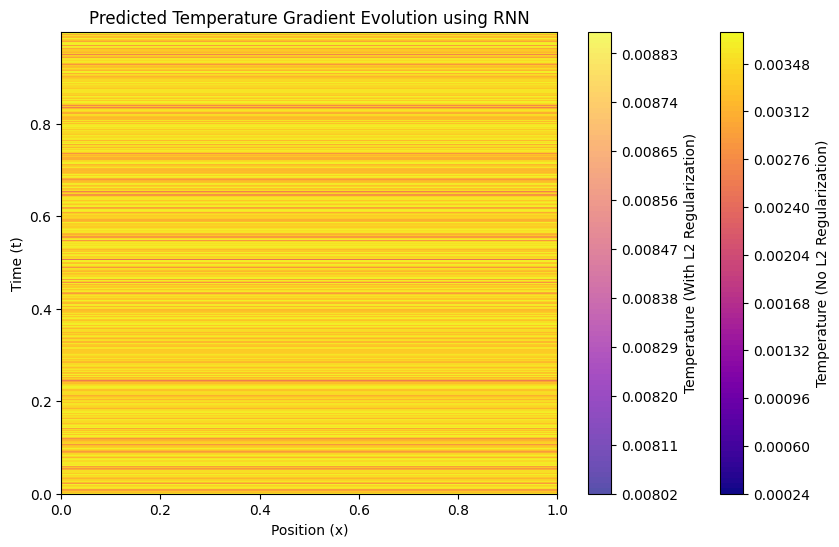

Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):   1%|               | 8/1000 [00:00<01:05, 15.22it/s]

Minimum RMSE at epoch 5: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):   1%|▏             | 12/1000 [00:00<01:05, 15.03it/s]

Minimum RMSE at epoch 10: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):   2%|▎             | 18/1000 [00:01<01:04, 15.27it/s]

Minimum RMSE at epoch 15: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):   2%|▎             | 22/1000 [00:01<01:04, 15.08it/s]

Minimum RMSE at epoch 20: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):   3%|▍             | 28/1000 [00:01<01:03, 15.28it/s]

Minimum RMSE at epoch 25: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):   3%|▍             | 32/1000 [00:02<01:03, 15.25it/s]

Minimum RMSE at epoch 30: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):   4%|▌             | 38/1000 [00:02<01:02, 15.46it/s]

Minimum RMSE at epoch 35: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):   4%|▌             | 42/1000 [00:02<01:02, 15.33it/s]

Minimum RMSE at epoch 40: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):   5%|▋             | 48/1000 [00:03<01:01, 15.48it/s]

Minimum RMSE at epoch 45: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):   5%|▋             | 52/1000 [00:03<01:01, 15.35it/s]

Minimum RMSE at epoch 50: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):   6%|▊             | 58/1000 [00:03<01:00, 15.48it/s]

Minimum RMSE at epoch 55: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):   6%|▊             | 62/1000 [00:04<01:03, 14.82it/s]

Minimum RMSE at epoch 60: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):   7%|▉             | 66/1000 [00:04<01:00, 15.40it/s]

Minimum RMSE at epoch 65: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):   7%|█             | 72/1000 [00:04<01:02, 14.96it/s]

Minimum RMSE at epoch 70: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):   8%|█             | 76/1000 [00:05<00:59, 15.48it/s]

Minimum RMSE at epoch 75: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):   8%|█▏            | 82/1000 [00:05<01:01, 14.99it/s]

Minimum RMSE at epoch 80: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):   9%|█▏            | 86/1000 [00:05<01:01, 14.94it/s]

Minimum RMSE at epoch 85: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):   9%|█▎            | 92/1000 [00:06<01:03, 14.33it/s]

Minimum RMSE at epoch 90: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  10%|█▎            | 98/1000 [00:06<01:00, 15.01it/s]

Minimum RMSE at epoch 95: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  10%|█▎           | 102/1000 [00:06<00:59, 15.11it/s]

Minimum RMSE at epoch 100: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  11%|█▍           | 108/1000 [00:07<00:57, 15.41it/s]

Minimum RMSE at epoch 105: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  11%|█▍           | 112/1000 [00:07<01:00, 14.78it/s]

Minimum RMSE at epoch 110: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  12%|█▌           | 116/1000 [00:07<00:57, 15.37it/s]

Minimum RMSE at epoch 115: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  12%|█▌           | 122/1000 [00:08<00:56, 15.50it/s]

Minimum RMSE at epoch 120: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  13%|█▋           | 126/1000 [00:08<00:56, 15.35it/s]

Minimum RMSE at epoch 125: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  13%|█▋           | 132/1000 [00:08<00:58, 14.94it/s]

Minimum RMSE at epoch 130: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  14%|█▊           | 136/1000 [00:09<00:55, 15.47it/s]

Minimum RMSE at epoch 135: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  14%|█▊           | 142/1000 [00:09<00:57, 14.99it/s]

Minimum RMSE at epoch 140: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  15%|█▉           | 146/1000 [00:09<00:55, 15.48it/s]

Minimum RMSE at epoch 145: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  15%|█▉           | 152/1000 [00:10<00:56, 14.99it/s]

Minimum RMSE at epoch 150: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  16%|██           | 158/1000 [00:10<00:53, 15.64it/s]

Minimum RMSE at epoch 155: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  16%|██           | 162/1000 [00:10<00:54, 15.41it/s]

Minimum RMSE at epoch 160: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  17%|██▏          | 168/1000 [00:11<00:53, 15.52it/s]

Minimum RMSE at epoch 165: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  17%|██▏          | 172/1000 [00:11<00:55, 14.83it/s]

Minimum RMSE at epoch 170: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  18%|██▎          | 176/1000 [00:11<00:53, 15.39it/s]

Minimum RMSE at epoch 175: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  18%|██▎          | 182/1000 [00:12<00:52, 15.51it/s]

Minimum RMSE at epoch 180: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  19%|██▍          | 188/1000 [00:12<00:56, 14.31it/s]

Minimum RMSE at epoch 185: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  19%|██▍          | 192/1000 [00:12<00:55, 14.60it/s]

Minimum RMSE at epoch 190: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  20%|██▌          | 198/1000 [00:13<00:51, 15.49it/s]

Minimum RMSE at epoch 195: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  20%|██▋          | 202/1000 [00:13<00:51, 15.35it/s]

Minimum RMSE at epoch 200: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  21%|██▋          | 208/1000 [00:13<00:52, 15.10it/s]

Minimum RMSE at epoch 205: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  21%|██▊          | 212/1000 [00:14<00:52, 15.00it/s]

Minimum RMSE at epoch 210: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  22%|██▊          | 218/1000 [00:14<00:49, 15.65it/s]

Minimum RMSE at epoch 215: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  22%|██▉          | 222/1000 [00:14<00:50, 15.41it/s]

Minimum RMSE at epoch 220: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  23%|██▉          | 226/1000 [00:14<00:50, 15.32it/s]

Minimum RMSE at epoch 225: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  23%|███          | 232/1000 [00:15<00:49, 15.48it/s]

Minimum RMSE at epoch 230: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  24%|███          | 238/1000 [00:15<00:49, 15.53it/s]

Minimum RMSE at epoch 235: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  24%|███▏         | 242/1000 [00:16<00:49, 15.37it/s]

Minimum RMSE at epoch 240: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  25%|███▏         | 246/1000 [00:16<00:49, 15.29it/s]

Minimum RMSE at epoch 245: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  25%|███▎         | 252/1000 [00:16<00:48, 15.34it/s]

Minimum RMSE at epoch 250: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  26%|███▎         | 256/1000 [00:16<00:48, 15.28it/s]

Minimum RMSE at epoch 255: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  26%|███▍         | 262/1000 [00:17<00:47, 15.47it/s]

Minimum RMSE at epoch 260: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  27%|███▍         | 268/1000 [00:17<00:47, 15.52it/s]

Minimum RMSE at epoch 265: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  27%|███▌         | 272/1000 [00:17<00:47, 15.37it/s]

Minimum RMSE at epoch 270: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  28%|███▌         | 278/1000 [00:18<00:46, 15.38it/s]

Minimum RMSE at epoch 275: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  28%|███▋         | 282/1000 [00:18<00:46, 15.29it/s]

Minimum RMSE at epoch 280: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  29%|███▋         | 288/1000 [00:19<00:46, 15.35it/s]

Minimum RMSE at epoch 285: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  29%|███▊         | 292/1000 [00:19<00:46, 15.12it/s]

Minimum RMSE at epoch 290: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  30%|███▊         | 298/1000 [00:19<00:45, 15.29it/s]

Minimum RMSE at epoch 295: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  30%|███▉         | 302/1000 [00:19<00:46, 15.09it/s]

Minimum RMSE at epoch 300: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  31%|████         | 308/1000 [00:20<00:45, 15.28it/s]

Minimum RMSE at epoch 305: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  31%|████         | 312/1000 [00:20<00:45, 15.25it/s]

Minimum RMSE at epoch 310: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  32%|████         | 316/1000 [00:20<00:44, 15.23it/s]

Minimum RMSE at epoch 315: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  32%|████▏        | 320/1000 [00:21<00:44, 15.23it/s]

Minimum RMSE at epoch 320: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  33%|████▏        | 326/1000 [00:21<00:47, 14.32it/s]

Minimum RMSE at epoch 325: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  33%|████▎        | 332/1000 [00:21<00:45, 14.75it/s]

Minimum RMSE at epoch 330: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  34%|████▍        | 338/1000 [00:22<00:43, 15.28it/s]

Minimum RMSE at epoch 335: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  34%|████▍        | 342/1000 [00:22<00:43, 15.24it/s]

Minimum RMSE at epoch 340: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  35%|████▌        | 348/1000 [00:23<00:42, 15.45it/s]

Minimum RMSE at epoch 345: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  35%|████▌        | 352/1000 [00:23<00:42, 15.33it/s]

Minimum RMSE at epoch 350: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  36%|████▋        | 358/1000 [00:23<00:41, 15.36it/s]

Minimum RMSE at epoch 355: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  36%|████▋        | 362/1000 [00:23<00:41, 15.29it/s]

Minimum RMSE at epoch 360: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  37%|████▊        | 368/1000 [00:24<00:40, 15.47it/s]

Minimum RMSE at epoch 365: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  37%|████▊        | 372/1000 [00:24<00:40, 15.33it/s]

Minimum RMSE at epoch 370: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  38%|████▉        | 376/1000 [00:24<00:40, 15.27it/s]

Minimum RMSE at epoch 375: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  38%|████▉        | 382/1000 [00:25<00:48, 12.72it/s]

Minimum RMSE at epoch 380: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  39%|█████        | 386/1000 [00:25<00:44, 13.88it/s]

Minimum RMSE at epoch 385: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  39%|█████        | 392/1000 [00:26<00:40, 14.95it/s]

Minimum RMSE at epoch 390: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  40%|█████▏       | 398/1000 [00:26<00:39, 15.35it/s]

Minimum RMSE at epoch 395: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  40%|█████▏       | 402/1000 [00:26<00:39, 15.27it/s]

Minimum RMSE at epoch 400: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  41%|█████▎       | 408/1000 [00:27<00:38, 15.35it/s]

Minimum RMSE at epoch 405: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  41%|█████▎       | 412/1000 [00:27<00:38, 15.28it/s]

Minimum RMSE at epoch 410: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  42%|█████▍       | 418/1000 [00:27<00:37, 15.34it/s]

Minimum RMSE at epoch 415: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  42%|█████▍       | 422/1000 [00:28<00:38, 15.12it/s]

Minimum RMSE at epoch 420: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  43%|█████▌       | 426/1000 [00:28<00:36, 15.56it/s]

Minimum RMSE at epoch 425: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  43%|█████▌       | 432/1000 [00:28<00:36, 15.55it/s]

Minimum RMSE at epoch 430: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  44%|█████▋       | 436/1000 [00:29<00:52, 10.77it/s]

Minimum RMSE at epoch 435: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  44%|█████▋       | 440/1000 [00:29<01:01,  9.14it/s]

Minimum RMSE at epoch 440: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  45%|█████▊       | 447/1000 [00:30<00:54, 10.14it/s]

Minimum RMSE at epoch 445: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  45%|█████▊       | 451/1000 [00:30<00:46, 11.82it/s]

Minimum RMSE at epoch 450: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  46%|█████▉       | 457/1000 [00:31<00:43, 12.39it/s]

Minimum RMSE at epoch 455: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  46%|█████▉       | 461/1000 [00:31<00:48, 11.08it/s]

Minimum RMSE at epoch 460: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  47%|██████       | 467/1000 [00:32<00:48, 11.00it/s]

Minimum RMSE at epoch 465: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  47%|██████       | 471/1000 [00:32<01:00,  8.71it/s]

Minimum RMSE at epoch 470: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  48%|██████▏      | 477/1000 [00:33<00:55,  9.37it/s]

Minimum RMSE at epoch 475: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  48%|██████▎      | 482/1000 [00:33<00:47, 10.85it/s]

Minimum RMSE at epoch 480: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  49%|██████▎      | 488/1000 [00:34<00:36, 13.90it/s]

Minimum RMSE at epoch 485: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  49%|██████▍      | 492/1000 [00:34<00:42, 11.96it/s]

Minimum RMSE at epoch 490: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  50%|██████▍      | 496/1000 [00:34<00:45, 11.02it/s]

Minimum RMSE at epoch 495: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  50%|██████▌      | 500/1000 [00:35<00:39, 12.65it/s]

Minimum RMSE at epoch 500: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  51%|██████▌      | 506/1000 [00:35<00:38, 12.68it/s]

Minimum RMSE at epoch 505: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  51%|██████▋      | 512/1000 [00:36<00:39, 12.51it/s]

Minimum RMSE at epoch 510: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  52%|██████▋      | 516/1000 [00:36<00:51,  9.47it/s]

Minimum RMSE at epoch 515: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  52%|██████▊      | 522/1000 [00:37<00:42, 11.20it/s]

Minimum RMSE at epoch 520: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  53%|██████▊      | 526/1000 [00:37<00:43, 10.89it/s]

Minimum RMSE at epoch 525: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  53%|██████▉      | 532/1000 [00:38<00:37, 12.52it/s]

Minimum RMSE at epoch 530: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  54%|██████▉      | 536/1000 [00:38<00:37, 12.40it/s]

Minimum RMSE at epoch 535: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  54%|███████      | 542/1000 [00:38<00:34, 13.27it/s]

Minimum RMSE at epoch 540: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  55%|███████      | 546/1000 [00:39<00:36, 12.60it/s]

Minimum RMSE at epoch 545: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  55%|███████▏     | 552/1000 [00:39<00:36, 12.25it/s]

Minimum RMSE at epoch 550: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  56%|███████▏     | 556/1000 [00:39<00:35, 12.34it/s]

Minimum RMSE at epoch 555: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  56%|███████▎     | 562/1000 [00:40<00:35, 12.48it/s]

Minimum RMSE at epoch 560: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  57%|███████▎     | 566/1000 [00:40<00:34, 12.44it/s]

Minimum RMSE at epoch 565: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  57%|███████▍     | 572/1000 [00:41<00:34, 12.34it/s]

Minimum RMSE at epoch 570: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  58%|███████▍     | 576/1000 [00:41<00:33, 12.47it/s]

Minimum RMSE at epoch 575: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  58%|███████▌     | 582/1000 [00:42<00:33, 12.61it/s]

Minimum RMSE at epoch 580: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  59%|███████▌     | 586/1000 [00:42<00:34, 11.98it/s]

Minimum RMSE at epoch 585: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  59%|███████▋     | 592/1000 [00:42<00:35, 11.42it/s]

Minimum RMSE at epoch 590: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  60%|███████▋     | 596/1000 [00:43<00:33, 12.08it/s]

Minimum RMSE at epoch 595: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  60%|███████▊     | 602/1000 [00:43<00:31, 12.67it/s]

Minimum RMSE at epoch 600: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  61%|███████▉     | 606/1000 [00:44<00:31, 12.54it/s]

Minimum RMSE at epoch 605: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  61%|███████▉     | 612/1000 [00:44<00:30, 12.78it/s]

Minimum RMSE at epoch 610: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  62%|████████     | 616/1000 [00:44<00:30, 12.60it/s]

Minimum RMSE at epoch 615: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  62%|████████     | 622/1000 [00:45<00:29, 12.93it/s]

Minimum RMSE at epoch 620: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  63%|████████▏    | 626/1000 [00:45<00:28, 13.22it/s]

Minimum RMSE at epoch 625: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  63%|████████▏    | 632/1000 [00:46<00:28, 13.14it/s]

Minimum RMSE at epoch 630: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  64%|████████▎    | 636/1000 [00:46<00:27, 13.33it/s]

Minimum RMSE at epoch 635: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  64%|████████▎    | 640/1000 [00:46<00:28, 12.65it/s]

Minimum RMSE at epoch 640: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  65%|████████▍    | 646/1000 [00:47<00:29, 12.01it/s]

Minimum RMSE at epoch 645: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  65%|████████▍    | 652/1000 [00:47<00:27, 12.69it/s]

Minimum RMSE at epoch 650: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  66%|████████▌    | 656/1000 [00:48<00:27, 12.72it/s]

Minimum RMSE at epoch 655: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  66%|████████▌    | 662/1000 [00:48<00:25, 13.10it/s]

Minimum RMSE at epoch 660: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  67%|████████▋    | 666/1000 [00:48<00:25, 12.87it/s]

Minimum RMSE at epoch 665: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  67%|████████▋    | 672/1000 [00:49<00:28, 11.35it/s]

Minimum RMSE at epoch 670: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  68%|████████▊    | 676/1000 [00:49<00:26, 12.06it/s]

Minimum RMSE at epoch 675: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  68%|████████▊    | 682/1000 [00:50<00:25, 12.39it/s]

Minimum RMSE at epoch 680: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  69%|████████▉    | 686/1000 [00:50<00:24, 12.65it/s]

Minimum RMSE at epoch 685: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  69%|████████▉    | 692/1000 [00:50<00:24, 12.45it/s]

Minimum RMSE at epoch 690: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  70%|█████████    | 696/1000 [00:51<00:24, 12.61it/s]

Minimum RMSE at epoch 695: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  70%|█████████▏   | 702/1000 [00:51<00:23, 12.76it/s]

Minimum RMSE at epoch 700: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  71%|█████████▏   | 708/1000 [00:52<00:21, 13.44it/s]

Minimum RMSE at epoch 705: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  71%|█████████▎   | 712/1000 [00:52<00:21, 13.53it/s]

Minimum RMSE at epoch 710: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  72%|█████████▎   | 716/1000 [00:52<00:21, 13.46it/s]

Minimum RMSE at epoch 715: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  72%|█████████▍   | 722/1000 [00:53<00:20, 13.28it/s]

Minimum RMSE at epoch 720: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  73%|█████████▍   | 726/1000 [00:53<00:21, 12.85it/s]

Minimum RMSE at epoch 725: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  73%|█████████▌   | 732/1000 [00:54<00:22, 11.99it/s]

Minimum RMSE at epoch 730: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  74%|█████████▌   | 736/1000 [00:54<00:22, 11.95it/s]

Minimum RMSE at epoch 735: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  74%|█████████▋   | 742/1000 [00:54<00:20, 12.44it/s]

Minimum RMSE at epoch 740: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  75%|█████████▋   | 746/1000 [00:55<00:20, 12.70it/s]

Minimum RMSE at epoch 745: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  75%|█████████▊   | 752/1000 [00:55<00:19, 13.01it/s]

Minimum RMSE at epoch 750: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  76%|█████████▊   | 756/1000 [00:55<00:19, 12.71it/s]

Minimum RMSE at epoch 755: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  76%|█████████▉   | 762/1000 [00:56<00:18, 12.62it/s]

Minimum RMSE at epoch 760: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  77%|█████████▉   | 766/1000 [00:56<00:18, 12.66it/s]

Minimum RMSE at epoch 765: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  77%|██████████   | 770/1000 [00:57<00:19, 11.95it/s]

Minimum RMSE at epoch 770: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  78%|██████████   | 776/1000 [00:57<00:18, 12.08it/s]

Minimum RMSE at epoch 775: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  78%|██████████▏  | 782/1000 [00:58<00:18, 11.94it/s]

Minimum RMSE at epoch 780: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  79%|██████████▏  | 786/1000 [00:58<00:15, 13.45it/s]

Minimum RMSE at epoch 785: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  79%|██████████▎  | 790/1000 [00:58<00:16, 12.77it/s]

Minimum RMSE at epoch 790: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  80%|██████████▎  | 796/1000 [00:59<00:16, 12.50it/s]

Minimum RMSE at epoch 795: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  80%|██████████▍  | 802/1000 [00:59<00:13, 14.26it/s]

Minimum RMSE at epoch 800: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  81%|██████████▌  | 808/1000 [01:00<00:12, 14.98it/s]

Minimum RMSE at epoch 805: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  81%|██████████▌  | 812/1000 [01:00<00:14, 13.32it/s]

Minimum RMSE at epoch 810: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  82%|██████████▌  | 816/1000 [01:00<00:13, 13.35it/s]

Minimum RMSE at epoch 815: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  82%|██████████▋  | 822/1000 [01:01<00:12, 14.50it/s]

Minimum RMSE at epoch 820: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  83%|██████████▊  | 828/1000 [01:01<00:12, 14.19it/s]

Minimum RMSE at epoch 825: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  83%|██████████▊  | 832/1000 [01:01<00:11, 14.70it/s]

Minimum RMSE at epoch 830: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  84%|██████████▊  | 836/1000 [01:02<00:10, 14.96it/s]

Minimum RMSE at epoch 835: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  84%|██████████▉  | 842/1000 [01:02<00:10, 14.98it/s]

Minimum RMSE at epoch 840: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  85%|██████████▉  | 846/1000 [01:02<00:10, 14.94it/s]

Minimum RMSE at epoch 845: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  85%|███████████  | 852/1000 [01:03<00:11, 13.30it/s]

Minimum RMSE at epoch 850: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  86%|███████████▏ | 858/1000 [01:03<00:11, 12.73it/s]

Minimum RMSE at epoch 855: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  86%|███████████▏ | 862/1000 [01:03<00:10, 13.63it/s]

Minimum RMSE at epoch 860: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  87%|███████████▎ | 866/1000 [01:04<00:09, 13.59it/s]

Minimum RMSE at epoch 865: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  87%|███████████▎ | 872/1000 [01:04<00:08, 14.79it/s]

Minimum RMSE at epoch 870: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  88%|███████████▍ | 876/1000 [01:05<00:11, 10.34it/s]

Minimum RMSE at epoch 875: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  88%|███████████▍ | 882/1000 [01:05<00:08, 13.26it/s]

Minimum RMSE at epoch 880: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  89%|███████████▌ | 886/1000 [01:05<00:08, 14.19it/s]

Minimum RMSE at epoch 885: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  89%|███████████▌ | 890/1000 [01:06<00:08, 12.61it/s]

Minimum RMSE at epoch 890: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  90%|███████████▋ | 896/1000 [01:06<00:09, 11.25it/s]

Minimum RMSE at epoch 895: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  90%|███████████▋ | 902/1000 [01:07<00:07, 12.89it/s]

Minimum RMSE at epoch 900: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  91%|███████████▊ | 906/1000 [01:07<00:07, 13.38it/s]

Minimum RMSE at epoch 905: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  91%|███████████▊ | 912/1000 [01:08<00:07, 12.34it/s]

Minimum RMSE at epoch 910: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  92%|███████████▉ | 918/1000 [01:08<00:05, 14.00it/s]

Minimum RMSE at epoch 915: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  92%|███████████▉ | 922/1000 [01:08<00:05, 14.16it/s]

Minimum RMSE at epoch 920: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  93%|████████████ | 926/1000 [01:09<00:07, 10.16it/s]

Minimum RMSE at epoch 925: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  93%|████████████ | 932/1000 [01:09<00:05, 11.53it/s]

Minimum RMSE at epoch 930: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  94%|████████████▏| 938/1000 [01:10<00:04, 13.80it/s]

Minimum RMSE at epoch 935: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  94%|████████████▏| 942/1000 [01:10<00:04, 14.49it/s]

Minimum RMSE at epoch 940: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  95%|████████████▎| 948/1000 [01:10<00:03, 15.18it/s]

Minimum RMSE at epoch 945: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  95%|████████████▍| 952/1000 [01:11<00:03, 15.19it/s]

Minimum RMSE at epoch 950: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  96%|████████████▍| 958/1000 [01:11<00:02, 15.32it/s]

Minimum RMSE at epoch 955: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  96%|████████████▌| 962/1000 [01:11<00:02, 14.86it/s]

Minimum RMSE at epoch 960: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  97%|████████████▌| 966/1000 [01:12<00:02, 11.40it/s]

Minimum RMSE at epoch 965: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  97%|████████████▋| 972/1000 [01:12<00:02, 12.86it/s]

Minimum RMSE at epoch 970: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  98%|████████████▋| 978/1000 [01:12<00:01, 14.42it/s]

Minimum RMSE at epoch 975: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  98%|████████████▊| 982/1000 [01:13<00:01, 14.82it/s]

Minimum RMSE at epoch 980: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  99%|████████████▊| 986/1000 [01:13<00:00, 14.86it/s]

Minimum RMSE at epoch 985: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05):  99%|████████████▉| 992/1000 [01:13<00:00, 13.09it/s]

Minimum RMSE at epoch 990: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05): 100%|████████████▉| 996/1000 [01:14<00:00, 14.10it/s]

Minimum RMSE at epoch 995: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1e-05): 100%|████████████| 1000/1000 [01:14<00:00, 13.42it/s]


Minimum RMSE at epoch 1000: 2.5170558300427254e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):   1%|              | 6/1000 [00:00<01:03, 15.55it/s]

Minimum RMSE at epoch 5: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):   1%|▏            | 10/1000 [00:00<01:16, 12.98it/s]

Minimum RMSE at epoch 10: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):   2%|▏            | 16/1000 [00:01<01:53,  8.68it/s]

Minimum RMSE at epoch 15: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):   2%|▎            | 21/1000 [00:02<02:07,  7.67it/s]

Minimum RMSE at epoch 20: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):   3%|▎            | 27/1000 [00:02<01:27, 11.09it/s]

Minimum RMSE at epoch 25: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):   3%|▍            | 31/1000 [00:02<01:13, 13.14it/s]

Minimum RMSE at epoch 30: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):   4%|▍            | 37/1000 [00:03<01:05, 14.71it/s]

Minimum RMSE at epoch 35: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):   4%|▌            | 41/1000 [00:03<01:04, 14.97it/s]

Minimum RMSE at epoch 40: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):   5%|▌            | 47/1000 [00:04<01:04, 14.82it/s]

Minimum RMSE at epoch 45: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):   5%|▋            | 51/1000 [00:04<01:10, 13.50it/s]

Minimum RMSE at epoch 50: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):   6%|▋            | 57/1000 [00:04<01:04, 14.51it/s]

Minimum RMSE at epoch 55: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):   6%|▊            | 63/1000 [00:05<01:01, 15.19it/s]

Minimum RMSE at epoch 60: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):   7%|▊            | 67/1000 [00:05<01:03, 14.68it/s]

Minimum RMSE at epoch 65: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):   7%|▉            | 71/1000 [00:05<01:00, 15.33it/s]

Minimum RMSE at epoch 70: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):   8%|▉            | 75/1000 [00:06<01:07, 13.73it/s]

Minimum RMSE at epoch 75: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):   8%|█            | 81/1000 [00:06<01:33,  9.79it/s]

Minimum RMSE at epoch 80: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):   8%|█            | 85/1000 [00:07<01:20, 11.32it/s]

Minimum RMSE at epoch 85: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):   9%|█▏           | 91/1000 [00:07<01:33,  9.76it/s]

Minimum RMSE at epoch 90: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  10%|█▏           | 96/1000 [00:08<01:50,  8.18it/s]

Minimum RMSE at epoch 95: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  10%|█▏          | 102/1000 [00:08<01:22, 10.83it/s]

Minimum RMSE at epoch 100: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  11%|█▎          | 106/1000 [00:09<01:27, 10.19it/s]

Minimum RMSE at epoch 105: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  11%|█▎          | 112/1000 [00:09<01:15, 11.83it/s]

Minimum RMSE at epoch 110: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  12%|█▍          | 116/1000 [00:10<01:08, 12.83it/s]

Minimum RMSE at epoch 115: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  12%|█▍          | 122/1000 [00:10<01:17, 11.40it/s]

Minimum RMSE at epoch 120: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  13%|█▌          | 126/1000 [00:10<01:12, 12.04it/s]

Minimum RMSE at epoch 125: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  13%|█▌          | 132/1000 [00:11<01:13, 11.78it/s]

Minimum RMSE at epoch 130: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  14%|█▋          | 136/1000 [00:11<01:07, 12.78it/s]

Minimum RMSE at epoch 135: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  14%|█▋          | 142/1000 [00:12<01:00, 14.24it/s]

Minimum RMSE at epoch 140: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  15%|█▊          | 148/1000 [00:12<00:56, 15.08it/s]

Minimum RMSE at epoch 145: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  15%|█▊          | 152/1000 [00:12<00:55, 15.15it/s]

Minimum RMSE at epoch 150: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  16%|█▉          | 158/1000 [00:13<00:55, 15.04it/s]

Minimum RMSE at epoch 155: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  16%|█▉          | 162/1000 [00:13<00:56, 14.96it/s]

Minimum RMSE at epoch 160: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  17%|██          | 168/1000 [00:13<00:54, 15.24it/s]

Minimum RMSE at epoch 165: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  17%|██          | 172/1000 [00:14<01:03, 13.08it/s]

Minimum RMSE at epoch 170: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  18%|██▏         | 178/1000 [00:14<00:58, 14.12it/s]

Minimum RMSE at epoch 175: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  18%|██▏         | 180/1000 [00:14<01:03, 12.84it/s]

Minimum RMSE at epoch 180: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  19%|██▏         | 186/1000 [00:15<01:07, 12.06it/s]

Minimum RMSE at epoch 185: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  19%|██▎         | 190/1000 [00:15<01:04, 12.60it/s]

Minimum RMSE at epoch 190: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  20%|██▎         | 196/1000 [00:16<01:05, 12.33it/s]

Minimum RMSE at epoch 195: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  20%|██▍         | 202/1000 [00:16<01:05, 12.09it/s]

Minimum RMSE at epoch 200: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  21%|██▍         | 206/1000 [00:17<01:01, 12.82it/s]

Minimum RMSE at epoch 205: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  21%|██▌         | 210/1000 [00:17<01:02, 12.58it/s]

Minimum RMSE at epoch 210: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  22%|██▌         | 216/1000 [00:17<01:13, 10.71it/s]

Minimum RMSE at epoch 215: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  22%|██▋         | 222/1000 [00:18<01:00, 12.95it/s]

Minimum RMSE at epoch 220: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  23%|██▋         | 226/1000 [00:18<01:02, 12.47it/s]

Minimum RMSE at epoch 225: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  23%|██▊         | 232/1000 [00:19<01:04, 11.85it/s]

Minimum RMSE at epoch 230: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  24%|██▊         | 236/1000 [00:19<01:02, 12.14it/s]

Minimum RMSE at epoch 235: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  24%|██▉         | 242/1000 [00:20<01:08, 11.08it/s]

Minimum RMSE at epoch 240: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  25%|██▉         | 246/1000 [00:20<01:16,  9.86it/s]

Minimum RMSE at epoch 245: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  25%|███         | 252/1000 [00:21<01:09, 10.82it/s]

Minimum RMSE at epoch 250: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  26%|███         | 256/1000 [00:21<01:05, 11.31it/s]

Minimum RMSE at epoch 255: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  26%|███▏        | 262/1000 [00:21<00:58, 12.55it/s]

Minimum RMSE at epoch 260: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  27%|███▏        | 266/1000 [00:22<00:59, 12.43it/s]

Minimum RMSE at epoch 265: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  27%|███▎        | 272/1000 [00:22<00:57, 12.69it/s]

Minimum RMSE at epoch 270: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  28%|███▎        | 276/1000 [00:23<00:58, 12.31it/s]

Minimum RMSE at epoch 275: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  28%|███▍        | 282/1000 [00:23<00:57, 12.42it/s]

Minimum RMSE at epoch 280: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  29%|███▍        | 286/1000 [00:23<00:58, 12.20it/s]

Minimum RMSE at epoch 285: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  29%|███▌        | 292/1000 [00:24<00:58, 12.12it/s]

Minimum RMSE at epoch 290: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  30%|███▌        | 296/1000 [00:24<00:56, 12.35it/s]

Minimum RMSE at epoch 295: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  30%|███▌        | 302/1000 [00:25<00:54, 12.82it/s]

Minimum RMSE at epoch 300: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  31%|███▋        | 306/1000 [00:25<00:52, 13.17it/s]

Minimum RMSE at epoch 305: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  31%|███▋        | 312/1000 [00:25<00:54, 12.68it/s]

Minimum RMSE at epoch 310: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  32%|███▊        | 316/1000 [00:26<00:52, 13.11it/s]

Minimum RMSE at epoch 315: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  32%|███▊        | 322/1000 [00:26<00:50, 13.35it/s]

Minimum RMSE at epoch 320: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  33%|███▉        | 326/1000 [00:27<01:02, 10.86it/s]

Minimum RMSE at epoch 325: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  33%|███▉        | 332/1000 [00:27<00:59, 11.13it/s]

Minimum RMSE at epoch 330: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  34%|████        | 336/1000 [00:27<00:51, 12.90it/s]

Minimum RMSE at epoch 335: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  34%|████        | 342/1000 [00:28<00:45, 14.54it/s]

Minimum RMSE at epoch 340: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  35%|████▏       | 346/1000 [00:28<00:43, 14.88it/s]

Minimum RMSE at epoch 345: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  35%|████▏       | 352/1000 [00:28<00:43, 14.79it/s]

Minimum RMSE at epoch 350: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  36%|████▎       | 358/1000 [00:29<00:42, 15.18it/s]

Minimum RMSE at epoch 355: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  36%|████▎       | 362/1000 [00:29<00:46, 13.63it/s]

Minimum RMSE at epoch 360: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  37%|████▍       | 366/1000 [00:30<00:52, 12.03it/s]

Minimum RMSE at epoch 365: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  37%|████▍       | 372/1000 [00:30<00:44, 13.99it/s]

Minimum RMSE at epoch 370: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  38%|████▌       | 378/1000 [00:30<00:41, 14.88it/s]

Minimum RMSE at epoch 375: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  38%|████▌       | 382/1000 [00:31<00:42, 14.54it/s]

Minimum RMSE at epoch 380: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  39%|████▋       | 386/1000 [00:31<00:43, 14.19it/s]

Minimum RMSE at epoch 385: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  39%|████▋       | 392/1000 [00:31<00:41, 14.69it/s]

Minimum RMSE at epoch 390: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  40%|████▊       | 396/1000 [00:32<00:40, 14.80it/s]

Minimum RMSE at epoch 395: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  40%|████▊       | 402/1000 [00:32<00:39, 15.18it/s]

Minimum RMSE at epoch 400: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  41%|████▉       | 408/1000 [00:32<00:38, 15.43it/s]

Minimum RMSE at epoch 405: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  41%|████▉       | 412/1000 [00:33<00:38, 15.32it/s]

Minimum RMSE at epoch 410: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  42%|█████       | 418/1000 [00:33<00:37, 15.36it/s]

Minimum RMSE at epoch 415: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  42%|█████       | 422/1000 [00:33<00:38, 15.12it/s]

Minimum RMSE at epoch 420: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  43%|█████▏      | 428/1000 [00:34<00:37, 15.41it/s]

Minimum RMSE at epoch 425: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  43%|█████▏      | 432/1000 [00:34<00:38, 14.78it/s]

Minimum RMSE at epoch 430: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  44%|█████▎      | 438/1000 [00:34<00:37, 15.17it/s]

Minimum RMSE at epoch 435: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  44%|█████▎      | 442/1000 [00:35<00:37, 15.03it/s]

Minimum RMSE at epoch 440: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  45%|█████▎      | 446/1000 [00:35<00:36, 15.13it/s]

Minimum RMSE at epoch 445: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  45%|█████▍      | 452/1000 [00:35<00:35, 15.41it/s]

Minimum RMSE at epoch 450: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  46%|█████▍      | 458/1000 [00:36<00:35, 15.13it/s]

Minimum RMSE at epoch 455: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  46%|█████▌      | 462/1000 [00:36<00:35, 15.01it/s]

Minimum RMSE at epoch 460: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  47%|█████▌      | 468/1000 [00:36<00:34, 15.25it/s]

Minimum RMSE at epoch 465: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  47%|█████▋      | 472/1000 [00:37<00:34, 15.24it/s]

Minimum RMSE at epoch 470: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  48%|█████▋      | 476/1000 [00:37<00:35, 14.70it/s]

Minimum RMSE at epoch 475: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  48%|█████▊      | 482/1000 [00:37<00:34, 14.98it/s]

Minimum RMSE at epoch 480: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  49%|█████▊      | 488/1000 [00:38<00:32, 15.64it/s]

Minimum RMSE at epoch 485: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  49%|█████▉      | 492/1000 [00:38<00:32, 15.42it/s]

Minimum RMSE at epoch 490: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  50%|█████▉      | 498/1000 [00:38<00:32, 15.51it/s]

Minimum RMSE at epoch 495: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  50%|██████      | 502/1000 [00:39<00:33, 15.00it/s]

Minimum RMSE at epoch 500: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  51%|██████      | 506/1000 [00:39<00:34, 14.42it/s]

Minimum RMSE at epoch 505: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  51%|██████▏     | 512/1000 [00:39<00:33, 14.63it/s]

Minimum RMSE at epoch 510: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  52%|██████▏     | 518/1000 [00:40<00:39, 12.13it/s]

Minimum RMSE at epoch 515: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  52%|██████▎     | 522/1000 [00:40<00:37, 12.62it/s]

Minimum RMSE at epoch 520: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  53%|██████▎     | 526/1000 [00:40<00:37, 12.48it/s]

Minimum RMSE at epoch 525: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  53%|██████▍     | 532/1000 [00:41<00:40, 11.45it/s]

Minimum RMSE at epoch 530: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  54%|██████▍     | 536/1000 [00:41<00:41, 11.09it/s]

Minimum RMSE at epoch 535: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  54%|██████▌     | 542/1000 [00:42<00:38, 11.87it/s]

Minimum RMSE at epoch 540: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  55%|██████▌     | 546/1000 [00:42<00:37, 12.11it/s]

Minimum RMSE at epoch 545: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  55%|██████▌     | 552/1000 [00:43<00:38, 11.70it/s]

Minimum RMSE at epoch 550: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  56%|██████▋     | 556/1000 [00:43<00:37, 11.94it/s]

Minimum RMSE at epoch 555: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  56%|██████▋     | 562/1000 [00:44<00:37, 11.72it/s]

Minimum RMSE at epoch 560: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  57%|██████▊     | 566/1000 [00:44<00:41, 10.47it/s]

Minimum RMSE at epoch 565: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  57%|██████▊     | 572/1000 [00:44<00:32, 12.98it/s]

Minimum RMSE at epoch 570: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  58%|██████▉     | 576/1000 [00:45<00:31, 13.29it/s]

Minimum RMSE at epoch 575: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  58%|██████▉     | 582/1000 [00:45<00:30, 13.80it/s]

Minimum RMSE at epoch 580: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  59%|███████     | 586/1000 [00:45<00:28, 14.49it/s]

Minimum RMSE at epoch 585: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  59%|███████     | 592/1000 [00:46<00:28, 14.17it/s]

Minimum RMSE at epoch 590: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  60%|███████▏    | 596/1000 [00:46<00:28, 14.00it/s]

Minimum RMSE at epoch 595: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  60%|███████▏    | 602/1000 [00:47<00:30, 13.09it/s]

Minimum RMSE at epoch 600: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  61%|███████▎    | 608/1000 [00:47<00:29, 13.10it/s]

Minimum RMSE at epoch 605: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  61%|███████▎    | 612/1000 [00:47<00:27, 13.96it/s]

Minimum RMSE at epoch 610: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  62%|███████▍    | 616/1000 [00:48<00:26, 14.43it/s]

Minimum RMSE at epoch 615: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  62%|███████▍    | 622/1000 [00:48<00:26, 14.12it/s]

Minimum RMSE at epoch 620: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  63%|███████▌    | 628/1000 [00:48<00:27, 13.52it/s]

Minimum RMSE at epoch 625: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  63%|███████▌    | 632/1000 [00:49<00:25, 14.19it/s]

Minimum RMSE at epoch 630: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  64%|███████▋    | 638/1000 [00:49<00:24, 15.04it/s]

Minimum RMSE at epoch 635: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  64%|███████▋    | 642/1000 [00:49<00:23, 15.13it/s]

Minimum RMSE at epoch 640: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  65%|███████▊    | 646/1000 [00:50<00:24, 14.65it/s]

Minimum RMSE at epoch 645: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  65%|███████▊    | 652/1000 [00:50<00:23, 15.13it/s]

Minimum RMSE at epoch 650: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  66%|███████▊    | 656/1000 [00:50<00:22, 15.17it/s]

Minimum RMSE at epoch 655: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  66%|███████▉    | 662/1000 [00:51<00:24, 13.54it/s]

Minimum RMSE at epoch 660: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  67%|███████▉    | 666/1000 [00:51<00:24, 13.59it/s]

Minimum RMSE at epoch 665: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  67%|████████    | 672/1000 [00:52<00:25, 12.75it/s]

Minimum RMSE at epoch 670: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  68%|████████    | 676/1000 [00:52<00:27, 11.79it/s]

Minimum RMSE at epoch 675: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  68%|████████▏   | 682/1000 [00:52<00:23, 13.28it/s]

Minimum RMSE at epoch 680: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  69%|████████▏   | 686/1000 [00:53<00:22, 13.75it/s]

Minimum RMSE at epoch 685: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  69%|████████▎   | 692/1000 [00:53<00:21, 14.06it/s]

Minimum RMSE at epoch 690: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  70%|████████▍   | 698/1000 [00:53<00:20, 14.90it/s]

Minimum RMSE at epoch 695: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  70%|████████▍   | 702/1000 [00:54<00:20, 14.55it/s]

Minimum RMSE at epoch 700: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  71%|████████▍   | 706/1000 [00:54<00:20, 14.38it/s]

Minimum RMSE at epoch 705: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  71%|████████▌   | 712/1000 [00:55<00:22, 12.78it/s]

Minimum RMSE at epoch 710: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  72%|████████▌   | 716/1000 [00:55<00:20, 13.78it/s]

Minimum RMSE at epoch 715: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  72%|████████▋   | 722/1000 [00:55<00:18, 14.79it/s]

Minimum RMSE at epoch 720: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  73%|████████▋   | 728/1000 [00:56<00:17, 15.29it/s]

Minimum RMSE at epoch 725: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  73%|████████▊   | 732/1000 [00:56<00:17, 15.26it/s]

Minimum RMSE at epoch 730: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  74%|████████▊   | 736/1000 [00:56<00:17, 15.24it/s]

Minimum RMSE at epoch 735: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  74%|████████▉   | 742/1000 [00:56<00:17, 15.07it/s]

Minimum RMSE at epoch 740: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  75%|████████▉   | 748/1000 [00:57<00:16, 15.28it/s]

Minimum RMSE at epoch 745: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  75%|█████████   | 752/1000 [00:57<00:16, 15.24it/s]

Minimum RMSE at epoch 750: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  76%|█████████   | 756/1000 [00:57<00:16, 15.23it/s]

Minimum RMSE at epoch 755: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  76%|█████████▏  | 762/1000 [00:58<00:16, 14.56it/s]

Minimum RMSE at epoch 760: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  77%|█████████▏  | 768/1000 [00:58<00:15, 14.58it/s]

Minimum RMSE at epoch 765: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  77%|█████████▎  | 772/1000 [00:59<00:15, 14.90it/s]

Minimum RMSE at epoch 770: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  78%|█████████▎  | 776/1000 [00:59<00:14, 15.06it/s]

Minimum RMSE at epoch 775: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  78%|█████████▍  | 782/1000 [00:59<00:14, 14.85it/s]

Minimum RMSE at epoch 780: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  79%|█████████▍  | 786/1000 [01:00<00:16, 12.63it/s]

Minimum RMSE at epoch 785: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  79%|█████████▌  | 792/1000 [01:00<00:15, 13.51it/s]

Minimum RMSE at epoch 790: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  80%|█████████▌  | 796/1000 [01:00<00:14, 14.33it/s]

Minimum RMSE at epoch 795: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  80%|█████████▌  | 802/1000 [01:01<00:14, 14.04it/s]

Minimum RMSE at epoch 800: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  81%|█████████▋  | 806/1000 [01:01<00:14, 13.49it/s]

Minimum RMSE at epoch 805: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  81%|█████████▋  | 812/1000 [01:01<00:13, 14.43it/s]

Minimum RMSE at epoch 810: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  82%|█████████▊  | 818/1000 [01:02<00:12, 14.37it/s]

Minimum RMSE at epoch 815: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  82%|█████████▊  | 822/1000 [01:02<00:12, 14.05it/s]

Minimum RMSE at epoch 820: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  83%|█████████▉  | 828/1000 [01:03<00:11, 14.45it/s]

Minimum RMSE at epoch 825: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  83%|█████████▉  | 832/1000 [01:03<00:11, 14.58it/s]

Minimum RMSE at epoch 830: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  84%|██████████  | 838/1000 [01:03<00:10, 14.89it/s]

Minimum RMSE at epoch 835: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  84%|██████████  | 842/1000 [01:03<00:10, 14.96it/s]

Minimum RMSE at epoch 840: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  85%|██████████▏ | 848/1000 [01:04<00:09, 15.24it/s]

Minimum RMSE at epoch 845: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  85%|██████████▏ | 852/1000 [01:04<00:09, 15.07it/s]

Minimum RMSE at epoch 850: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  86%|██████████▎ | 858/1000 [01:04<00:09, 15.28it/s]

Minimum RMSE at epoch 855: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  86%|██████████▎ | 862/1000 [01:05<00:09, 15.09it/s]

Minimum RMSE at epoch 860: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  87%|██████████▍ | 866/1000 [01:05<00:08, 15.54it/s]

Minimum RMSE at epoch 865: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  87%|██████████▍ | 872/1000 [01:05<00:08, 15.17it/s]

Minimum RMSE at epoch 870: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  88%|██████████▌ | 878/1000 [01:06<00:07, 15.43it/s]

Minimum RMSE at epoch 875: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  88%|██████████▌ | 882/1000 [01:06<00:07, 15.32it/s]

Minimum RMSE at epoch 880: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  89%|██████████▋ | 888/1000 [01:06<00:07, 15.09it/s]

Minimum RMSE at epoch 885: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  89%|██████████▋ | 892/1000 [01:07<00:07, 13.57it/s]

Minimum RMSE at epoch 890: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  90%|██████████▊ | 898/1000 [01:07<00:07, 14.46it/s]

Minimum RMSE at epoch 895: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  90%|██████████▊ | 902/1000 [01:07<00:06, 14.84it/s]

Minimum RMSE at epoch 900: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  91%|██████████▊ | 906/1000 [01:08<00:06, 15.41it/s]

Minimum RMSE at epoch 905: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  91%|██████████▉ | 912/1000 [01:08<00:05, 15.51it/s]

Minimum RMSE at epoch 910: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  92%|██████████▉ | 916/1000 [01:09<00:07, 11.15it/s]

Minimum RMSE at epoch 915: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  92%|███████████ | 920/1000 [01:09<00:07, 10.30it/s]

Minimum RMSE at epoch 920: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  93%|███████████ | 926/1000 [01:10<00:06, 10.89it/s]

Minimum RMSE at epoch 925: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  93%|███████████▏| 932/1000 [01:10<00:05, 11.86it/s]

Minimum RMSE at epoch 930: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  94%|███████████▏| 936/1000 [01:10<00:05, 11.22it/s]

Minimum RMSE at epoch 935: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  94%|███████████▎| 940/1000 [01:11<00:05, 11.22it/s]

Minimum RMSE at epoch 940: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  95%|███████████▎| 946/1000 [01:11<00:04, 11.49it/s]

Minimum RMSE at epoch 945: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  95%|███████████▍| 952/1000 [01:12<00:04, 11.97it/s]

Minimum RMSE at epoch 950: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  96%|███████████▍| 958/1000 [01:12<00:02, 14.11it/s]

Minimum RMSE at epoch 955: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  96%|███████████▌| 962/1000 [01:12<00:02, 14.16it/s]

Minimum RMSE at epoch 960: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  97%|███████████▌| 966/1000 [01:13<00:02, 15.05it/s]

Minimum RMSE at epoch 965: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  97%|███████████▋| 972/1000 [01:13<00:01, 15.01it/s]

Minimum RMSE at epoch 970: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  98%|███████████▋| 978/1000 [01:13<00:01, 15.36it/s]

Minimum RMSE at epoch 975: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  98%|███████████▊| 982/1000 [01:14<00:01, 14.76it/s]

Minimum RMSE at epoch 980: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  99%|███████████▊| 988/1000 [01:14<00:00, 15.17it/s]

Minimum RMSE at epoch 985: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001):  99%|███████████▉| 992/1000 [01:14<00:00, 15.19it/s]

Minimum RMSE at epoch 990: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001): 100%|███████████▉| 998/1000 [01:15<00:00, 15.32it/s]

Minimum RMSE at epoch 995: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.0001): 100%|███████████| 1000/1000 [01:15<00:00, 13.25it/s]


Minimum RMSE at epoch 1000: 34.993061772809845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):   1%|               | 8/1000 [00:00<01:03, 15.73it/s]

Minimum RMSE at epoch 5: 1.44401602229791


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):   1%|▏             | 12/1000 [00:00<01:04, 15.43it/s]

Minimum RMSE at epoch 10: 1.4159836121524279


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):   2%|▎             | 18/1000 [00:01<01:02, 15.82it/s]

Minimum RMSE at epoch 15: 1.4087853382130864


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):   2%|▎             | 22/1000 [00:01<01:03, 15.32it/s]

Minimum RMSE at epoch 20: 1.4031957473403966


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):   3%|▍             | 28/1000 [00:01<01:01, 15.76it/s]

Minimum RMSE at epoch 25: 1.3980917749444206


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):   3%|▍             | 32/1000 [00:02<01:00, 16.07it/s]

Minimum RMSE at epoch 30: 1.3931943108462947


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):   4%|▌             | 38/1000 [00:02<01:01, 15.72it/s]

Minimum RMSE at epoch 35: 1.3884099699348667


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):   4%|▌             | 42/1000 [00:02<01:00, 15.87it/s]

Minimum RMSE at epoch 40: 1.3836961460325232


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):   5%|▋             | 48/1000 [00:03<01:00, 15.67it/s]

Minimum RMSE at epoch 45: 1.3790303100868317


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):   5%|▋             | 52/1000 [00:03<01:02, 15.26it/s]

Minimum RMSE at epoch 50: 1.37440266520128


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):   6%|▊             | 58/1000 [00:03<00:59, 15.74it/s]

Minimum RMSE at epoch 55: 1.3698056982623796


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):   6%|▊             | 62/1000 [00:03<00:59, 15.87it/s]

Minimum RMSE at epoch 60: 1.365234074663505


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):   7%|▉             | 68/1000 [00:04<00:59, 15.67it/s]

Minimum RMSE at epoch 65: 1.3606834808693116


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):   7%|█             | 72/1000 [00:04<01:06, 13.88it/s]

Minimum RMSE at epoch 70: 1.3561540303037218


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):   8%|█             | 76/1000 [00:04<01:02, 14.89it/s]

Minimum RMSE at epoch 75: 1.351646485710694


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):   8%|█▏            | 82/1000 [00:05<00:59, 15.33it/s]

Minimum RMSE at epoch 80: 1.3471550997487713


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):   9%|█▏            | 88/1000 [00:05<00:58, 15.47it/s]

Minimum RMSE at epoch 85: 1.3426815057808352


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):   9%|█▎            | 92/1000 [00:05<00:59, 15.18it/s]

Minimum RMSE at epoch 90: 1.3382246690852637


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  10%|█▎            | 98/1000 [00:06<00:57, 15.70it/s]

Minimum RMSE at epoch 95: 1.3337838854988668


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  10%|█▎           | 102/1000 [00:06<00:58, 15.45it/s]

Minimum RMSE at epoch 100: 1.3293597408708226


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  11%|█▍           | 106/1000 [00:06<00:58, 15.17it/s]

Minimum RMSE at epoch 105: 1.324951164242109


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  11%|█▍           | 112/1000 [00:07<00:56, 15.71it/s]

Minimum RMSE at epoch 110: 1.3205577086456983


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  12%|█▌           | 118/1000 [00:07<00:56, 15.61it/s]

Minimum RMSE at epoch 115: 1.3161800738027118


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  12%|█▌           | 122/1000 [00:07<00:55, 15.81it/s]

Minimum RMSE at epoch 120: 1.311817469372896


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  13%|█▋           | 128/1000 [00:08<00:55, 15.65it/s]

Minimum RMSE at epoch 125: 1.3074699095400795


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  13%|█▋           | 132/1000 [00:08<00:54, 15.82it/s]

Minimum RMSE at epoch 130: 1.3031374476660431


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  14%|█▊           | 138/1000 [00:08<00:55, 15.53it/s]

Minimum RMSE at epoch 135: 1.2988196564862355


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  14%|█▊           | 142/1000 [00:09<00:54, 15.77it/s]

Minimum RMSE at epoch 140: 1.2945162009531856


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  15%|█▉           | 148/1000 [00:09<00:54, 15.63it/s]

Minimum RMSE at epoch 145: 1.2902270449538613


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  15%|█▉           | 152/1000 [00:09<00:53, 15.82it/s]

Minimum RMSE at epoch 150: 1.2859520641729894


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  16%|██           | 158/1000 [00:10<00:53, 15.65it/s]

Minimum RMSE at epoch 155: 1.2816919847224324


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  16%|██           | 162/1000 [00:10<00:52, 15.82it/s]

Minimum RMSE at epoch 160: 1.277446295560867


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  17%|██▏          | 168/1000 [00:10<00:53, 15.65it/s]

Minimum RMSE at epoch 165: 1.273214172533944


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  17%|██▏          | 172/1000 [00:11<00:52, 15.83it/s]

Minimum RMSE at epoch 170: 1.2689962976613822


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  18%|██▎          | 178/1000 [00:11<00:52, 15.53it/s]

Minimum RMSE at epoch 175: 1.2647923948091024


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  18%|██▎          | 182/1000 [00:11<00:51, 15.77it/s]

Minimum RMSE at epoch 180: 1.2606019207503762


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  19%|██▍          | 188/1000 [00:12<00:51, 15.64it/s]

Minimum RMSE at epoch 185: 1.2564260174114852


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  19%|██▍          | 192/1000 [00:12<00:52, 15.41it/s]

Minimum RMSE at epoch 190: 1.2522641503884018


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  20%|██▌          | 198/1000 [00:12<00:52, 15.39it/s]

Minimum RMSE at epoch 195: 1.2481158577605471


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  20%|██▋          | 202/1000 [00:13<00:52, 15.14it/s]

Minimum RMSE at epoch 200: 1.2439815602248967


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  21%|██▋          | 208/1000 [00:13<00:50, 15.69it/s]

Minimum RMSE at epoch 205: 1.239861216649898


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  21%|██▊          | 212/1000 [00:13<00:51, 15.44it/s]

Minimum RMSE at epoch 210: 1.2357542897747615


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  22%|██▊          | 218/1000 [00:14<00:49, 15.81it/s]

Minimum RMSE at epoch 215: 1.2316607007030003


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  22%|██▉          | 222/1000 [00:14<00:48, 15.91it/s]

Minimum RMSE at epoch 220: 1.2275808825681185


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  23%|██▉          | 228/1000 [00:14<00:49, 15.68it/s]

Minimum RMSE at epoch 225: 1.223514596099879


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  23%|███          | 232/1000 [00:14<00:49, 15.44it/s]

Minimum RMSE at epoch 230: 1.2194613958650395


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  24%|███          | 238/1000 [00:15<00:49, 15.39it/s]

Minimum RMSE at epoch 235: 1.2154219994924125


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  24%|███▏         | 242/1000 [00:15<00:48, 15.70it/s]

Minimum RMSE at epoch 240: 1.2113957690788268


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  25%|███▏         | 246/1000 [00:15<00:47, 15.85it/s]

Minimum RMSE at epoch 245: 1.2073829982178772


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  25%|███▎         | 252/1000 [00:16<00:48, 15.55it/s]

Minimum RMSE at epoch 250: 1.203383687176751


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  26%|███▎         | 256/1000 [00:16<00:47, 15.77it/s]

Minimum RMSE at epoch 255: 1.1993979394930614


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  26%|███▍         | 262/1000 [00:16<00:47, 15.52it/s]

Minimum RMSE at epoch 260: 1.1954249913421509


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  27%|███▍         | 266/1000 [00:17<00:46, 15.76it/s]

Minimum RMSE at epoch 265: 1.1914651100718014


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  27%|███▌         | 272/1000 [00:17<00:50, 14.51it/s]

Minimum RMSE at epoch 270: 1.1875183954988524


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  28%|███▌         | 278/1000 [00:17<00:46, 15.46it/s]

Minimum RMSE at epoch 275: 1.1835847921234794


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  28%|███▋         | 282/1000 [00:18<00:46, 15.34it/s]

Minimum RMSE at epoch 280: 1.179664172721257


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  29%|███▋         | 286/1000 [00:18<00:47, 15.11it/s]

Minimum RMSE at epoch 285: 1.175756664368082


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  29%|███▊         | 292/1000 [00:18<00:45, 15.41it/s]

Minimum RMSE at epoch 290: 1.1718622459945998


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  30%|███▊         | 298/1000 [00:19<00:44, 15.79it/s]

Minimum RMSE at epoch 295: 1.1679806297294273


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  30%|███▉         | 302/1000 [00:19<00:43, 15.89it/s]

Minimum RMSE at epoch 300: 1.1641119198577892


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  31%|████         | 308/1000 [00:19<00:44, 15.68it/s]

Minimum RMSE at epoch 305: 1.16025596872997


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  31%|████         | 312/1000 [00:20<00:45, 15.28it/s]

Minimum RMSE at epoch 310: 1.1564130796266896


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  32%|████▏        | 318/1000 [00:20<00:44, 15.34it/s]

Minimum RMSE at epoch 315: 1.1525827902462906


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  32%|████▏        | 322/1000 [00:20<00:43, 15.67it/s]

Minimum RMSE at epoch 320: 1.1487651406706492


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  33%|████▎        | 328/1000 [00:21<00:43, 15.60it/s]

Minimum RMSE at epoch 325: 1.1449600752230582


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  33%|████▎        | 332/1000 [00:21<00:42, 15.79it/s]

Minimum RMSE at epoch 330: 1.141167454068521


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  34%|████▍        | 338/1000 [00:21<00:42, 15.64it/s]

Minimum RMSE at epoch 335: 1.1373875766995007


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  34%|████▍        | 342/1000 [00:22<00:41, 15.83it/s]

Minimum RMSE at epoch 340: 1.1336201197962037


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  35%|████▌        | 348/1000 [00:22<00:40, 15.93it/s]

Minimum RMSE at epoch 345: 1.1298652514103937


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  35%|████▌        | 352/1000 [00:22<00:40, 15.97it/s]

Minimum RMSE at epoch 350: 1.1261229690726562


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  36%|████▋        | 358/1000 [00:23<00:40, 15.70it/s]

Minimum RMSE at epoch 355: 1.1223930832669051


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  36%|████▋        | 362/1000 [00:23<00:41, 15.44it/s]

Minimum RMSE at epoch 360: 1.118675654672272


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  37%|████▊        | 368/1000 [00:23<00:41, 15.41it/s]

Minimum RMSE at epoch 365: 1.1149705857405652


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  37%|████▊        | 372/1000 [00:24<00:39, 15.71it/s]

Minimum RMSE at epoch 370: 1.1112775443300882


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  38%|████▉        | 378/1000 [00:24<00:39, 15.60it/s]

Minimum RMSE at epoch 375: 1.1075970437354636


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  38%|████▉        | 382/1000 [00:24<00:40, 15.41it/s]

Minimum RMSE at epoch 380: 1.1039289930544796


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  39%|█████        | 388/1000 [00:25<00:40, 15.13it/s]

Minimum RMSE at epoch 385: 1.1002728727096382


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  39%|█████        | 392/1000 [00:25<00:39, 15.56it/s]

Minimum RMSE at epoch 390: 1.0966287674252275


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  40%|█████▏       | 398/1000 [00:25<00:38, 15.44it/s]

Minimum RMSE at epoch 395: 1.0929970024204265


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  40%|█████▏       | 402/1000 [00:25<00:38, 15.72it/s]

Minimum RMSE at epoch 400: 1.0893772513619826


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  41%|█████▎       | 406/1000 [00:26<00:38, 15.46it/s]

Minimum RMSE at epoch 405: 1.085769475376667


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  41%|█████▎       | 412/1000 [00:26<00:37, 15.81it/s]

Minimum RMSE at epoch 410: 1.08217353706901


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  42%|█████▍       | 418/1000 [00:27<00:37, 15.53it/s]

Minimum RMSE at epoch 415: 1.0785892137391657


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  42%|█████▍       | 422/1000 [00:27<00:36, 15.77it/s]

Minimum RMSE at epoch 420: 1.0750170384359148


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  43%|█████▌       | 428/1000 [00:27<00:36, 15.63it/s]

Minimum RMSE at epoch 425: 1.0714569375139507


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  43%|█████▌       | 432/1000 [00:27<00:35, 15.82it/s]

Minimum RMSE at epoch 430: 1.0679084387332602


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  44%|█████▋       | 438/1000 [00:28<00:35, 15.65it/s]

Minimum RMSE at epoch 435: 1.0643714605767591


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  44%|█████▋       | 442/1000 [00:28<00:36, 15.26it/s]

Minimum RMSE at epoch 440: 1.0608463609676362


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  45%|█████▊       | 448/1000 [00:28<00:35, 15.74it/s]

Minimum RMSE at epoch 445: 1.0573330745856007


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  45%|█████▉       | 452/1000 [00:29<00:39, 13.95it/s]

Minimum RMSE at epoch 450: 1.0538311361001045


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  46%|█████▉       | 458/1000 [00:29<00:37, 14.61it/s]

Minimum RMSE at epoch 455: 1.0503408797455747


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  46%|██████       | 462/1000 [00:29<00:36, 14.76it/s]

Minimum RMSE at epoch 460: 1.046862373417164


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  47%|██████       | 468/1000 [00:30<00:34, 15.55it/s]

Minimum RMSE at epoch 465: 1.0433956037604304


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  47%|██████▏      | 472/1000 [00:30<00:34, 15.37it/s]

Minimum RMSE at epoch 470: 1.0399403562307379


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  48%|██████▏      | 476/1000 [00:30<00:33, 15.69it/s]

Minimum RMSE at epoch 475: 1.0364964164300736


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  48%|██████▎      | 482/1000 [00:31<00:34, 15.06it/s]

Minimum RMSE at epoch 480: 1.0330640618889324


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  49%|██████▎      | 488/1000 [00:31<00:32, 15.66it/s]

Minimum RMSE at epoch 485: 1.0296429971983878


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  49%|██████▍      | 492/1000 [00:31<00:32, 15.43it/s]

Minimum RMSE at epoch 490: 1.026233551865763


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  50%|██████▍      | 498/1000 [00:32<00:32, 15.24it/s]

Minimum RMSE at epoch 495: 1.0228354318499724


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  50%|██████▌      | 502/1000 [00:32<00:31, 15.61it/s]

Minimum RMSE at epoch 500: 1.019448565824848


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  51%|██████▌      | 508/1000 [00:32<00:32, 15.30it/s]

Minimum RMSE at epoch 505: 1.0160728239099703


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  51%|██████▋      | 512/1000 [00:33<00:31, 15.65it/s]

Minimum RMSE at epoch 510: 1.012708245569966


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  52%|██████▋      | 516/1000 [00:33<00:30, 15.81it/s]

Minimum RMSE at epoch 515: 1.009354856661808


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  52%|██████▊      | 522/1000 [00:33<00:31, 15.25it/s]

Minimum RMSE at epoch 520: 1.0060128182404429


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  53%|██████▊      | 526/1000 [00:34<00:31, 15.23it/s]

Minimum RMSE at epoch 525: 1.0026818420237074


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  53%|██████▉      | 532/1000 [00:34<00:30, 15.45it/s]

Minimum RMSE at epoch 530: 0.999361945847206


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  54%|██████▉      | 538/1000 [00:34<00:29, 15.41it/s]

Minimum RMSE at epoch 535: 0.9960531591919429


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  54%|███████      | 542/1000 [00:35<00:29, 15.71it/s]

Minimum RMSE at epoch 540: 0.9927551754639995


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  55%|███████      | 548/1000 [00:35<00:28, 15.61it/s]

Minimum RMSE at epoch 545: 0.9894683444844949


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  55%|███████▏     | 552/1000 [00:35<00:29, 15.41it/s]

Minimum RMSE at epoch 550: 0.986192285387863


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  56%|███████▎     | 558/1000 [00:36<00:28, 15.51it/s]

Minimum RMSE at epoch 555: 0.9829271670777288


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  56%|███████▎     | 562/1000 [00:36<00:27, 15.75it/s]

Minimum RMSE at epoch 560: 0.9796729893529784


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  57%|███████▍     | 568/1000 [00:36<00:27, 15.91it/s]

Minimum RMSE at epoch 565: 0.9764292635094866


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  57%|███████▍     | 572/1000 [00:37<00:27, 15.55it/s]

Minimum RMSE at epoch 570: 0.973196566851237


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  58%|███████▌     | 578/1000 [00:37<00:26, 15.83it/s]

Minimum RMSE at epoch 575: 0.9699748695769693


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  58%|███████▌     | 582/1000 [00:37<00:26, 15.92it/s]

Minimum RMSE at epoch 580: 0.9667635347583022


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  59%|███████▋     | 588/1000 [00:38<00:26, 15.69it/s]

Minimum RMSE at epoch 585: 0.9635628754882999


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  59%|███████▋     | 592/1000 [00:38<00:25, 15.85it/s]

Minimum RMSE at epoch 590: 0.9603730170863989


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  60%|███████▊     | 598/1000 [00:38<00:25, 15.94it/s]

Minimum RMSE at epoch 595: 0.9571938042679599


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  60%|███████▊     | 602/1000 [00:38<00:25, 15.40it/s]

Minimum RMSE at epoch 600: 0.9540252891666027


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  61%|███████▉     | 608/1000 [00:39<00:25, 15.23it/s]

Minimum RMSE at epoch 605: 0.9508671707246791


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  61%|███████▉     | 612/1000 [00:39<00:24, 15.61it/s]

Minimum RMSE at epoch 610: 0.947719374153708


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  62%|████████     | 618/1000 [00:39<00:24, 15.58it/s]

Minimum RMSE at epoch 615: 0.9445822005238722


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  62%|████████     | 622/1000 [00:40<00:23, 15.79it/s]

Minimum RMSE at epoch 620: 0.9414555365196375


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  63%|████████▏    | 628/1000 [00:40<00:23, 15.64it/s]

Minimum RMSE at epoch 625: 0.9383392593660951


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  63%|████████▏    | 632/1000 [00:40<00:23, 15.82it/s]

Minimum RMSE at epoch 630: 0.9352334099143865


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  64%|████████▎    | 638/1000 [00:41<00:23, 15.65it/s]

Minimum RMSE at epoch 635: 0.93213769054867


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  64%|████████▎    | 642/1000 [00:41<00:25, 13.87it/s]

Minimum RMSE at epoch 640: 0.9290524119301151


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  65%|████████▍    | 648/1000 [00:41<00:23, 15.20it/s]

Minimum RMSE at epoch 645: 0.9259774123736227


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  65%|████████▍    | 652/1000 [00:42<00:22, 15.60it/s]

Minimum RMSE at epoch 650: 0.9229127250920488


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  66%|████████▌    | 658/1000 [00:42<00:22, 15.45it/s]

Minimum RMSE at epoch 655: 0.9198582161824582


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  66%|████████▌    | 662/1000 [00:42<00:21, 15.73it/s]

Minimum RMSE at epoch 660: 0.9168136141510326


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  67%|████████▋    | 668/1000 [00:43<00:20, 15.91it/s]

Minimum RMSE at epoch 665: 0.913779112153271


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  67%|████████▋    | 672/1000 [00:43<00:21, 15.54it/s]

Minimum RMSE at epoch 670: 0.910754834050442


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  68%|████████▊    | 676/1000 [00:43<00:21, 15.38it/s]

Minimum RMSE at epoch 675: 0.9077404925106727


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  68%|████████▊    | 682/1000 [00:44<00:20, 15.78it/s]

Minimum RMSE at epoch 680: 0.9047363784186194


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  69%|████████▉    | 688/1000 [00:44<00:19, 15.63it/s]

Minimum RMSE at epoch 685: 0.9017423364738988


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  69%|████████▉    | 692/1000 [00:44<00:19, 15.42it/s]

Minimum RMSE at epoch 690: 0.8987583680973871


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  70%|█████████    | 698/1000 [00:45<00:19, 15.40it/s]

Minimum RMSE at epoch 695: 0.895784037250065


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  70%|█████████▏   | 702/1000 [00:45<00:18, 15.69it/s]

Minimum RMSE at epoch 700: 0.8928199013977475


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  71%|█████████▏   | 706/1000 [00:45<00:19, 15.28it/s]

Minimum RMSE at epoch 705: 0.889865396524176


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  71%|█████████▎   | 712/1000 [00:46<00:18, 15.63it/s]

Minimum RMSE at epoch 710: 0.8869208636498779


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  72%|█████████▎   | 716/1000 [00:46<00:18, 15.25it/s]

Minimum RMSE at epoch 715: 0.8839860363468497


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  72%|█████████▍   | 722/1000 [00:46<00:17, 15.73it/s]

Minimum RMSE at epoch 720: 0.8810610590894399


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  73%|█████████▍   | 728/1000 [00:47<00:17, 15.91it/s]

Minimum RMSE at epoch 725: 0.8781459818188433


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  73%|█████████▌   | 732/1000 [00:47<00:17, 14.99it/s]

Minimum RMSE at epoch 730: 0.8752403298470229


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  74%|█████████▌   | 738/1000 [00:47<00:16, 15.64it/s]

Minimum RMSE at epoch 735: 0.8723443574417103


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  74%|█████████▋   | 742/1000 [00:47<00:16, 15.42it/s]

Minimum RMSE at epoch 740: 0.8694580922505561


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  75%|█████████▋   | 748/1000 [00:48<00:16, 15.51it/s]

Minimum RMSE at epoch 745: 0.8665815699213524


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  75%|█████████▊   | 752/1000 [00:48<00:16, 15.36it/s]

Minimum RMSE at epoch 750: 0.863714724115922


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  76%|█████████▊   | 758/1000 [00:49<00:15, 15.78it/s]

Minimum RMSE at epoch 755: 0.8608573320380032


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  76%|█████████▉   | 762/1000 [00:49<00:14, 15.89it/s]

Minimum RMSE at epoch 760: 0.8580093273559583


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  77%|█████████▉   | 768/1000 [00:49<00:14, 15.96it/s]

Minimum RMSE at epoch 765: 0.8551707001622307


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  77%|██████████   | 772/1000 [00:49<00:14, 15.57it/s]

Minimum RMSE at epoch 770: 0.8523417171383993


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  78%|██████████   | 778/1000 [00:50<00:14, 15.57it/s]

Minimum RMSE at epoch 775: 0.8495223236442155


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  78%|██████████▏  | 782/1000 [00:50<00:13, 15.78it/s]

Minimum RMSE at epoch 780: 0.8467121802196254


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  79%|██████████▏  | 788/1000 [00:50<00:13, 15.64it/s]

Minimum RMSE at epoch 785: 0.8439112437265783


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  79%|██████████▎  | 792/1000 [00:51<00:13, 15.82it/s]

Minimum RMSE at epoch 790: 0.841119856336522


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  80%|██████████▎  | 798/1000 [00:51<00:12, 15.65it/s]

Minimum RMSE at epoch 795: 0.8383378835756197


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  80%|██████████▍  | 802/1000 [00:51<00:12, 15.43it/s]

Minimum RMSE at epoch 800: 0.8355652918030866


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  81%|██████████▌  | 808/1000 [00:52<00:12, 15.52it/s]

Minimum RMSE at epoch 805: 0.8328018032922028


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  81%|██████████▌  | 812/1000 [00:52<00:11, 15.75it/s]

Minimum RMSE at epoch 810: 0.8300475352757923


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  82%|██████████▌  | 816/1000 [00:52<00:11, 15.48it/s]

Minimum RMSE at epoch 815: 0.82730246674141


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  82%|██████████▋  | 822/1000 [00:53<00:12, 14.40it/s]

Minimum RMSE at epoch 820: 0.8245663322014147


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  83%|██████████▊  | 828/1000 [00:53<00:11, 15.41it/s]

Minimum RMSE at epoch 825: 0.8218392912117019


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  83%|██████████▊  | 832/1000 [00:53<00:10, 15.31it/s]

Minimum RMSE at epoch 830: 0.8191214697927184


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  84%|██████████▊  | 836/1000 [00:54<00:10, 15.66it/s]

Minimum RMSE at epoch 835: 0.816412848902492


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  84%|██████████▉  | 842/1000 [00:54<00:10, 15.59it/s]

Minimum RMSE at epoch 840: 0.8137130275245461


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  85%|██████████▉  | 846/1000 [00:54<00:09, 15.80it/s]

Minimum RMSE at epoch 845: 0.8110221548546942


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  85%|███████████  | 852/1000 [00:55<00:09, 15.65it/s]

Minimum RMSE at epoch 850: 0.8083402575411046


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  86%|███████████▏ | 856/1000 [00:55<00:09, 15.81it/s]

Minimum RMSE at epoch 855: 0.8056672679678477


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  86%|███████████▏ | 862/1000 [00:55<00:08, 15.65it/s]

Minimum RMSE at epoch 860: 0.8030032109702231


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  87%|███████████▎ | 868/1000 [00:56<00:08, 15.60it/s]

Minimum RMSE at epoch 865: 0.8003480448798617


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  87%|███████████▎ | 872/1000 [00:56<00:08, 15.79it/s]

Minimum RMSE at epoch 870: 0.7977016538611563


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  88%|███████████▍ | 876/1000 [00:56<00:07, 15.90it/s]

Minimum RMSE at epoch 875: 0.795064079845045


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  88%|███████████▍ | 882/1000 [00:57<00:07, 15.29it/s]

Minimum RMSE at epoch 880: 0.7924354339130298


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  89%|███████████▌ | 888/1000 [00:57<00:07, 15.34it/s]

Minimum RMSE at epoch 885: 0.7898156314932021


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  89%|███████████▌ | 892/1000 [00:57<00:06, 15.67it/s]

Minimum RMSE at epoch 890: 0.7872045274161031


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  90%|███████████▋ | 896/1000 [00:57<00:06, 15.27it/s]

Minimum RMSE at epoch 895: 0.7846022717641812


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  90%|███████████▋ | 902/1000 [00:58<00:06, 15.74it/s]

Minimum RMSE at epoch 900: 0.7820086204006869


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  91%|███████████▊ | 908/1000 [00:58<00:05, 15.63it/s]

Minimum RMSE at epoch 905: 0.7794235333085543


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  91%|███████████▊ | 912/1000 [00:59<00:05, 15.25it/s]

Minimum RMSE at epoch 910: 0.7768470595727229


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  92%|███████████▉ | 918/1000 [00:59<00:05, 15.17it/s]

Minimum RMSE at epoch 915: 0.7742793102972674


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  92%|███████████▉ | 922/1000 [00:59<00:05, 15.58it/s]

Minimum RMSE at epoch 920: 0.7717201295002637


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  93%|████████████ | 928/1000 [01:00<00:04, 15.57it/s]

Minimum RMSE at epoch 925: 0.7691694732324673


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  93%|████████████ | 932/1000 [01:00<00:04, 15.79it/s]

Minimum RMSE at epoch 930: 0.7666272429011056


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  94%|████████████▏| 938/1000 [01:00<00:03, 15.93it/s]

Minimum RMSE at epoch 935: 0.7640935882676805


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  94%|████████████▏| 942/1000 [01:00<00:03, 15.01it/s]

Minimum RMSE at epoch 940: 0.7615683754978813


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  95%|████████████▎| 948/1000 [01:01<00:03, 15.65it/s]

Minimum RMSE at epoch 945: 0.7590514651081764


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  95%|████████████▍| 952/1000 [01:01<00:03, 15.82it/s]

Minimum RMSE at epoch 950: 0.7565430841987846


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  96%|████████████▍| 958/1000 [01:01<00:02, 15.65it/s]

Minimum RMSE at epoch 955: 0.7540432319535


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  96%|████████████▌| 962/1000 [01:02<00:02, 15.43it/s]

Minimum RMSE at epoch 960: 0.7515517082829536


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  97%|████████████▌| 968/1000 [01:02<00:02, 15.80it/s]

Minimum RMSE at epoch 965: 0.7490682155731663


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  97%|████████████▋| 972/1000 [01:02<00:01, 15.50it/s]

Minimum RMSE at epoch 970: 0.7465932439027173


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  98%|████████████▋| 978/1000 [01:03<00:01, 15.43it/s]

Minimum RMSE at epoch 975: 0.7441265068092777


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  98%|████████████▊| 982/1000 [01:03<00:01, 15.31it/s]

Minimum RMSE at epoch 980: 0.741667889508604


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  99%|████████████▊| 988/1000 [01:03<00:00, 15.76it/s]

Minimum RMSE at epoch 985: 0.7392173712865195


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001):  99%|████████████▉| 992/1000 [01:04<00:00, 15.88it/s]

Minimum RMSE at epoch 990: 0.7367751595843736


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001): 100%|████████████▉| 996/1000 [01:04<00:00, 15.53it/s]

Minimum RMSE at epoch 995: 0.7343410235120282


Training f(t) and g(x) with L2 regularization (l2_penalty=0.001): 100%|████████████| 1000/1000 [01:04<00:00, 15.45it/s]


Minimum RMSE at epoch 1000: 0.7319150307340814


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):   1%|▏               | 8/1000 [00:00<01:05, 15.12it/s]

Minimum RMSE at epoch 5: 4.660052819820821


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):   1%|▏              | 12/1000 [00:00<01:05, 15.17it/s]

Minimum RMSE at epoch 10: 4.540751368745099


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):   2%|▏              | 16/1000 [00:01<01:09, 14.13it/s]

Minimum RMSE at epoch 15: 4.445888283706597


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):   2%|▎              | 22/1000 [00:01<01:14, 13.09it/s]

Minimum RMSE at epoch 20: 4.337481140251366


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):   3%|▍              | 28/1000 [00:01<01:05, 14.88it/s]

Minimum RMSE at epoch 25: 4.223263450053276


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):   3%|▍              | 32/1000 [00:02<01:14, 12.98it/s]

Minimum RMSE at epoch 30: 4.10740113176247


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):   4%|▌              | 38/1000 [00:02<01:04, 14.81it/s]

Minimum RMSE at epoch 35: 3.992272638363587


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):   4%|▋              | 42/1000 [00:02<01:02, 15.40it/s]

Minimum RMSE at epoch 40: 3.880015849282383


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):   5%|▋              | 48/1000 [00:03<01:00, 15.79it/s]

Minimum RMSE at epoch 45: 3.7762216856631015


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):   5%|▊              | 52/1000 [00:03<01:01, 15.50it/s]

Minimum RMSE at epoch 50: 3.6768688912195064


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):   6%|▊              | 58/1000 [00:03<01:01, 15.42it/s]

Minimum RMSE at epoch 55: 3.584268140695599


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):   6%|▉              | 62/1000 [00:04<01:01, 15.32it/s]

Minimum RMSE at epoch 60: 3.4926546443255053


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):   7%|█              | 68/1000 [00:04<00:59, 15.76it/s]

Minimum RMSE at epoch 65: 3.4019864944024882


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):   7%|█              | 72/1000 [00:04<00:58, 15.88it/s]

Minimum RMSE at epoch 70: 3.3126749878608046


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):   8%|█▏             | 78/1000 [00:05<00:58, 15.67it/s]

Minimum RMSE at epoch 75: 3.2248560766097296


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):   8%|█▏             | 82/1000 [00:05<00:59, 15.44it/s]

Minimum RMSE at epoch 80: 3.1389095540570797


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):   9%|█▎             | 88/1000 [00:05<00:58, 15.52it/s]

Minimum RMSE at epoch 85: 3.054720739607374


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):   9%|█▍             | 92/1000 [00:06<00:59, 15.36it/s]

Minimum RMSE at epoch 90: 2.972639624229219


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  10%|█▍             | 98/1000 [00:06<00:58, 15.38it/s]

Minimum RMSE at epoch 95: 2.8926485598420935


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  10%|█▍            | 102/1000 [00:06<00:58, 15.29it/s]

Minimum RMSE at epoch 100: 2.8147294197148853


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  11%|█▌            | 108/1000 [00:07<00:56, 15.75it/s]

Minimum RMSE at epoch 105: 2.738827915728903


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  11%|█▌            | 112/1000 [00:07<00:55, 15.88it/s]

Minimum RMSE at epoch 110: 2.665163724475253


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  12%|█▋            | 118/1000 [00:07<00:56, 15.55it/s]

Minimum RMSE at epoch 115: 2.5934272619687753


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  12%|█▋            | 122/1000 [00:08<00:57, 15.38it/s]

Minimum RMSE at epoch 120: 2.523742353155099


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  13%|█▊            | 128/1000 [00:08<00:55, 15.78it/s]

Minimum RMSE at epoch 125: 2.456089040756152


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  13%|█▊            | 132/1000 [00:08<00:56, 15.48it/s]

Minimum RMSE at epoch 130: 2.3902725358206456


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  14%|█▉            | 136/1000 [00:09<00:54, 15.74it/s]

Minimum RMSE at epoch 135: 2.3263983904204752


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  14%|█▉            | 142/1000 [00:09<00:54, 15.63it/s]

Minimum RMSE at epoch 140: 2.2645303604977074


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  15%|██            | 148/1000 [00:09<00:56, 15.19it/s]

Minimum RMSE at epoch 145: 2.2046582778024777


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  15%|██▏           | 152/1000 [00:10<00:54, 15.60it/s]

Minimum RMSE at epoch 150: 2.1464738475444585


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  16%|██▏           | 158/1000 [00:10<00:53, 15.86it/s]

Minimum RMSE at epoch 155: 2.089815631433039


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  16%|██▎           | 162/1000 [00:10<00:54, 15.52it/s]

Minimum RMSE at epoch 160: 2.034906329765907


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  17%|██▎           | 168/1000 [00:11<00:53, 15.55it/s]

Minimum RMSE at epoch 165: 1.981888407724669


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  17%|██▍           | 172/1000 [00:11<00:52, 15.78it/s]

Minimum RMSE at epoch 170: 1.930433460657029


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  18%|██▍           | 178/1000 [00:11<00:52, 15.63it/s]

Minimum RMSE at epoch 175: 1.8803389625603084


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  18%|██▌           | 182/1000 [00:11<00:51, 15.82it/s]

Minimum RMSE at epoch 180: 1.8318133441337303


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  19%|██▋           | 188/1000 [00:12<00:51, 15.65it/s]

Minimum RMSE at epoch 185: 1.7848570271358353


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  19%|██▋           | 192/1000 [00:12<00:51, 15.83it/s]

Minimum RMSE at epoch 190: 1.7393552679167399


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  20%|██▊           | 198/1000 [00:12<00:50, 15.94it/s]

Minimum RMSE at epoch 195: 1.695152819161424


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  20%|██▊           | 202/1000 [00:13<00:49, 15.97it/s]

Minimum RMSE at epoch 200: 1.6524423842505203


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  21%|██▉           | 208/1000 [00:13<00:50, 15.69it/s]

Minimum RMSE at epoch 205: 1.611009263879953


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  21%|██▉           | 212/1000 [00:13<00:51, 15.28it/s]

Minimum RMSE at epoch 210: 1.5708406120117602


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  22%|███           | 216/1000 [00:14<01:05, 11.93it/s]

Minimum RMSE at epoch 215: 1.5319527076794373


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  22%|███           | 222/1000 [00:14<00:57, 13.64it/s]

Minimum RMSE at epoch 220: 1.4942705088773987


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  23%|███▏          | 228/1000 [00:15<00:51, 14.85it/s]

Minimum RMSE at epoch 225: 1.4576992415331855


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  23%|███▏          | 232/1000 [00:15<00:49, 15.42it/s]

Minimum RMSE at epoch 230: 1.4222384035804068


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  24%|███▎          | 238/1000 [00:15<00:49, 15.51it/s]

Minimum RMSE at epoch 235: 1.3878884933597724


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  24%|███▍          | 242/1000 [00:16<00:47, 15.93it/s]

Minimum RMSE at epoch 240: 1.354627314979926


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  25%|███▍          | 248/1000 [00:16<00:47, 15.69it/s]

Minimum RMSE at epoch 245: 1.3224320408240542


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  25%|███▌          | 252/1000 [00:16<00:47, 15.84it/s]

Minimum RMSE at epoch 250: 1.2912008674085231


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  26%|███▌          | 258/1000 [00:17<00:47, 15.66it/s]

Minimum RMSE at epoch 255: 1.2608679175620574


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  26%|███▋          | 262/1000 [00:17<00:46, 15.83it/s]

Minimum RMSE at epoch 260: 1.2314864993198642


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  27%|███▊          | 268/1000 [00:17<00:46, 15.65it/s]

Minimum RMSE at epoch 265: 1.2030461310769938


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  27%|███▊          | 272/1000 [00:17<00:47, 15.43it/s]

Minimum RMSE at epoch 270: 1.175534475818036


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  28%|███▊          | 276/1000 [00:18<00:47, 15.32it/s]

Minimum RMSE at epoch 275: 1.1489160548274748


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  28%|███▉          | 282/1000 [00:18<00:45, 15.76it/s]

Minimum RMSE at epoch 280: 1.122981832395241


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  29%|████          | 288/1000 [00:18<00:45, 15.63it/s]

Minimum RMSE at epoch 285: 1.0977939752506833


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  29%|████          | 292/1000 [00:19<00:44, 15.82it/s]

Minimum RMSE at epoch 290: 1.0733677047243215


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  30%|████▏         | 298/1000 [00:19<00:44, 15.65it/s]

Minimum RMSE at epoch 295: 1.0496452861152785


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  30%|████▏         | 302/1000 [00:19<00:44, 15.82it/s]

Minimum RMSE at epoch 300: 1.0267375393283804


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  31%|████▎         | 308/1000 [00:20<00:45, 15.26it/s]

Minimum RMSE at epoch 305: 1.0045392717681418


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  31%|████▎         | 312/1000 [00:20<00:44, 15.63it/s]

Minimum RMSE at epoch 310: 0.9829980452975835


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  32%|████▍         | 318/1000 [00:20<00:43, 15.59it/s]

Minimum RMSE at epoch 315: 0.9620646240705991


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  32%|████▌         | 322/1000 [00:21<00:44, 15.40it/s]

Minimum RMSE at epoch 320: 0.9417647244918506


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  33%|████▌         | 328/1000 [00:21<00:42, 15.79it/s]

Minimum RMSE at epoch 325: 0.9219982740236683


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  33%|████▋         | 332/1000 [00:21<00:43, 15.49it/s]

Minimum RMSE at epoch 330: 0.9027731713779544


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  34%|████▋         | 338/1000 [00:22<00:43, 15.26it/s]

Minimum RMSE at epoch 335: 0.8842330282425935


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  34%|████▊         | 342/1000 [00:22<00:42, 15.63it/s]

Minimum RMSE at epoch 340: 0.866284182896464


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  35%|████▊         | 348/1000 [00:22<00:41, 15.58it/s]

Minimum RMSE at epoch 345: 0.8488398483124479


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  35%|████▉         | 352/1000 [00:23<00:41, 15.79it/s]

Minimum RMSE at epoch 350: 0.8318760856503695


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  36%|█████         | 358/1000 [00:23<00:41, 15.64it/s]

Minimum RMSE at epoch 355: 0.8154114774895946


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  36%|█████         | 362/1000 [00:23<00:40, 15.81it/s]

Minimum RMSE at epoch 360: 0.7995621270985414


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  37%|█████▏        | 368/1000 [00:24<00:40, 15.65it/s]

Minimum RMSE at epoch 365: 0.784074373549723


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  37%|█████▏        | 372/1000 [00:24<00:39, 15.83it/s]

Minimum RMSE at epoch 370: 0.7690007583072861


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  38%|█████▎        | 376/1000 [00:24<00:41, 14.96it/s]

Minimum RMSE at epoch 375: 0.7543790511677174


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  38%|█████▎        | 382/1000 [00:25<00:43, 14.14it/s]

Minimum RMSE at epoch 380: 0.7401747336650106


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  39%|█████▍        | 388/1000 [00:25<00:40, 15.05it/s]

Minimum RMSE at epoch 385: 0.7263875353753888


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  39%|█████▍        | 392/1000 [00:25<00:40, 14.97it/s]

Minimum RMSE at epoch 390: 0.7130580054386628


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  40%|█████▌        | 398/1000 [00:26<00:38, 15.63it/s]

Minimum RMSE at epoch 395: 0.7000622295644042


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  40%|█████▋        | 402/1000 [00:26<00:37, 15.82it/s]

Minimum RMSE at epoch 400: 0.6873637636754798


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  41%|█████▋        | 408/1000 [00:26<00:37, 15.65it/s]

Minimum RMSE at epoch 405: 0.6750491616343103


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  41%|█████▊        | 412/1000 [00:27<00:37, 15.83it/s]

Minimum RMSE at epoch 410: 0.6631105914183066


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  42%|█████▊        | 418/1000 [00:27<00:37, 15.53it/s]

Minimum RMSE at epoch 415: 0.6514587133682572


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  42%|█████▉        | 422/1000 [00:27<00:36, 15.76it/s]

Minimum RMSE at epoch 420: 0.640164609453492


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  43%|█████▉        | 428/1000 [00:28<00:35, 15.92it/s]

Minimum RMSE at epoch 425: 0.6291506902184152


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  43%|██████        | 432/1000 [00:28<00:35, 15.96it/s]

Minimum RMSE at epoch 430: 0.6183916288513304


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  44%|██████▏       | 438/1000 [00:28<00:35, 15.69it/s]

Minimum RMSE at epoch 435: 0.6079123972627476


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  44%|██████▏       | 442/1000 [00:28<00:36, 15.45it/s]

Minimum RMSE at epoch 440: 0.5977661350207341


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  45%|██████▎       | 448/1000 [00:29<00:35, 15.53it/s]

Minimum RMSE at epoch 445: 0.5879309488598184


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  45%|██████▎       | 452/1000 [00:29<00:34, 15.77it/s]

Minimum RMSE at epoch 450: 0.5783078130746864


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  46%|██████▍       | 458/1000 [00:29<00:34, 15.63it/s]

Minimum RMSE at epoch 455: 0.5688276102818068


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  46%|██████▍       | 462/1000 [00:30<00:34, 15.82it/s]

Minimum RMSE at epoch 460: 0.55963498116383


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  47%|██████▌       | 468/1000 [00:30<00:33, 15.94it/s]

Minimum RMSE at epoch 465: 0.5507325480774019


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  47%|██████▌       | 472/1000 [00:30<00:34, 15.39it/s]

Minimum RMSE at epoch 470: 0.5421583597657228


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  48%|██████▋       | 478/1000 [00:31<00:33, 15.51it/s]

Minimum RMSE at epoch 475: 0.5338081484338446


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  48%|██████▋       | 482/1000 [00:31<00:32, 15.76it/s]

Minimum RMSE at epoch 480: 0.5255449617875375


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  49%|██████▊       | 486/1000 [00:31<00:33, 15.47it/s]

Minimum RMSE at epoch 485: 0.5175383990508283


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  49%|██████▉       | 492/1000 [00:32<00:33, 15.25it/s]

Minimum RMSE at epoch 490: 0.5098104431370551


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  50%|██████▉       | 498/1000 [00:32<00:33, 15.18it/s]

Minimum RMSE at epoch 495: 0.5022621381446665


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  50%|███████       | 502/1000 [00:32<00:31, 15.58it/s]

Minimum RMSE at epoch 500: 0.49488089513025496


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  51%|███████       | 508/1000 [00:33<00:31, 15.86it/s]

Minimum RMSE at epoch 505: 0.487658823274157


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  51%|███████▏      | 512/1000 [00:33<00:30, 15.93it/s]

Minimum RMSE at epoch 510: 0.4805722361583318


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  52%|███████▎      | 518/1000 [00:33<00:30, 15.68it/s]

Minimum RMSE at epoch 515: 0.4736600407784984


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  52%|███████▎      | 522/1000 [00:34<00:32, 14.70it/s]

Minimum RMSE at epoch 520: 0.46699358141079395


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  53%|███████▍      | 528/1000 [00:34<00:30, 15.26it/s]

Minimum RMSE at epoch 525: 0.46040325397612997


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  53%|███████▍      | 532/1000 [00:34<00:29, 15.62it/s]

Minimum RMSE at epoch 530: 0.4538956763895493


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  54%|███████▌      | 538/1000 [00:35<00:29, 15.59it/s]

Minimum RMSE at epoch 535: 0.44762663049699314


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  54%|███████▌      | 542/1000 [00:35<00:29, 15.40it/s]

Minimum RMSE at epoch 540: 0.44161311820399957


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  55%|███████▋      | 546/1000 [00:35<00:33, 13.68it/s]

Minimum RMSE at epoch 545: 0.43569623807168895


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  55%|███████▋      | 552/1000 [00:36<00:29, 15.12it/s]

Minimum RMSE at epoch 550: 0.42989414931749775


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  56%|███████▊      | 558/1000 [00:36<00:28, 15.41it/s]

Minimum RMSE at epoch 555: 0.4242477452252275


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  56%|███████▊      | 562/1000 [00:36<00:28, 15.14it/s]

Minimum RMSE at epoch 560: 0.4186337721951131


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  57%|███████▉      | 568/1000 [00:37<00:27, 15.70it/s]

Minimum RMSE at epoch 565: 0.4131560763259708


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  57%|████████      | 572/1000 [00:37<00:26, 15.85it/s]

Minimum RMSE at epoch 570: 0.40778106750266185


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  58%|████████      | 578/1000 [00:37<00:26, 15.66it/s]

Minimum RMSE at epoch 575: 0.40260069023476264


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  58%|████████▏     | 582/1000 [00:38<00:26, 15.83it/s]

Minimum RMSE at epoch 580: 0.3974775598281663


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  59%|████████▏     | 588/1000 [00:38<00:26, 15.66it/s]

Minimum RMSE at epoch 585: 0.39247574300679233


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  59%|████████▎     | 592/1000 [00:38<00:25, 15.82it/s]

Minimum RMSE at epoch 590: 0.38758888766277244


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  60%|████████▎     | 598/1000 [00:39<00:25, 15.53it/s]

Minimum RMSE at epoch 595: 0.3828263032244914


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  60%|████████▍     | 602/1000 [00:39<00:25, 15.37it/s]

Minimum RMSE at epoch 600: 0.3780870888899994


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  61%|████████▌     | 608/1000 [00:39<00:24, 15.77it/s]

Minimum RMSE at epoch 605: 0.37354672580266496


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  61%|████████▌     | 612/1000 [00:39<00:24, 15.89it/s]

Minimum RMSE at epoch 610: 0.36909504641852003


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  62%|████████▋     | 618/1000 [00:40<00:24, 15.68it/s]

Minimum RMSE at epoch 615: 0.3647144731790292


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  62%|████████▋     | 622/1000 [00:40<00:23, 15.84it/s]

Minimum RMSE at epoch 620: 0.36046848940682663


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  63%|████████▊     | 626/1000 [00:40<00:24, 15.51it/s]

Minimum RMSE at epoch 625: 0.35626213676288165


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  63%|████████▊     | 632/1000 [00:41<00:23, 15.55it/s]

Minimum RMSE at epoch 630: 0.35207757525195105


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  64%|████████▉     | 638/1000 [00:41<00:23, 15.55it/s]

Minimum RMSE at epoch 635: 0.34802834414982925


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  64%|████████▉     | 642/1000 [00:41<00:23, 15.22it/s]

Minimum RMSE at epoch 640: 0.34410071961465627


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  65%|█████████     | 648/1000 [00:42<00:22, 15.72it/s]

Minimum RMSE at epoch 645: 0.34031483843204446


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  65%|█████████▏    | 652/1000 [00:42<00:22, 15.46it/s]

Minimum RMSE at epoch 650: 0.3365702710475697


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  66%|█████████▏    | 658/1000 [00:42<00:22, 15.53it/s]

Minimum RMSE at epoch 655: 0.3328975604390323


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  66%|█████████▎    | 662/1000 [00:43<00:21, 15.77it/s]

Minimum RMSE at epoch 660: 0.3293347350238101


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  67%|█████████▎    | 668/1000 [00:43<00:21, 15.64it/s]

Minimum RMSE at epoch 665: 0.3257878130167895


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  67%|█████████▍    | 672/1000 [00:43<00:20, 15.81it/s]

Minimum RMSE at epoch 670: 0.3222496572531923


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  68%|█████████▍    | 678/1000 [00:44<00:20, 15.65it/s]

Minimum RMSE at epoch 675: 0.3187275999318105


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  68%|█████████▌    | 682/1000 [00:44<00:20, 15.43it/s]

Minimum RMSE at epoch 680: 0.3153686957817152


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  69%|█████████▋    | 688/1000 [00:44<00:19, 15.79it/s]

Minimum RMSE at epoch 685: 0.3121328228270115


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  69%|█████████▋    | 692/1000 [00:45<00:19, 15.90it/s]

Minimum RMSE at epoch 690: 0.3088616340612974


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  70%|█████████▊    | 698/1000 [00:45<00:20, 14.80it/s]

Minimum RMSE at epoch 695: 0.3055895504063185


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  70%|█████████▊    | 702/1000 [00:45<00:19, 15.39it/s]

Minimum RMSE at epoch 700: 0.30241455538352985


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  71%|█████████▉    | 708/1000 [00:46<00:18, 15.50it/s]

Minimum RMSE at epoch 705: 0.2993895948765816


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  71%|█████████▉    | 712/1000 [00:46<00:18, 15.36it/s]

Minimum RMSE at epoch 710: 0.29642352916306475


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  72%|██████████    | 716/1000 [00:46<00:18, 15.67it/s]

Minimum RMSE at epoch 715: 0.29355402140269055


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  72%|██████████    | 722/1000 [00:47<00:20, 13.70it/s]

Minimum RMSE at epoch 720: 0.29073609614761514


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  73%|██████████▏   | 726/1000 [00:47<00:18, 14.78it/s]

Minimum RMSE at epoch 725: 0.2879510792047157


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  73%|██████████▏   | 732/1000 [00:47<00:17, 15.17it/s]

Minimum RMSE at epoch 730: 0.28515261564023714


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  74%|██████████▎   | 738/1000 [00:48<00:16, 15.43it/s]

Minimum RMSE at epoch 735: 0.2823402530199985


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  74%|██████████▍   | 742/1000 [00:48<00:16, 15.32it/s]

Minimum RMSE at epoch 740: 0.27960209493192767


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  75%|██████████▍   | 748/1000 [00:48<00:16, 15.36it/s]

Minimum RMSE at epoch 745: 0.27691616767597244


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  75%|██████████▌   | 752/1000 [00:49<00:15, 15.68it/s]

Minimum RMSE at epoch 750: 0.2742815356244041


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  76%|██████████▌   | 758/1000 [00:49<00:15, 15.61it/s]

Minimum RMSE at epoch 755: 0.27168022130714514


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  76%|██████████▋   | 762/1000 [00:49<00:15, 15.40it/s]

Minimum RMSE at epoch 760: 0.269125587181527


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  77%|██████████▊   | 768/1000 [00:50<00:14, 15.51it/s]

Minimum RMSE at epoch 765: 0.2666186802188575


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  77%|██████████▊   | 772/1000 [00:50<00:14, 15.93it/s]

Minimum RMSE at epoch 770: 0.26420811653028115


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  78%|██████████▉   | 778/1000 [00:50<00:14, 15.68it/s]

Minimum RMSE at epoch 775: 0.26184481369544893


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  78%|██████████▉   | 782/1000 [00:51<00:14, 15.28it/s]

Minimum RMSE at epoch 780: 0.25945273194421503


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  79%|███████████   | 788/1000 [00:51<00:13, 15.75it/s]

Minimum RMSE at epoch 785: 0.25715873769346304


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  79%|███████████   | 792/1000 [00:51<00:13, 15.46it/s]

Minimum RMSE at epoch 790: 0.2548830011507913


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  80%|███████████▏  | 798/1000 [00:52<00:13, 15.41it/s]

Minimum RMSE at epoch 795: 0.2526758602731083


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  80%|███████████▏  | 802/1000 [00:52<00:12, 15.71it/s]

Minimum RMSE at epoch 800: 0.25051972199738604


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  81%|███████████▎  | 808/1000 [00:52<00:12, 15.89it/s]

Minimum RMSE at epoch 805: 0.24835257928200383


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  81%|███████████▎  | 812/1000 [00:52<00:12, 15.54it/s]

Minimum RMSE at epoch 810: 0.2462315867940897


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  82%|███████████▍  | 818/1000 [00:53<00:11, 15.84it/s]

Minimum RMSE at epoch 815: 0.24410465296389008


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  82%|███████████▌  | 822/1000 [00:53<00:11, 15.92it/s]

Minimum RMSE at epoch 820: 0.24195351359235398


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  83%|███████████▌  | 828/1000 [00:53<00:10, 15.68it/s]

Minimum RMSE at epoch 825: 0.23996105741108517


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  83%|███████████▋  | 832/1000 [00:54<00:10, 15.84it/s]

Minimum RMSE at epoch 830: 0.23799149971288305


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  84%|███████████▋  | 838/1000 [00:54<00:10, 15.65it/s]

Minimum RMSE at epoch 835: 0.2360159037621005


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  84%|███████████▊  | 842/1000 [00:54<00:10, 15.26it/s]

Minimum RMSE at epoch 840: 0.23404968352029762


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  85%|███████████▊  | 848/1000 [00:55<00:09, 15.74it/s]

Minimum RMSE at epoch 845: 0.23209456204669984


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  85%|███████████▉  | 852/1000 [00:55<00:09, 15.47it/s]

Minimum RMSE at epoch 850: 0.2302075762678412


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  86%|████████████  | 858/1000 [00:55<00:09, 15.41it/s]

Minimum RMSE at epoch 855: 0.2284034327321753


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  86%|████████████  | 862/1000 [00:56<00:09, 14.63it/s]

Minimum RMSE at epoch 860: 0.22658624570311753


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  87%|████████████▏ | 868/1000 [00:56<00:08, 14.97it/s]

Minimum RMSE at epoch 865: 0.22477292678008093


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  87%|████████████▏ | 872/1000 [00:56<00:08, 15.47it/s]

Minimum RMSE at epoch 870: 0.2229632779266536


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  88%|████████████▎ | 878/1000 [00:57<00:07, 15.54it/s]

Minimum RMSE at epoch 875: 0.2212376557923523


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  88%|████████████▎ | 882/1000 [00:57<00:07, 15.77it/s]

Minimum RMSE at epoch 880: 0.21950539350311105


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  89%|████████████▍ | 888/1000 [00:57<00:07, 15.63it/s]

Minimum RMSE at epoch 885: 0.2177405479216255


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  89%|████████████▍ | 890/1000 [00:58<00:07, 15.18it/s]

Minimum RMSE at epoch 890: 0.21597380040742398


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  90%|████████████▌ | 898/1000 [00:58<00:06, 14.78it/s]

Minimum RMSE at epoch 895: 0.21429412582958757


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  90%|████████████▋ | 902/1000 [00:58<00:06, 14.84it/s]

Minimum RMSE at epoch 900: 0.21268133939089756


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  91%|████████████▋ | 908/1000 [00:59<00:06, 15.19it/s]

Minimum RMSE at epoch 905: 0.21112703729302662


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  91%|████████████▊ | 912/1000 [00:59<00:05, 15.05it/s]

Minimum RMSE at epoch 910: 0.20951817744204096


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  92%|████████████▊ | 918/1000 [00:59<00:05, 15.66it/s]

Minimum RMSE at epoch 915: 0.20792218931230572


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  92%|████████████▉ | 922/1000 [01:00<00:05, 15.43it/s]

Minimum RMSE at epoch 920: 0.2063599405097162


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  93%|████████████▉ | 928/1000 [01:00<00:04, 15.40it/s]

Minimum RMSE at epoch 925: 0.20486377559575517


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  93%|█████████████ | 932/1000 [01:00<00:04, 15.70it/s]

Minimum RMSE at epoch 930: 0.2033296126863578


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  94%|█████████████ | 936/1000 [01:01<00:04, 15.45it/s]

Minimum RMSE at epoch 935: 0.20187508149274364


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  94%|█████████████▏| 942/1000 [01:01<00:03, 15.41it/s]

Minimum RMSE at epoch 940: 0.20041996892468217


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  95%|█████████████▎| 948/1000 [01:01<00:03, 15.51it/s]

Minimum RMSE at epoch 945: 0.1989613752251551


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  95%|█████████████▎| 952/1000 [01:02<00:03, 15.76it/s]

Minimum RMSE at epoch 950: 0.19755699622994335


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  96%|█████████████▍| 958/1000 [01:02<00:02, 15.63it/s]

Minimum RMSE at epoch 955: 0.19618074577683373


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  96%|█████████████▍| 962/1000 [01:02<00:02, 15.41it/s]

Minimum RMSE at epoch 960: 0.19479260458710576


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  97%|█████████████▌| 966/1000 [01:03<00:02, 15.31it/s]

Minimum RMSE at epoch 965: 0.1934499168142283


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  97%|█████████████▌| 972/1000 [01:03<00:01, 15.36it/s]

Minimum RMSE at epoch 970: 0.19212506453227782


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  98%|█████████████▋| 978/1000 [01:03<00:01, 15.49it/s]

Minimum RMSE at epoch 975: 0.19080097631551812


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  98%|█████████████▋| 982/1000 [01:04<00:01, 15.35it/s]

Minimum RMSE at epoch 980: 0.18951073717199937


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  99%|█████████████▊| 986/1000 [01:04<00:00, 15.68it/s]

Minimum RMSE at epoch 985: 0.18821914087110747


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01):  99%|█████████████▉| 992/1000 [01:04<00:00, 15.59it/s]

Minimum RMSE at epoch 990: 0.18695749458216923


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01): 100%|█████████████▉| 998/1000 [01:05<00:00, 15.58it/s]

Minimum RMSE at epoch 995: 0.1856799078921675


Training f(t) and g(x) with L2 regularization (l2_penalty=0.01): 100%|█████████████| 1000/1000 [01:05<00:00, 15.33it/s]


Minimum RMSE at epoch 1000: 0.1843866597557269


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):   1%|                 | 6/1000 [00:00<01:16, 13.03it/s]

Minimum RMSE at epoch 5: 3.065233506032915e+28


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):   1%|▏               | 12/1000 [00:00<01:14, 13.32it/s]

Minimum RMSE at epoch 10: 2.3820105126623316e+28


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):   2%|▎               | 16/1000 [00:01<01:10, 13.94it/s]

Minimum RMSE at epoch 15: 1.7013178218698365e+28


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):   2%|▎               | 22/1000 [00:01<01:05, 14.98it/s]

Minimum RMSE at epoch 20: 1.215142551061545e+28


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):   3%|▍               | 26/1000 [00:01<01:04, 15.11it/s]

Minimum RMSE at epoch 25: 8.678986374089294e+27


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):   3%|▌               | 32/1000 [00:02<01:02, 15.41it/s]

Minimum RMSE at epoch 30: 6.198845099764149e+27


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):   4%|▌               | 36/1000 [00:02<01:05, 14.77it/s]

Minimum RMSE at epoch 35: 4.4274387485603235e+27


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):   4%|▋               | 42/1000 [00:02<01:03, 15.17it/s]

Minimum RMSE at epoch 40: 3.1622364419138685e+27


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):   5%|▊               | 48/1000 [00:03<01:01, 15.43it/s]

Minimum RMSE at epoch 45: 2.2585833215241456e+27


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):   5%|▊               | 52/1000 [00:03<01:01, 15.32it/s]

Minimum RMSE at epoch 50: 1.613161670219594e+27


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):   6%|▉               | 56/1000 [00:03<01:00, 15.66it/s]

Minimum RMSE at epoch 55: 1.1521782479601341e+27


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):   6%|▉               | 62/1000 [00:04<01:01, 15.21it/s]

Minimum RMSE at epoch 60: 8.229272611540381e+26


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):   7%|█               | 66/1000 [00:04<01:02, 15.04it/s]

Minimum RMSE at epoch 65: 5.877643310394437e+26


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):   7%|█▏              | 72/1000 [00:04<01:00, 15.38it/s]

Minimum RMSE at epoch 70: 4.1980248455711226e+26


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):   8%|█▏              | 78/1000 [00:05<01:00, 15.12it/s]

Minimum RMSE at epoch 75: 2.998380757958886e+26


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):   8%|█▎              | 82/1000 [00:05<01:01, 15.00it/s]

Minimum RMSE at epoch 80: 2.1415516821399406e+26


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):   9%|█▍              | 86/1000 [00:05<01:00, 15.11it/s]

Minimum RMSE at epoch 85: 1.529573452305118e+26


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):   9%|█▍              | 92/1000 [00:06<01:00, 15.03it/s]

Minimum RMSE at epoch 90: 1.0924765278878362e+26


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  10%|█▌              | 98/1000 [00:06<00:59, 15.26it/s]

Minimum RMSE at epoch 95: 7.802861393725227e+25


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  10%|█▌             | 102/1000 [00:06<00:58, 15.24it/s]

Minimum RMSE at epoch 100: 5.573085038943608e+25


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  11%|█▌             | 108/1000 [00:07<00:59, 15.07it/s]

Minimum RMSE at epoch 105: 3.9804983433736e+25


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  11%|█▋             | 112/1000 [00:07<00:57, 15.53it/s]

Minimum RMSE at epoch 110: 2.8430154844009533e+25


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  12%|█▋             | 116/1000 [00:07<00:57, 15.37it/s]

Minimum RMSE at epoch 115: 2.0305842000911897e+25


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  12%|█▊             | 122/1000 [00:08<00:58, 15.11it/s]

Minimum RMSE at epoch 120: 1.4503164742800494e+25


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  13%|█▉             | 128/1000 [00:08<00:56, 15.40it/s]

Minimum RMSE at epoch 125: 1.03586833556257e+25


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  13%|█▉             | 132/1000 [00:08<00:56, 15.31it/s]

Minimum RMSE at epoch 130: 7.398545266844795e+24


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  14%|██             | 138/1000 [00:09<00:56, 15.36it/s]

Minimum RMSE at epoch 135: 5.284307878358266e+24


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  14%|██▏            | 142/1000 [00:09<00:56, 15.28it/s]

Minimum RMSE at epoch 140: 3.7742432797451475e+24


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  15%|██▏            | 148/1000 [00:09<00:56, 15.09it/s]

Minimum RMSE at epoch 145: 2.695700678804323e+24


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  15%|██▎            | 152/1000 [00:10<00:55, 15.15it/s]

Minimum RMSE at epoch 150: 1.9253666526225544e+24


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  16%|██▎            | 158/1000 [00:10<00:56, 15.03it/s]

Minimum RMSE at epoch 155: 1.3751663069192218e+24


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  16%|██▍            | 162/1000 [00:10<01:00, 13.76it/s]

Minimum RMSE at epoch 160: 9.821933755370676e+23


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  17%|██▌            | 168/1000 [00:11<00:55, 14.90it/s]

Minimum RMSE at epoch 165: 7.015179342999761e+23


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  17%|██▌            | 172/1000 [00:11<00:55, 15.05it/s]

Minimum RMSE at epoch 170: 5.0104941084071966e+23


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  18%|██▋            | 178/1000 [00:11<00:53, 15.39it/s]

Minimum RMSE at epoch 175: 3.578675609403316e+23


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  18%|██▋            | 182/1000 [00:12<00:54, 15.14it/s]

Minimum RMSE at epoch 180: 2.5560191949630767e+23


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  19%|██▊            | 186/1000 [00:12<00:52, 15.56it/s]

Minimum RMSE at epoch 185: 1.8256010988682483e+23


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  19%|██▉            | 192/1000 [00:12<00:53, 15.02it/s]

Minimum RMSE at epoch 190: 1.3039101501102385e+23


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  20%|██▉            | 196/1000 [00:13<00:53, 15.12it/s]

Minimum RMSE at epoch 195: 9.312996582958372e+22


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  20%|███            | 202/1000 [00:13<00:53, 14.87it/s]

Minimum RMSE at epoch 200: 6.6516780582513016e+22


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  21%|███            | 208/1000 [00:13<00:51, 15.32it/s]

Minimum RMSE at epoch 205: 4.75086838017146e+22


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  21%|███▏           | 212/1000 [00:14<00:51, 15.27it/s]

Minimum RMSE at epoch 210: 3.3932415501851205e+22


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  22%|███▎           | 218/1000 [00:14<00:51, 15.07it/s]

Minimum RMSE at epoch 215: 2.423575501682742e+22


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  22%|███▎           | 222/1000 [00:14<00:52, 14.78it/s]

Minimum RMSE at epoch 220: 1.7310050361832647e+22


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  23%|███▍           | 226/1000 [00:15<00:53, 14.49it/s]

Minimum RMSE at epoch 225: 1.2363462302748046e+22


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  23%|███▍           | 232/1000 [00:15<00:50, 15.17it/s]

Minimum RMSE at epoch 230: 8.830430698717444e+21


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  24%|███▌           | 236/1000 [00:15<00:50, 15.20it/s]

Minimum RMSE at epoch 235: 6.307012098667498e+21


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  24%|███▋           | 242/1000 [00:16<00:50, 15.06it/s]

Minimum RMSE at epoch 240: 4.5046955205158586e+21


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  25%|███▋           | 248/1000 [00:16<00:48, 15.38it/s]

Minimum RMSE at epoch 245: 3.2174160149213694e+21


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  25%|███▊           | 252/1000 [00:16<00:48, 15.30it/s]

Minimum RMSE at epoch 250: 2.2979945627683764e+21


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  26%|███▊           | 256/1000 [00:17<00:48, 15.26it/s]

Minimum RMSE at epoch 255: 1.6413106001904696e+21


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  26%|███▉           | 262/1000 [00:17<00:48, 15.07it/s]

Minimum RMSE at epoch 260: 1.1722832290135093e+21


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  27%|███▉           | 266/1000 [00:17<00:48, 15.15it/s]

Minimum RMSE at epoch 265: 8.372869637635084e+20


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  27%|████           | 272/1000 [00:18<00:48, 14.88it/s]

Minimum RMSE at epoch 270: 5.980205485650906e+20


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  28%|████▏          | 276/1000 [00:18<00:46, 15.43it/s]

Minimum RMSE at epoch 275: 4.271278450324756e+20


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  28%|████▏          | 282/1000 [00:18<00:46, 15.52it/s]

Minimum RMSE at epoch 280: 3.0507011245656107e+20


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  29%|████▎          | 288/1000 [00:19<00:46, 15.16it/s]

Minimum RMSE at epoch 285: 2.1789207750476356e+20


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  29%|████▍          | 292/1000 [00:19<00:46, 15.18it/s]

Minimum RMSE at epoch 290: 1.5562638062783726e+20


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  30%|████▍          | 296/1000 [00:19<00:47, 14.68it/s]

Minimum RMSE at epoch 295: 1.1115397413561762e+20


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  30%|████▌          | 302/1000 [00:20<00:44, 15.52it/s]

Minimum RMSE at epoch 300: 7.939017739985625e+19


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  31%|████▌          | 308/1000 [00:20<00:44, 15.54it/s]

Minimum RMSE at epoch 305: 5.67033281229394e+19


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  31%|████▋          | 312/1000 [00:20<00:44, 15.38it/s]

Minimum RMSE at epoch 310: 4.049956210607426e+19


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  32%|████▊          | 318/1000 [00:21<00:44, 15.38it/s]

Minimum RMSE at epoch 315: 2.892624798367373e+19


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  32%|████▊          | 322/1000 [00:21<00:44, 15.29it/s]

Minimum RMSE at epoch 320: 2.066016961421648e+19


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  33%|████▉          | 328/1000 [00:21<00:43, 15.36it/s]

Minimum RMSE at epoch 325: 1.475623830401745e+19


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  33%|████▉          | 332/1000 [00:22<00:43, 15.29it/s]

Minimum RMSE at epoch 330: 1.0539437620837253e+19


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  34%|█████          | 336/1000 [00:22<00:43, 15.24it/s]

Minimum RMSE at epoch 335: 7.527646482456011e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  34%|█████▏         | 342/1000 [00:22<00:48, 13.55it/s]

Minimum RMSE at epoch 340: 5.376516622936362e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  35%|█████▏         | 348/1000 [00:23<00:44, 14.71it/s]

Minimum RMSE at epoch 345: 3.840102090883483e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  35%|█████▎         | 352/1000 [00:23<00:43, 14.96it/s]

Minimum RMSE at epoch 350: 2.7427394170975375e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  36%|█████▎         | 356/1000 [00:23<00:42, 15.09it/s]

Minimum RMSE at epoch 355: 1.9589634160923645e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  36%|█████▍         | 362/1000 [00:24<00:42, 14.87it/s]

Minimum RMSE at epoch 360: 1.3991623271485565e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  37%|█████▌         | 368/1000 [00:24<00:41, 15.20it/s]

Minimum RMSE at epoch 365: 9.993321986669821e+17


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  37%|█████▌         | 372/1000 [00:24<00:41, 15.21it/s]

Minimum RMSE at epoch 370: 7.137590999379095e+17


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  38%|█████▋         | 378/1000 [00:25<00:40, 15.44it/s]

Minimum RMSE at epoch 375: 5.097924928504626e+17


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  38%|█████▋         | 382/1000 [00:25<00:40, 15.32it/s]

Minimum RMSE at epoch 380: 3.641121854548641e+17


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  39%|█████▊         | 388/1000 [00:25<00:39, 15.36it/s]

Minimum RMSE at epoch 385: 2.6006205555405536e+17


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  39%|█████▉         | 392/1000 [00:26<00:40, 15.13it/s]

Minimum RMSE at epoch 390: 1.8574569992627827e+17


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  40%|█████▉         | 398/1000 [00:26<00:39, 15.29it/s]

Minimum RMSE at epoch 395: 1.3266627831422214e+17


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  40%|██████         | 402/1000 [00:26<00:39, 15.09it/s]

Minimum RMSE at epoch 400: 9.475504094432416e+16


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  41%|██████         | 408/1000 [00:27<00:38, 15.40it/s]

Minimum RMSE at epoch 405: 6.76774678422409e+16


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  41%|██████▏        | 412/1000 [00:27<00:38, 15.30it/s]

Minimum RMSE at epoch 410: 4.833768850597397e+16


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  42%|██████▎        | 418/1000 [00:27<00:37, 15.48it/s]

Minimum RMSE at epoch 415: 3.4524520561956084e+16


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  42%|██████▎        | 422/1000 [00:28<00:38, 14.97it/s]

Minimum RMSE at epoch 420: 2.4658657806643332e+16


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  43%|██████▍        | 428/1000 [00:28<00:37, 15.23it/s]

Minimum RMSE at epoch 425: 1.7612102787465366e+16


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  43%|██████▍        | 432/1000 [00:28<00:37, 15.23it/s]

Minimum RMSE at epoch 430: 1.2579199039482088e+16


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  44%|██████▌        | 438/1000 [00:29<00:36, 15.45it/s]

Minimum RMSE at epoch 435: 8984517657228570.0


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  44%|██████▋        | 442/1000 [00:29<00:36, 15.32it/s]

Minimum RMSE at epoch 440: 6417066562003891.0


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  45%|██████▋        | 446/1000 [00:29<00:36, 15.27it/s]

Minimum RMSE at epoch 445: 4583300387646043.0


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  45%|██████▊        | 452/1000 [00:30<00:36, 14.92it/s]

Minimum RMSE at epoch 450: 3273558446125345.5


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  46%|██████▊        | 458/1000 [00:30<00:35, 15.33it/s]

Minimum RMSE at epoch 455: 2338093512064645.5


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  46%|██████▉        | 462/1000 [00:30<00:35, 15.27it/s]

Minimum RMSE at epoch 460: 1669950716056183.5


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  47%|███████        | 468/1000 [00:31<00:35, 15.08it/s]

Minimum RMSE at epoch 465: 1192739032748941.0


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  47%|███████        | 472/1000 [00:31<00:34, 15.15it/s]

Minimum RMSE at epoch 470: 851897236585883.0


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  48%|███████▏       | 476/1000 [00:31<00:38, 13.72it/s]

Minimum RMSE at epoch 475: 608455732374294.1


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  48%|███████▏       | 482/1000 [00:32<00:35, 14.53it/s]

Minimum RMSE at epoch 480: 434581029682463.94


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  49%|███████▎       | 486/1000 [00:32<00:34, 14.86it/s]

Minimum RMSE at epoch 485: 310393445753079.3


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  49%|███████▍       | 492/1000 [00:32<00:33, 14.94it/s]

Minimum RMSE at epoch 490: 221694194145717.03


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  50%|███████▍       | 496/1000 [00:33<00:33, 15.08it/s]

Minimum RMSE at epoch 495: 158341989466545.6


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  50%|███████▌       | 502/1000 [00:33<00:33, 15.01it/s]

Minimum RMSE at epoch 500: 113093559914085.9


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  51%|███████▌       | 508/1000 [00:34<00:32, 15.26it/s]

Minimum RMSE at epoch 505: 80775499519306.16


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  51%|███████▋       | 512/1000 [00:34<00:32, 15.24it/s]

Minimum RMSE at epoch 510: 57692775146083.06


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  52%|███████▋       | 516/1000 [00:34<00:31, 15.22it/s]

Minimum RMSE at epoch 515: 41206260857117.5


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  52%|███████▊       | 522/1000 [00:34<00:31, 15.07it/s]

Minimum RMSE at epoch 520: 29430997720692.816


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  53%|███████▉       | 526/1000 [00:35<00:33, 14.28it/s]

Minimum RMSE at epoch 525: 21020680081575.793


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  53%|███████▉       | 532/1000 [00:35<00:31, 14.73it/s]

Minimum RMSE at epoch 530: 15013727882601.846


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  54%|████████       | 538/1000 [00:36<00:30, 15.27it/s]

Minimum RMSE at epoch 535: 10723345964928.379


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  54%|████████▏      | 542/1000 [00:36<00:31, 14.72it/s]

Minimum RMSE at epoch 540: 7659000454963.503


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  55%|████████▏      | 546/1000 [00:36<00:29, 15.34it/s]

Minimum RMSE at epoch 545: 5470334367741.619


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  55%|████████▎      | 552/1000 [00:36<00:29, 15.10it/s]

Minimum RMSE at epoch 550: 3907110108017.0527


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  56%|████████▎      | 556/1000 [00:37<00:29, 15.16it/s]

Minimum RMSE at epoch 555: 2790598959761.807


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  56%|████████▍      | 562/1000 [00:37<00:29, 15.04it/s]

Minimum RMSE at epoch 560: 1993146427648.537


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  57%|████████▍      | 566/1000 [00:37<00:27, 15.52it/s]

Minimum RMSE at epoch 565: 1423577066905.813


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  57%|████████▌      | 572/1000 [00:38<00:28, 15.16it/s]

Minimum RMSE at epoch 570: 1016770086386.0034


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  58%|████████▋      | 578/1000 [00:38<00:27, 15.42it/s]

Minimum RMSE at epoch 575: 726213868291.9657


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  58%|████████▋      | 582/1000 [00:38<00:27, 15.32it/s]

Minimum RMSE at epoch 580: 518688137624.2269


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  59%|████████▊      | 588/1000 [00:39<00:26, 15.48it/s]

Minimum RMSE at epoch 585: 370465775798.05414


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  59%|████████▉      | 592/1000 [00:39<00:26, 15.34it/s]

Minimum RMSE at epoch 590: 264600018936.781


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  60%|████████▉      | 596/1000 [00:39<00:26, 15.28it/s]

Minimum RMSE at epoch 595: 188986877048.28635


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  60%|█████████      | 602/1000 [00:40<00:25, 15.47it/s]

Minimum RMSE at epoch 600: 134981243916.68118


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  61%|█████████      | 608/1000 [00:40<00:25, 15.14it/s]

Minimum RMSE at epoch 605: 96408472873.1687


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  61%|█████████▏     | 612/1000 [00:40<00:25, 15.02it/s]

Minimum RMSE at epoch 610: 68858408561.36803


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  62%|█████████▎     | 618/1000 [00:41<00:25, 15.26it/s]

Minimum RMSE at epoch 615: 49181158961.432686


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  62%|█████████▎     | 622/1000 [00:41<00:24, 15.23it/s]

Minimum RMSE at epoch 620: 35126957583.314445


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  63%|█████████▍     | 628/1000 [00:42<00:24, 15.07it/s]

Minimum RMSE at epoch 625: 25088940055.836933


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  63%|█████████▍     | 632/1000 [00:42<00:24, 14.99it/s]

Minimum RMSE at epoch 630: 17919425889.146023


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  64%|█████████▌     | 638/1000 [00:42<00:23, 15.24it/s]

Minimum RMSE at epoch 635: 12798700283.150919


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  64%|█████████▋     | 642/1000 [00:42<00:23, 15.23it/s]

Minimum RMSE at epoch 640: 9141293362.369766


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  65%|█████████▋     | 646/1000 [00:43<00:26, 13.33it/s]

Minimum RMSE at epoch 645: 6529041425.16048


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  65%|█████████▊     | 652/1000 [00:43<00:24, 14.47it/s]

Minimum RMSE at epoch 650: 4663276873.592287


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  66%|█████████▊     | 658/1000 [00:44<00:23, 14.80it/s]

Minimum RMSE at epoch 655: 3330680536.9589367


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  66%|█████████▉     | 662/1000 [00:44<00:22, 15.01it/s]

Minimum RMSE at epoch 660: 2378892169.60249


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  67%|█████████▉     | 666/1000 [00:44<00:22, 15.11it/s]

Minimum RMSE at epoch 665: 1699090588.7849226


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  67%|██████████     | 672/1000 [00:45<00:21, 15.03it/s]

Minimum RMSE at epoch 670: 1213551780.8610442


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  68%|██████████▏    | 678/1000 [00:45<00:21, 14.99it/s]

Minimum RMSE at epoch 675: 866762451.9562522


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  68%|██████████▏    | 682/1000 [00:45<00:21, 15.11it/s]

Minimum RMSE at epoch 680: 619073005.3464758


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  69%|██████████▎    | 688/1000 [00:46<00:20, 15.03it/s]

Minimum RMSE at epoch 685: 442164268.980195


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  69%|██████████▍    | 692/1000 [00:46<00:20, 15.12it/s]

Minimum RMSE at epoch 690: 315809668.7697921


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  70%|██████████▍    | 698/1000 [00:46<00:19, 15.41it/s]

Minimum RMSE at epoch 695: 225562655.97515538


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  70%|██████████▌    | 702/1000 [00:47<00:19, 14.94it/s]

Minimum RMSE at epoch 700: 161104984.4317906


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  71%|██████████▌    | 708/1000 [00:47<00:19, 14.96it/s]

Minimum RMSE at epoch 705: 115066990.57323693


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  71%|██████████▋    | 712/1000 [00:47<00:19, 15.09it/s]

Minimum RMSE at epoch 710: 82184994.87324792


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  72%|██████████▊    | 718/1000 [00:48<00:18, 15.40it/s]

Minimum RMSE at epoch 715: 58699487.565174624


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  72%|██████████▊    | 722/1000 [00:48<00:18, 15.31it/s]

Minimum RMSE at epoch 720: 41925291.1766705


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  73%|██████████▉    | 726/1000 [00:48<00:17, 15.26it/s]

Minimum RMSE at epoch 725: 29944555.108713333


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  73%|██████████▉    | 732/1000 [00:49<00:17, 14.92it/s]

Minimum RMSE at epoch 730: 21387481.29095235


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  74%|███████████    | 736/1000 [00:49<00:17, 15.07it/s]

Minimum RMSE at epoch 735: 15275710.536027784


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  74%|███████████▏   | 742/1000 [00:49<00:17, 14.85it/s]

Minimum RMSE at epoch 740: 10910463.425126372


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  75%|███████████▏   | 748/1000 [00:50<00:16, 15.04it/s]

Minimum RMSE at epoch 745: 7792646.493940069


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  75%|███████████▎   | 752/1000 [00:50<00:16, 15.13it/s]

Minimum RMSE at epoch 750: 5565789.189088739


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  76%|███████████▎   | 758/1000 [00:50<00:15, 15.29it/s]

Minimum RMSE at epoch 755: 3975287.3842624663


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  76%|███████████▍   | 762/1000 [00:51<00:15, 15.26it/s]

Minimum RMSE at epoch 760: 2839293.6294562845


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  77%|███████████▌   | 768/1000 [00:51<00:15, 15.33it/s]

Minimum RMSE at epoch 765: 2027925.917050826


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  77%|███████████▌   | 772/1000 [00:51<00:14, 15.27it/s]

Minimum RMSE at epoch 770: 1448417.8326543712


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  78%|███████████▋   | 778/1000 [00:52<00:14, 15.47it/s]

Minimum RMSE at epoch 775: 1034512.2572338063


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  78%|███████████▋   | 782/1000 [00:52<00:14, 15.34it/s]

Minimum RMSE at epoch 780: 738885.9666314023


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  79%|███████████▊   | 786/1000 [00:52<00:14, 15.27it/s]

Minimum RMSE at epoch 785: 527739.0073121517


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  79%|███████████▉   | 792/1000 [00:52<00:13, 15.08it/s]

Minimum RMSE at epoch 790: 376930.2333735506


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  80%|███████████▉   | 798/1000 [00:53<00:14, 14.27it/s]

Minimum RMSE at epoch 795: 269217.16769555246


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  80%|████████████   | 802/1000 [00:53<00:13, 14.25it/s]

Minimum RMSE at epoch 800: 192284.61122190702


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  81%|████████████   | 806/1000 [00:53<00:13, 14.73it/s]

Minimum RMSE at epoch 805: 137336.60460529148


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  81%|████████████▏  | 812/1000 [00:54<00:12, 14.73it/s]

Minimum RMSE at epoch 810: 98090.75642950837


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  82%|████████████▎  | 818/1000 [00:54<00:11, 15.27it/s]

Minimum RMSE at epoch 815: 70059.95615347412


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  82%|████████████▎  | 822/1000 [00:55<00:12, 13.86it/s]

Minimum RMSE at epoch 820: 50039.34758882863


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  83%|████████████▍  | 826/1000 [00:55<00:11, 14.52it/s]

Minimum RMSE at epoch 825: 35739.906853938664


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  83%|████████████▍  | 832/1000 [00:55<00:11, 14.67it/s]

Minimum RMSE at epoch 830: 25526.73053263313


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  84%|████████████▌  | 836/1000 [00:56<00:10, 14.94it/s]

Minimum RMSE at epoch 835: 18232.111637818547


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  84%|████████████▋  | 842/1000 [00:56<00:10, 14.96it/s]

Minimum RMSE at epoch 840: 13022.03172276592


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  85%|████████████▋  | 846/1000 [00:56<00:11, 13.22it/s]

Minimum RMSE at epoch 845: 9300.80473166558


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  85%|████████████▊  | 852/1000 [00:57<00:12, 11.99it/s]

Minimum RMSE at epoch 850: 6642.970198412631


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  86%|████████████▊  | 856/1000 [00:57<00:11, 12.88it/s]

Minimum RMSE at epoch 855: 4744.64891272319


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  86%|████████████▉  | 862/1000 [00:58<00:10, 13.43it/s]

Minimum RMSE at epoch 860: 3388.799382380213


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  87%|████████████▉  | 866/1000 [00:58<00:09, 14.29it/s]

Minimum RMSE at epoch 865: 2420.402745449187


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  87%|█████████████  | 872/1000 [00:58<00:09, 14.10it/s]

Minimum RMSE at epoch 870: 1728.738939568653


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  88%|█████████████▏ | 878/1000 [00:59<00:08, 14.92it/s]

Minimum RMSE at epoch 875: 1234.7277027827224


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  88%|█████████████▏ | 882/1000 [00:59<00:07, 14.91it/s]

Minimum RMSE at epoch 880: 881.8870597728092


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  89%|█████████████▎ | 888/1000 [00:59<00:07, 15.22it/s]

Minimum RMSE at epoch 885: 629.8755466055861


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  89%|█████████████▍ | 892/1000 [01:00<00:07, 14.69it/s]

Minimum RMSE at epoch 890: 449.8798347587687


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  90%|█████████████▍ | 898/1000 [01:00<00:06, 15.13it/s]

Minimum RMSE at epoch 895: 321.3204057617702


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  90%|█████████████▌ | 902/1000 [01:00<00:06, 15.56it/s]

Minimum RMSE at epoch 900: 229.49862532915785


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  91%|█████████████▌ | 906/1000 [01:00<00:06, 15.01it/s]

Minimum RMSE at epoch 905: 163.91619879129317


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  91%|█████████████▋ | 912/1000 [01:01<00:05, 15.37it/s]

Minimum RMSE at epoch 910: 117.07486557038298


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  92%|█████████████▋ | 916/1000 [01:01<00:05, 15.29it/s]

Minimum RMSE at epoch 915: 83.61909759079832


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  92%|█████████████▊ | 922/1000 [01:02<00:05, 15.09it/s]

Minimum RMSE at epoch 920: 59.723783624818445


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  93%|█████████████▉ | 928/1000 [01:02<00:04, 15.39it/s]

Minimum RMSE at epoch 925: 42.65689173834107


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  93%|█████████████▉ | 932/1000 [01:02<00:04, 15.30it/s]

Minimum RMSE at epoch 930: 30.467106421934158


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  94%|██████████████ | 938/1000 [01:03<00:04, 15.48it/s]

Minimum RMSE at epoch 935: 21.760728275939915


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  94%|██████████████▏| 942/1000 [01:03<00:03, 15.35it/s]

Minimum RMSE at epoch 940: 15.542327648959239


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  95%|██████████████▏| 948/1000 [01:03<00:03, 15.48it/s]

Minimum RMSE at epoch 945: 11.100933957494536


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  95%|██████████████▎| 952/1000 [01:04<00:03, 15.35it/s]

Minimum RMSE at epoch 950: 7.928745963782171


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  96%|██████████████▎| 958/1000 [01:04<00:02, 15.10it/s]

Minimum RMSE at epoch 955: 5.663077526138265


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  96%|██████████████▍| 962/1000 [01:04<00:02, 15.00it/s]

Minimum RMSE at epoch 960: 4.044886438025784


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  97%|██████████████▍| 966/1000 [01:04<00:02, 14.59it/s]

Minimum RMSE at epoch 965: 2.8891597962764517


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  97%|██████████████▌| 972/1000 [01:05<00:01, 15.11it/s]

Minimum RMSE at epoch 970: 2.063758457528373


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  98%|██████████████▋| 978/1000 [01:05<00:01, 15.40it/s]

Minimum RMSE at epoch 975: 1.4743093682836164


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  98%|██████████████▋| 982/1000 [01:06<00:01, 15.14it/s]

Minimum RMSE at epoch 980: 1.0534171069696525


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  99%|██████████████▊| 988/1000 [01:06<00:00, 15.41it/s]

Minimum RMSE at epoch 985: 0.752952323174998


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1):  99%|██████████████▉| 992/1000 [01:06<00:00, 15.31it/s]

Minimum RMSE at epoch 990: 0.5385617927976276


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1): 100%|██████████████▉| 998/1000 [01:07<00:00, 15.10it/s]

Minimum RMSE at epoch 995: 0.3857496449523206


Training f(t) and g(x) with L2 regularization (l2_penalty=0.1): 100%|██████████████| 1000/1000 [01:07<00:00, 14.88it/s]


Minimum RMSE at epoch 1000: 0.2770095427503684


Training f(t) and g(x) with L2 regularization (l2_penalty=1):   1%|                   | 6/1000 [00:00<01:03, 15.55it/s]

Minimum RMSE at epoch 5: 4.1927008429578687e+42


Training f(t) and g(x) with L2 regularization (l2_penalty=1):   1%|▏                 | 12/1000 [00:00<01:07, 14.54it/s]

Minimum RMSE at epoch 10: 1.3769029968144565e+41


Training f(t) and g(x) with L2 regularization (l2_penalty=1):   2%|▎                 | 16/1000 [00:01<01:06, 14.90it/s]

Minimum RMSE at epoch 15: 3.317365781228595e+39


Training f(t) and g(x) with L2 regularization (l2_penalty=1):   2%|▍                 | 22/1000 [00:01<01:10, 13.83it/s]

Minimum RMSE at epoch 20: 7.992513453688083e+37


Training f(t) and g(x) with L2 regularization (l2_penalty=1):   3%|▍                 | 26/1000 [00:01<01:08, 14.17it/s]

Minimum RMSE at epoch 25: 1.9256324300700655e+36


Training f(t) and g(x) with L2 regularization (l2_penalty=1):   3%|▌                 | 32/1000 [00:02<01:05, 14.69it/s]

Minimum RMSE at epoch 30: 4.639416970923571e+34


Training f(t) and g(x) with L2 regularization (l2_penalty=1):   4%|▋                 | 38/1000 [00:02<01:04, 14.88it/s]

Minimum RMSE at epoch 35: 1.1177725039305904e+33


Training f(t) and g(x) with L2 regularization (l2_penalty=1):   4%|▊                 | 42/1000 [00:02<01:05, 14.54it/s]

Minimum RMSE at epoch 40: 2.69304392852307e+31


Training f(t) and g(x) with L2 regularization (l2_penalty=1):   5%|▊                 | 48/1000 [00:03<01:02, 15.19it/s]

Minimum RMSE at epoch 45: 6.488337810647491e+29


Training f(t) and g(x) with L2 regularization (l2_penalty=1):   5%|▉                 | 52/1000 [00:03<01:03, 14.84it/s]

Minimum RMSE at epoch 50: 1.5632321143816513e+28


Training f(t) and g(x) with L2 regularization (l2_penalty=1):   6%|█                 | 56/1000 [00:03<01:02, 15.03it/s]

Minimum RMSE at epoch 55: 3.7662876298209645e+26


Training f(t) and g(x) with L2 regularization (l2_penalty=1):   6%|█                 | 62/1000 [00:04<01:02, 14.99it/s]

Minimum RMSE at epoch 60: 9.074098708721433e+24


Training f(t) and g(x) with L2 regularization (l2_penalty=1):   7%|█▏                | 68/1000 [00:04<01:02, 14.99it/s]

Minimum RMSE at epoch 65: 2.18621824641508e+23


Training f(t) and g(x) with L2 regularization (l2_penalty=1):   7%|█▎                | 72/1000 [00:04<01:01, 15.11it/s]

Minimum RMSE at epoch 70: 5.267245127457602e+21


Training f(t) and g(x) with L2 regularization (l2_penalty=1):   8%|█▎                | 76/1000 [00:05<01:00, 15.15it/s]

Minimum RMSE at epoch 75: 1.2690348403330602e+20


Training f(t) and g(x) with L2 regularization (l2_penalty=1):   8%|█▍                | 82/1000 [00:05<00:59, 15.31it/s]

Minimum RMSE at epoch 80: 3.057479549573363e+18


Training f(t) and g(x) with L2 regularization (l2_penalty=1):   9%|█▌                | 88/1000 [00:06<00:59, 15.21it/s]

Minimum RMSE at epoch 85: 7.366370803189211e+16


Training f(t) and g(x) with L2 regularization (l2_penalty=1):   9%|█▋                | 92/1000 [00:06<00:59, 15.20it/s]

Minimum RMSE at epoch 90: 1774776181827620.2


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  10%|█▋                | 96/1000 [00:06<00:59, 15.21it/s]

Minimum RMSE at epoch 95: 42759597361280.414


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  10%|█▋               | 102/1000 [00:06<01:00, 14.90it/s]

Minimum RMSE at epoch 100: 1030204926807.1632


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  11%|█▊               | 106/1000 [00:07<01:01, 14.54it/s]

Minimum RMSE at epoch 105: 24820677852.75262


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  11%|█▉               | 112/1000 [00:07<01:00, 14.57it/s]

Minimum RMSE at epoch 110: 598003400.1385062


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  12%|█▉               | 116/1000 [00:07<00:59, 14.89it/s]

Minimum RMSE at epoch 115: 14407667.215968296


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  12%|██               | 122/1000 [00:08<00:58, 14.95it/s]

Minimum RMSE at epoch 120: 347123.2346806215


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  13%|██▏              | 126/1000 [00:08<00:57, 15.09it/s]

Minimum RMSE at epoch 125: 8363.223431630788


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  13%|██▏              | 132/1000 [00:08<00:57, 15.02it/s]

Minimum RMSE at epoch 130: 201.4947423337742


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  14%|██▎              | 138/1000 [00:09<00:56, 15.37it/s]

Minimum RMSE at epoch 135: 4.854667792980698


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  14%|██▍              | 142/1000 [00:09<00:56, 15.29it/s]

Minimum RMSE at epoch 140: 0.11951541607435527


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  15%|██▍              | 146/1000 [00:09<00:56, 15.09it/s]

Minimum RMSE at epoch 145: 0.02427998324093544


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  15%|██▌              | 152/1000 [00:10<00:55, 15.39it/s]

Minimum RMSE at epoch 150: 0.023682064876377678


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  16%|██▋              | 156/1000 [00:10<00:55, 15.30it/s]

Minimum RMSE at epoch 155: 0.023270314850655952


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  16%|██▊              | 162/1000 [00:11<01:01, 13.73it/s]

Minimum RMSE at epoch 160: 0.022879109972165364


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  17%|██▊              | 168/1000 [00:11<00:57, 14.52it/s]

Minimum RMSE at epoch 165: 0.022506723782641295


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  17%|██▉              | 172/1000 [00:11<00:56, 14.72it/s]

Minimum RMSE at epoch 170: 0.022151702216915828


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  18%|███              | 178/1000 [00:12<00:54, 15.15it/s]

Minimum RMSE at epoch 175: 0.021812743405365306


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  18%|███              | 182/1000 [00:12<00:53, 15.18it/s]

Minimum RMSE at epoch 180: 0.021488677748116598


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  19%|███▏             | 188/1000 [00:12<00:53, 15.32it/s]

Minimum RMSE at epoch 185: 0.021178451313941565


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  19%|███▎             | 192/1000 [00:13<00:52, 15.27it/s]

Minimum RMSE at epoch 190: 0.02088111136148562


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  20%|███▎             | 198/1000 [00:13<00:53, 15.07it/s]

Minimum RMSE at epoch 195: 0.020595794161604217


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  20%|███▍             | 202/1000 [00:13<00:53, 14.99it/s]

Minimum RMSE at epoch 200: 0.020321714762878314


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  21%|███▌             | 208/1000 [00:14<00:51, 15.25it/s]

Minimum RMSE at epoch 205: 0.020058157838710095


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  21%|███▌             | 212/1000 [00:14<00:52, 15.07it/s]

Minimum RMSE at epoch 210: 0.019804470284076916


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  22%|███▋             | 216/1000 [00:14<00:50, 15.53it/s]

Minimum RMSE at epoch 215: 0.01956005401431875


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  22%|███▊             | 222/1000 [00:14<00:51, 15.17it/s]

Minimum RMSE at epoch 220: 0.019324360365998182


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  23%|███▊             | 226/1000 [00:15<00:52, 14.66it/s]

Minimum RMSE at epoch 225: 0.01909688517907719


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  23%|███▉             | 232/1000 [00:15<00:50, 15.13it/s]

Minimum RMSE at epoch 230: 0.018877163711289006


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  24%|████             | 238/1000 [00:16<00:49, 15.42it/s]

Minimum RMSE at epoch 235: 0.01866476749239539


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  24%|████             | 242/1000 [00:16<00:51, 14.78it/s]

Minimum RMSE at epoch 240: 0.018459299987667016


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  25%|████▏            | 248/1000 [00:16<00:49, 15.17it/s]

Minimum RMSE at epoch 245: 0.018260394351844362


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  25%|████▎            | 252/1000 [00:16<00:49, 15.20it/s]

Minimum RMSE at epoch 250: 0.018067710071236528


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  26%|████▍            | 258/1000 [00:17<00:49, 15.05it/s]

Minimum RMSE at epoch 255: 0.01788093096632319


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  26%|████▍            | 262/1000 [00:17<00:50, 14.62it/s]

Minimum RMSE at epoch 260: 0.017699762707326348


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  27%|████▌            | 268/1000 [00:18<00:49, 14.86it/s]

Minimum RMSE at epoch 265: 0.017523931189019182


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  27%|████▌            | 272/1000 [00:18<00:48, 14.88it/s]

Minimum RMSE at epoch 270: 0.017353180524721772


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  28%|████▋            | 276/1000 [00:18<00:48, 15.05it/s]

Minimum RMSE at epoch 275: 0.017187271739267387


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  28%|████▊            | 282/1000 [00:19<00:47, 15.01it/s]

Minimum RMSE at epoch 280: 0.017025981143911326


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  29%|████▉            | 288/1000 [00:19<00:46, 15.25it/s]

Minimum RMSE at epoch 285: 0.016869099372971475


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  29%|████▉            | 292/1000 [00:19<00:46, 15.23it/s]

Minimum RMSE at epoch 290: 0.016716429953895384


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  30%|█████            | 298/1000 [00:20<00:45, 15.45it/s]

Minimum RMSE at epoch 295: 0.01656778851984604


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  30%|█████▏           | 302/1000 [00:20<00:47, 14.79it/s]

Minimum RMSE at epoch 300: 0.016423001735468942


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  31%|█████▏           | 306/1000 [00:20<00:46, 15.01it/s]

Minimum RMSE at epoch 305: 0.01628190649722872


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  31%|█████▎           | 312/1000 [00:21<00:46, 14.84it/s]

Minimum RMSE at epoch 310: 0.016144349181859495


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  32%|█████▍           | 318/1000 [00:21<00:44, 15.19it/s]

Minimum RMSE at epoch 315: 0.016010184979106532


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  32%|█████▍           | 322/1000 [00:21<00:44, 15.20it/s]

Minimum RMSE at epoch 320: 0.015879277235501893


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  33%|█████▌           | 326/1000 [00:22<00:51, 13.03it/s]

Minimum RMSE at epoch 325: 0.01575149679151382


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  33%|█████▋           | 332/1000 [00:22<00:47, 14.11it/s]

Minimum RMSE at epoch 330: 0.015626721569202036


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  34%|█████▋           | 338/1000 [00:22<00:45, 14.67it/s]

Minimum RMSE at epoch 335: 0.015504836082901109


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  34%|█████▊           | 342/1000 [00:23<00:44, 14.95it/s]

Minimum RMSE at epoch 340: 0.015385730907856473


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  35%|█████▉           | 348/1000 [00:23<00:42, 15.23it/s]

Minimum RMSE at epoch 345: 0.015269302385131384


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  35%|█████▉           | 352/1000 [00:23<00:42, 15.22it/s]

Minimum RMSE at epoch 350: 0.015155452053691006


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  36%|██████           | 356/1000 [00:24<00:41, 15.61it/s]

Minimum RMSE at epoch 355: 0.015044086508639531


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  36%|██████▏          | 362/1000 [00:24<00:42, 15.19it/s]

Minimum RMSE at epoch 360: 0.01493511704750245


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  37%|██████▎          | 368/1000 [00:24<00:41, 15.06it/s]

Minimum RMSE at epoch 365: 0.014828459244196518


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  37%|██████▎          | 372/1000 [00:25<00:41, 15.14it/s]

Minimum RMSE at epoch 370: 0.014724032875372212


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  38%|██████▍          | 378/1000 [00:25<00:41, 15.15it/s]

Minimum RMSE at epoch 375: 0.014621761429047623


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  38%|██████▍          | 382/1000 [00:25<00:40, 15.18it/s]

Minimum RMSE at epoch 380: 0.014521572088949676


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  39%|██████▌          | 388/1000 [00:26<00:40, 15.04it/s]

Minimum RMSE at epoch 385: 0.014423395426456284


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  39%|██████▋          | 392/1000 [00:26<00:40, 14.97it/s]

Minimum RMSE at epoch 390: 0.014327165203209686


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  40%|██████▊          | 398/1000 [00:26<00:39, 15.36it/s]

Minimum RMSE at epoch 395: 0.014232818166311386


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  40%|██████▊          | 402/1000 [00:27<00:39, 15.12it/s]

Minimum RMSE at epoch 400: 0.01414029386542503


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  41%|██████▉          | 408/1000 [00:27<00:38, 15.41it/s]

Minimum RMSE at epoch 405: 0.014049534612192141


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  41%|███████          | 412/1000 [00:27<00:38, 15.31it/s]

Minimum RMSE at epoch 410: 0.01396048516307359


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  42%|███████          | 418/1000 [00:28<00:38, 15.21it/s]

Minimum RMSE at epoch 415: 0.013873092726609032


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  42%|███████▏         | 422/1000 [00:28<00:38, 14.84it/s]

Minimum RMSE at epoch 420: 0.013787306680182045


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  43%|███████▏         | 426/1000 [00:28<00:38, 15.03it/s]

Minimum RMSE at epoch 425: 0.013703078603636249


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  43%|███████▎         | 432/1000 [00:29<00:39, 14.49it/s]

Minimum RMSE at epoch 430: 0.013620362068085671


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  44%|███████▍         | 438/1000 [00:29<00:37, 15.06it/s]

Minimum RMSE at epoch 435: 0.01353911256058876


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  44%|███████▌         | 442/1000 [00:29<00:37, 14.98it/s]

Minimum RMSE at epoch 440: 0.013459287370978696


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  45%|███████▌         | 446/1000 [00:30<00:37, 14.94it/s]

Minimum RMSE at epoch 445: 0.013380845486475472


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  45%|███████▋         | 452/1000 [00:30<00:35, 15.23it/s]

Minimum RMSE at epoch 450: 0.01330374756418889


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  46%|███████▊         | 456/1000 [00:30<00:37, 14.70it/s]

Minimum RMSE at epoch 455: 0.013227955806917565


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  46%|███████▊         | 460/1000 [00:31<00:45, 11.78it/s]

Minimum RMSE at epoch 460: 0.013153433829523317


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  47%|███████▉         | 466/1000 [00:31<00:55,  9.62it/s]

Minimum RMSE at epoch 465: 0.013080146723713887


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  47%|████████         | 472/1000 [00:32<00:50, 10.35it/s]

Minimum RMSE at epoch 470: 0.013008060858820293


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  48%|████████         | 476/1000 [00:32<00:48, 10.86it/s]

Minimum RMSE at epoch 475: 0.0129371438847973


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  48%|████████▏        | 482/1000 [00:33<00:42, 12.23it/s]

Minimum RMSE at epoch 480: 0.012867364651522575


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  49%|████████▎        | 488/1000 [00:33<00:36, 13.91it/s]

Minimum RMSE at epoch 485: 0.012798693155840092


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  49%|████████▎        | 492/1000 [00:33<00:36, 14.07it/s]

Minimum RMSE at epoch 490: 0.012731100498918463


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  50%|████████▍        | 498/1000 [00:34<00:33, 14.90it/s]

Minimum RMSE at epoch 495: 0.012664558803855183


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  50%|████████▌        | 502/1000 [00:34<00:33, 14.90it/s]

Minimum RMSE at epoch 500: 0.012599041229424322


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  51%|████████▌        | 506/1000 [00:34<00:33, 14.55it/s]

Minimum RMSE at epoch 505: 0.012534521851069434


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  51%|████████▋        | 512/1000 [00:35<00:32, 15.19it/s]

Minimum RMSE at epoch 510: 0.012470975627786464


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  52%|████████▊        | 518/1000 [00:35<00:32, 15.05it/s]

Minimum RMSE at epoch 515: 0.012408378449335872


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  52%|████████▊        | 522/1000 [00:35<00:30, 15.52it/s]

Minimum RMSE at epoch 520: 0.01234670697865332


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  53%|████████▉        | 528/1000 [00:36<00:31, 15.15it/s]

Minimum RMSE at epoch 525: 0.012285938715702932


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  53%|█████████        | 532/1000 [00:36<00:30, 15.19it/s]

Minimum RMSE at epoch 530: 0.012226051910959095


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  54%|█████████        | 536/1000 [00:36<00:30, 15.20it/s]

Minimum RMSE at epoch 535: 0.012167025484042223


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  54%|█████████▏       | 542/1000 [00:37<00:30, 15.05it/s]

Minimum RMSE at epoch 540: 0.012108839104313021


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  55%|█████████▎       | 548/1000 [00:37<00:29, 15.39it/s]

Minimum RMSE at epoch 545: 0.01205147311163601


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  55%|█████████▍       | 552/1000 [00:37<00:30, 14.93it/s]

Minimum RMSE at epoch 550: 0.011994908459146617


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  56%|█████████▍       | 558/1000 [00:38<00:29, 15.21it/s]

Minimum RMSE at epoch 555: 0.011939126733654494


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  56%|█████████▌       | 562/1000 [00:38<00:29, 15.06it/s]

Minimum RMSE at epoch 560: 0.01188411005263528


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  57%|█████████▌       | 566/1000 [00:38<00:27, 15.52it/s]

Minimum RMSE at epoch 565: 0.011829841190145792


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  57%|█████████▋       | 572/1000 [00:39<00:28, 15.16it/s]

Minimum RMSE at epoch 570: 0.011776303389924333


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  58%|█████████▊       | 578/1000 [00:39<00:27, 15.16it/s]

Minimum RMSE at epoch 575: 0.011723480433976792


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  58%|█████████▉       | 582/1000 [00:39<00:28, 14.67it/s]

Minimum RMSE at epoch 580: 0.0116713565694267


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  59%|█████████▉       | 588/1000 [00:40<00:27, 14.76it/s]

Minimum RMSE at epoch 585: 0.011619916602794707


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  59%|██████████       | 592/1000 [00:40<00:28, 14.48it/s]

Minimum RMSE at epoch 590: 0.011569145748749487


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  60%|██████████▏      | 598/1000 [00:40<00:27, 14.81it/s]

Minimum RMSE at epoch 595: 0.01151902965109524


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  60%|██████████▏      | 602/1000 [00:41<00:26, 15.00it/s]

Minimum RMSE at epoch 600: 0.011469554420422608


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  61%|██████████▎      | 606/1000 [00:41<00:26, 15.11it/s]

Minimum RMSE at epoch 605: 0.011420706528434037


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  61%|██████████▍      | 612/1000 [00:41<00:26, 14.87it/s]

Minimum RMSE at epoch 610: 0.011372472886377718


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  62%|██████████▍      | 616/1000 [00:42<00:29, 13.18it/s]

Minimum RMSE at epoch 615: 0.011324840748639858


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  62%|██████████▌      | 622/1000 [00:42<00:27, 13.94it/s]

Minimum RMSE at epoch 620: 0.011277797762632434


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  63%|██████████▋      | 628/1000 [00:43<00:25, 14.61it/s]

Minimum RMSE at epoch 625: 0.011231331922784304


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  63%|██████████▋      | 632/1000 [00:43<00:25, 14.41it/s]

Minimum RMSE at epoch 630: 0.011185431550765883


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  64%|██████████▊      | 636/1000 [00:43<00:25, 14.31it/s]

Minimum RMSE at epoch 635: 0.011140085309449368


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  64%|██████████▉      | 642/1000 [00:44<00:24, 14.60it/s]

Minimum RMSE at epoch 640: 0.011095282172177227


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  65%|███████████      | 648/1000 [00:44<00:23, 15.10it/s]

Minimum RMSE at epoch 645: 0.01105101139402118


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  65%|███████████      | 652/1000 [00:44<00:23, 14.64it/s]

Minimum RMSE at epoch 650: 0.011007262569414348


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  66%|███████████▏     | 656/1000 [00:44<00:23, 14.43it/s]

Minimum RMSE at epoch 655: 0.010964025550099768


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  66%|███████████▎     | 662/1000 [00:45<00:22, 15.04it/s]

Minimum RMSE at epoch 660: 0.010921290450409805


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  67%|███████████▎     | 666/1000 [00:45<00:22, 15.13it/s]

Minimum RMSE at epoch 665: 0.010879047649566


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  67%|███████████▍     | 672/1000 [00:46<00:21, 15.04it/s]

Minimum RMSE at epoch 670: 0.010837287813928818


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  68%|███████████▌     | 678/1000 [00:46<00:20, 15.37it/s]

Minimum RMSE at epoch 675: 0.010796001853024867


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  68%|███████████▌     | 682/1000 [00:46<00:20, 15.30it/s]

Minimum RMSE at epoch 680: 0.010755180861418023


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  69%|███████████▋     | 686/1000 [00:46<00:20, 15.26it/s]

Minimum RMSE at epoch 685: 0.010714816214112318


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  69%|███████████▊     | 692/1000 [00:47<00:20, 14.91it/s]

Minimum RMSE at epoch 690: 0.01067489949657663


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  70%|███████████▊     | 698/1000 [00:47<00:20, 14.96it/s]

Minimum RMSE at epoch 695: 0.010635422511001486


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  70%|███████████▉     | 702/1000 [00:48<00:20, 14.73it/s]

Minimum RMSE at epoch 700: 0.010596377260245388


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  71%|████████████     | 706/1000 [00:48<00:19, 14.97it/s]

Minimum RMSE at epoch 705: 0.010557755958351083


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  71%|████████████     | 712/1000 [00:48<00:19, 14.98it/s]

Minimum RMSE at epoch 710: 0.010519550999652601


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  72%|████████████▏    | 716/1000 [00:49<00:21, 13.48it/s]

Minimum RMSE at epoch 715: 0.01048175498721329


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  72%|████████████▎    | 722/1000 [00:49<00:21, 13.02it/s]

Minimum RMSE at epoch 720: 0.010444360703547977


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  73%|████████████▎    | 726/1000 [00:49<00:21, 12.91it/s]

Minimum RMSE at epoch 725: 0.010407361076061187


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  73%|████████████▍    | 732/1000 [00:50<00:20, 13.11it/s]

Minimum RMSE at epoch 730: 0.010370749251391927


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  74%|████████████▌    | 736/1000 [00:50<00:19, 13.65it/s]

Minimum RMSE at epoch 735: 0.01033451852144623


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  74%|████████████▌    | 742/1000 [00:51<00:19, 13.50it/s]

Minimum RMSE at epoch 740: 0.010298662322665958


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  75%|████████████▋    | 748/1000 [00:51<00:17, 14.78it/s]

Minimum RMSE at epoch 745: 0.010263174279809792


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  75%|████████████▊    | 752/1000 [00:51<00:16, 14.64it/s]

Minimum RMSE at epoch 750: 0.01022804814150939


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  76%|████████████▊    | 756/1000 [00:52<00:18, 13.35it/s]

Minimum RMSE at epoch 755: 0.010193277818565794


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  76%|████████████▉    | 762/1000 [00:52<00:16, 14.38it/s]

Minimum RMSE at epoch 760: 0.010158857354100055


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  77%|█████████████    | 768/1000 [00:52<00:15, 14.77it/s]

Minimum RMSE at epoch 765: 0.010124780946416181


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  77%|█████████████    | 772/1000 [00:53<00:15, 14.49it/s]

Minimum RMSE at epoch 770: 0.010091042903615342


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  78%|█████████████▏   | 778/1000 [00:53<00:14, 15.17it/s]

Minimum RMSE at epoch 775: 0.01005763768994279


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  78%|█████████████▎   | 782/1000 [00:53<00:14, 15.20it/s]

Minimum RMSE at epoch 780: 0.010024559877699823


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  79%|█████████████▎   | 786/1000 [00:54<00:14, 15.21it/s]

Minimum RMSE at epoch 785: 0.00999180417241202


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  79%|█████████████▍   | 792/1000 [00:54<00:13, 15.06it/s]

Minimum RMSE at epoch 790: 0.009959365385083121


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  80%|█████████████▌   | 796/1000 [00:54<00:13, 15.14it/s]

Minimum RMSE at epoch 795: 0.00992723845800213


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  80%|█████████████▋   | 802/1000 [00:55<00:13, 14.53it/s]

Minimum RMSE at epoch 800: 0.009895418433441373


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  81%|█████████████▋   | 808/1000 [00:55<00:12, 15.19it/s]

Minimum RMSE at epoch 805: 0.009863900471158628


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  81%|█████████████▊   | 812/1000 [00:55<00:12, 14.68it/s]

Minimum RMSE at epoch 810: 0.009832679840100191


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  82%|█████████████▊   | 816/1000 [00:56<00:12, 14.95it/s]

Minimum RMSE at epoch 815: 0.009801751897663902


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  82%|█████████████▉   | 822/1000 [00:56<00:12, 14.46it/s]

Minimum RMSE at epoch 820: 0.00977111211922547


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  83%|██████████████   | 826/1000 [00:56<00:11, 14.84it/s]

Minimum RMSE at epoch 825: 0.009740756059403945


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  83%|██████████████▏  | 832/1000 [00:57<00:11, 14.42it/s]

Minimum RMSE at epoch 830: 0.009710679378650429


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  84%|██████████████▏  | 836/1000 [00:57<00:11, 14.82it/s]

Minimum RMSE at epoch 835: 0.009680877837276227


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  84%|██████████████▎  | 842/1000 [00:57<00:10, 15.30it/s]

Minimum RMSE at epoch 840: 0.009651347270141348


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  85%|██████████████▍  | 846/1000 [00:58<00:10, 15.26it/s]

Minimum RMSE at epoch 845: 0.009622083613536326


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  85%|██████████████▍  | 852/1000 [00:58<00:09, 15.08it/s]

Minimum RMSE at epoch 850: 0.009593082863280757


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  86%|██████████████▌  | 856/1000 [00:58<00:09, 15.15it/s]

Minimum RMSE at epoch 855: 0.00956434113100928


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  86%|██████████████▋  | 862/1000 [00:59<00:09, 15.03it/s]

Minimum RMSE at epoch 860: 0.0095358545839142


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  87%|██████████████▊  | 868/1000 [00:59<00:08, 15.00it/s]

Minimum RMSE at epoch 865: 0.009507619487518833


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  87%|██████████████▊  | 872/1000 [00:59<00:08, 14.95it/s]

Minimum RMSE at epoch 870: 0.00947963217244387


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  88%|██████████████▉  | 878/1000 [01:00<00:08, 14.96it/s]

Minimum RMSE at epoch 875: 0.009451889039401072


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  88%|██████████████▉  | 882/1000 [01:00<00:07, 14.94it/s]

Minimum RMSE at epoch 880: 0.009424386567226856


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  89%|███████████████  | 886/1000 [01:00<00:07, 15.08it/s]

Minimum RMSE at epoch 885: 0.00939712131212893


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  89%|███████████████▏ | 892/1000 [01:01<00:07, 14.50it/s]

Minimum RMSE at epoch 890: 0.009370089881833694


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  90%|███████████████▎ | 898/1000 [01:01<00:06, 15.07it/s]

Minimum RMSE at epoch 895: 0.009343288962886215


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  90%|███████████████▎ | 902/1000 [01:01<00:06, 14.63it/s]

Minimum RMSE at epoch 900: 0.009316715314335495


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  91%|███████████████▍ | 908/1000 [01:02<00:06, 14.85it/s]

Minimum RMSE at epoch 905: 0.009290365733277666


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  91%|███████████████▌ | 912/1000 [01:02<00:05, 14.68it/s]

Minimum RMSE at epoch 910: 0.009264237120162595


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  92%|███████████████▌ | 916/1000 [01:02<00:05, 14.79it/s]

Minimum RMSE at epoch 915: 0.009238326392876715


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  92%|███████████████▋ | 922/1000 [01:03<00:05, 13.86it/s]

Minimum RMSE at epoch 920: 0.009212630552738302


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  93%|███████████████▋ | 926/1000 [01:03<00:05, 14.52it/s]

Minimum RMSE at epoch 925: 0.009187146650627176


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  93%|███████████████▊ | 932/1000 [01:04<00:04, 14.43it/s]

Minimum RMSE at epoch 930: 0.009161871801455064


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  94%|███████████████▉ | 938/1000 [01:04<00:04, 15.15it/s]

Minimum RMSE at epoch 935: 0.009136803160257717


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  94%|████████████████ | 942/1000 [01:04<00:03, 14.66it/s]

Minimum RMSE at epoch 940: 0.009111937956010148


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  95%|████████████████ | 948/1000 [01:05<00:03, 14.87it/s]

Minimum RMSE at epoch 945: 0.009087273446287798


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  95%|████████████████▏| 952/1000 [01:05<00:03, 14.53it/s]

Minimum RMSE at epoch 950: 0.009062806967999246


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  96%|████████████████▎| 956/1000 [01:05<00:02, 15.25it/s]

Minimum RMSE at epoch 955: 0.00903853588031594


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  96%|████████████████▎| 962/1000 [01:06<00:02, 14.92it/s]

Minimum RMSE at epoch 960: 0.009014457603588757


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  97%|████████████████▍| 968/1000 [01:06<00:02, 15.33it/s]

Minimum RMSE at epoch 965: 0.008990569599548507


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  97%|████████████████▌| 972/1000 [01:06<00:01, 14.75it/s]

Minimum RMSE at epoch 970: 0.008966869393806514


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  98%|████████████████▌| 976/1000 [01:06<00:01, 14.48it/s]

Minimum RMSE at epoch 975: 0.008943354536282585


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  98%|████████████████▋| 982/1000 [01:07<00:01, 14.65it/s]

Minimum RMSE at epoch 980: 0.008920022625626406


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  99%|████████████████▊| 986/1000 [01:07<00:00, 14.43it/s]

Minimum RMSE at epoch 985: 0.008896871323048748


Training f(t) and g(x) with L2 regularization (l2_penalty=1):  99%|████████████████▊| 992/1000 [01:08<00:00, 14.79it/s]

Minimum RMSE at epoch 990: 0.008873898300407704


Training f(t) and g(x) with L2 regularization (l2_penalty=1): 100%|████████████████▉| 998/1000 [01:08<00:00, 14.91it/s]

Minimum RMSE at epoch 995: 0.008851101289794886


Training f(t) and g(x) with L2 regularization (l2_penalty=1): 100%|████████████████| 1000/1000 [01:08<00:00, 14.57it/s]
C:\Users\Kjæreng\AppData\Local\Temp\ipykernel_16248\692648788.py:302: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(start_index, end_index)


Minimum RMSE at epoch 1000: 0.008828478064132816


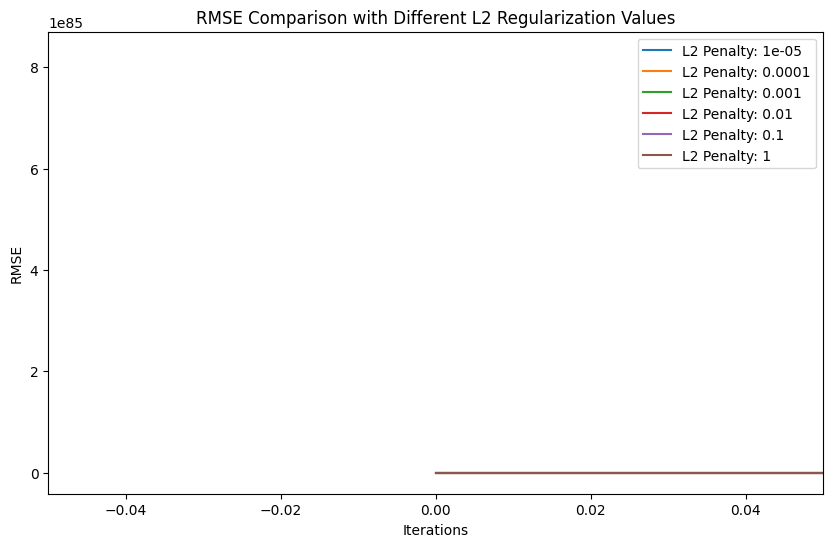

In [11]:
#RMSE/Gradient Rod Evolution over time using Spins, now adding an l2-regularization term for the combination of parameters
#yielding the best results, now greatly decreasing the l2 parameter:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

#'Spins', based on the discretized PDE equation:
class Spins:
    def __init__(self, size, initial_condition):
        self.size = size
        self.spins = initial_condition.copy()

    def update(self, alpha, dt, dx):
        new_spins = np.zeros_like(self.spins)

        for i in range(1, self.size - 1):
            # Apply the discretized PDE equation to update spins
            new_spins[i] = self.spins[i] + alpha * (self.spins[i + 1] - 2 * self.spins[i] + self.spins[i - 1]) * dt / dx**2

        # Boundary conditions
        new_spins[0] = 0
        new_spins[-1] = 0

        self.spins = new_spins.copy()

#Class to solve the PDE:
class PDESolver:
    def __init__(self, x_dim, t_dim, dx, dt, alpha, spins):
        self.x_dim = x_dim
        self.t_dim = t_dim
        self.dx = dx
        self.dt = dt
        self.alpha = alpha
        self.spins = spins
        self.grid = np.zeros((x_dim, t_dim))  # Initialize grid for u(x, t)

    def initialize_conditions(self):
        self.grid[:, 0] = self.spins.spins.copy()

    def solve(self):
        for j in range(0, self.t_dim - 1):
            self.spins.update(self.alpha, self.dt, self.dx)
            self.grid[:, j + 1] = self.spins.spins.copy()
            
#Implementing the Recurrent Neural Network:
class RecurrentNN:
    def __init__(self, input_dim, hidden_layer_sizes, output_dim, dropout_rate=0.5, momentum=0.9, l2_penalty=0.000001):
        self.input_dim = input_dim
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_dim = output_dim
        self.dropout_rate = dropout_rate
        self.momentum = momentum
        self.l2_penalty = l2_penalty  # Include the l2_penalty parameter
        self.weights = []
        self.biases = []
        self.activations = [self.sigmoid] * (len(hidden_layer_sizes) + 1)  # Sigmoid for hidden layers

        prev_layer_size = input_dim
        for layer_size in hidden_layer_sizes:
            weight_layer = np.random.randn(prev_layer_size, layer_size)
            bias_layer = np.zeros(layer_size)
            self.weights.append(weight_layer)
            self.biases.append(bias_layer)

            prev_layer_size = layer_size

        # Output layer weights
        weight_output = np.random.randn(prev_layer_size, output_dim)
        bias_output = np.zeros(output_dim)
        self.weights.append(weight_output)
        self.biases.append(bias_output)
    
    #Activation function is explicitly given: 
    def sigmoid(self, x, derivative=False):
        if derivative:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))
    
    #Dropout function:
    def dropout(self, x):
        if self.dropout_rate >= 1.0:
            return x

        mask = (np.random.rand(*x.shape) < self.dropout_rate) / max(1e-5, (1 - self.dropout_rate))
        return x * mask
    
    #Feed-forward:
    def forward(self, x, training=True):
        layer_input = x
        layer_outputs = [layer_input]
        masks = []

        for i in range(len(self.weights)):
            weighted_sum = np.dot(layer_input, self.weights[i]) + self.biases[i]
            layer_output = self.activations[i](weighted_sum)

            if training and i < len(self.weights) - 1:
                layer_output = self.dropout(layer_output)
                masks.append(layer_output)

            layer_outputs.append(layer_output)
            layer_input = layer_output

        return layer_outputs, masks
    
    #Training loop:
    def train(self, input_sequences, target_outputs, learning_rate, num_epochs, desc="Training"):
        num_samples, sequence_length, _ = input_sequences.shape
        training_errors = []  # Store training errors
        min_rmse = float('inf')  # Initialize minimum RMSE

        # Initialize velocities for momentum
        velocities = [np.zeros_like(w) for w in self.weights]
        biases_velocities = [np.zeros_like(b) for b in self.biases]

        for epoch in tqdm(range(num_epochs), desc=desc):
            for sample in range(num_samples):
                input_sequence = input_sequences[sample, :, :]
                target_output = target_outputs[sample, :]

                # Forward pass with dropout
                layer_outputs, masks = self.forward(input_sequence)

                final_output = layer_outputs[-1]

                # Calculate loss with L2 regularization
                loss = np.mean((final_output - target_output)**2)
                l2_regularization = 0.5 * self.l2_penalty * sum(np.sum(w**2) for w in self.weights)
                loss += l2_regularization

                training_errors.append(loss)

                # Backpropagation Through Time (BPTT) with momentum and L2 regularization
                derror = 2 * (final_output - target_output) / num_samples

                for i in range(len(self.weights) - 1, -1, -1):
                    dactivation = self.sigmoid(layer_outputs[i + 1], derivative=True)
                    
                    # Ensure dactivation has the same shape as derror
                    dactivation = dactivation[:, :derror.shape[1]]

                    doutput = derror * dactivation

                    # Apply dropout mask during backpropagation
                    if i < len(self.weights) - 1:
                        doutput *= masks[i]

                    dweights = np.dot(layer_outputs[i].T, doutput) + self.l2_penalty * self.weights[i]
                    dbiases = np.sum(doutput, axis=0)

                    # Update velocities with momentum
                    velocities[i] = self.momentum * velocities[i] + learning_rate * dweights
                    biases_velocities[i] = self.momentum * biases_velocities[i] + learning_rate * dbiases

                    # Update weights and biases with momentum
                    self.weights[i] -= velocities[i]
                    self.biases[i] -= biases_velocities[i]

                    derror = np.dot(doutput, self.weights[i].T)

                # Calculate and print minimum RMSE during training
                if len(training_errors) % sequence_length == 0:
                    rmse = np.sqrt(np.mean(training_errors[-sequence_length:]))
                    if rmse < min_rmse:
                        min_rmse = rmse
                    print(f'Minimum RMSE at epoch {epoch + 1}: {min_rmse}')

        return training_errors
    
    #Prediction:
    def predict(self, input_sequence):
        layer_input = input_sequence
        for i in range(len(self.weights)):
            weighted_sum = np.dot(layer_input, self.weights[i]) + self.biases[i]
            layer_input = self.sigmoid(weighted_sum)

        return layer_input

    def plot_3d_training_progress(self, training_errors_f, training_errors_g):
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        epochs = len(training_errors_f)

        # Ensure that both arrays have the same length
        min_len = min(len(training_errors_f), len(training_errors_g))
        x = np.arange(0, min_len, 1)

        # Plot the 3D line
        ax.plot(x, training_errors_f[:min_len], zs=0, zdir='y', label='RMSE for f(t)')
        ax.plot(x, training_errors_g[:min_len], zs=1, zdir='y', label='RMSE for g(x)')

        ax.set_xlabel('Epochs')
        ax.set_ylabel('Functions')
        ax.set_zlabel('RMSE')
        ax.set_title('3D Plot of RMSE for f(t) and g(x)')
        ax.legend()

        plt.show()

# PDE solver parameters
x_dim = 100
t_dim = 1000
L = 1.0
dx = L / (x_dim - 1)
dt = 0.001
alpha = 0.01

# Create Spins instance for the PDE solver with initial condition sin(pi*x)
initial_condition = np.sin(np.pi * np.linspace(0, 1, x_dim))
spins = Spins(x_dim, initial_condition)

# Create PDE solver with spins
pde_solver = PDESolver(x_dim, t_dim, dx, dt, alpha, spins)

# Initialize initial conditions
pde_solver.initialize_conditions()

# Prepare data for RNN training with spins
num_samples = 20
input_sequences = np.zeros((num_samples, x_dim, t_dim))
target_outputs = np.zeros((num_samples, x_dim, t_dim))

for i in range(num_samples):
    input_sequences[i, :, :] = pde_solver.grid.copy()
    pde_solver.solve()
    target_outputs[i, :, :] = pde_solver.grid.copy()

# RNN parameters
input_dim = x_dim
hidden_layer_sizes = [2, 2, 2, 2, 2, 2, 2, 2]  # 2 layers with 10 neurons each
output_dim = x_dim
learning_rate = 1e-2
num_epochs = 1000
momentum_value = 0.7
dropout_rate = 0.5  # Adjust dropout rate as needed

# Create and train RNN for f(t) and g(x) together with BPTT
rnn_model_fg = RecurrentNN(t_dim, hidden_layer_sizes, t_dim, dropout_rate)
training_errors_fg = rnn_model_fg.train(input_sequences[:, :, :], target_outputs[:, 0, :], learning_rate, num_epochs, desc="Training f(t) and g(x)")

# Predict using the trained RNN
predicted_outputs_fg = np.zeros((num_samples, x_dim, t_dim))
for i in range(num_samples):
    input_sequence = input_sequences[i, :, :]
    predicted_output_fg = rnn_model_fg.predict(input_sequence)
    predicted_outputs_fg[i, :, :] = predicted_output_fg

# Create and train RNN for f(t) and g(x) together with BPTT with L2 regularization
rnn_model_fg_l2 = RecurrentNN(t_dim, hidden_layer_sizes, t_dim, dropout_rate, momentum_value)
training_errors_fg_l2 = rnn_model_fg_l2.train(input_sequences[:, :, :], target_outputs[:, 0, :], learning_rate, num_epochs, desc="Training f(t) and g(x) with L2 regularization")

# Predict using the trained RNN with L2 regularization
predicted_outputs_fg_l2 = np.zeros((num_samples, x_dim, t_dim))
for i in range(num_samples):
    input_sequence = input_sequences[i, :, :]
    predicted_output_fg_l2 = rnn_model_fg_l2.predict(input_sequence)
    predicted_outputs_fg_l2[i, :, :] = predicted_output_fg_l2

# Visualize the results
fig, ax = plt.subplots(figsize=(10, 6))
X, T = np.meshgrid(np.linspace(0, L, x_dim), np.linspace(0, dt * (t_dim - 1), t_dim))
Z_fg = predicted_outputs_fg[0, :, :].T  # Transpose the matrix to match the expected shape
Z_fg_l2 = predicted_outputs_fg_l2[0, :, :].T

# Use a different color map with a broader range of colors
contour_fg = ax.contourf(X, T, Z_fg, cmap='plasma', levels=100)
contour_fg_l2 = ax.contourf(X, T, Z_fg_l2, cmap='plasma', levels=100, alpha=0.7)  # Adjust alpha for transparency

ax.set_xlabel('Position (x)')
ax.set_ylabel('Time (t)')
ax.set_title('Predicted Temperature Gradient Evolution using RNN')
plt.colorbar(contour_fg, ax=ax, label='Temperature (No L2 Regularization)')
plt.colorbar(contour_fg_l2, ax=ax, label='Temperature (With L2 Regularization)')
plt.show()

# List of L2 penalty values to try
l2_penalty_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]

# Dictionary to store training errors for each L2 penalty
training_errors_dict = {}

for l2_penalty in l2_penalty_values:
    # Create and train RNN for f(t) and g(x) together with BPTT with L2 regularization
    rnn_model_fg_l2 = RecurrentNN(t_dim, hidden_layer_sizes, t_dim, dropout_rate, momentum_value, l2_penalty=l2_penalty)
    training_errors_fg_l2 = rnn_model_fg_l2.train(input_sequences[:, :, :], target_outputs[:, 0, :], learning_rate, num_epochs, desc=f"Training f(t) and g(x) with L2 regularization (l2_penalty={l2_penalty})")
    
    # Store the training errors for later comparison
    training_errors_dict[l2_penalty] = training_errors_fg_l2

# Plotting the RMSE for different L2 penalty values
plt.figure(figsize=(10, 6))
for l2_penalty, training_errors in training_errors_dict.items():
    plt.plot(training_errors, label=f'L2 Penalty: {l2_penalty}')

plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('RMSE Comparison with Different L2 Regularization Values')
plt.legend()

# Define the range of RMSE values to zoom in on
rmse_range_min = 0.003
rmse_range_max = 0.007

# Find the indices corresponding to the range
start_index = np.argmax(np.array(training_errors) > rmse_range_min)
end_index = np.argmax(np.array(training_errors) > rmse_range_max)

# Zoom in on the x-axis based on the indices of the specified RMSE range
plt.xlim(start_index, end_index)

plt.show()

#Illustrating the minimum RMSE at epoch 1000 across L2-penalties/terms.